<a href="https://colab.research.google.com/github/matthew-ngzc/cs421-project/blob/main/Kernel_Lennel_CS421_Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KERNEL LENNEL CS421 PROJECT

---

# Preparation

In [ ]:
# @title installing packages for neural network
!pip install scikeras
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# @title Setting Seed
import numpy as np
import tensorflow as tf
import random
import os

# === SET ALL RANDOM SEEDS ===
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # For full determinism (may slow down training)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    print(f"✓ Set all random seeds to {seed}")

# Call this BEFORE creating any models
set_seeds(42)

✓ Set all random seeds to 42


In [ ]:
# @title Loading Dataframe
import requests, io, numpy as np

def load_npz_from_github(filename):
    base_url = "https://raw.githubusercontent.com/matthew-ngzc/cs421-project/main/"
    url = base_url + filename
    response = requests.get(url)
    response.raise_for_status()  # ensures you catch 404 errors
    return np.load(io.BytesIO(response.content))


import pandas as pd

# First Batch Labelled
data  = load_npz_from_github("first_batch_regression_labelled.npz")
X1     = data["X"]
y1     = data["yy"]
y_cat1 = data["yy_cat"]

# Load dataframes
X1     = pd.DataFrame(X1, columns=["user", "item", "rating"])
y1     = pd.DataFrame(y1, columns=["user", "label"])
y_cat1 = pd.DataFrame(y_cat1, columns=["user", "label", "anomtype"])

# Parse to correct types
y1     = y1.astype({"user": int, "label": float})
y_cat1 = y_cat1.astype({"user": int, "label": float, "anomtype": int})


# Second Batch Labelled
data2 = load_npz_from_github("second_batch_regression_labelled.npz")
X2   = data2["X"]
y2     = data2["yy"]
y_cat2 = data2["yy_cat"]

# Load dataframes
X2     = pd.DataFrame(X2, columns=["user", "item", "rating"])
y2     = pd.DataFrame(y2, columns=["user", "label"])
y_cat2 = pd.DataFrame(y_cat2, columns=["user", "label", "anomtype"])

# Parse to correct types
y2     = y2.astype({"user": int, "label": float})
y_cat2 = y_cat2.astype({"user": int, "label": float, "anomtype": int})


# Third Batch Labelled
data3 = load_npz_from_github("third_batch_regression_labelled.npz")
X3   = data3["X"]
y3     = data3["yy"]
y_cat3 = data3["yy_cat"]

# Load dataframes
X3     = pd.DataFrame(X3, columns=["user", "item", "rating"])
y3     = pd.DataFrame(y3, columns=["user", "label"])
y_cat3 = pd.DataFrame(y_cat3, columns=["user", "label", "anomtype"])

# Parse to correct types
y3     = y3.astype({"user": int, "label": float})
y_cat3 = y_cat3.astype({"user": int, "label": float, "anomtype": int})


# Fourth Batch Labelled
data4 = load_npz_from_github("fourth_batch_regression_labelled.npz")
X4   = data4["X"]
y4     = data4["yy"]
y_cat4 = data4["yy_cat"]

# Load dataframes
X4     = pd.DataFrame(X4, columns=["user", "item", "rating"])
y4     = pd.DataFrame(y4, columns=["user", "label"])
y_cat4 = pd.DataFrame(y_cat4, columns=["user", "label", "anomtype"])

# Parse to correct types
y4     = y4.astype({"user": int, "label": float})
y_cat4 = y_cat4.astype({"user": int, "label": float, "anomtype": int})


# Combining all labelled batches
X = pd.concat([X1, X2, X3, X4], axis=0).reset_index(drop=True)
y = pd.concat([y1, y2, y3, y4], axis=0).reset_index(drop=True)
y_cat = pd.concat([y_cat1, y_cat2, y_cat3, y_cat4], axis=0).reset_index(drop=True)

X = X.astype({"user": int, "item": int, "rating": int})
y = y.astype({"user": int, "label": float})
y_cat = y_cat.astype({"user": int, "label": float, "anomtype": int})


# Unlabelled Batch (Unseen data)
XX    = load_npz_from_github("fifth_batch_regression_unlabelled.npz")['X']
XX    = pd.DataFrame(XX, columns=["user", "item", "rating"])

In [ ]:
# @title Understanding the dataset
# Count unique users
unique_users_1 = X["user"].nunique()
unique_users_2 = XX["user"].nunique()

print(f"Number of unique users in X: {unique_users_1}")
print(f"Number of unique users in XX: {unique_users_2}")


# Count unique movies
unique_movies_1 = X["item"].nunique()
unique_movies_2 = XX["item"].nunique()

print(f"Number of unique movies in X: {unique_movies_1}")
print(f"Number of unique movies in XX: {unique_movies_2}")

Number of unique users in X: 3600
Number of unique users in XX: 900
Number of unique movies in X: 1000
Number of unique movies in XX: 1000


# Exploratory Data Analysis

In [ ]:
# @title basic features and functions
import numpy as np
import pandas as pd
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# --- Compute basic user-level features ---
def basic_features(df):
    feats = (
        df.groupby('user')['rating']
        .agg(
            n_ratings='count',
            mean='mean',
            std='std',
            skew=lambda x: skew(x, bias=False) if len(x) > 2 else 0
        )
        .reset_index()
    )
    feats['n_unique_items'] = df.groupby('user')['item'].nunique().values
    feats['dup_rate'] = 1 - feats['n_unique_items'] / feats['n_ratings']
    return feats

def analyze_batch(X, y, y_cat, batch_name):
    """Perform complete analysis on a batch"""
    print(f"\n{'='*80}")
    print(f"Analysis for {batch_name}")
    print(f"{'='*80}\n")

    # Compute features
    feats = basic_features(X)

    # Merge - only keep label_y, drop label_ycat
    merged = (
        feats
        .merge(y, on='user', how='left')
        .merge(y_cat[['user', 'anomtype']], on='user', how='inner')  # Only take anomtype from y_cat
    )
    # Rename label to label_y for consistency
    merged = merged.rename(columns={'label': 'label_y'})

    print(f"Data shape: {len(merged)} users")
    print(f"\nFeature summary (first 20 rows):")
    display(
        merged
          .sort_values(['anomtype', 'user'])
          .head(20)
          .style
          .set_table_styles([{'selector': 'th, td', 'props': [('white-space', 'nowrap')]}])
          .hide(axis='index')
    )

    # Feature means by anomaly type
    print("\nFeature Means by Anomaly Type:")
    feature_cols = ['n_ratings', 'mean', 'std', 'skew', 'n_unique_items', 'dup_rate', 'label_y']
    display(
        merged.groupby('anomtype')[feature_cols]
        .mean()
        .round(4)
    )

    # Add ratings boxplot for each anomtype
    print("\nRating Distribution by Anomaly Type:")
    # Merge X with anomtype info
    X_with_type = X.merge(y_cat[['user', 'anomtype']], on='user', how='inner')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=X_with_type, x='anomtype', y='rating', ax=ax)
    ax.set_title(f'{batch_name} - Rating Distribution by Anomaly Type (Boxplot)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Anomaly Type')
    ax.set_ylabel('Rating')
    plt.tight_layout()
    plt.show()

    # Add ratings violin plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(data=X_with_type, x='anomtype', y='rating', ax=ax)
    ax.set_title(f'{batch_name} - Rating Distribution by Anomaly Type (Violin)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Anomaly Type')
    ax.set_ylabel('Rating')
    plt.tight_layout()
    plt.show()

    # Anomaly level boxplot (single graph)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=merged, x='anomtype', y='label_y', ax=ax)
    ax.set_title(f'{batch_name} - Anomaly Level Distribution by Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Anomaly Type')
    ax.set_ylabel('Anomaly Level (0-1)')
    plt.tight_layout()
    plt.show()


    return merged, X_with_type


Analysis for First Batch

Data shape: 15 users

Feature summary (first 20 rows):



Feature Means by Anomaly Type:


n_ratings    mean     std    skew  n_unique_items  dup_rate  label_y
anomtype                                                                      
0             312.6  2.7000  1.1121 -0.2548           312.6    0.0000   0.6713
1             212.4  3.3256  0.9486 -0.5221           209.8    0.0121   0.2835
2             289.2  3.8718  0.8082 -0.4001           269.6    0.0755   0.3713


Rating Distribution by Anomaly Type:


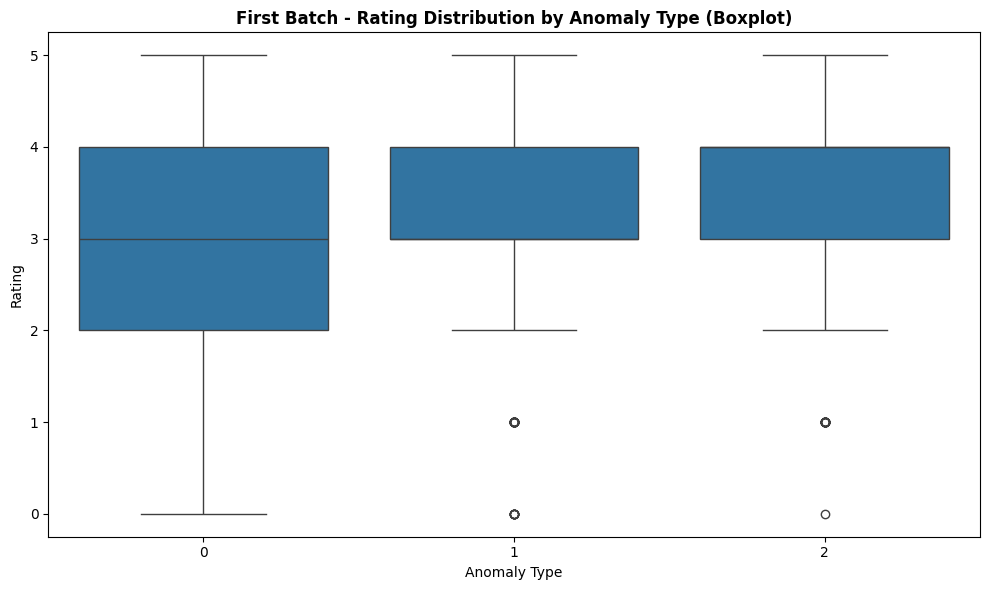

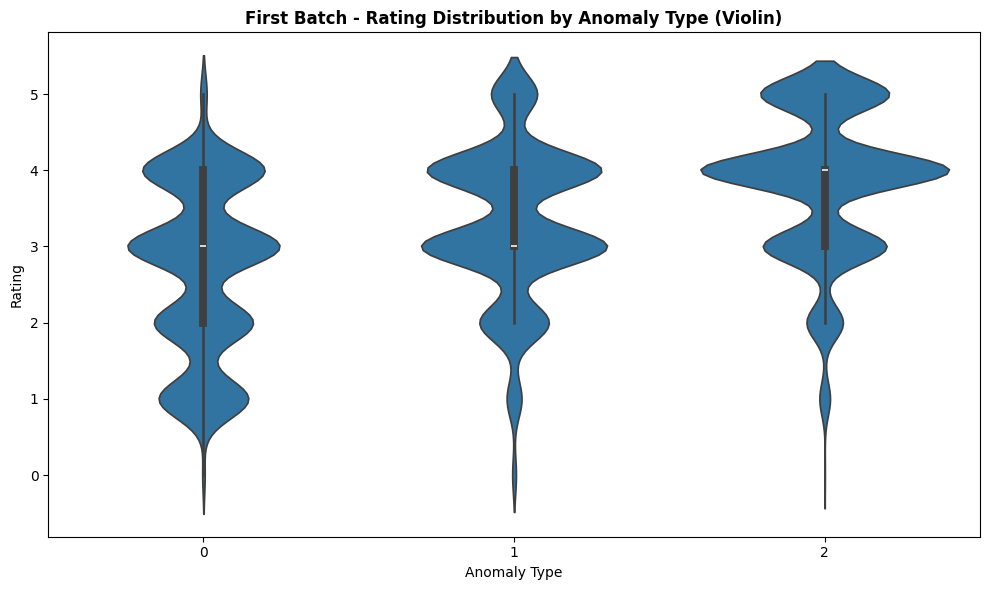

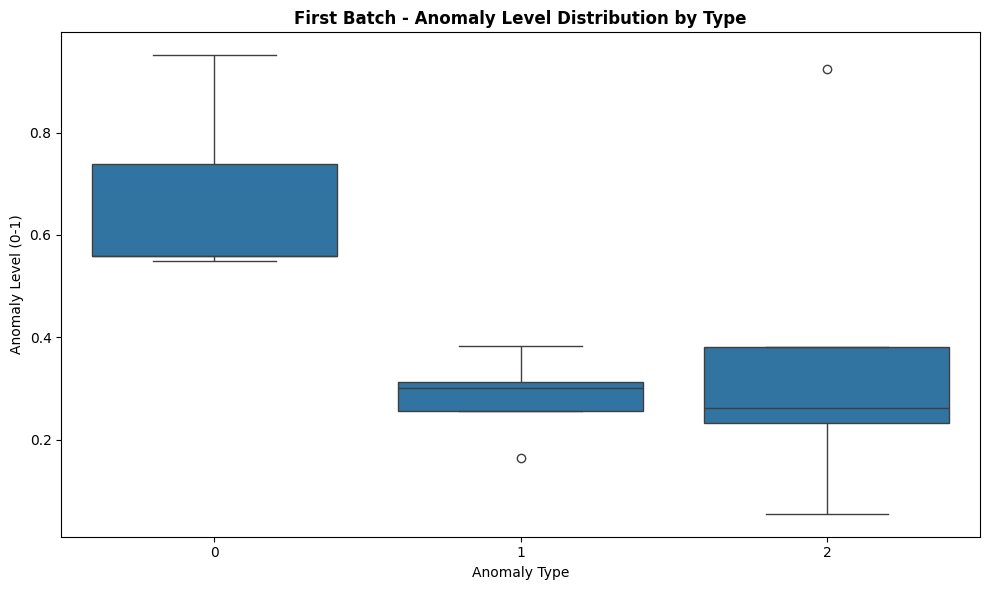

In [ ]:
# @title First Batch Analysis
merged1, X1_with_type = analyze_batch(X1, y1, y_cat1, "First Batch")


Analysis for Second Batch

Data shape: 15 users

Feature summary (first 20 rows):



Feature Means by Anomaly Type:


n_ratings    mean     std    skew  n_unique_items  dup_rate  label_y
anomtype                                                                      
0             403.8  3.0893  1.0252 -0.4226           403.8    0.0000   0.3381
1             261.2  3.2019  1.0209 -0.4853           242.8    0.0626   0.5018
2             297.6  3.7062  0.9163 -0.6222           273.8    0.0992   0.4206


Rating Distribution by Anomaly Type:


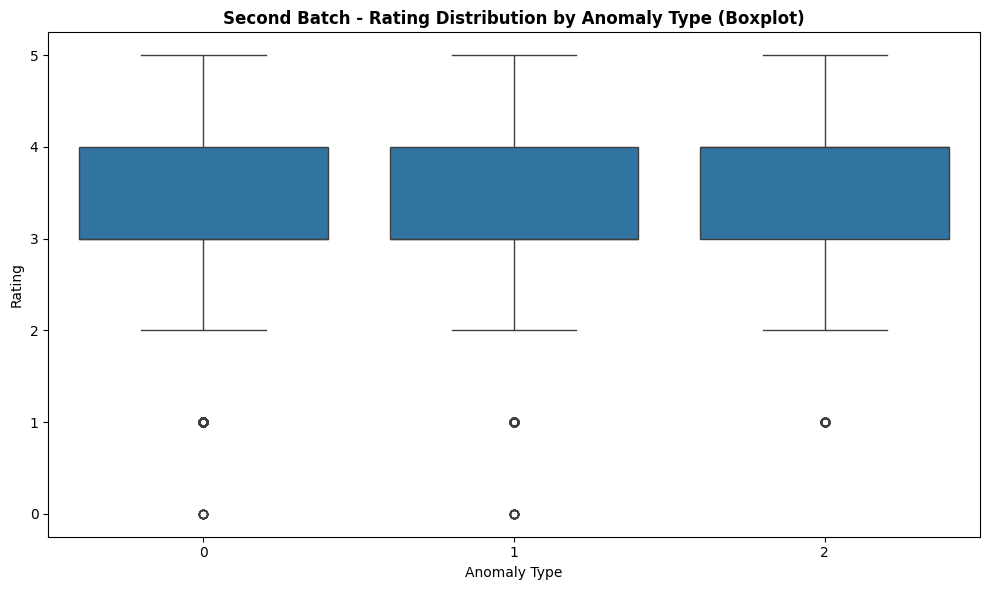

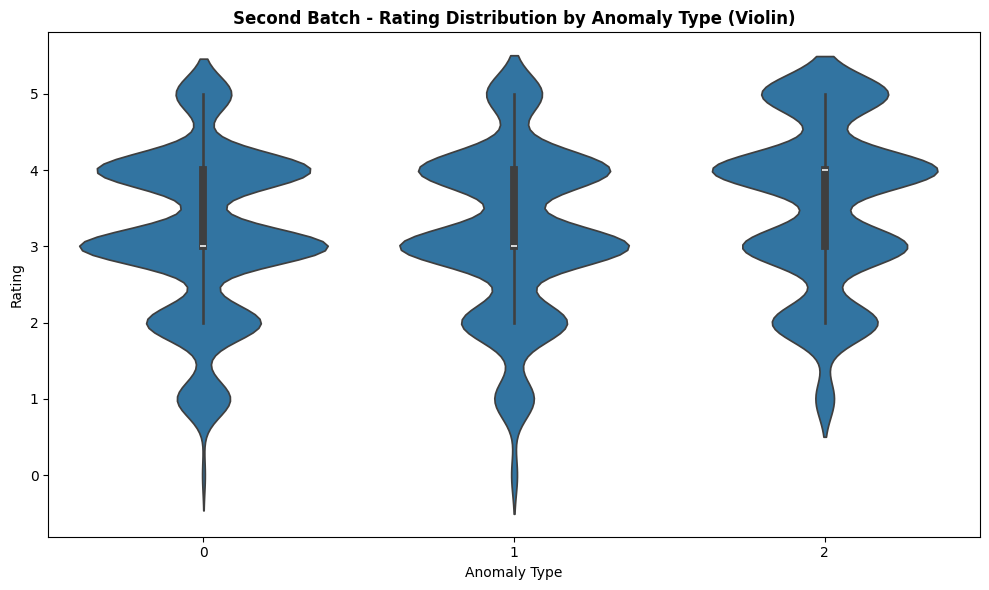

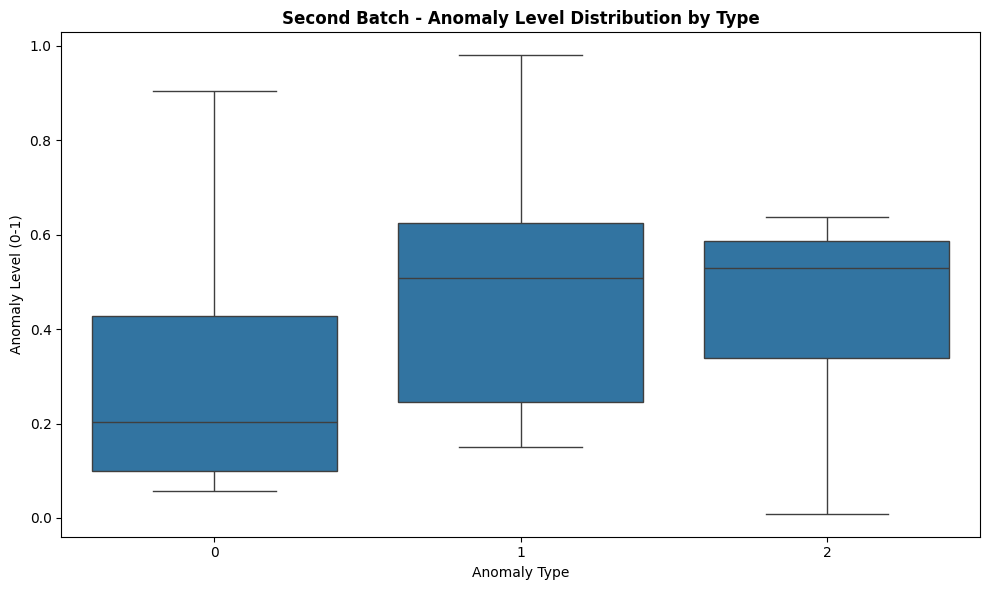

In [ ]:
# @title Second Batch Analysis
merged2, X2_with_type = analyze_batch(X2, y2, y_cat2, "Second Batch")


Analysis for Third Batch

Data shape: 15 users

Feature summary (first 20 rows):



Feature Means by Anomaly Type:


n_ratings    mean     std    skew  n_unique_items  dup_rate  label_y
anomtype                                                                      
0             262.6  2.8217  1.1804 -0.1958           262.6    0.0000   0.6529
1             312.4  3.2819  1.0826 -0.4353           297.2    0.0396   0.4042
2             298.4  3.8732  0.9917 -0.8610           250.0    0.1572   0.5089


Rating Distribution by Anomaly Type:


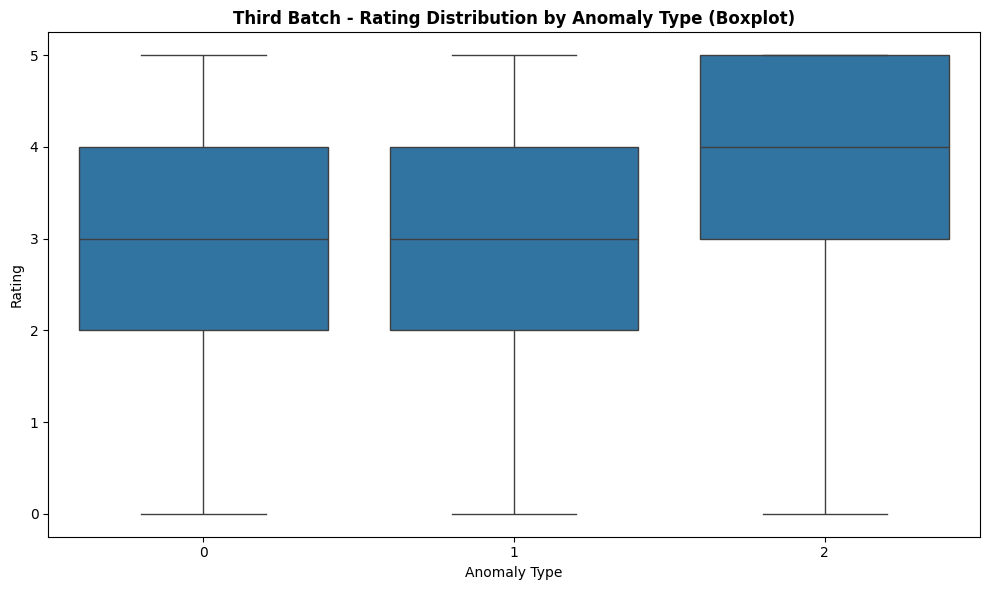

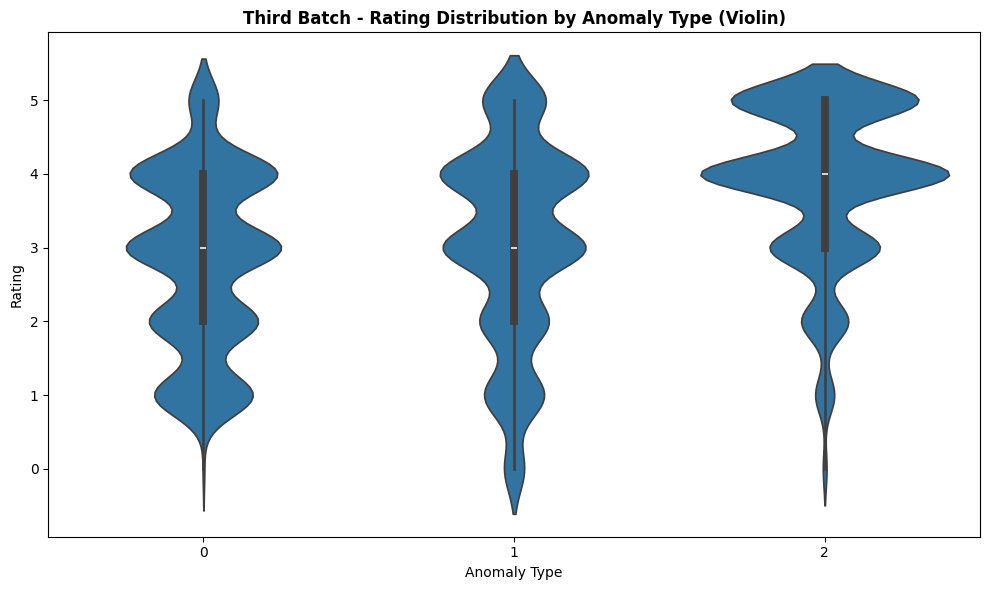

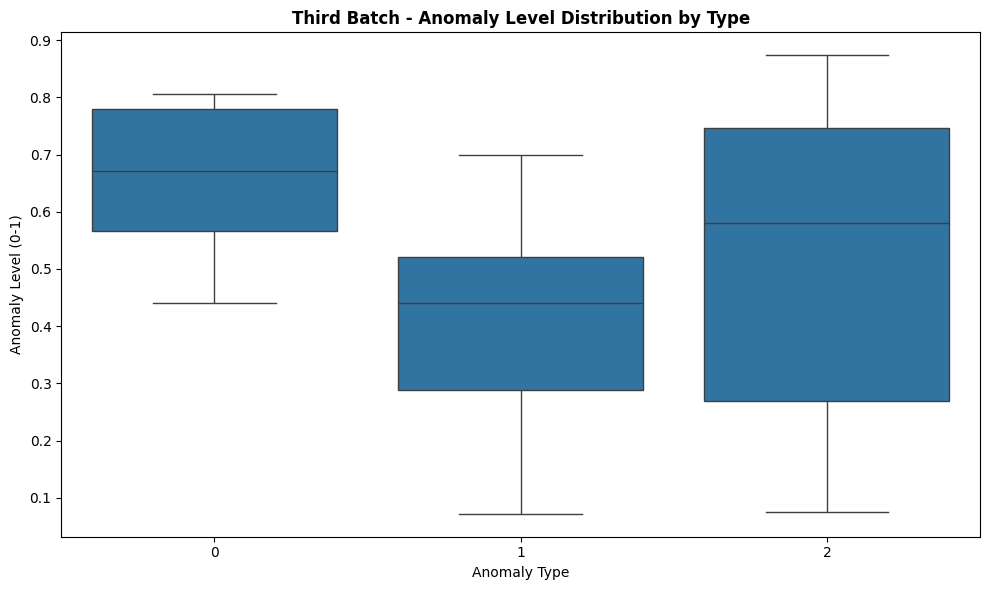

In [ ]:
# @title Third Batch Analysis
merged3, X3_with_type = analyze_batch(X3, y3, y_cat3, "Third Batch")


Analysis for Fourth Batch

Data shape: 15 users

Feature summary (first 20 rows):



Feature Means by Anomaly Type:


n_ratings    mean     std    skew  n_unique_items  dup_rate  label_y
anomtype                                                                      
0             255.0  2.7849  1.0318 -0.3896           255.0     0.000   0.5392
1             306.2  3.5233  0.7901 -0.3532           275.8     0.099   0.7474
2             329.2  4.1651  0.7991 -0.9099           249.2     0.252   0.7171


Rating Distribution by Anomaly Type:


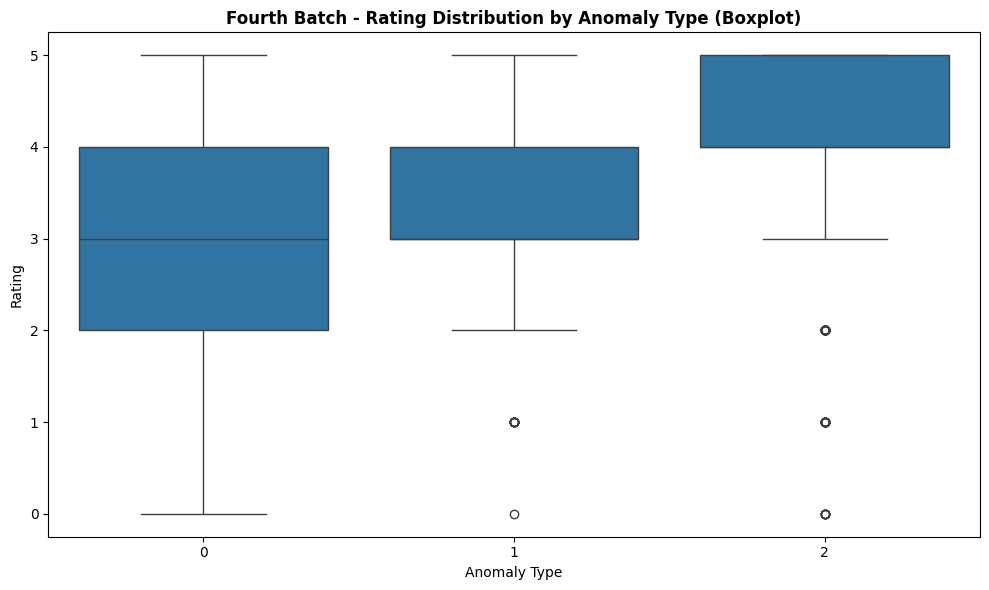

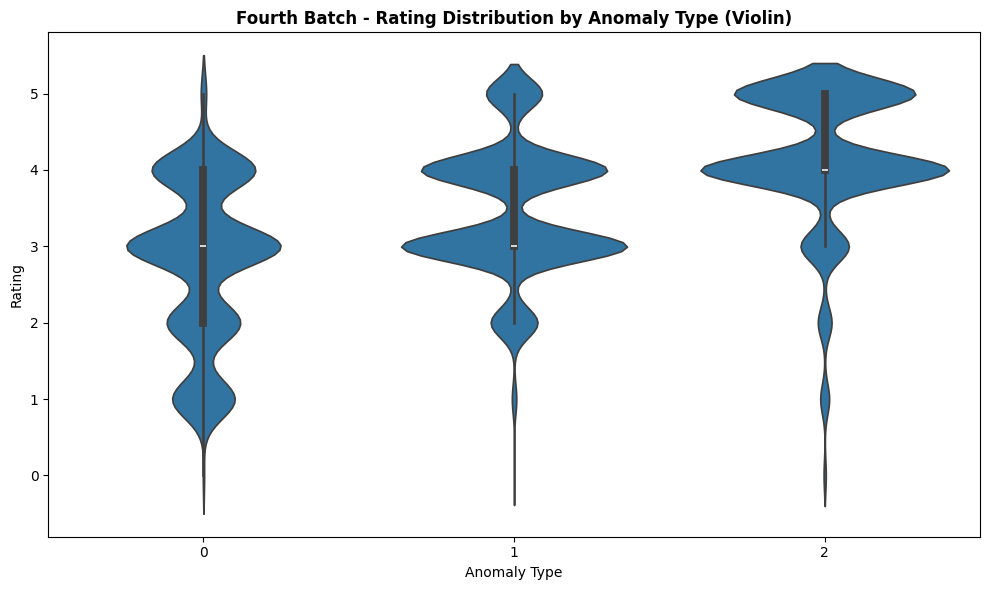

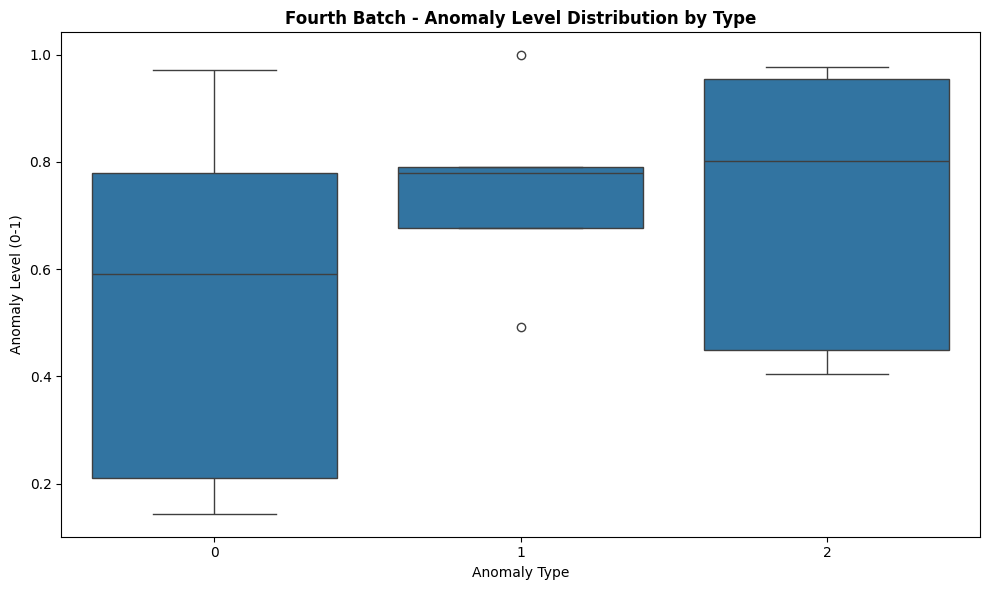

In [ ]:
# @title Fourth Batch Analysis
merged4, X4_with_type = analyze_batch(X4, y4, y_cat4, "Fourth Batch")


Analysis for Combined (All Batches)

Data shape: 60 users

Feature summary (first 20 rows):



Feature Means by Anomaly Type:


n_ratings    mean     std    skew  n_unique_items  dup_rate  label_y
anomtype                                                                      
0            308.50  2.8490  1.0874 -0.3157          308.50    0.0000   0.5504
1            273.05  3.3332  0.9606 -0.4490          256.40    0.0533   0.4842
2            303.60  3.9041  0.8788 -0.6983          260.65    0.1460   0.5045


Rating Distribution by Anomaly Type:


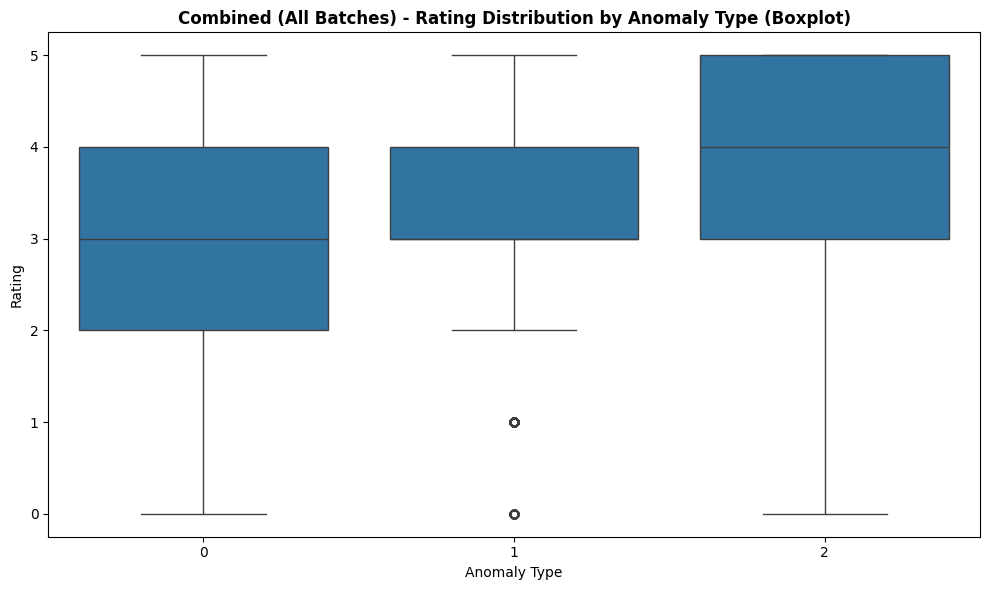

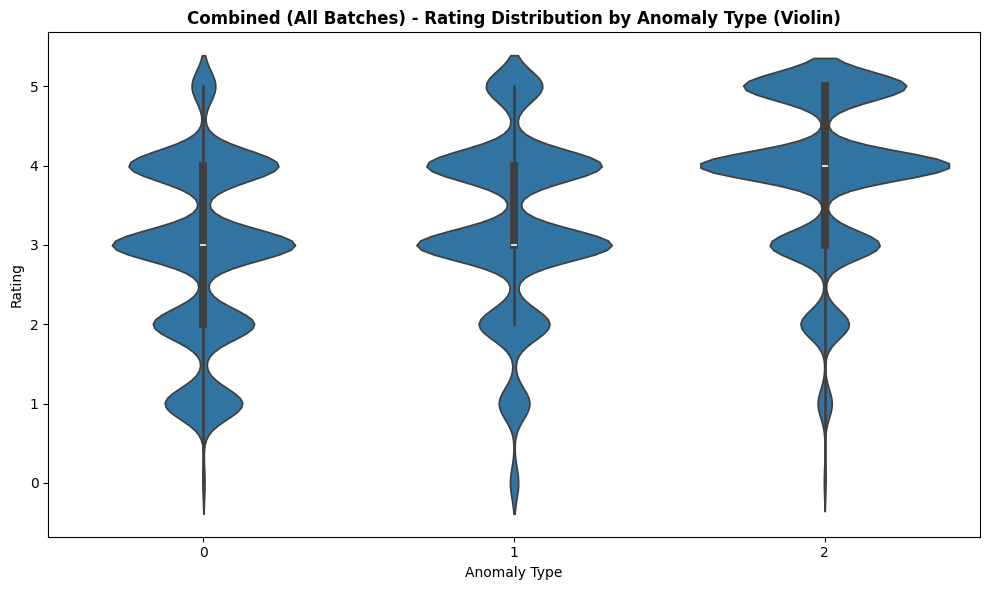

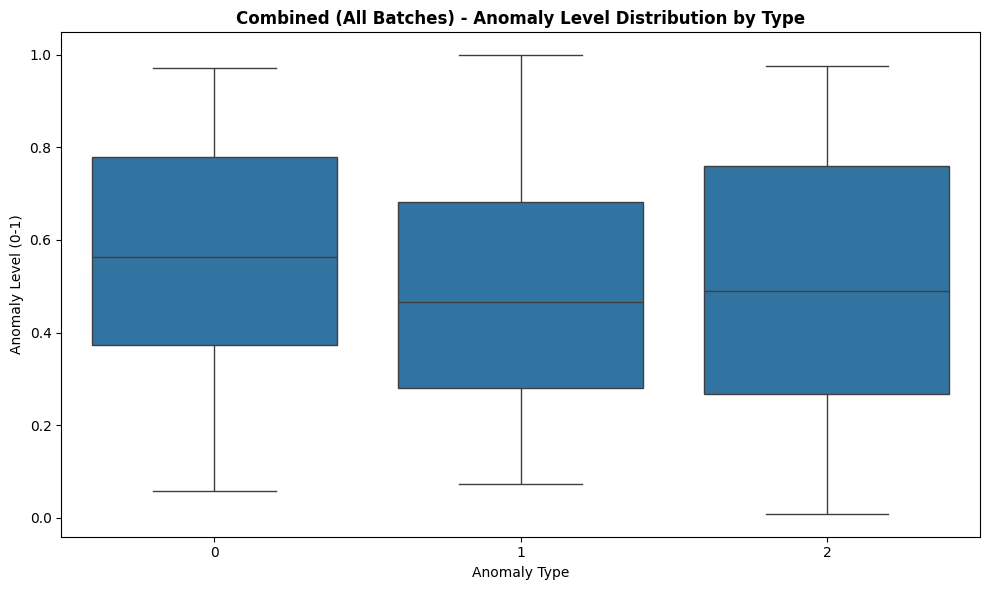

In [ ]:
# @title Combined Analysis (all batches)
# Combine all batches
X_all = pd.concat([X1, X2, X3, X4], ignore_index=True)
y_all = pd.concat([y1, y2, y3, y4], ignore_index=True)
y_cat_all = pd.concat([y_cat1, y_cat2, y_cat3, y_cat4], ignore_index=True)

# Remove duplicates (in case same users appear in multiple batches)
y_all = y_all.drop_duplicates(subset='user', keep='first')
y_cat_all = y_cat_all.drop_duplicates(subset='user', keep='first')

merged_all, X_all_with_type = analyze_batch(X_all, y_all, y_cat_all, "Combined (All Batches)")

In [ ]:
# @title Comparison across Batches
# Add batch identifier to each merged dataset
merged1['batch'] = 'Batch 1'
merged2['batch'] = 'Batch 2'
merged3['batch'] = 'Batch 3'
merged4['batch'] = 'Batch 4'

X1_with_type['batch'] = 'Batch 1'
X2_with_type['batch'] = 'Batch 2'
X3_with_type['batch'] = 'Batch 3'
X4_with_type['batch'] = 'Batch 4'

# Combine for comparison
all_batches = pd.concat([merged1, merged2, merged3, merged4], ignore_index=True)
all_ratings = pd.concat([X1_with_type, X2_with_type, X3_with_type, X4_with_type], ignore_index=True)

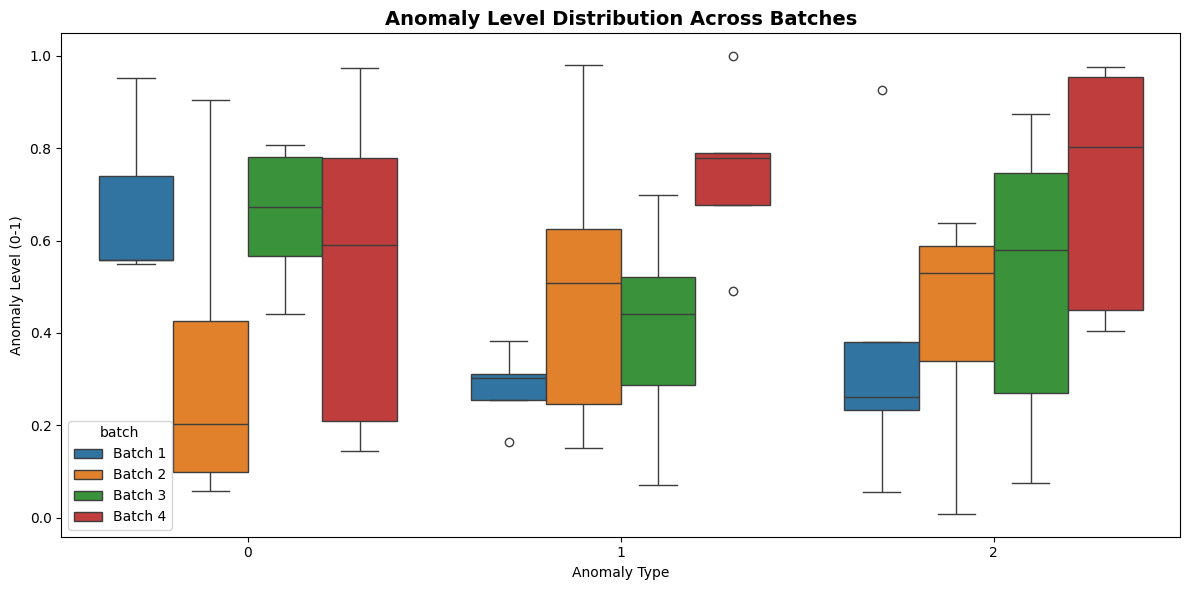

In [ ]:
# @title Anomaly Level by Batch and Type
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=all_batches, x='anomtype', y='label_y', hue='batch', ax=ax)
ax.set_title('Anomaly Level Distribution Across Batches', fontsize=14, fontweight='bold')
ax.set_xlabel('Anomaly Type')
ax.set_ylabel('Anomaly Level (0-1)')
plt.tight_layout()
plt.show()

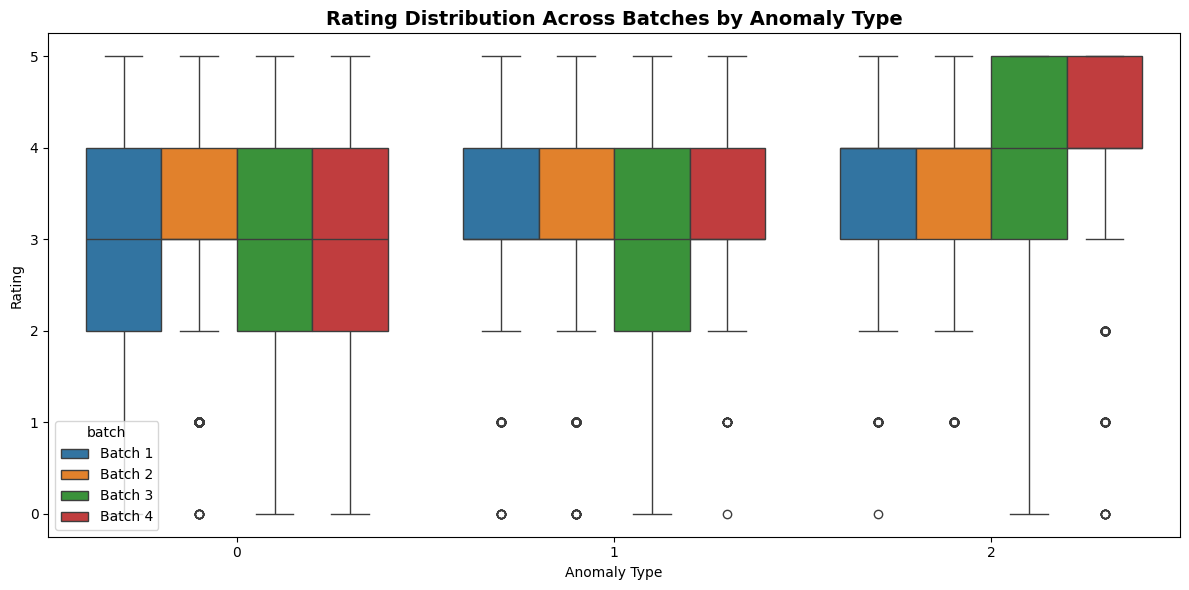

In [ ]:
# @title Rating Distribution by Batch and Type (Box Plot)
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=all_ratings, x='anomtype', y='rating', hue='batch', ax=ax)
ax.set_title('Rating Distribution Across Batches by Anomaly Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Anomaly Type')
ax.set_ylabel('Rating')
plt.tight_layout()
plt.show()

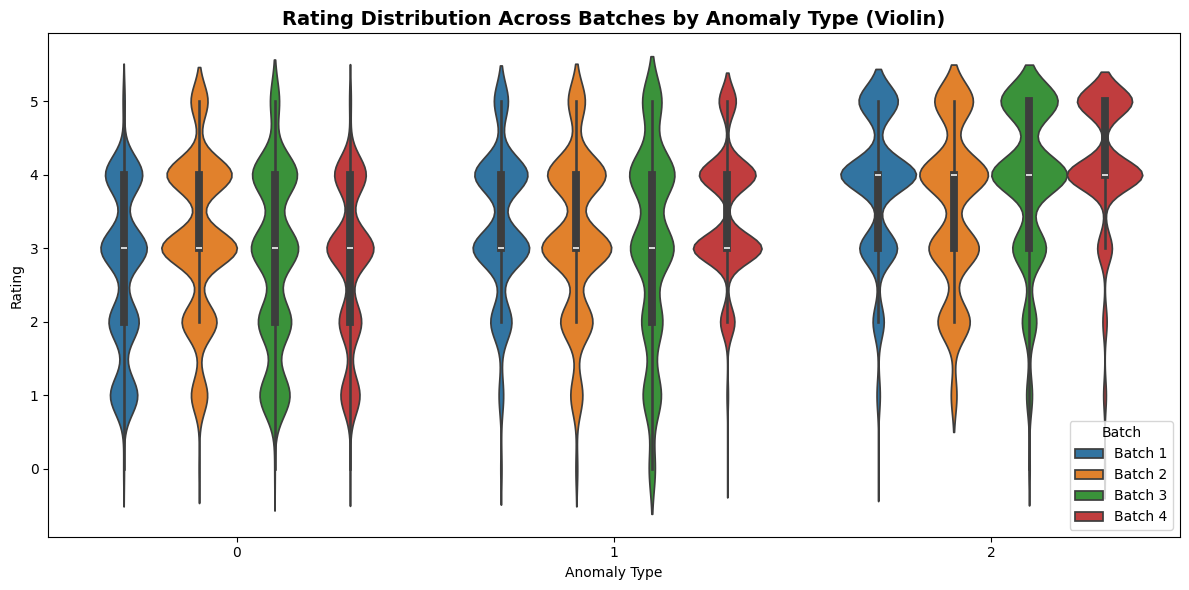

In [ ]:
# @title Rating Distribution by Batch and Type (Violin Plot)
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=all_ratings, x='anomtype', y='rating', hue='batch', ax=ax)
ax.set_title('Rating Distribution Across Batches by Anomaly Type (Violin)', fontsize=14, fontweight='bold')
ax.set_xlabel('Anomaly Type')
ax.set_ylabel('Rating')

# Move legend to bottom right
ax.legend(loc='lower right', title='Batch')

plt.tight_layout()
plt.show()


### Duplicate Analysis (Combined Batches)

In [ ]:
# @title Extract Duplicate Ratings
# Combine all X data with anomaly type info
X_all_combined = pd.concat([X1, X2, X3, X4], ignore_index=True)
y_cat_all_combined = pd.concat([y_cat1, y_cat2, y_cat3, y_cat4], ignore_index=True)

# Merge X with anomaly types
X_with_anom = X_all_combined.merge(y_cat_all_combined[['user', 'anomtype']], on='user', how='inner')

# Find duplicates: same user rating same item multiple times
# Mark duplicates (keep all occurrences)
X_with_anom['is_duplicate'] = X_with_anom.duplicated(subset=['user', 'item'], keep=False)

# Extract only the duplicate ratings
duplicates = X_with_anom[X_with_anom['is_duplicate']].copy()

print(f"Total ratings: {len(X_with_anom)}")
print(f"Duplicate ratings: {len(duplicates)} ({len(duplicates)/len(X_with_anom)*100:.2f}%)")
print(f"\nDuplicate ratings by anomaly type:")
display(duplicates.groupby('anomtype').size().to_frame('count'))

print(f"\nSample of duplicate ratings:")
display(duplicates.sort_values(['user', 'item']).head(10))

Total ratings: 17703
Duplicate ratings: 2136 (12.07%)

Duplicate ratings by anomaly type:


count
anomtype       
1           635
2          1501


Sample of duplicate ratings:


user  item  rating  anomtype  is_duplicate
287   199   870       2         1          True
394   199   870       4         1          True
577   202    38       5         2          True
642   202    38       4         2          True
573   202    84       5         2          True
643   202    84       4         2          True
648   202    84       5         2          True
471   202   122       4         2          True
629   202   122       4         2          True
604   202   144       5         2          True

In [ ]:
# @title Rating Distribution of Duplicates by Anomaly Type
# Compare duplicate rating distributions across anomaly types
print("Mean rating of duplicates by anomaly type:")
dup_mean = duplicates.groupby('anomtype')['rating'].mean()
display(dup_mean.to_frame('mean_duplicate_rating').round(4))

print("\nRating value counts for duplicates by anomaly type:")
for anom_type in sorted(duplicates['anomtype'].unique()):
    print(f"\nAnomaly Type {anom_type}:")
    type_dups = duplicates[duplicates['anomtype'] == anom_type]
    rating_counts = type_dups['rating'].value_counts().sort_index()
    rating_pct = (rating_counts / len(type_dups) * 100).round(2)
    result = pd.DataFrame({'count': rating_counts, 'percentage': rating_pct})
    display(result)

Mean rating of duplicates by anomaly type:


mean_duplicate_rating
anomtype                       
1                        3.1795
2                        4.4863


Rating value counts for duplicates by anomaly type:

Anomaly Type 1:


count  percentage
rating                   
0           4        0.63
1          41        6.46
2          88       13.86
3         254       40.00
4         200       31.50
5          48        7.56


Anomaly Type 2:


count  percentage
rating                   
4         771       51.37
5         730       48.63

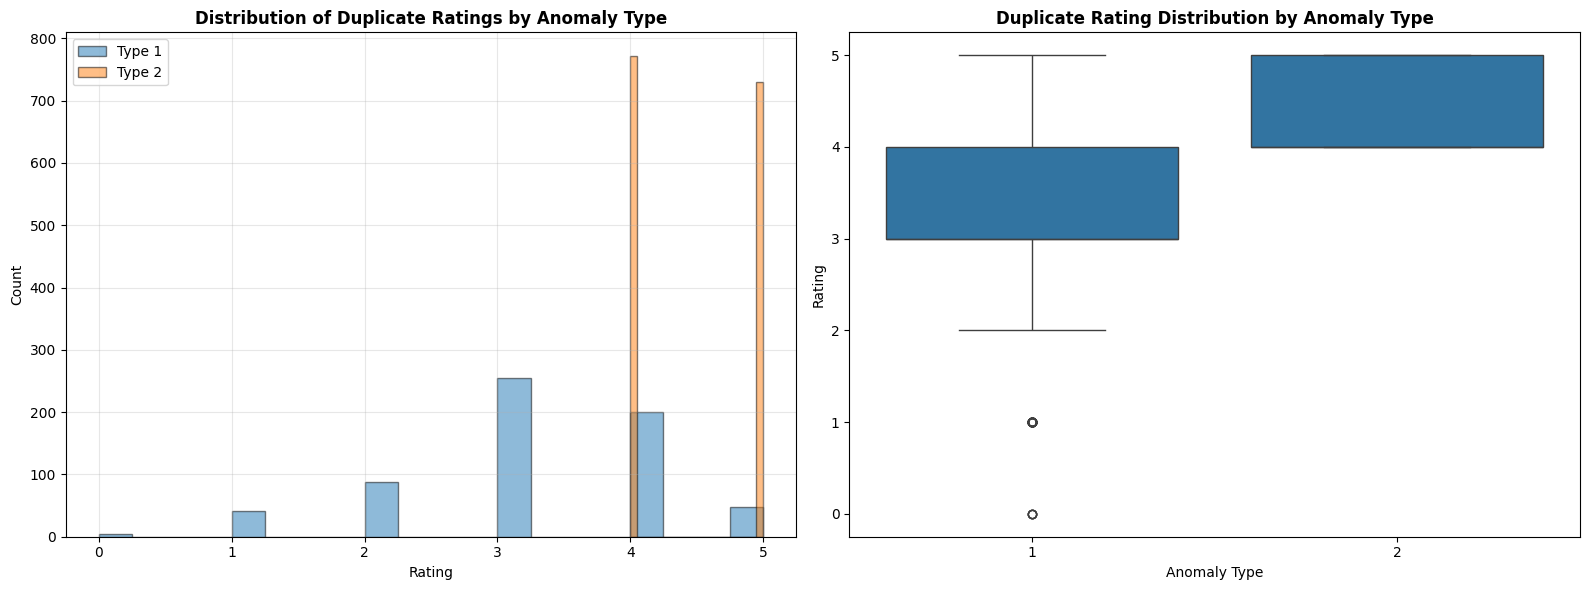

In [ ]:
# @title Visualize Duplicate Rating Distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of duplicate ratings by anomaly type
for anom_type in sorted(duplicates['anomtype'].unique()):
    type_dups = duplicates[duplicates['anomtype'] == anom_type]
    axes[0].hist(type_dups['rating'], bins=20, alpha=0.5, label=f'Type {anom_type}', edgecolor='black')

axes[0].set_title('Distribution of Duplicate Ratings by Anomaly Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
sns.boxplot(data=duplicates, x='anomtype', y='rating', ax=axes[1])
axes[1].set_title('Duplicate Rating Distribution by Anomaly Type', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Anomaly Type')
axes[1].set_ylabel('Rating')

plt.tight_layout()
plt.show()

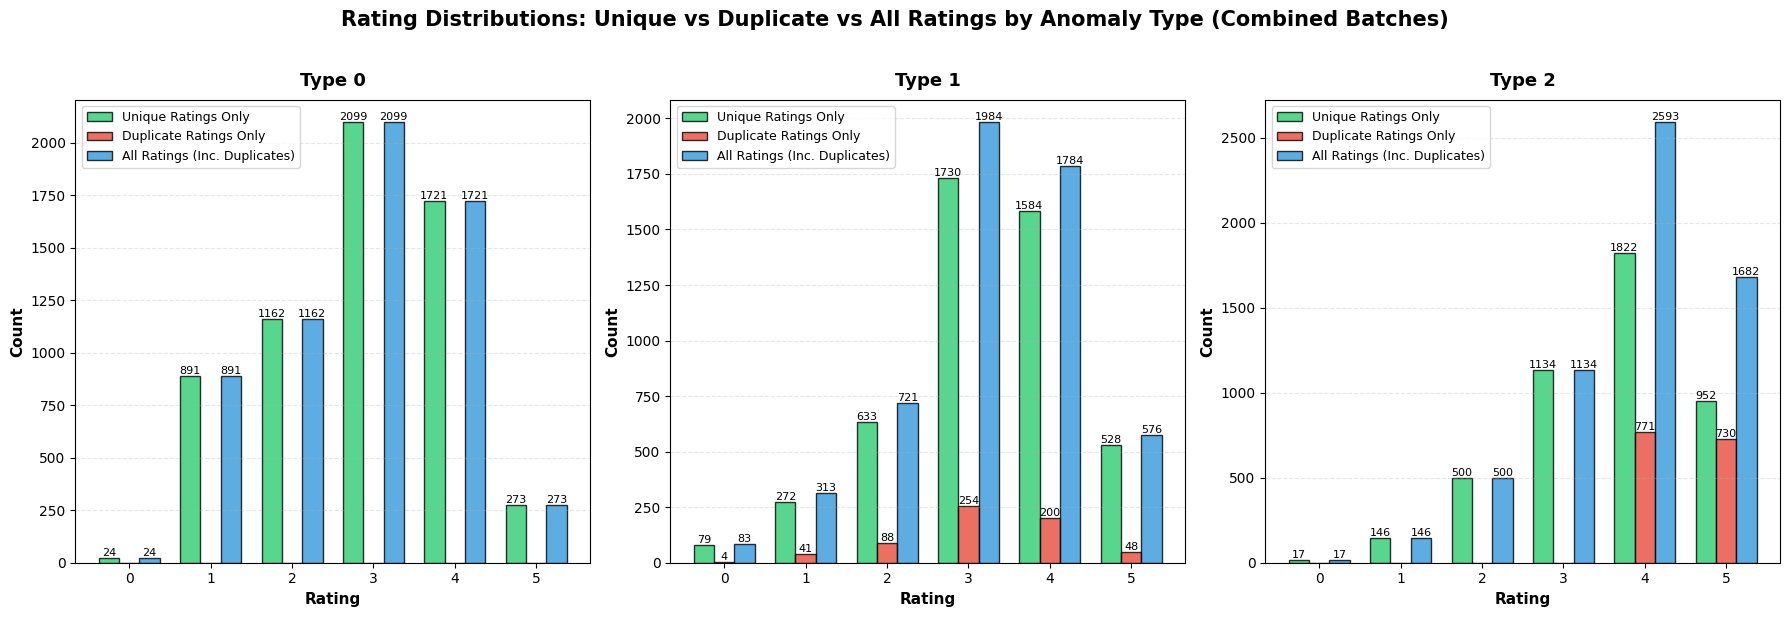


Summary:
Type 0: 6,170 unique ratings, 0 duplicate ratings, 6,170 total ratings
Type 1: 4,826 unique ratings, 635 duplicate ratings, 5,461 total ratings
Type 2: 4,571 unique ratings, 1,501 duplicate ratings, 6,072 total ratings


In [ ]:
# @title Compare All Ratings vs Duplicate Ratings
# For each anomaly type, compare ratings in 3 ways:
# 1. All ratings EXCLUDING duplicates (unique ratings only)
# 2. Duplicate ratings only
# 3. All ratings INCLUDING duplicates

# First, identify which ratings are duplicates
# A rating is a duplicate if the same (user, item) pair appears more than once
X_with_anom['is_duplicate'] = X_with_anom.duplicated(subset=['user', 'item'], keep=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Rating Distributions: Unique vs Duplicate vs All Ratings by Anomaly Type (Combined Batches)',
             fontsize=15, fontweight='bold', y=1.02)

for idx, anom_type in enumerate(sorted(X_with_anom['anomtype'].unique())):
    type_data = X_with_anom[X_with_anom['anomtype'] == anom_type]

    # Three sets of ratings
    unique_ratings = type_data[~type_data['is_duplicate']]['rating']  # Unique only (exclude duplicates)
    dup_ratings = type_data[type_data['is_duplicate']]['rating']      # Duplicates only
    all_ratings = type_data['rating']                                  # All ratings (includes duplicates)

    # Create grouped bar chart for better readability
    bins = [0, 1, 2, 3, 4, 5, 6]
    bin_labels = ['0', '1', '2', '3', '4', '5']

    # Count ratings in each bin for all three groups
    unique_counts, _ = np.histogram(unique_ratings, bins=bins)
    dup_counts, _ = np.histogram(dup_ratings, bins=bins)
    all_counts, _ = np.histogram(all_ratings, bins=bins)

    # Set up bar positions
    x = np.arange(len(bin_labels))
    width = 0.25

    # Create bars
    axes[idx].bar(x - width, unique_counts, width, label='Unique Ratings Only',
                  alpha=0.8, edgecolor='black', color='#2ecc71')
    axes[idx].bar(x, dup_counts, width, label='Duplicate Ratings Only',
                  alpha=0.8, edgecolor='black', color='#e74c3c')
    axes[idx].bar(x + width, all_counts, width, label='All Ratings (Inc. Duplicates)',
                  alpha=0.8, edgecolor='black', color='#3498db')

    axes[idx].set_title(f'Type {anom_type}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Rating', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Count', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(bin_labels)
    axes[idx].legend(loc='upper left', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y', linestyle='--')

    # Add value labels on bars for better readability
    for i, (u, d, a) in enumerate(zip(unique_counts, dup_counts, all_counts)):
        if u > 0:
            axes[idx].text(i - width, u, str(int(u)), ha='center', va='bottom', fontsize=8)
        if d > 0:
            axes[idx].text(i, d, str(int(d)), ha='center', va='bottom', fontsize=8)
        if a > 0:
            axes[idx].text(i + width, a, str(int(a)), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics for clarity
print("\nSummary:")
for anom_type in sorted(X_with_anom['anomtype'].unique()):
    type_data = X_with_anom[X_with_anom['anomtype'] == anom_type]
    n_unique = (~type_data['is_duplicate']).sum()
    n_dup = type_data['is_duplicate'].sum()
    n_total = len(type_data)
    print(f"Type {anom_type}: {n_unique:,} unique ratings, {n_dup:,} duplicate ratings, {n_total:,} total ratings")

## Anomaly Level vs Rating Pattern Analysis

Analyzing the relationship between each user's anomaly level (label_y) and their rating behavior patterns.

Analysis 1: Anomaly Level vs Average Rating

Correlation between anomaly level and average rating: 0.0383


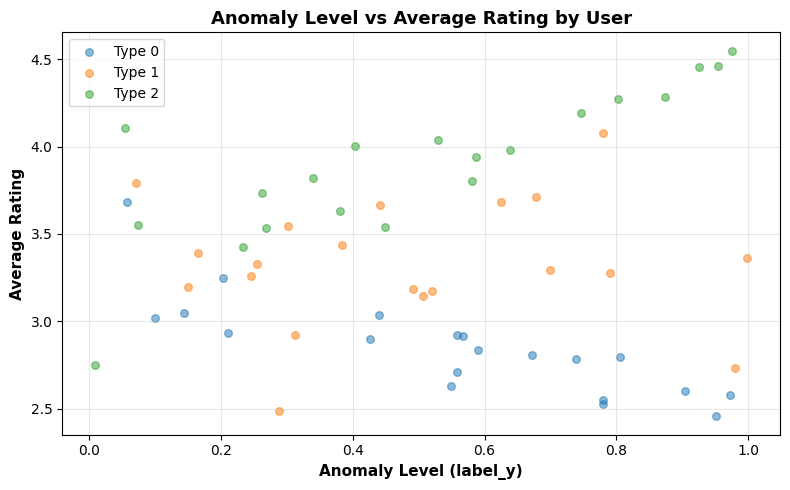


Average rating statistics by anomaly type:


label_y                            mean                        
            mean     std     min     max    mean     std     min     max
anomtype                                                                
0         0.5504  0.2866  0.0575  0.9721  2.8490  0.2843  2.4553  3.6816
1         0.4842  0.2716  0.0721  0.9987  3.3332  0.3672  2.4857  4.0782
2         0.5045  0.3071  0.0088  0.9760  3.9041  0.4321  2.7495  4.5498

In [ ]:
# @title Anomaly Level vs Average Rating
# Merge user-level features with ratings
print("=" * 80)
print("Analysis 1: Anomaly Level vs Average Rating")
print("=" * 80)

# Calculate correlation between anomaly level and mean rating
correlation = merged_all[['label_y', 'mean']].corr().iloc[0, 1]
print(f"\nCorrelation between anomaly level and average rating: {correlation:.4f}")

# Scatter plot colored by anomaly type
fig, ax = plt.subplots(figsize=(8, 5))

for anom_type in sorted(merged_all['anomtype'].unique()):
    type_data = merged_all[merged_all['anomtype'] == anom_type]
    ax.scatter(type_data['label_y'], type_data['mean'],
               alpha=0.5, label=f'Type {anom_type}', s=30)

ax.set_xlabel('Anomaly Level (label_y)', fontsize=11, fontweight='bold')
ax.set_ylabel('Average Rating', fontsize=11, fontweight='bold')
ax.set_title('Anomaly Level vs Average Rating by User', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics by anomaly type
print("\nAverage rating statistics by anomaly type:")
display(merged_all.groupby('anomtype')[['label_y', 'mean']].agg(['mean', 'std', 'min', 'max']).round(4))



Analysis 2: Anomaly Level vs Rating Variability (Std Dev)

Correlation between anomaly level and rating std dev: -0.0868


/tmp/ipython-input-1021338663.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_all, x='anomtype', y='std', ax=axes[1],


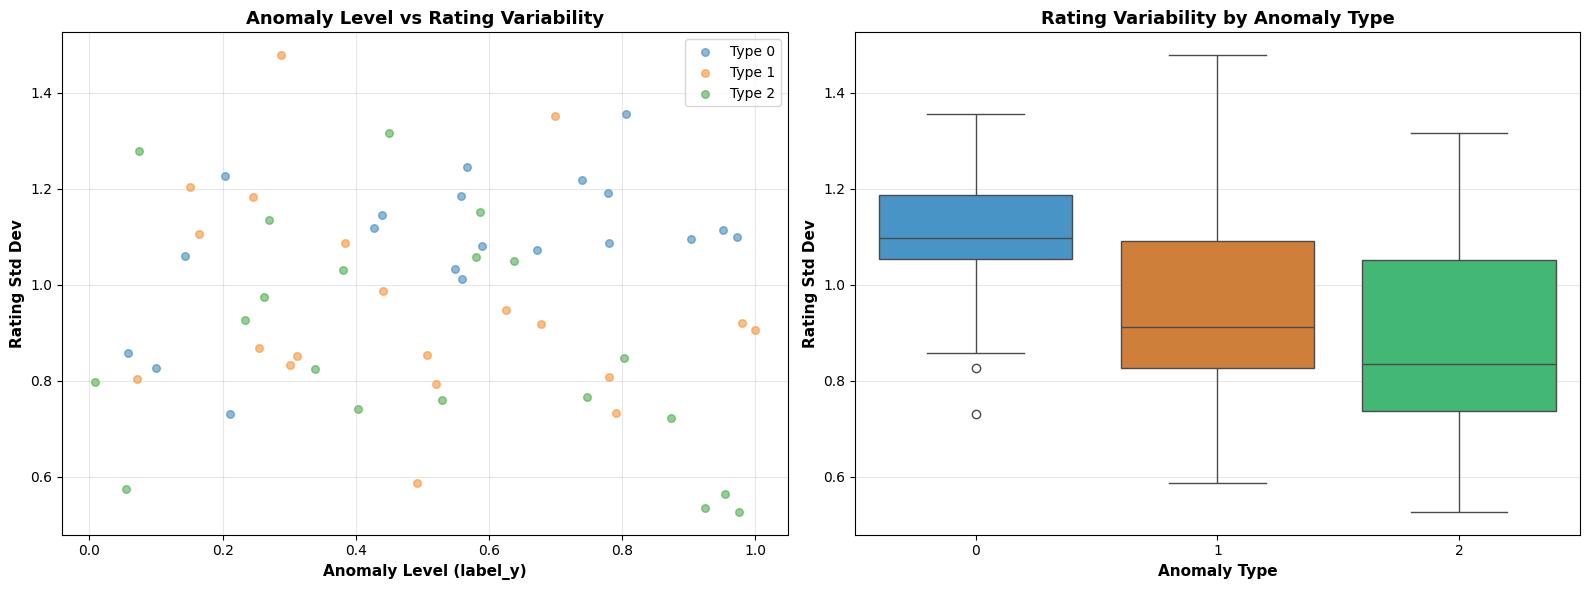


Interpretation: Lower std dev suggests more consistent/repetitive rating behavior,
which may indicate automated or manipulated patterns.


In [ ]:
# @title Anomaly Level vs Rating Variability
print("\n" + "=" * 80)
print("Analysis 2: Anomaly Level vs Rating Variability (Std Dev)")
print("=" * 80)

# Calculate correlation
correlation_std = merged_all[['label_y', 'std']].corr().iloc[0, 1]
print(f"\nCorrelation between anomaly level and rating std dev: {correlation_std:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
for anom_type in sorted(merged_all['anomtype'].unique()):
    type_data = merged_all[merged_all['anomtype'] == anom_type]
    axes[0].scatter(type_data['label_y'], type_data['std'],
                    alpha=0.5, label=f'Type {anom_type}', s=30)

axes[0].set_xlabel('Anomaly Level (label_y)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Rating Std Dev', fontsize=11, fontweight='bold')
axes[0].set_title('Anomaly Level vs Rating Variability', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by anomaly type
sns.boxplot(data=merged_all, x='anomtype', y='std', ax=axes[1],
            palette=['#3498db', '#e67e22', '#2ecc71'])
axes[1].set_xlabel('Anomaly Type', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Rating Std Dev', fontsize=11, fontweight='bold')
axes[1].set_title('Rating Variability by Anomaly Type', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nInterpretation: Lower std dev suggests more consistent/repetitive rating behavior,")
print("which may indicate automated or manipulated patterns.")


Analysis 3: Anomaly Level vs Duplicate Rate

Correlation between anomaly level and duplicate rate: 0.5240


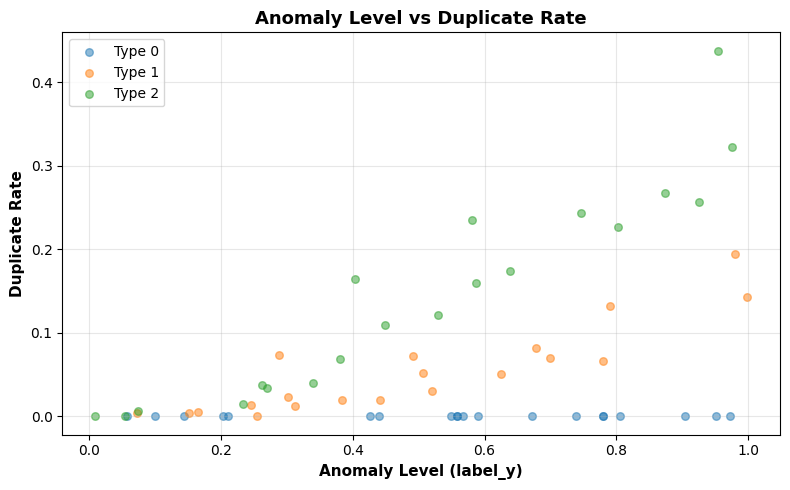

In [ ]:
# @title Anomaly Level vs Duplicate Rate
print("\n" + "=" * 80)
print("Analysis 3: Anomaly Level vs Duplicate Rate")
print("=" * 80)

# Calculate correlation
correlation_dup = merged_all[['label_y', 'dup_rate']].corr().iloc[0, 1]
print(f"\nCorrelation between anomaly level and duplicate rate: {correlation_dup:.4f}")

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 5))

for anom_type in sorted(merged_all['anomtype'].unique()):
    type_data = merged_all[merged_all['anomtype'] == anom_type]
    ax.scatter(type_data['label_y'], type_data['dup_rate'],
               alpha=0.5, label=f'Type {anom_type}', s=30)

ax.set_xlabel('Anomaly Level (label_y)', fontsize=11, fontweight='bold')
ax.set_ylabel('Duplicate Rate', fontsize=11, fontweight='bold')
ax.set_title('Anomaly Level vs Duplicate Rate', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Analysis 4: Anomaly Level vs Rating Skewness

Correlation between anomaly level and rating skewness: 0.0850

Note: Positive skew = more low ratings, Negative skew = more high ratings


/tmp/ipython-input-947687561.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_all, x='anomtype', y='skew', ax=axes[1],


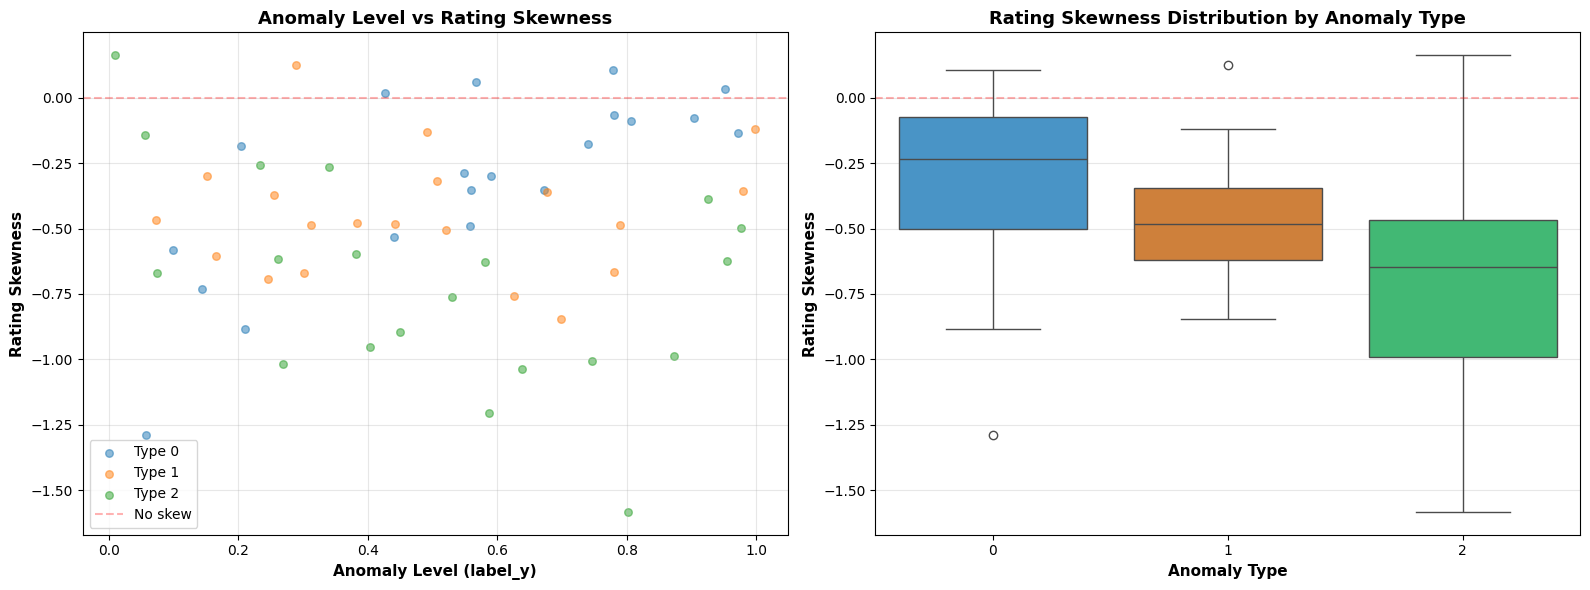


Skewness statistics by anomaly type:


count    mean     std     min     25%     50%     75%     max
anomtype                                                               
0          20.0 -0.3157  0.3546 -1.2893 -0.5010 -0.2352 -0.0746  0.1045
1          20.0 -0.4490  0.2345 -0.8466 -0.6191 -0.4814 -0.3466  0.1263
2          20.0 -0.6983  0.4062 -1.5826 -0.9905 -0.6480 -0.4693  0.1623

In [ ]:
# @title Anomaly Level vs Rating Skewness
print("\n" + "=" * 80)
print("Analysis 4: Anomaly Level vs Rating Skewness")
print("=" * 80)

# Calculate correlation
correlation_skew = merged_all[['label_y', 'skew']].corr().iloc[0, 1]
print(f"\nCorrelation between anomaly level and rating skewness: {correlation_skew:.4f}")
print("\nNote: Positive skew = more low ratings, Negative skew = more high ratings")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
for anom_type in sorted(merged_all['anomtype'].unique()):
    type_data = merged_all[merged_all['anomtype'] == anom_type]
    axes[0].scatter(type_data['label_y'], type_data['skew'],
                    alpha=0.5, label=f'Type {anom_type}', s=30)

axes[0].set_xlabel('Anomaly Level (label_y)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Rating Skewness', fontsize=11, fontweight='bold')
axes[0].set_title('Anomaly Level vs Rating Skewness', fontsize=13, fontweight='bold')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.3, label='No skew')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by anomaly type
sns.boxplot(data=merged_all, x='anomtype', y='skew', ax=axes[1],
            palette=['#3498db', '#e67e22', '#2ecc71'])
axes[1].set_xlabel('Anomaly Type', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Rating Skewness', fontsize=11, fontweight='bold')
axes[1].set_title('Rating Skewness Distribution by Anomaly Type', fontsize=13, fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSkewness statistics by anomaly type:")
display(merged_all.groupby('anomtype')['skew'].describe().round(4))


Analysis 5: Correlation Heatmap - Anomaly Level vs All Features


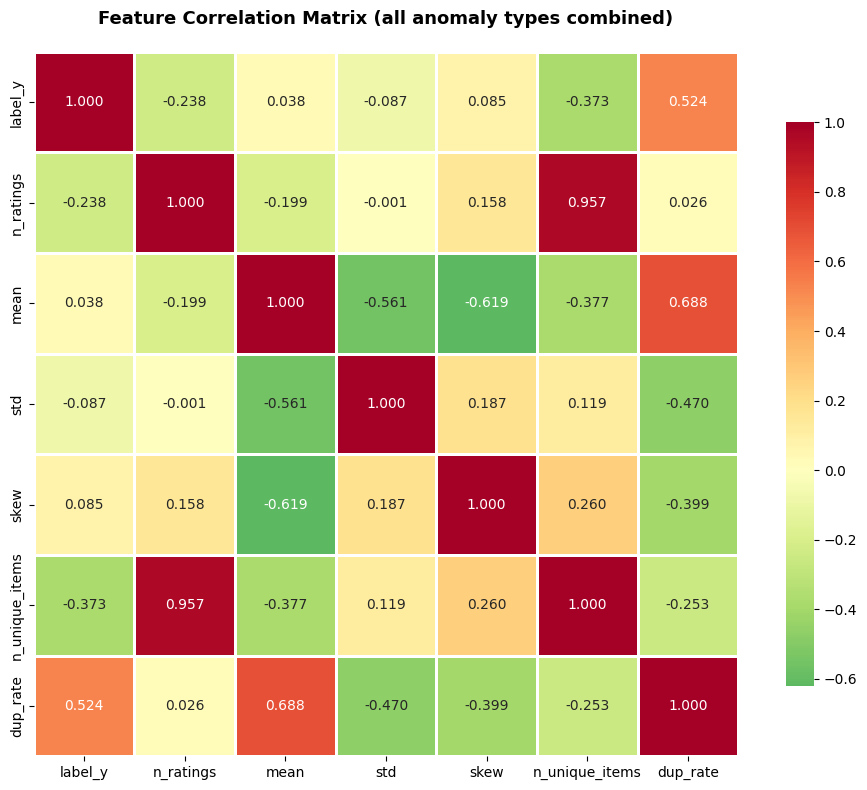


Correlations with Anomaly Level (label_y):
  dup_rate            :  0.5240
  skew                :  0.0850
  mean                :  0.0383
  std                 : -0.0868
  n_ratings           : -0.2384
  n_unique_items      : -0.3730


In [ ]:
# @title Correlation Matrix
print("\n" + "=" * 80)
print("Analysis 5: Correlation Heatmap - Anomaly Level vs All Features")
print("=" * 80)

# Select relevant features
features_for_corr = ['label_y', 'n_ratings', 'mean', 'std', 'skew', 'n_unique_items', 'dup_rate']
corr_matrix = merged_all[features_for_corr].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix (all anomaly types combined)',
             fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print correlations with label_y
print("\nCorrelations with Anomaly Level (label_y):")
label_corrs = corr_matrix['label_y'].drop('label_y').sort_values(ascending=False)
for feature, corr_val in label_corrs.items():
    print(f"  {feature:20s}: {corr_val:7.4f}")


Correlation Heatmaps by Anomaly Type


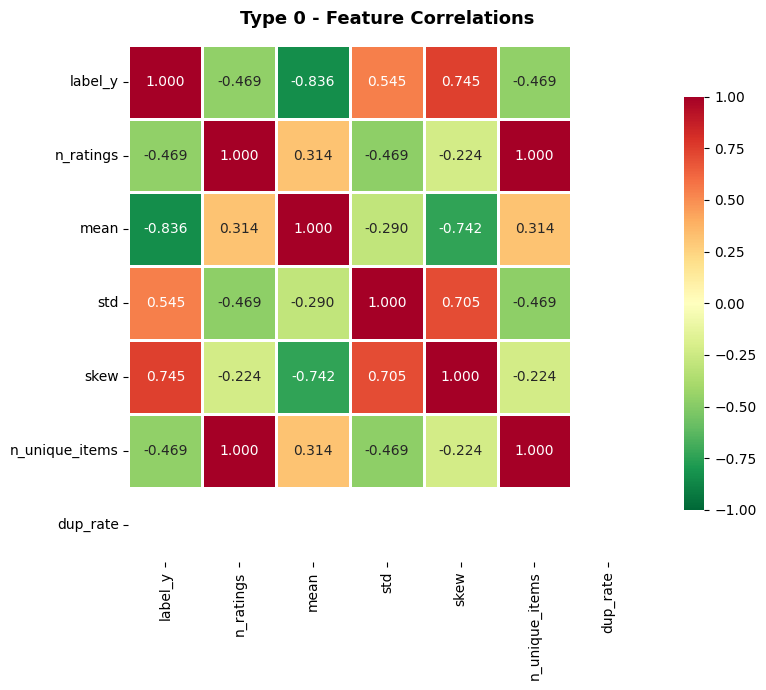

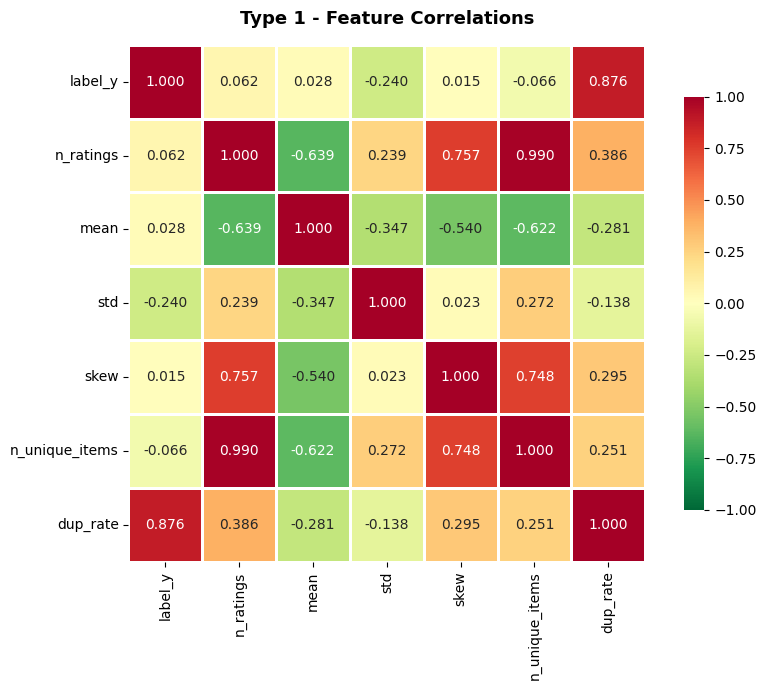

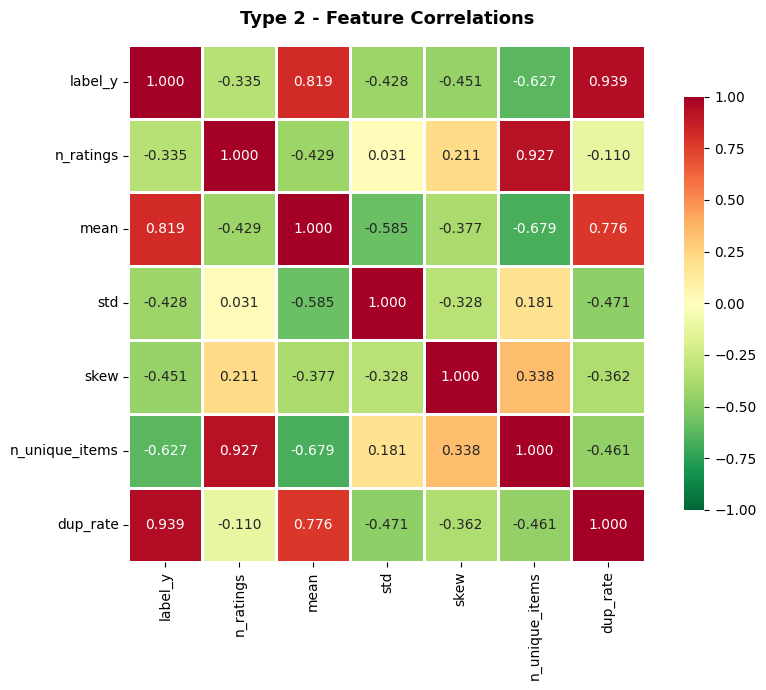

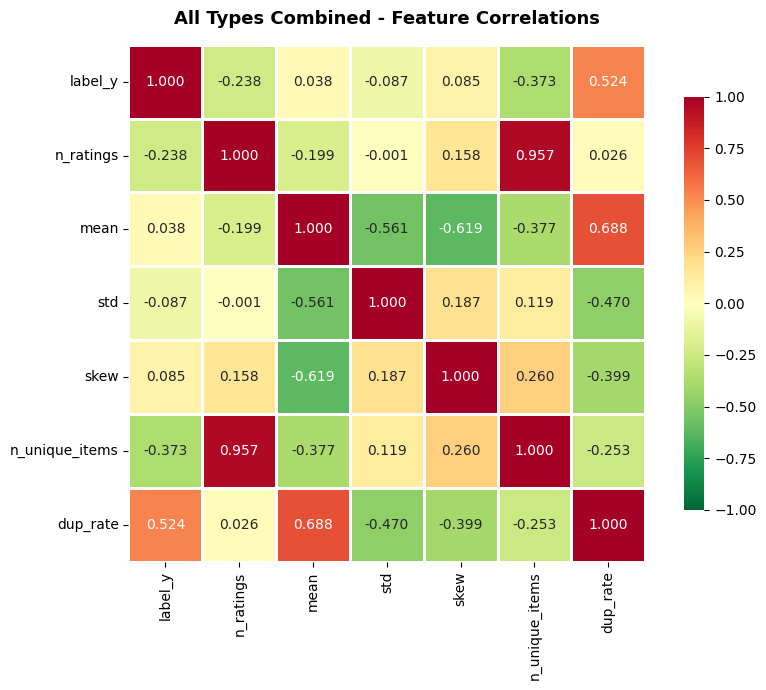


Comparison: Anomaly Level (label_y) Correlations Across Types


Type 0  Type 1  Type 2  All Combined
n_ratings      -0.4687  0.0618 -0.3349       -0.2384
mean           -0.8364  0.0284  0.8190        0.0383
std             0.5452 -0.2400 -0.4283       -0.0868
skew            0.7446  0.0145 -0.4508        0.0850
n_unique_items -0.4687 -0.0657 -0.6274       -0.3730
dup_rate           NaN  0.8759  0.9387        0.5240


--------------------------------------------------------------------------------
Strongest Anomaly Level Predictors by Type:
--------------------------------------------------------------------------------

Type 0:
  mean                : -0.8364
  skew                :  0.7446
  std                 :  0.5452

Type 1:
  dup_rate            :  0.8759
  std                 : -0.2400
  n_unique_items      : -0.0657

Type 2:
  dup_rate            :  0.9387
  mean                :  0.8190
  n_unique_items      : -0.6274


In [ ]:
# @title Correlation Matrix by Type
print("\n" + "=" * 80)
print("Correlation Heatmaps by Anomaly Type")
print("=" * 80)

# Features to include
features_for_corr = ['label_y', 'n_ratings', 'mean', 'std', 'skew', 'n_unique_items', 'dup_rate']

# Type 0 Heatmap - SEPARATE FIGURE
type_0_data = merged_all[merged_all['anomtype'] == 0][features_for_corr]
corr_0 = type_0_data.corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr_0, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Type 0 - Feature Correlations',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Type 1 Heatmap - SEPARATE FIGURE
type_1_data = merged_all[merged_all['anomtype'] == 1][features_for_corr]
corr_1 = type_1_data.corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr_1, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Type 1 - Feature Correlations',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Type 2 Heatmap - SEPARATE FIGURE
type_2_data = merged_all[merged_all['anomtype'] == 2][features_for_corr]
corr_2 = type_2_data.corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr_2, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Type 2 - Feature Correlations',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# All Types Combined Heatmap - SEPARATE FIGURE
corr_all = merged_all[features_for_corr].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr_all, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('All Types Combined - Feature Correlations',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Print comparison of label_y correlations across types
print("\n" + "=" * 80)
print("Comparison: Anomaly Level (label_y) Correlations Across Types")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Type 0': corr_0['label_y'].drop('label_y'),
    'Type 1': corr_1['label_y'].drop('label_y'),
    'Type 2': corr_2['label_y'].drop('label_y'),
    'All Combined': corr_all['label_y'].drop('label_y')
})

display(comparison_df.round(4))

# Identify strongest correlations for each type
print("\n" + "-" * 80)
print("Strongest Anomaly Level Predictors by Type:")
print("-" * 80)

for col in ['Type 0', 'Type 1', 'Type 2']:
    strongest = comparison_df[col].abs().sort_values(ascending=False)
    print(f"\n{col}:")
    for idx, val in strongest.head(3).items():
        print(f"  {idx:20s}: {comparison_df.loc[idx, col]:7.4f}")


# Data Transformation

In [ ]:
# @title Feature Engineering
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import entropy


def calculate_entropy(ratings):
    """Helper function to calculate Shannon entropy"""
    rating_counts = np.bincount(ratings.astype(int), minlength=6)[1:6]
    rating_probs = rating_counts[rating_counts > 0] / len(ratings)
    return entropy(rating_probs, base=2) if len(rating_probs) > 0 else 0


def create_duplicate_features(df):
    """
    Create features based on duplicate rating patterns

    Parameters:
    df : DataFrame with columns ['user', 'item', 'rating']

    Returns:
    df with additional duplicate-based features
    """

    # 1. Basic duplicate identification
    df['is_duplicate'] = df.duplicated(subset=['user', 'item'], keep=False).astype(int)

    # 2. Duplicate count per user-item pair
    df['duplicate_count'] = df.groupby(['user', 'item'])['user'].transform('count')

    # 3. Rating variance within duplicates (0 if same, >0 if different)
    df['duplicate_rating_variance'] = df.groupby(['user', 'item'])['rating'].transform('std').fillna(0)

    # 4. Is this a high-rating duplicate? (4-5 ratings)
    df['is_high_rating_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'] >= 4)).astype(int)

    # 5. Is this a mid-rating duplicate? (3-4 ratings)
    df['is_mid_rating_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'] >= 3) & (df['rating'] <= 4)).astype(int)

    # 6. Is this a low-rating duplicate? (1-2 ratings)
    df['is_low_rating_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'] <= 2)).astype(int)

    # 7. Is this ONLY a 4-5 duplicate? (Type 2 specific pattern)
    df['is_exclusive_high_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'].isin([4, 5]))).astype(int)

    return df


def create_user_duplicate_profile(df_features):
    """
    Create user-level features based on their duplicate behavior

    Parameters:
    df_features : DataFrame with row-level features including duplicate features

    Returns:
    DataFrame with user-level duplicate features (10 features)
    """

    duplicate_features = []

    for user_id, user_data in df_features.groupby('user'):
        n_ratings = len(user_data)

        # Basic duplicate statistics
        n_duplicates = user_data['is_duplicate'].sum()
        duplicate_ratio = n_duplicates / n_ratings if n_ratings > 0 else 0

        # Duplicate consistency (how often they give same rating when duplicating)
        avg_duplicate_variance = user_data[user_data['is_duplicate'] == 1]['duplicate_rating_variance'].mean()
        if pd.isna(avg_duplicate_variance):
            avg_duplicate_variance = 0

        # Average number of times they duplicate per item
        avg_duplicate_count = user_data[user_data['is_duplicate'] == 1]['duplicate_count'].mean()
        if pd.isna(avg_duplicate_count):
            avg_duplicate_count = 0

        # Rating distribution WITHIN duplicates
        duplicate_ratings = user_data[user_data['is_duplicate'] == 1]['rating']

        if len(duplicate_ratings) > 0:
            # Central tendency
            dup_rating_mean = duplicate_ratings.mean()
            dup_rating_std = duplicate_ratings.std()
            dup_rating_mode = duplicate_ratings.mode()[0] if len(duplicate_ratings.mode()) > 0 else 0

            # Range and diversity
            dup_rating_range = duplicate_ratings.max() - duplicate_ratings.min()
            dup_unique_ratings = duplicate_ratings.nunique()

            # Range-based percentages (KEY FEATURES)
            dup_pct_only_4_5 = (duplicate_ratings.isin([4, 5])).mean()  # Type 2 signature
            dup_pct_mid = ((duplicate_ratings >= 3) & (duplicate_ratings <= 4)).mean()  # Type 1 pattern
            dup_pct_low = (duplicate_ratings <= 2).mean()  # Low rating pattern

        else:
            # No duplicates - all zeros
            dup_rating_mean = 0
            dup_rating_std = 0
            dup_rating_mode = 0
            dup_rating_range = 0
            dup_unique_ratings = 0
            dup_pct_only_4_5 = 0
            dup_pct_mid = 0
            dup_pct_low = 0

        duplicate_features.append({
            'user': user_id,

            # Basic duplicate metrics (3 features)
            'duplicate_ratio': duplicate_ratio,
            'avg_duplicate_variance': avg_duplicate_variance,
            'avg_duplicate_count': avg_duplicate_count,

            # Duplicate rating distribution (5 features)
            'dup_rating_mean': dup_rating_mean,
            'dup_rating_std': dup_rating_std,
            'dup_rating_mode': dup_rating_mode,
            'dup_rating_range': dup_rating_range,
            'dup_unique_ratings': dup_unique_ratings,

            # Range-based percentages (3 features) - KEY for classification
            'dup_pct_only_4_5': dup_pct_only_4_5,  # Type 2 detector
            'dup_pct_mid_rating': dup_pct_mid,      # Type 1 pattern
            'dup_pct_low_rating': dup_pct_low,      # Low rating pattern
        })

    return pd.DataFrame(duplicate_features)


def create_comprehensive_features_train(df):
    """
    Create features for TRAINING data.
    Returns features AND item/global statistics for use on test data.

    Parameters:
    df : DataFrame with columns ['user', 'item', 'rating']

    Returns:
    df_features : DataFrame with all features
    item_stats : DataFrame with item statistics (to apply to test)
    global_stats : Dict with global statistics (to fill unseen items in test)
    """

    df = df.copy()

    print(f"Creating features for TRAINING data ({len(df)} rows, {df['user'].nunique()} users)")

    # ============ DUPLICATE FEATURES (ADD FIRST) ============
    print("Creating duplicate-based features...")
    df = create_duplicate_features(df)

    # ============ Global Z-Score (FREEZE training statistics - NO LEAKAGE) ============
    global_mean = df['rating'].mean()
    global_std = df['rating'].std()
    df['global_zscore'] = (df['rating'] - global_mean) / global_std
    print(f"  Global mean: {global_mean:.3f}, Global std: {global_std:.3f}")

    # ============ Per User Features (Safe - No Leakage) ============
    user_stats = df.groupby('user')['rating'].agg([
        ('user_mean', 'mean'),
        ('user_std', 'std'),
        ('user_skew', lambda x: stats.skew(x)),
        ('user_min', 'min'),
        ('user_max', 'max'),
        ('user_count', 'count')
    ]).reset_index()

    # Calculate user z-score (per-user, using each user's OWN mean/std)
    user_zscore_list = []
    for user_id, user_data in df.groupby('user'):
        user_mean_val = user_data['rating'].mean()
        user_std_val = user_data['rating'].std()
        if user_std_val > 0:
            z_scores = (user_data['rating'] - user_mean_val) / user_std_val
        else:
            z_scores = pd.Series(0, index=user_data.index)
        user_zscore_list.append(pd.DataFrame({
            'user_zscore': z_scores
        }, index=user_data.index))

    user_zscore = pd.concat(user_zscore_list)

    df = df.merge(user_stats, on='user', how='left')
    df = df.merge(user_zscore, left_index=True, right_index=True, how='left')

    # ============ Per Item Features (Calculate from TRAINING only) ============
    print(f"Calculating item statistics from TRAINING data...")

    item_stats = df.groupby('item')['rating'].agg([
        ('item_mean', 'mean'),
        ('item_std', 'std'),
        ('item_skew', lambda x: stats.skew(x)),
        ('item_min', 'min'),
        ('item_max', 'max'),
        ('item_count', 'count')
    ]).reset_index()

    print(f"  Found {len(item_stats)} unique items in training")

    # Calculate item z-score using frozen item statistics
    item_zscore_list = []
    for item_id, item_data in df.groupby('item'):
        item_mean_val = item_data['rating'].mean()
        item_std_val = item_data['rating'].std()
        if item_std_val > 0:
            z_scores = (item_data['rating'] - item_mean_val) / item_std_val
        else:
            z_scores = pd.Series(0, index=item_data.index)
        item_zscore_list.append(pd.DataFrame({
            'item_zscore': z_scores
        }, index=item_data.index))

    item_zscore = pd.concat(item_zscore_list)

    df = df.merge(item_stats, on='item', how='left')
    df = df.merge(item_zscore, left_index=True, right_index=True, how='left')

    # ============ Global Statistics (for filling unseen items in test) ============
    global_stats = {
        'global_mean': global_mean,
        'global_std': global_std,
        'global_skew': stats.skew(df['rating']),
        'global_min': df['rating'].min(),
        'global_max': df['rating'].max()
    }

    print(f"  Global mean: {global_stats['global_mean']:.3f}")

    # ============ Additional Row-Level Features ============
    df['zscore_product'] = df['global_zscore'] * df['item_zscore']

    df['user_below_3'] = (df['rating'] < 3).astype(int)
    df['user_above_3'] = (df['rating'] > 3).astype(int)
    df['item_below_3'] = (df['item_mean'] < 3).astype(int)
    df['item_above_3'] = (df['item_mean'] > 3).astype(int)
    df['contrarian'] = ((df['user_below_3'] & df['item_above_3']) |
                        (df['user_above_3'] & df['item_below_3'])).astype(int)

    df['is_extreme'] = ((df['rating'] == 1) | (df['rating'] == 5)).astype(int)

    # ============ Smart NaN Filling ============
    df['user_std'] = df['user_std'].fillna(0)
    df['item_std'] = df['item_std'].fillna(0)

    df['user_skew'] = df['user_skew'].fillna(global_stats['global_skew'])
    df['item_skew'] = df['item_skew'].fillna(global_stats['global_skew'])

    df['user_zscore'] = df['user_zscore'].fillna(0)
    df['item_zscore'] = df['item_zscore'].fillna(0)

    df = df.fillna(0)

    print(f"✓ Training features created successfully")

    return df, item_stats, global_stats


def create_comprehensive_features_test(df, item_stats, global_stats):
    """
    Create features for TEST data using TRAINING statistics.

    Parameters:
    df : DataFrame with columns ['user', 'item', 'rating']
    item_stats : DataFrame with item statistics from TRAINING
    global_stats : Dict with global statistics from TRAINING

    Returns:
    df_features : DataFrame with all features
    """

    df = df.copy()

    print(f"\nCreating features for TEST data ({len(df)} rows, {df['user'].nunique()} users)")
    print(f"Using statistics from TRAINING data...")

    # ============ DUPLICATE FEATURES (ADD FIRST) ============
    print("Creating duplicate-based features...")
    df = create_duplicate_features(df)

    # ============ Global Z-Score (Use TRAINING global mean/std - NO LEAKAGE) ============
    df['global_zscore'] = (df['rating'] - global_stats['global_mean']) / global_stats['global_std']
    print(f"  Using training global mean: {global_stats['global_mean']:.3f}, std: {global_stats['global_std']:.3f}")

    # ============ Per User Features (Safe - No Leakage) ============
    user_stats = df.groupby('user')['rating'].agg([
        ('user_mean', 'mean'),
        ('user_std', 'std'),
        ('user_skew', lambda x: stats.skew(x)),
        ('user_min', 'min'),
        ('user_max', 'max'),
        ('user_count', 'count')
    ]).reset_index()

    # Calculate user z-score (per-user, using each user's OWN mean/std)
    user_zscore_list = []
    for user_id, user_data in df.groupby('user'):
        user_mean_val = user_data['rating'].mean()
        user_std_val = user_data['rating'].std()
        if user_std_val > 0:
            z_scores = (user_data['rating'] - user_mean_val) / user_std_val
        else:
            z_scores = pd.Series(0, index=user_data.index)
        user_zscore_list.append(pd.DataFrame({
            'user_zscore': z_scores
        }, index=user_data.index))

    user_zscore = pd.concat(user_zscore_list)

    df = df.merge(user_stats, on='user', how='left')
    df = df.merge(user_zscore, left_index=True, right_index=True, how='left')

    # ============ Per Item Features (Use TRAINING statistics!) ============
    df = df.merge(item_stats, on='item', how='left')

    # Check for unseen items
    unseen_items_mask = df['item_mean'].isna()
    n_unseen = unseen_items_mask.sum()

    if n_unseen > 0:
        n_unseen_items = df[unseen_items_mask]['item'].nunique()
        print(f"  ⚠️  Found {n_unseen} ratings for {n_unseen_items} items NOT in training")
        print(f"     Filling with training global statistics...")

    # Fill unseen items with global statistics from TRAINING
    df.loc[unseen_items_mask, 'item_mean'] = global_stats['global_mean']
    df.loc[unseen_items_mask, 'item_std'] = global_stats['global_std']
    df.loc[unseen_items_mask, 'item_skew'] = global_stats['global_skew']
    df.loc[unseen_items_mask, 'item_min'] = global_stats['global_min']
    df.loc[unseen_items_mask, 'item_max'] = global_stats['global_max']
    df.loc[unseen_items_mask, 'item_count'] = 0

    # Calculate item z-score using TRAINING item_mean and item_std
    df['item_zscore'] = df.apply(
        lambda row: (row['rating'] - row['item_mean']) / row['item_std']
                    if row['item_std'] > 0 else 0,
        axis=1
    )

    # ============ Additional Row-Level Features ============
    df['zscore_product'] = df['global_zscore'] * df['item_zscore']

    df['user_below_3'] = (df['rating'] < 3).astype(int)
    df['user_above_3'] = (df['rating'] > 3).astype(int)
    df['item_below_3'] = (df['item_mean'] < 3).astype(int)
    df['item_above_3'] = (df['item_mean'] > 3).astype(int)
    df['contrarian'] = ((df['user_below_3'] & df['item_above_3']) |
                        (df['user_above_3'] & df['item_below_3'])).astype(int)

    df['is_extreme'] = ((df['rating'] == 1) | (df['rating'] == 5)).astype(int)

    # ============ Smart NaN Filling ============
    df['user_std'] = df['user_std'].fillna(0)
    df['item_std'] = df['item_std'].fillna(0)

    df['user_skew'] = df['user_skew'].fillna(global_stats['global_skew'])
    df['item_skew'] = df['item_skew'].fillna(global_stats['global_skew'])

    df['user_zscore'] = df['user_zscore'].fillna(0)
    df['item_zscore'] = df['item_zscore'].fillna(0)

    df = df.fillna(0)

    print(f"✓ Test features created successfully")

    return df


def aggregate_to_user_level(df_features):
    """
    Aggregate row-level features to user level

    Parameters:
    df_features : DataFrame with row-level features

    Returns:
    df_user_level : DataFrame with user-level aggregated features
    """

    # Calculate user-level features
    new_features_list = []

    for user_id, user_data in df_features.groupby('user'):
        ratings = user_data['rating'].values

        # Original features
        rating_entropy = calculate_entropy(ratings)
        rating_mode = np.bincount(ratings.astype(int)).argmax()
        extreme_rating_ratio = user_data['is_extreme'].mean()
        contrarian_score = user_data['contrarian'].mean()
        zscore_product_mean = user_data['zscore_product'].mean()
        user_count = len(ratings)
        entropy_x_count = rating_entropy * user_count

        new_features_list.append({
            'user': user_id,
            'rating_entropy': rating_entropy,
            'rating_mode': rating_mode,
            'extreme_rating_ratio': extreme_rating_ratio,
            'contrarian_score': contrarian_score,
            'zscore_product_mean': zscore_product_mean,
            'entropy_x_count': entropy_x_count
        })

    new_features_df = pd.DataFrame(new_features_list)

    # Define aggregation strategy
    features_with_std = [
        'global_zscore', 'user_zscore', 'item_mean', 'item_std', 'item_zscore',
        'item_skew', 'item_min', 'item_max', 'item_count'
    ]

    all_features = df_features.select_dtypes(include=['number']).columns.tolist()
    features_mean_only = [f for f in all_features if f not in features_with_std]

    # Build aggregation dictionary
    agg_dict = {}
    for feat in features_mean_only:
        agg_dict[feat] = 'mean'
    for feat in features_with_std:
        agg_dict[feat] = ['mean', 'std']

    # Aggregate
    user_agg = df_features.groupby('user').agg(agg_dict).reset_index()
    user_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                       for col in user_agg.columns.values]

    # Merge with new features
    user_agg = user_agg.merge(new_features_df, on='user', how='left')

    # ============ ADD DUPLICATE PROFILE ============
    print("Creating user duplicate profile...")
    duplicate_profile = create_user_duplicate_profile(df_features)

    # Merge with existing user_agg
    user_agg = user_agg.merge(duplicate_profile, on='user', how='left')

    # Fill NaN for users with no duplicates
    duplicate_cols = [col for col in duplicate_profile.columns if col != 'user']
    user_agg[duplicate_cols] = user_agg[duplicate_cols].fillna(0)

    # Drop redundant columns
    cols_to_drop = [col for col in user_agg.columns
                   if col in ['user_mean', 'rating_mean', 'item_mean']]
    if cols_to_drop:
        user_agg = user_agg.drop(columns=cols_to_drop)

    print(f"✓ Aggregation complete. Total features: {len(user_agg.columns) - 1} (excluding 'user')")

    return user_agg

In [ ]:
# @title Transforming X for CV training/hyperparameter tuning (Train Test Split 80:20)
# ============================================
# STEP 1: Split USERS into train/test (80:20)
# ============================================
from sklearn.model_selection import train_test_split

# Get unique users
all_users = y['user'].unique()  # 1800 users
print(f"Total users: {len(all_users)}")

# Split users
train_users, test_users = train_test_split(
    all_users,
    test_size=0.2,
    random_state=42
)

print(f"Train users: {len(train_users)} ({len(train_users)/len(all_users)*100:.1f}%)")
print(f"Test users: {len(test_users)} ({len(test_users)/len(all_users)*100:.1f}%)")

# ============================================
# STEP 2: Split RAW RATING DATA by users
# ============================================

# X is your original ratings DataFrame with columns ['user', 'item', 'rating']
X_train_raw = X[X['user'].isin(train_users)].copy()
X_test_raw = X[X['user'].isin(test_users)].copy()

print(f"\nTrain ratings: {len(X_train_raw)}")
print(f"Test ratings: {len(X_test_raw)}")

# ============================================
# STEP 3: Apply feature engineering separately
# ============================================

print("\n" + "="*70)
print("STEP 3: FEATURE ENGINEERING (NO LEAKAGE)")
print("="*70)

# TRAIN: Calculate features and statistics from train data ONLY
X_train_features, item_stats_train, global_stats_train = create_comprehensive_features_train(X_train_raw)
X_train_grouped = aggregate_to_user_level(X_train_features)

# TEST: Use TRAIN statistics to create test features
X_test_features = create_comprehensive_features_test(X_test_raw, item_stats_train, global_stats_train)
X_test_grouped = aggregate_to_user_level(X_test_features)

# ============================================
# STEP 4: Merge with labels
# ============================================

# Split labels
y_train_labels = y[y['user'].isin(train_users)].copy()
y_test_labels = y[y['user'].isin(test_users)].copy()

# Merge features with labels
X_train_final = X_train_grouped.merge(y_train_labels, on='user', how='left')
X_test_final = X_test_grouped.merge(y_test_labels, on='user', how='left')

print(f"\nTrain features shape: {X_train_final.shape}")
print(f"Test features shape: {X_test_final.shape}")

# ============================================
# STEP 5: Prepare final X and y + DROP FEATURES
# ============================================

# Define REDUNDANT features to drop (10 features)
REDUNDANT_FEATURES = [
    # Duplicate helper features (7 features) - redundant with duplicate_profile features
    'is_duplicate_mean',
    'duplicate_count_mean',
    'duplicate_rating_variance_mean',
    'is_high_rating_duplicate_mean',
    'is_mid_rating_duplicate_mean',
    'is_low_rating_duplicate_mean',
    'is_exclusive_high_duplicate_mean',

    # Duplicate columns from merge (3 features)
    # 'zscore_product_mean_x',   # Keep zscore_product_mean_y
    # 'contrarian_mean',          # Keep contrarian_score
    # 'is_extreme_mean',          # Keep extreme_rating_ratio

    # Redundant columns (2 features)
    # 'item_max_mean',
    # 'item_max_std'
]

# ============================================
# MANUAL FEATURE REMOVAL (Low Importance Features)
# Add features here that you want to remove based on SHAP analysis
# or other feature importance metrics
# ============================================
MANUAL_FEATURES_TO_REMOVE = [
    # 'dup_rating_mode',
    # 'dup_unique_ratings',
    # 'dup_rating_range',
    # 'item_below_3_mean',
    # 'dup_pct_low_rating',
    # 'entropy_x_count',
    # 'dup_pct_mid_rating',
    # 'item_std_mean',
    # 'avg_duplicate_variance',
    # 'item_std_std',
    # 'user_min_mean',
    # 'item_above_3_mean',
    # 'item_min_std',
    # 'user_max_mean',
    # 'item_min_mean',
    # 'rating_mode',
    # 'user_zscore_std',
    # 'user_zscore_mean',
    # 'item_max_std',
    # 'item_max_mean'
]

# Combine all features to drop
ALL_FEATURES_TO_DROP = REDUNDANT_FEATURES + MANUAL_FEATURES_TO_REMOVE

print("\n" + "="*70)
print("REMOVING FEATURES")
print("="*70)
print(f"Dropping {len(REDUNDANT_FEATURES)} redundant features:")
for feat in REDUNDANT_FEATURES:
    print(f"  • {feat}")

if MANUAL_FEATURES_TO_REMOVE:
    print(f"\nDropping {len(MANUAL_FEATURES_TO_REMOVE)} manually selected features:")
    for feat in MANUAL_FEATURES_TO_REMOVE:
        print(f"  • {feat}")
else:
    print("\nNo manually selected features to drop.")

print(f"\nTotal features to drop: {len(ALL_FEATURES_TO_DROP)}")

# Drop 'user', 'label', and all features to remove
X_train = X_train_final.drop(['user', 'label'] + ALL_FEATURES_TO_DROP, axis=1, errors='ignore')
y_train = X_train_final['label']

X_test = X_test_final.drop(['user', 'label'] + ALL_FEATURES_TO_DROP, axis=1, errors='ignore')
y_test = X_test_final['label']

# Handle any column mismatches (if test has missing columns)
# Ensure X_test has same columns as X_train
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Fill missing columns with 0

extra_cols = set(X_test.columns) - set(X_train.columns)
if extra_cols:
    X_test = X_test.drop(columns=list(extra_cols))

# Reorder columns to match
X_test = X_test[X_train.columns]

print("\n" + "="*70)
print("FINAL TRAIN/TEST SPLIT (NO LEAKAGE)")
print("="*70)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nFeatures match: {list(X_train.columns) == list(X_test.columns)}")
print(f"Number of features: {len(X_train.columns)}")
print(f"✓ Reduced from 37 to {len(X_train.columns)} features (removed {len(ALL_FEATURES_TO_DROP)} total)")
print(f"  - {len(REDUNDANT_FEATURES)} redundant features")
print(f"  - {len(MANUAL_FEATURES_TO_REMOVE)} manually selected features")

# ============================================
# VERIFICATION: Check for data leakage
# ============================================

print("\n" + "="*70)
print("LEAKAGE CHECK")
print("="*70)

# Check user overlap (should be 0)
train_user_set = set(train_users)
test_user_set = set(test_users)
overlap_users = train_user_set & test_user_set

print(f"User overlap: {len(overlap_users)} (should be 0)")

if len(overlap_users) == 0:
    print("✓ No user overlap - split is clean!")
else:
    print("❌ WARNING: Users appear in both train and test!")

# Check item overlap (this is OK and expected)
train_items = set(X_train_raw['item'].unique())
test_items = set(X_test_raw['item'].unique())
item_overlap = train_items & test_items

print(f"\nItem overlap: {len(item_overlap)}/{len(test_items)} "
      f"({len(item_overlap)/len(test_items)*100:.1f}%)")
print("(Item overlap is expected and OK)")

# ============================================
# FEATURE SUMMARY
# ============================================

print("\n" + "="*70)
print("FEATURE SUMMARY")
print("="*70)
print(f"Final feature set: {len(X_train.columns)} features")
print("\nAll features:")
for i, feat in enumerate(X_train.columns, 1):
    print(f"  {i}. {feat}")

Total users: 3600
Train users: 2880 (80.0%)
Test users: 720 (20.0%)

Train ratings: 917201
Test ratings: 227541

STEP 3: FEATURE ENGINEERING (NO LEAKAGE)
Creating features for TRAINING data (917201 rows, 2880 users)
Creating duplicate-based features...
  Global mean: 3.363, Global std: 1.163
Calculating item statistics from TRAINING data...
  Found 1000 unique items in training
  Global mean: 3.363
✓ Training features created successfully
Creating user duplicate profile...
✓ Aggregation complete. Total features: 55 (excluding 'user')

Creating features for TEST data (227541 rows, 720 users)
Using statistics from TRAINING data...
Creating duplicate-based features...
  Using training global mean: 3.363, std: 1.163
✓ Test features created successfully
Creating user duplicate profile...
✓ Aggregation complete. Total features: 55 (excluding 'user')

Train features shape: (2880, 57)
Test features shape: (720, 57)

REMOVING FEATURES
Dropping 7 redundant features:
  • is_duplicate_mean
  • dup

CORRELATION MATRIX ANALYSIS

Correlation matrix shape: (48, 48)
Total feature pairs: 1128


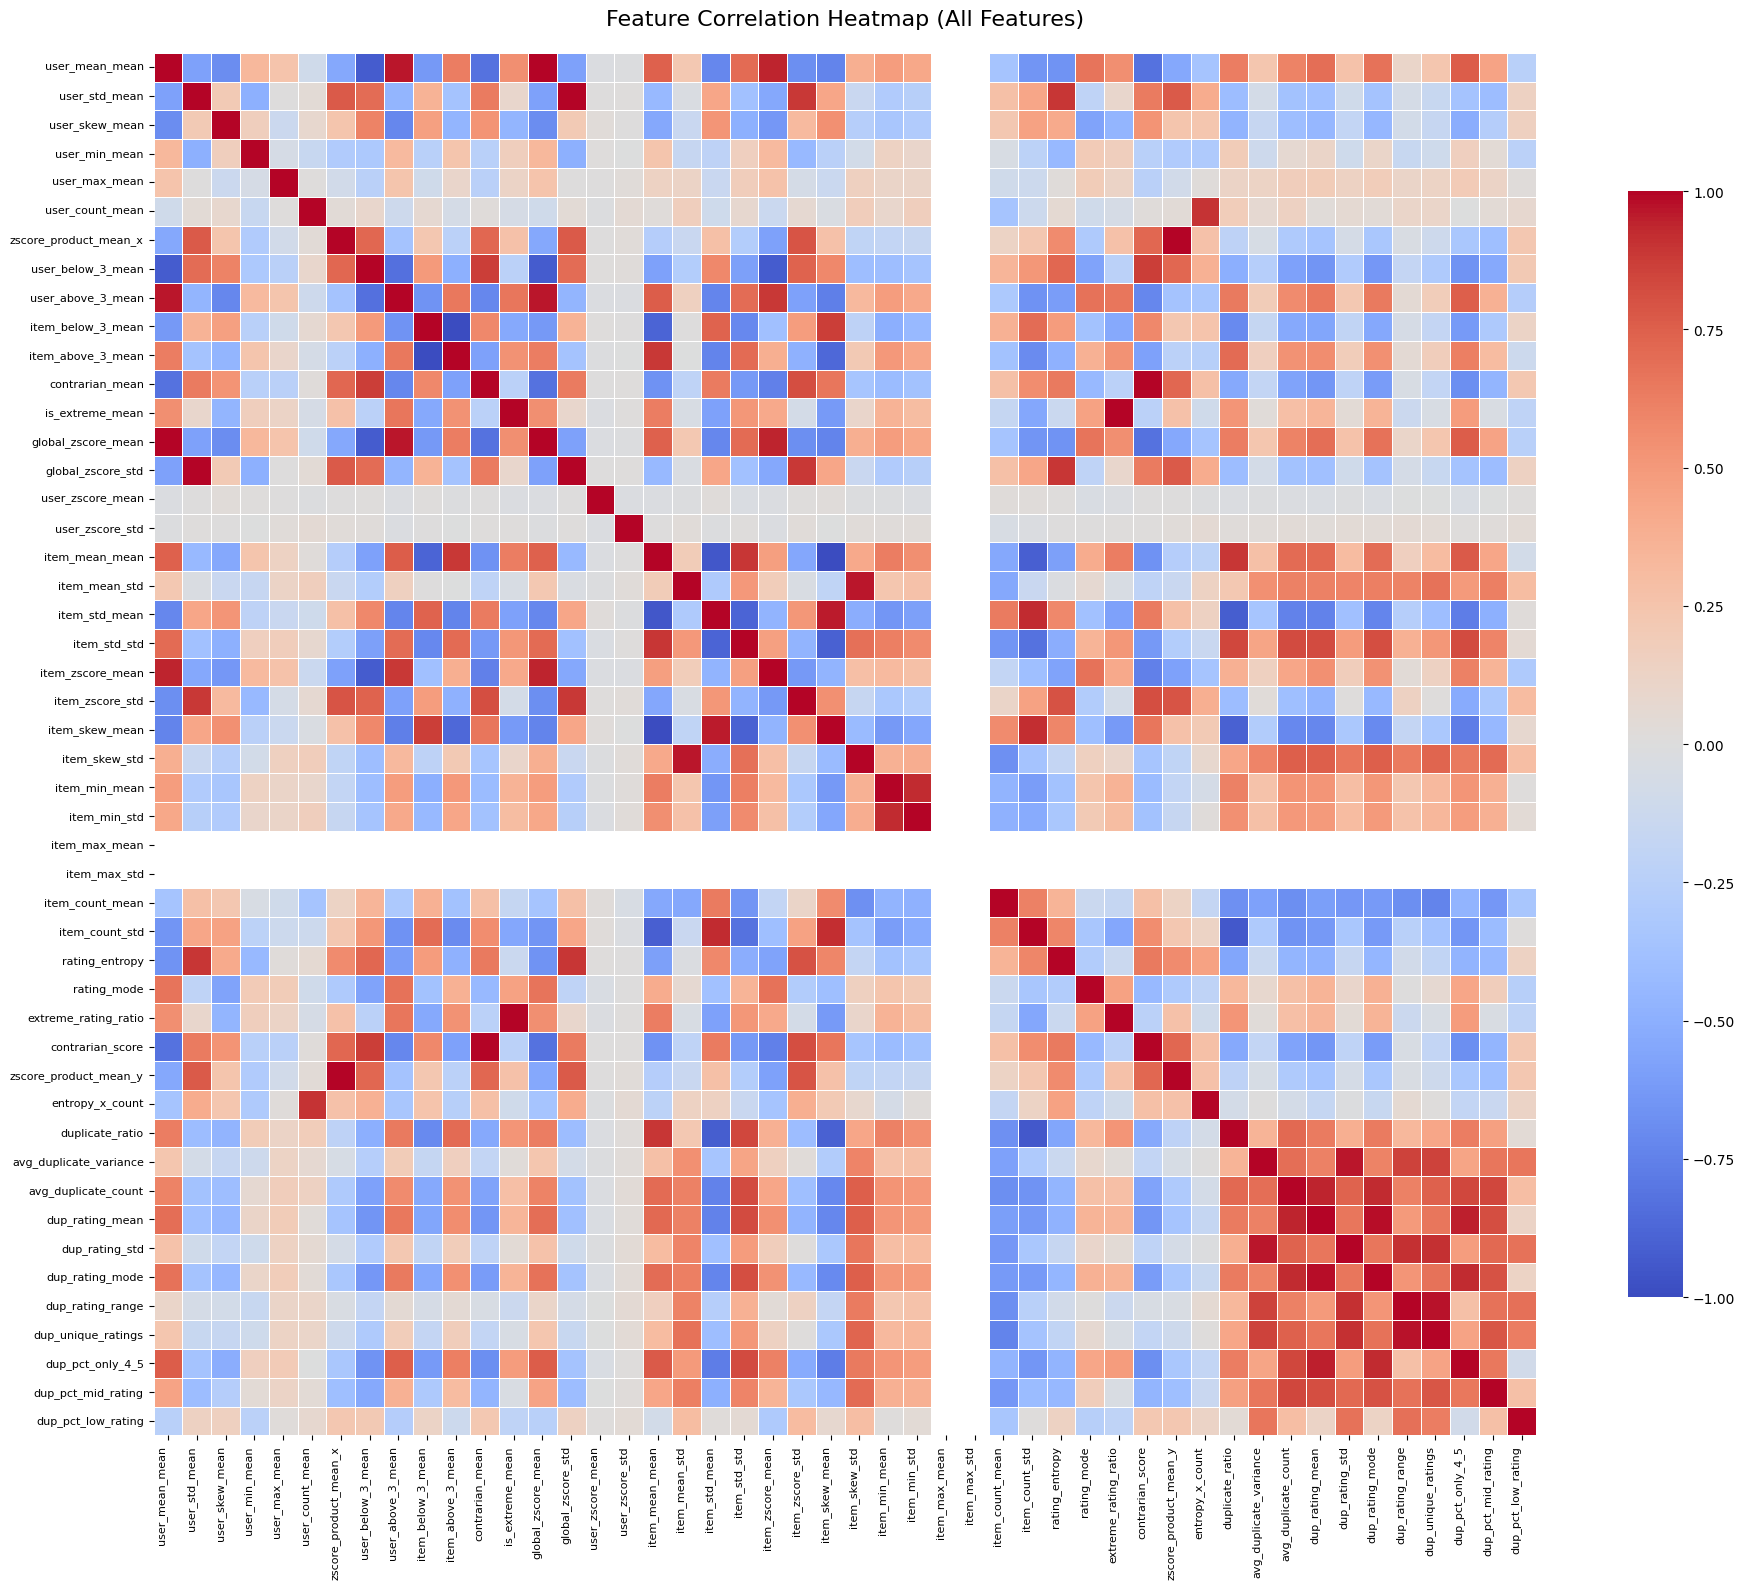


HIGH CORRELATION PAIRS (|correlation| > 0.7)

Found 131 feature pairs with |correlation| > 0.7:

global_zscore_mean             <-> user_mean_mean                  |  r =  1.0000
global_zscore_std              <-> user_std_mean                   |  r =  1.0000
contrarian_score               <-> contrarian_mean                 |  r =  1.0000
extreme_rating_ratio           <-> is_extreme_mean                 |  r =  1.0000
zscore_product_mean_y          <-> zscore_product_mean_x           |  r =  1.0000
item_above_3_mean              <-> item_below_3_mean               |  r = -0.9999
item_skew_mean                 <-> item_mean_mean                  |  r = -0.9982
dup_rating_mode                <-> dup_rating_mean                 |  r =  0.9811
dup_unique_ratings             <-> dup_rating_range                |  r =  0.9721
item_skew_std                  <-> item_mean_std                   |  r =  0.9641
global_zscore_mean             <-> user_above_3_mean               |  r =  0.9633


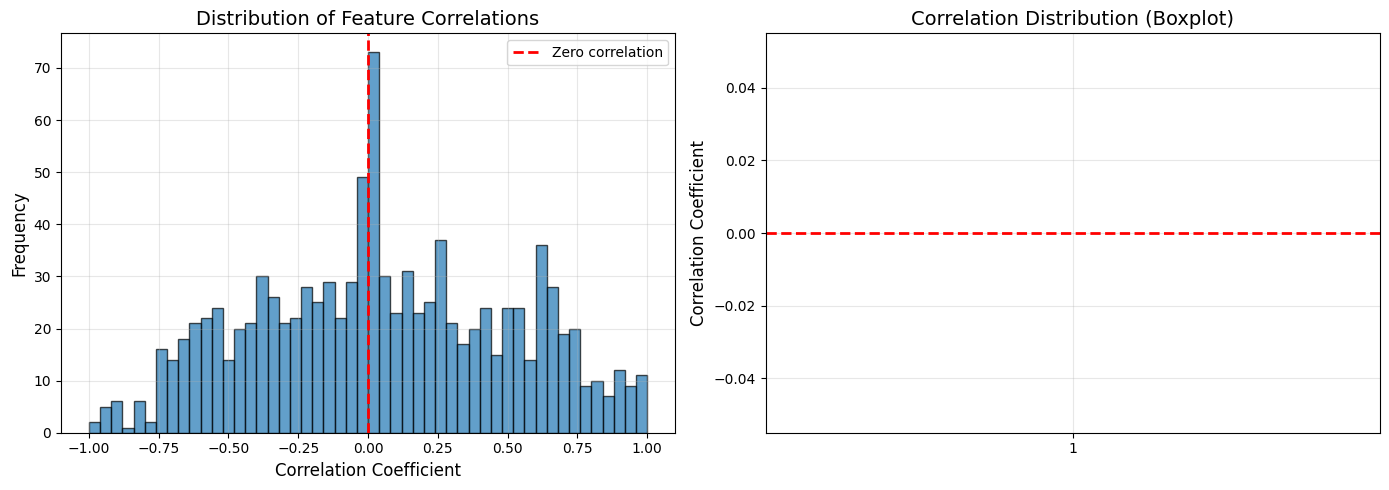


TOP 5 CORRELATED FEATURES FOR EACH FEATURE

user_mean_mean:
  → global_zscore_mean              r =  1.0000
  → user_above_3_mean               r =  0.9633
  → item_zscore_mean                r =  0.9413
  → user_below_3_mean               r = -0.9279
  → contrarian_mean                 r = -0.8255

user_std_mean:
  → global_zscore_std               r =  1.0000
  → rating_entropy                  r =  0.8918
  → item_zscore_std                 r =  0.8868
  → zscore_product_mean_x           r =  0.7716
  → zscore_product_mean_y           r =  0.7716

user_skew_mean:
  → user_above_3_mean               r = -0.7192
  → user_mean_mean                  r = -0.6906
  → global_zscore_mean              r = -0.6906
  → item_zscore_mean                r = -0.6368
  → user_below_3_mean               r =  0.6058

user_min_mean:
  → global_zscore_std               r = -0.4925
  → user_std_mean                   r = -0.4925
  → rating_entropy                  r = -0.4326
  → item_zscore_std       

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


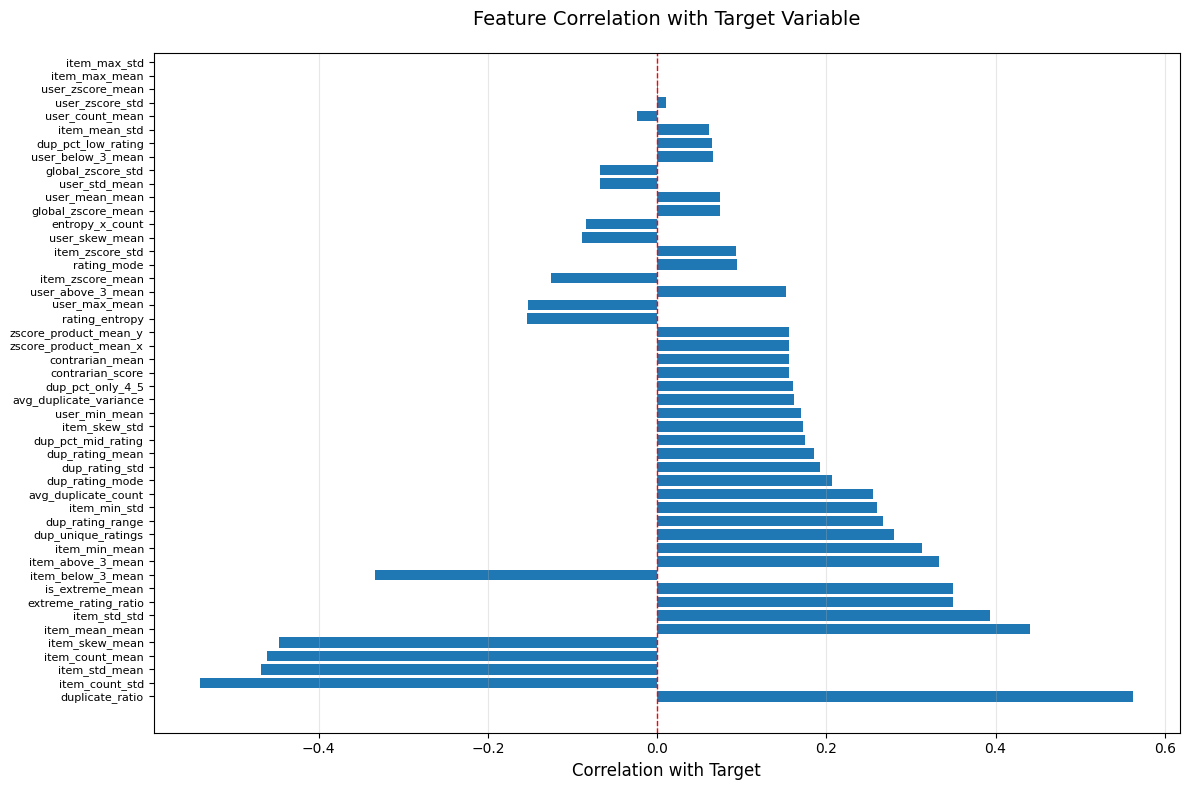


✓ Correlation analysis complete!


In [ ]:
# @title Correlation Matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# CORRELATION MATRIX ANALYSIS
# ============================================

print("="*70)
print("CORRELATION MATRIX ANALYSIS")
print("="*70)

# Calculate correlation matrix
correlation_matrix = X_train.corr()

print(f"\nCorrelation matrix shape: {correlation_matrix.shape}")
print(f"Total feature pairs: {(correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1)) // 2}")

# ============================================
# 1. FULL CORRELATION HEATMAP
# ============================================

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix,
            annot=False,  # Set to True if you want to see values (may be crowded)
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (All Features)', fontsize=16, pad=20)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# ============================================
# 2. HIGH CORRELATION PAIRS (|r| > 0.7)
# ============================================

print("\n" + "="*70)
print("HIGH CORRELATION PAIRS (|correlation| > 0.7)")
print("="*70)

# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix_masked = correlation_matrix.mask(mask)

# Find high correlations
high_corr_pairs = []
for col in correlation_matrix_masked.columns:
    for idx in correlation_matrix_masked.index:
        corr_value = correlation_matrix_masked.loc[idx, col]
        if pd.notna(corr_value) and abs(corr_value) > 0.7:
            high_corr_pairs.append({
                'Feature 1': idx,
                'Feature 2': col,
                'Correlation': corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)

    print(f"\nFound {len(high_corr_df)} feature pairs with |correlation| > 0.7:\n")
    for idx, row in high_corr_df.iterrows():
        print(f"{row['Feature 1']:30} <-> {row['Feature 2']:30}  |  r = {row['Correlation']:7.4f}")
else:
    print("\nNo feature pairs with |correlation| > 0.7 found.")

# ============================================
# 3. CORRELATION DISTRIBUTION
# ============================================

print("\n" + "="*70)
print("CORRELATION DISTRIBUTION STATISTICS")
print("="*70)

# Get all correlation values (excluding diagonal)
corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]

print(f"\nCorrelation statistics:")
print(f"  Mean:        {np.mean(corr_values):7.4f}")
print(f"  Median:      {np.median(corr_values):7.4f}")
print(f"  Std Dev:     {np.std(corr_values):7.4f}")
print(f"  Min:         {np.min(corr_values):7.4f}")
print(f"  Max:         {np.max(corr_values):7.4f}")
print(f"  25th %ile:   {np.percentile(corr_values, 25):7.4f}")
print(f"  75th %ile:   {np.percentile(corr_values, 75):7.4f}")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(corr_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero correlation')
axes[0].set_xlabel('Correlation Coefficient', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Feature Correlations', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(corr_values, vert=True)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_ylabel('Correlation Coefficient', fontsize=12)
axes[1].set_title('Correlation Distribution (Boxplot)', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 4. TOP CORRELATED FEATURES FOR EACH FEATURE
# ============================================

print("\n" + "="*70)
print("TOP 5 CORRELATED FEATURES FOR EACH FEATURE")
print("="*70)

for feature in X_train.columns:
    # Get correlations for this feature (excluding itself)
    feature_corr = correlation_matrix[feature].drop(feature).sort_values(key=abs, ascending=False).head(5)

    print(f"\n{feature}:")
    for other_feature, corr_val in feature_corr.items():
        print(f"  → {other_feature:30}  r = {corr_val:7.4f}")

# ============================================
# 5. CORRELATION WITH TARGET (if needed)
# ============================================

print("\n" + "="*70)
print("CORRELATION WITH TARGET VARIABLE")
print("="*70)

# Calculate correlation between features and target
target_correlation = pd.DataFrame({
    'Feature': X_train.columns,
    'Correlation_with_Target': [X_train[col].corr(y_train) for col in X_train.columns]
})

target_correlation = target_correlation.sort_values('Correlation_with_Target', key=abs, ascending=False)

print("\nTop 15 features correlated with target:\n")
for idx, row in target_correlation.head(15).iterrows():
    print(f"{row['Feature']:40}  r = {row['Correlation_with_Target']:7.4f}")

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(target_correlation)), target_correlation['Correlation_with_Target'])
plt.yticks(range(len(target_correlation)), target_correlation['Feature'], fontsize=8)
plt.xlabel('Correlation with Target', fontsize=12)
plt.title('Feature Correlation with Target Variable', fontsize=14, pad=20)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis complete!")

In [ ]:
# @title Transforming X and XX for final training and prediction
# ============================================================================
# MAIN PIPELINE - NO DATA LEAKAGE (DEPLOYMENT READY)
# ============================================================================

print("="*70)
print("FEATURE ENGINEERING PIPELINE (NO DATA LEAKAGE - CORRECTED)")
print("="*70)

# ============================================
# STEP 1: Process TRAINING data (X)
# ============================================

print("\n" + "="*70)
print("STEP 1: PROCESSING TRAINING DATA (X)")
print("="*70)

# Create features and save item/global statistics
X_features, item_stats_train, global_stats_train = create_comprehensive_features_train(X)

# Aggregate to user level
X_grouped = aggregate_to_user_level(X_features)

# Merge with labels
combined = X_grouped.merge(y, on='user', how='left')

print(f"\nTraining features shape: {combined.shape}")
print(f"Features: {len(combined.columns) - 2}")  # -2 for 'user' and 'label'

# ============================================
# STEP 2: Process TEST data (XX)
# ============================================

print("\n" + "="*70)
print("STEP 2: PROCESSING TEST DATA (XX)")
print("="*70)

# Create features using TRAINING statistics
XX_features = create_comprehensive_features_test(XX, item_stats_train, global_stats_train)

# Aggregate to user level
XX_grouped = aggregate_to_user_level(XX_features)

# Save user IDs for tracking
XX_user_ids = XX_grouped['user'].copy()

# Drop item_mean column if it exists
if 'item_mean' in XX_grouped.columns:
    XX_grouped = XX_grouped.drop(columns=['item_mean'])

# Drop 'user' column to get initial feature matrix
XX_transformed = XX_grouped.drop(columns=['user'])

print(f"\nTest features shape (before removal): {XX_transformed.shape}")
print(f"Number of test users: {len(XX_user_ids)}")

# ============================================
# STEP 3: FEATURE REMOVAL
# ============================================

print("\n" + "="*70)
print("STEP 3: FEATURE REMOVAL")
print("="*70)

# Define REDUNDANT features to drop (10 features)
REDUNDANT_FEATURES = [
    # Duplicate helper features (7 features) - redundant with duplicate_profile features
    'is_duplicate_mean',
    'duplicate_count_mean',
    'duplicate_rating_variance_mean',
    'is_high_rating_duplicate_mean',
    'is_mid_rating_duplicate_mean',
    'is_low_rating_duplicate_mean',
    'is_exclusive_high_duplicate_mean',

    # Duplicate columns from merge (3 features)
    # 'zscore_product_mean_x',   # Keep zscore_product_mean_y
    # 'contrarian_mean',          # Keep contrarian_score
    # 'is_extreme_mean',          # Keep extreme_rating_ratio
]

# ============================================
# MANUAL FEATURE REMOVAL (Low Importance Features)
# Add features here that you want to remove based on SHAP analysis
# or other feature importance metrics
# ============================================
MANUAL_FEATURES_TO_REMOVE = [
]

# Combine all features to drop
ALL_FEATURES_TO_DROP = REDUNDANT_FEATURES + MANUAL_FEATURES_TO_REMOVE

print(f"Dropping {len(REDUNDANT_FEATURES)} redundant features:")
for feat in REDUNDANT_FEATURES:
    print(f"  • {feat}")

if MANUAL_FEATURES_TO_REMOVE:
    print(f"\nDropping {len(MANUAL_FEATURES_TO_REMOVE)} manually selected features:")
    for feat in MANUAL_FEATURES_TO_REMOVE:
        print(f"  • {feat}")
else:
    print("\nNo manually selected features to drop.")

print(f"\nTotal features to drop: {len(ALL_FEATURES_TO_DROP)}")

# ============================================
# STEP 4: Verify NO DATA LEAKAGE
# ============================================

print("\n" + "="*70)
print("STEP 4: VERIFICATION")
print("="*70)

# Check item overlap
X_items = set(X['item'].unique())
XX_items = set(XX['item'].unique())
overlap_items = X_items & XX_items
overlap_pct = len(overlap_items) / len(XX_items) * 100

print(f"\nItem Statistics:")
print(f"  Items in X (training): {len(X_items)}")
print(f"  Items in XX (test): {len(XX_items)}")
print(f"  Overlap: {len(overlap_items)} ({overlap_pct:.1f}%)")
print(f"  Unseen in XX: {len(XX_items - X_items)} ({100-overlap_pct:.1f}%)")

if overlap_pct > 80:
    print(f"\n✓ HIGH OVERLAP: Most test items seen in training")
elif overlap_pct > 50:
    print(f"\n⚠️ MODERATE OVERLAP: Some test items unseen")
else:
    print(f"\n⚠️ LOW OVERLAP: Many test items unseen (filled with global mean)")

# Verify feature columns match (before removal)
print(f"\nFeature Verification:")
train_features_initial = [col for col in combined.columns if col not in ['user', 'label']]
test_features_initial = XX_transformed.columns.tolist()

if set(train_features_initial) == set(test_features_initial):
    print(f"✓ Training and test have SAME features before removal ({len(train_features_initial)} features)")
else:
    print(f"❌ WARNING: Feature mismatch!")
    print(f"   In train but not test: {set(train_features_initial) - set(test_features_initial)}")
    print(f"   In test but not train: {set(test_features_initial) - set(train_features_initial)}")

print("\n" + "="*70)
print("✓ PIPELINE COMPLETE - NO DATA LEAKAGE!")
print("="*70)
print("\n📊 KEY IMPROVEMENTS:")
print("  1. Global z-score uses FROZEN training mean/std")
print("  2. User z-score uses each user's OWN statistics (no cross-user contamination)")
print("  3. Test data uses training global statistics")
print("="*70)

# ============================================
# STEP 5: PREPARE FINAL TRAINING DATA (WITH FEATURE REMOVAL)
# ============================================

print("\n" + "="*70)
print("STEP 5: PREPARE FINAL TRAINING DATA (WITH FEATURE REMOVAL)")
print("="*70)

# Extract features and labels, then drop selected features
X_train_final = combined.drop(['user', 'label'] + ALL_FEATURES_TO_DROP, axis=1, errors='ignore')
y_train_final = combined['label']

# Store user IDs for reference (optional)
X_train_user_ids = combined['user'].copy()

print(f"\nFinal Training Data:")
print(f"  X_train_final shape: {X_train_final.shape}")
print(f"  y_train_final shape: {y_train_final.shape}")
print(f"  Number of features: {X_train_final.shape[1]}")
print(f"  Number of training samples: {len(X_train_final)}")
print(f"✓ Reduced features by {len(ALL_FEATURES_TO_DROP)} (removed {len(ALL_FEATURES_TO_DROP)} total)")
print(f"  - {len(REDUNDANT_FEATURES)} redundant features")
print(f"  - {len(MANUAL_FEATURES_TO_REMOVE)} manually selected features")

# Check for any NaN or infinite values
nan_count = X_train_final.isna().sum().sum()
inf_count = np.isinf(X_train_final).sum().sum()

if nan_count > 0:
    print(f"\n⚠️ WARNING: {nan_count} NaN values found in X_train_final")
    print("  Filling NaN with 0...")
    X_train_final = X_train_final.fillna(0)
else:
    print(f"\n✓ No NaN values in X_train_final")

if inf_count > 0:
    print(f"⚠️ WARNING: {inf_count} infinite values found in X_train_final")
    print("  Replacing inf with large finite values...")
    X_train_final = X_train_final.replace([np.inf, -np.inf], [1e10, -1e10])
else:
    print(f"✓ No infinite values in X_train_final")

# Check for any NaN in y_train_final
if y_train_final.isna().any():
    print(f"\n⚠️ WARNING: {y_train_final.isna().sum()} NaN values in y_train_final")
    print("  Removing samples with NaN labels...")
    valid_mask = ~y_train_final.isna()
    X_train_final = X_train_final[valid_mask]
    y_train_final = y_train_final[valid_mask]
    X_train_user_ids = X_train_user_ids[valid_mask]
    print(f"  New X_train_final shape: {X_train_final.shape}")
else:
    print(f"✓ No NaN values in y_train_final")

# Summary statistics
print(f"\nTarget Variable (y_train_final) Statistics:")
print(f"  Mean: {y_train_final.mean():.4f}")
print(f"  Std:  {y_train_final.std():.4f}")
print(f"  Min:  {y_train_final.min():.4f}")
print(f"  Max:  {y_train_final.max():.4f}")

# ============================================
# STEP 6: PREPARE XX DATA FOR PREDICTIONS (WITH FEATURE REMOVAL)
# ============================================

print("\n" + "="*70)
print("STEP 6: PREPARE XX DATA FOR PREDICTIONS (WITH FEATURE REMOVAL)")
print("="*70)

# Drop the same features from XX_transformed
XX_transformed = XX_transformed.drop(columns=ALL_FEATURES_TO_DROP, errors='ignore')

# Ensure XX_transformed has same columns as X_train_final (in same order)
missing_in_XX = set(X_train_final.columns) - set(XX_transformed.columns)
extra_in_XX = set(XX_transformed.columns) - set(X_train_final.columns)

if missing_in_XX:
    print(f"⚠️ Adding {len(missing_in_XX)} missing columns to XX_transformed (filled with 0)")
    for col in missing_in_XX:
        XX_transformed[col] = 0

if extra_in_XX:
    print(f"⚠️ Removing {len(extra_in_XX)} extra columns from XX_transformed")
    XX_transformed = XX_transformed.drop(columns=list(extra_in_XX))

# Reorder columns to match X_train_final exactly
XX_transformed = XX_transformed[X_train_final.columns]

print(f"\nFinal XX Data:")
print(f"  XX_transformed shape: {XX_transformed.shape}")
print(f"  Number of XX users: {len(XX_user_ids)}")
print(f"  Columns match X_train_final: {list(XX_transformed.columns) == list(X_train_final.columns)}")

# Check for NaN/inf in XX_transformed
nan_count_XX = XX_transformed.isna().sum().sum()
inf_count_XX = np.isinf(XX_transformed).sum().sum()

if nan_count_XX > 0:
    print(f"⚠️ WARNING: {nan_count_XX} NaN values in XX_transformed")
    print("  Filling NaN with 0...")
    XX_transformed = XX_transformed.fillna(0)

if inf_count_XX > 0:
    print(f"⚠️ WARNING: {inf_count_XX} infinite values in XX_transformed")
    print("  Replacing inf with large finite values...")
    XX_transformed = XX_transformed.replace([np.inf, -np.inf], [1e10, -1e10])

print(f"✓ XX_transformed is ready for predictions")

# ============================================
# FINAL SUMMARY
# ============================================

print("\n" + "="*70)
print("✓ ALL DATA READY FOR MODEL TRAINING!")
print("="*70)

print("\n📊 FINAL DATASETS:")
print(f"  X_train_final: {X_train_final.shape} - Features for training")
print(f"  y_train_final: {y_train_final.shape} - Labels for training")
print(f"  XX_transformed: {XX_transformed.shape} - Features for prediction")
print(f"  XX_user_ids: {len(XX_user_ids)} users - User IDs for XX")

print("\n📋 FEATURE SUMMARY:")
print(f"  Final feature count: {len(X_train_final.columns)}")
print("\nAll features:")
for i, feat in enumerate(X_train_final.columns, 1):
    print(f"  {i}. {feat}")

FEATURE ENGINEERING PIPELINE (NO DATA LEAKAGE - CORRECTED)

STEP 1: PROCESSING TRAINING DATA (X)
Creating features for TRAINING data (1144742 rows, 3600 users)
Creating duplicate-based features...
  Global mean: 3.369, Global std: 1.166
Calculating item statistics from TRAINING data...
  Found 1000 unique items in training
  Global mean: 3.369
✓ Training features created successfully
Creating user duplicate profile...
✓ Aggregation complete. Total features: 55 (excluding 'user')

Training features shape: (3600, 57)
Features: 55

STEP 2: PROCESSING TEST DATA (XX)

Creating features for TEST data (284954 rows, 900 users)
Using statistics from TRAINING data...
Creating duplicate-based features...
  Using training global mean: 3.369, std: 1.166
✓ Test features created successfully
Creating user duplicate profile...
✓ Aggregation complete. Total features: 55 (excluding 'user')

Test features shape (before removal): (900, 55)
Number of test users: 900

STEP 3: FEATURE REMOVAL
Dropping 7 redu

# Regression (Part 1)

In [ ]:
# @title Linear Regression Model
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_absolute_error
import pandas as pd

def linear_regression_cv(X_train, y_train, X_test, y_test, cv=5):
    """
    Perform linear regression with cross-validation and scaling.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    X_test : array-like, testing features
    y_test : array-like, testing target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with model, CV results, train MAE, and test MAE
    """

    # Create pipeline: Scaling -> Linear Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('linear_reg', LinearRegression())
    ])

    print("Performing Linear Regression with Cross-Validation and Scaling")
    print(f"Cross-validation folds: {cv}\n")

    # Perform cross-validation
    print("Running cross-validation on training data...")
    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='neg_mean_absolute_error',
        return_train_score=True
    )

    # Extract CV scores
    cv_mae_scores = -cv_results['test_score']  # Convert to positive MAE
    train_mae_scores = -cv_results['train_score']

    # Calculate statistics
    mean_cv_mae = cv_mae_scores.mean()
    std_cv_mae = cv_mae_scores.std()
    mean_train_mae = train_mae_scores.mean()

    print("\n" + "="*70)
    print("CROSS-VALIDATION RESULTS")
    print("="*70)
    print(f"\nMean CV MAE: {mean_cv_mae:.4f}")
    print(f"Std CV MAE: {std_cv_mae:.4f}")
    print(f"Mean Train MAE: {mean_train_mae:.4f}")

    print(f"\nFold-by-fold CV MAE:")
    for fold, mae in enumerate(cv_mae_scores, 1):
        print(f"  Fold {fold}: {mae:.4f}")

    # Train final model on full training set
    print("\n" + "="*70)
    print("Training final model on full training set...")
    pipeline.fit(X_train, y_train)

    # Evaluate on training set
    y_train_pred = pipeline.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Evaluate on test set
    y_test_pred = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print("\n" + "="*70)
    print("FINAL MODEL EVALUATION")
    print("="*70)
    print(f"\nCross-Validation MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

    if test_mae - train_mae > 0.5:
        print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
    elif test_mae - train_mae < -0.1:
        print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
    else:
        print("\n✓ Model generalization looks good")

    print("\n" + "="*70)

    return {
        'model': pipeline,
        'mean_cv_mae': mean_cv_mae,
        'std_cv_mae': std_cv_mae,
        'mean_train_mae': mean_train_mae,
        'cv_scores': cv_mae_scores,
        'train_scores': train_mae_scores,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'cv_results': cv_results
    }

In [ ]:
# @title Linear Regression Results
results = linear_regression_cv(X_train, y_train, X_test, y_test, cv=5)
model = results['model']
mean_cv_mae = results['mean_cv_mae']
test_mae = results['test_mae']
train_MAE = results['train_mae']
print(mean_cv_mae)
print(f"Test MAE: {test_mae:.4f}")
print(f"Train MAE: {train_MAE:.4f}")
print(f"Difference (Test - Train): {test_mae - train_MAE:.4f}")

Performing Linear Regression with Cross-Validation and Scaling
Cross-validation folds: 5

Running cross-validation on training data...

CROSS-VALIDATION RESULTS

Mean CV MAE: 0.0858
Std CV MAE: 0.0025
Mean Train MAE: 0.0840

Fold-by-fold CV MAE:
  Fold 1: 0.0883
  Fold 2: 0.0813
  Fold 3: 0.0846
  Fold 4: 0.0871
  Fold 5: 0.0874

Training final model on full training set...

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0858 ± 0.0025
Training MAE: 0.0841
Test MAE: 0.0904
Difference (Test - Train): 0.0063

✓ Model generalization looks good

0.08575238108457259
Test MAE: 0.0904
Train MAE: 0.0841
Difference (Test - Train): 0.0063


In [ ]:
# @title Ridge Regression Model
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def polynomial_ridge_regression_grid_search(X_train, y_train, max_degree=10, cv=5):
    """
    Perform grid search with cross-validation for polynomial regression with Ridge.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    max_degree : int, maximum polynomial degree to test (default=10)
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best degree, best alpha, and results
    """

    # Create a pipeline: Scaling -> Polynomial Features -> Ridge Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures()),
        ('ridge_reg', Ridge())
    ])

    # Define parameter grid for polynomial degree and Ridge alpha
    degrees = list(range(1, max_degree + 1))
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]

    param_grid = {
        'poly_features__degree': degrees,
        'ridge_reg__alpha': alphas
    }

    # Calculate total fits for progress tracking
    num_degrees = len(degrees)
    num_alphas = len(alphas)
    total_combinations = num_degrees * num_alphas
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"Polynomial degrees: {num_degrees} (1 to {max_degree})")
    print(f"Ridge alpha values: {num_alphas} {alphas}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Set to 1 for progress tracking
        verbose=2  # Verbose level 1 shows progress
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['degree'] = results_df['param_poly_features__degree']
    results_df['alpha'] = results_df['param_ridge_reg__alpha']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_degree = grid_search.best_params_['poly_features__degree']
    best_alpha = grid_search.best_params_['ridge_reg__alpha']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest polynomial degree: {best_degree}")
    print(f"Best Ridge alpha: {best_alpha}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['degree', 'alpha', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_degree': best_degree,
        'best_alpha': best_alpha,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [ ]:
# @title Ridge Regression Grid Search Results
results = polynomial_ridge_regression_grid_search(X_train, y_train, max_degree=3, cv=5)
ridge_best_model = results['best_model']
best_degree = results['best_degree']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
Polynomial degrees: 3 (1 to 3)
Ridge alpha values: 6 [0.001, 0.01, 0.1, 1, 10, 100]
Cross-validation folds: 5
Total parameter combinations: 18
Total model fits: 90

Starting grid search...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END ....poly_features__degree=1, ridge_reg__alpha=0.001; total time=   0.0s
[CV] END .....poly_features__degree=1, ridge_reg__alpha=0.01; total time=   0.0s
[CV] END .....poly_features__degree=1, ridge_reg__alpha=0.01; total time=   0.0s
[CV] END .....poly_features__degree=1, ridge_reg__alpha=0.01; total time=   0.0s
[CV] END .....poly_features__de

In [ ]:
# @title Ridge Regression Evaluation
# grid search auto scale and retrains over whole training set and comes up with best_model

# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = ridge_best_model.predict(X_train)
y_test_pred = ridge_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0568
Training MAE: 0.0441
Test MAE: 0.0605
Difference (Test - Train): 0.0164


In [ ]:
# @title Lasso Regression Model
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def polynomial_lasso_regression_grid_search(X_train, y_train, max_degree=10, cv=5):
    """
    Perform grid search with cross-validation for polynomial regression with Lasso.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    max_degree : int, maximum polynomial degree to test (default=10)
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best degree, best alpha, and results
    """

    # Create a pipeline: Scaling -> Polynomial Features -> Lasso Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures()),
        ('lasso_reg', Lasso(max_iter=10000, tol=0.01, warm_start=True))  # Increased max_iter for convergence
    ])

    # Define parameter grid for polynomial degree and Lasso alpha
    degrees = list(range(1, max_degree + 1))
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    param_grid = {
        'poly_features__degree': degrees,
        'lasso_reg__alpha': alphas
    }

    # Calculate total fits for progress tracking
    num_degrees = len(degrees)
    num_alphas = len(alphas)
    total_combinations = num_degrees * num_alphas
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"Polynomial degrees: {num_degrees} (1 to {max_degree})")
    print(f"Lasso alpha values: {num_alphas} {alphas}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Set to 1 for progress tracking
        verbose=2  # Verbose level 1 shows progress
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['degree'] = results_df['param_poly_features__degree']
    results_df['alpha'] = results_df['param_lasso_reg__alpha']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_degree = grid_search.best_params_['poly_features__degree']
    best_alpha = grid_search.best_params_['lasso_reg__alpha']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest polynomial degree: {best_degree}")
    print(f"Best Lasso alpha: {best_alpha}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['degree', 'alpha', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_degree': best_degree,
        'best_alpha': best_alpha,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }


#
# # ONLY AFTER selecting the model, evaluate on test set:
# y_test_pred = best_model.predict(X_test)
# test_mae = mean_absolute_error(y_test, y_test_pred)
# print(f"Test set MAE: {test_mae:.4f}")

In [ ]:
# @title Lasso Regression Grid Search Results
results = polynomial_lasso_regression_grid_search(X_train, y_train, max_degree=3, cv=5)
lasso_best_model = results['best_model']
best_degree = results['best_degree']
best_alpha = results['best_alpha']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
Polynomial degrees: 3 (1 to 3)
Lasso alpha values: 7 [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Cross-validation folds: 5
Total parameter combinations: 21
Total model fits: 105

Starting grid search...

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=1; total time=   0.0s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=2; total time=   0.5s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=2; total time=   0.6s
[CV] END ....lasso_reg__alpha=0.001, poly_features__degree=2; total time=   0.8s
[CV] END ....lasso_reg_

In [ ]:
# @title Lasso Regression Evaluation
# grid search auto scale and retrains over whole training set and comes up with best_model

# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = lasso_best_model.predict(X_train)
y_test_pred = lasso_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0596
Training MAE: 0.0474
Test MAE: 0.0657
Difference (Test - Train): 0.0183


In [ ]:
# @title Elastic Net Regression Model
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def polynomial_elastic_regression_grid_search(X_train, y_train, max_degree=10, cv=5):
    """
    Perform grid search with cross-validation for polynomial regression with ElasticNet.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    max_degree : int, maximum polynomial degree to test (default=10)
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best degree, best alpha, best l1_ratio, and results
    """

    # Create a pipeline: Scaling -> Polynomial Features -> ElasticNet Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures()),
        ('elasticnet_reg', ElasticNet(max_iter=10000, tol=0.01, warm_start=True))
    ])

    # Define parameter grid for polynomial degree, ElasticNet alpha, and l1_ratio
    degrees = list(range(1, max_degree + 1))
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    l1_ratios = [0.25, 0.5, 0.75]  # 0=Ridge, 1=Lasso, 0-1=ElasticNet

    param_grid = {
        'poly_features__degree': degrees,
        'elasticnet_reg__alpha': alphas,
        'elasticnet_reg__l1_ratio': l1_ratios
    }

    # Calculate total fits for progress tracking
    num_degrees = len(degrees)
    num_alphas = len(alphas)
    num_l1_ratios = len(l1_ratios)
    total_combinations = num_degrees * num_alphas * num_l1_ratios
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"Polynomial degrees: {num_degrees} (1 to {max_degree})")
    print(f"ElasticNet alpha values: {num_alphas} {alphas}")
    print(f"ElasticNet l1_ratio values: {num_l1_ratios} {l1_ratios}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Set to 1 for progress tracking
        verbose=2  # Verbose level 1 shows progress
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['degree'] = results_df['param_poly_features__degree']
    results_df['alpha'] = results_df['param_elasticnet_reg__alpha']
    results_df['l1_ratio'] = results_df['param_elasticnet_reg__l1_ratio']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_degree = grid_search.best_params_['poly_features__degree']
    best_alpha = grid_search.best_params_['elasticnet_reg__alpha']
    best_l1_ratio = grid_search.best_params_['elasticnet_reg__l1_ratio']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest polynomial degree: {best_degree}")
    print(f"Best ElasticNet alpha: {best_alpha}")
    print(f"Best ElasticNet l1_ratio: {best_l1_ratio}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['degree', 'alpha', 'l1_ratio', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_degree': best_degree,
        'best_alpha': best_alpha,
        'best_l1_ratio': best_l1_ratio,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [ ]:
# @title Elastic Net Regression Grid Search Results
results = polynomial_elastic_regression_grid_search(X_train, y_train, max_degree=3, cv=5)
elastic_best_model = results['best_model']
best_degree = results['best_degree']
best_alpha = results['best_alpha']
best_l1_ratio = results['best_l1_ratio']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
Polynomial degrees: 3 (1 to 3)
ElasticNet alpha values: 7 [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ElasticNet l1_ratio values: 3 [0.25, 0.5, 0.75]
Cross-validation folds: 5
Total parameter combinations: 63
Total model fits: 315

Starting grid search...

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.2s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.1s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.2s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.1s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg__l1_ratio=0.25, poly_features__degree=1; total time=   0.2s
[CV] END elasticnet_reg__alpha=0.001, elasticnet_reg_

In [ ]:
# @title Elastic Net Regression Evaluation
# grid search auto scale and retrains over whole training set and comes up with best_model

# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = elastic_best_model.predict(X_train)
y_test_pred = elastic_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0567
Training MAE: 0.0487
Test MAE: 0.0573
Difference (Test - Train): 0.0086


In [ ]:
# @title Random Forest Model
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def random_forest_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for Random Forest regression.
    Model selection is based ONLY on training data with cross-validation.
    Tunes only max_features while keeping other parameters fixed.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # Create Random Forest model with fixed parameters
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=1,
        random_state=42,

    )

    # Define parameter grid - only tuning max_features
    param_grid = {
        'max_features': list(range(1, 49))
    }

    # Calculate total fits for progress tracking
    num_max_features = len(param_grid['max_features'])
    total_combinations = num_max_features
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: 100 (fixed)")
    print(f"min_samples_leaf: 1 (fixed)")
    print(f"max_features: {num_max_features} {param_grid['max_features']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        rf_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,  # Use all cores for speed
        verbose=2
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['max_features'] = results_df['param_max_features']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_max_features = grid_search.best_params_['max_features']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest max_features: {best_max_features}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nAll max_features ranked by cross-validation MAE:")
    display_results = results_df[['max_features', 'mean_mae', 'std_mae']].sort_values('mean_mae')
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_max_features': best_max_features,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [ ]:
# @title Random Forest Grid Search Results
results = random_forest_grid_search(X_train, y_train, cv=5)
rf_best_model = results['best_model']
best_max_features = results['best_max_features']
best_cv_mae = results['best_cv_mae']
results_df = results['results_df']

Performing grid search with cross-validation on training data only...
n_estimators: 100 (fixed)
min_samples_leaf: 1 (fixed)
max_features: 48 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Cross-validation folds: 5
Total parameter combinations: 48
Total model fits: 240

Starting grid search...

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .....................................max_features=1; total time=   0.6s
[CV] END .....................................max_features=1; total time=   0.6s
[CV] END .....................................max_features=1; total time=   0.6s
[CV] END .....................................max_features=1; total time=   0.6s
[CV] END .....................................max_features=1; total time=   0.6s
[CV] END .....................................max_features=2; total time=   1.0s
[CV] END ...........

In [ ]:
# @title Random Forest Evaluation
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = rf_best_model.predict(X_train)
y_test_pred = rf_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0590
Training MAE: 0.0216
Test MAE: 0.0565
Difference (Test - Train): 0.0349


In [ ]:
# @title Adaptive Boosting Model
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def adaboost_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for AdaBoost regression.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # Create AdaBoost model with DecisionTree as base estimator
    ada_model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=5),
        random_state=42
    )

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.001, 0.01, 0.1, 1.0],
        'loss': ['linear', 'square', 'exponential']
    }

    # Calculate total fits for progress tracking
    num_n_estimators = len(param_grid['n_estimators'])
    num_learning_rate = len(param_grid['learning_rate'])
    num_loss = len(param_grid['loss'])
    total_combinations = num_n_estimators * num_learning_rate * num_loss
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: {num_n_estimators} {param_grid['n_estimators']}")
    print(f"learning_rate: {num_learning_rate} {param_grid['learning_rate']}")
    print(f"loss: {num_loss} {param_grid['loss']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        ada_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=1,
        verbose=2
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['n_estimators'] = results_df['param_n_estimators']
    results_df['learning_rate'] = results_df['param_learning_rate']
    results_df['loss'] = results_df['param_loss']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_loss = grid_search.best_params_['loss']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best loss: {best_loss}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['n_estimators', 'learning_rate', 'loss', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_n_estimators': best_n_estimators,
        'best_learning_rate': best_learning_rate,
        'best_loss': best_loss,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [ ]:
# @title Adaptive Boosting Grid Search Results
results = adaboost_grid_search(X_train, y_train, cv=5)
ada_best_model = results['best_model']
best_n_estimators = results['best_n_estimators']
best_learning_rate = results['best_learning_rate']
best_loss = results['best_loss']
best_cv_mae = results['best_cv_mae']

Performing grid search with cross-validation on training data only...
n_estimators: 4 [50, 100, 200, 300]
learning_rate: 5 [0.001, 0.001, 0.01, 0.1, 1.0]
loss: 3 ['linear', 'square', 'exponential']
Cross-validation folds: 5
Total parameter combinations: 60
Total model fits: 300

Starting grid search...

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   2.7s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   3.0s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   2.4s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   2.4s
[CV] END ..learning_rate=0.001, loss=linear, n_estimators=50; total time=   2.4s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; total time=   5.6s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; total time=   4.9s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; tota

In [ ]:
# @title Adaptive Boosting Evaluation
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = ada_best_model.predict(X_train)
y_test_pred = ada_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0728
Training MAE: 0.0622
Test MAE: 0.0714
Difference (Test - Train): 0.0092


In [ ]:
# @title Extreme Gradient Boosting Model
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def xgb_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for XGBoost regression.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # --- Change 2: Create XGBoost model ---
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Standard objective for regression
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='mae',
        verbosity=0 # Use verbosity=0 instead of verbose=0
    )

    # --- Change 3: Define parameter grid (Using XGBoost names) ---
    param_grid = {
        'n_estimators': [50, 100, 500],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [5, 10, 15, 20, 24],
    }

    # Calculate total fits for progress tracking
    num_n_estimators = len(param_grid['n_estimators'])
    num_learning_rate = len(param_grid['learning_rate'])
    num_max_depth = len(param_grid['max_depth'])
    total_combinations = (num_n_estimators * num_learning_rate * num_max_depth)
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: {num_n_estimators} {param_grid['n_estimators']}")
    print(f"learning_rate: {num_learning_rate} {param_grid['learning_rate']}")
    print(f"max_depth: {num_max_depth} {param_grid['max_depth']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1 # Changed to 1 to show progress, as verbosity=0 hides all output
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    # Extract existing params
    results_df['n_estimators'] = results_df['param_n_estimators']
    results_df['learning_rate'] = results_df['param_learning_rate']
    results_df['max_depth'] = results_df['param_max_depth']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_max_depth = grid_search.best_params_['max_depth']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['n_estimators', 'learning_rate',
                                  'max_depth', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_n_estimators': best_n_estimators,
        'best_learning_rate': best_learning_rate,
        'best_max_depth': best_max_depth,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [ ]:
# @title Extreme Gradient Boosting Grid Search Results
results = xgb_grid_search(X_train, y_train, cv=5)
xgb_best_model = results['best_model']
best_n_estimators = results['best_n_estimators']
best_learning_rate = results['best_learning_rate']
best_max_depth = results['best_max_depth']
best_cv_mae = results['best_cv_mae']

Performing grid search with cross-validation on training data only...
n_estimators: 3 [50, 100, 500]
learning_rate: 4 [0.001, 0.01, 0.1, 1]
max_depth: 5 [5, 10, 15, 20, 24]
Cross-validation folds: 5
Total parameter combinations: 60
Total model fits: 300

Starting grid search...

Fitting 5 folds for each of 60 candidates, totalling 300 fits

GRID SEARCH RESULTS (Based on Cross-Validation)

Best n_estimators: 500
Best learning_rate: 0.1
Best max_depth: 5
Best cross-validation MAE: 0.0598

Top 10 combinations ranked by cross-validation MAE:
 n_estimators  learning_rate  max_depth  mean_mae  std_mae
          500           0.10          5  0.059811 0.001206
          100           0.10          5  0.060063 0.001361
          500           0.01          5  0.061017 0.001060
           50           0.10          5  0.061458 0.001250
          500           0.01         10  0.062451 0.000295
          100           0.10         10  0.062584 0.000339
          500           0.10         10  0.

In [ ]:
# @title Extreme Gradient Boosting Evaluation
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = xgb_best_model.predict(X_train)
y_test_pred = xgb_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0598
Training MAE: 0.0080
Test MAE: 0.0563
Difference (Test - Train): 0.0483


In [ ]:
# @title Light Gradient Boosting Machine Model
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd

def lgbm_grid_search(X_train, y_train, cv=5):
    """
    Perform grid search with cross-validation for LightGBM regression.
    Model selection is based ONLY on training data with cross-validation.

    Parameters:
    X_train : array-like, training features
    y_train : array-like, training target
    cv : int, number of cross-validation folds (default=5)

    Returns:
    dict with best model, best parameters, and results
    """

    # Create LightGBM model
    lgbm_model = lgb.LGBMRegressor(
        random_state=42,
        verbose=0,
        n_jobs=-1
    )

    # Define parameter grid: ADDING 'reg_alpha'
    param_grid = {
        'n_estimators': [50, 100, 500],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'max_depth': [5, 10, 15, 20, 24]
    }

    # Calculate total fits for progress tracking
    num_n_estimators = len(param_grid['n_estimators'])
    num_learning_rate = len(param_grid['learning_rate'])
    num_max_depth = len(param_grid['max_depth'])
    total_combinations = (num_n_estimators * num_learning_rate * num_max_depth)
    total_fits = total_combinations * cv

    print("Performing grid search with cross-validation on training data only...")
    print(f"n_estimators: {num_n_estimators} {param_grid['n_estimators']}")
    print(f"learning_rate: {num_learning_rate} {param_grid['learning_rate']}")
    print(f"max_depth: {num_max_depth} {param_grid['max_depth']}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total model fits: {total_fits}\n")

    # Grid search with cross-validation using MAE
    grid_search = GridSearchCV(
        lgbm_model,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )

    # Fit the grid search
    print("Starting grid search...\n")
    grid_search.fit(X_train, y_train)

    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    # Extract existing params
    results_df['n_estimators'] = results_df['param_n_estimators']
    results_df['learning_rate'] = results_df['param_learning_rate']
    results_df['max_depth'] = results_df['param_max_depth']
    results_df['mean_mae'] = -results_df['mean_test_score']
    results_df['std_mae'] = results_df['std_test_score']

    # Get best model and parameters
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_max_depth = grid_search.best_params_['max_depth']
    best_model = grid_search.best_estimator_
    best_cv_mae = -grid_search.best_score_

    # Print results
    print("\n" + "="*70)
    print("GRID SEARCH RESULTS (Based on Cross-Validation)")
    print("="*70)
    print(f"\nBest n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best cross-validation MAE: {best_cv_mae:.4f}")

    print("\nTop 10 combinations ranked by cross-validation MAE:")
    display_results = results_df[['n_estimators', 'learning_rate',
                                  'max_depth', 'mean_mae', 'std_mae']].sort_values('mean_mae').head(10)
    print(display_results.to_string(index=False))

    print("\n" + "="*70)

    return {
        'best_model': best_model,
        'best_n_estimators': best_n_estimators,
        'best_learning_rate': best_learning_rate,
        'best_max_depth': best_max_depth,
        'best_cv_mae': best_cv_mae,
        'results_df': results_df,
        'grid_search': grid_search
    }

In [ ]:
# @title Light Gradient Boosting Machine Grid Search Results
results = lgbm_grid_search(X_train, y_train, cv=5)
lgbm_best_model = results['best_model']
best_n_estimators = results['best_n_estimators']
best_learning_rate = results['best_learning_rate']
best_max_depth = results['best_max_depth']
best_cv_mae = results['best_cv_mae']

Performing grid search with cross-validation on training data only...
n_estimators: 3 [50, 100, 500]
learning_rate: 4 [0.001, 0.01, 0.1, 1]
max_depth: 5 [5, 10, 15, 20, 24]
Cross-validation folds: 5
Total parameter combinations: 60
Total model fits: 300

Starting grid search...

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [ ]:
# @title Light Gradient Boosting Evaluation
# ============ Make predictions ============
print("Making predictions on training and test data...")
y_train_pred = lgbm_best_model.predict(X_train)
y_test_pred = lgbm_best_model.predict(X_test)
print("Done!\n")

# ============ Calculate MAE ============
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

Making predictions on training and test data...
Done!

FINAL MODEL EVALUATION

Cross-Validation MAE: 0.0591
Training MAE: 0.0151
Test MAE: 0.0570
Difference (Test - Train): 0.0420


In [ ]:
# @title Dense Neural Network Model
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define cv
cv = 5

def create_model(units1, units2, learning_rate=0.01, l2_reg=0.01):
    """
    Keras model builder for CONSTRAINED REGRESSION (using sigmoid activation
    to force output between 0 and 1).
    Now includes two hidden layers with different unit sizes and L2 regularization.
    """
    model = models.Sequential([
        layers.Input(shape=(48,)),
        layers.Dense(units=units1, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(units=units2, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile model using MAE loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mae",
        metrics=['mae']
    )
    return model

# Define Early Stopping Callback
# Monitor validation MAE to stop overfitting
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=300,
    restore_best_weights=True,
    verbose=2
)

# --- Pipeline and Grid Search Setup ---

# Create a pipeline to standardize the data and apply KerasRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('keras_model', KerasRegressor(
        model=create_model,
        callbacks=[early_stop],
        batch_size=64,
        epochs=2000,
        random_state=42,
        validation_split = 0.2,
        verbose=2
    ))
])

# Define hyperparameter grid with L2 regularization
param_grid = {
    'keras_model__model__learning_rate': [0.001],
    'keras_model__model__units1': [4],
    'keras_model__model__units2': [64],
    'keras_model__model__l2_reg': [0.001],  # L2 regularization values
    'keras_model__batch_size': [64],
}

# Set up GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=1,
    verbose=2
)

# --- Run and Evaluate ---

# Calculate the total number of fits
total_fits_calculated = (len(param_grid['keras_model__model__learning_rate']) *
                         len(param_grid['keras_model__model__units1']) *
                         len(param_grid['keras_model__model__units2']) *
                         len(param_grid['keras_model__model__l2_reg']) *
                         len(param_grid['keras_model__batch_size']) * cv)

print(f"Starting Grid Search with {total_fits_calculated} total fits ({cv} CV folds)...")

y_train_reshaped = y_train.values.reshape(-1, 1)

# Run the grid search
grid_search = grid.fit(X_train, y_train_reshaped)

# Get optimal parameters
best_learning_rate = grid_search.best_params_['keras_model__model__learning_rate']
best_units1 = grid_search.best_params_['keras_model__model__units1']
best_units2 = grid_search.best_params_['keras_model__model__units2']
best_l2_reg = grid_search.best_params_['keras_model__model__l2_reg']
best_batch_size = grid_search.best_params_['keras_model__batch_size']
best_cv_neg_mae = grid_search.best_score_
best_cv_mae = -best_cv_neg_mae
cv_mae_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best units (layer 1): {best_units1}")
print(f"Best units (layer 2): {best_units2}")
print(f"Best L2 regularization: {best_l2_reg}")
print(f"Best batch_size: {best_batch_size}")
print(f"Best cross-validated MAE: {best_cv_mae:.8f}")
print(f"Std of CV MAE: {cv_mae_std:.8f}")

# Retrieve best model (the entire pipeline)
neural_network_best_pipeline = grid_search.best_estimator_

Streaming output truncated to the last 5000 lines.
29/29 - 0s - 11ms/step - loss: 0.0520 - mae: 0.0468 - val_loss: 0.0549 - val_mae: 0.0496
Epoch 364/2000
29/29 - 0s - 6ms/step - loss: 0.0520 - mae: 0.0468 - val_loss: 0.0549 - val_mae: 0.0496
Epoch 365/2000
29/29 - 0s - 6ms/step - loss: 0.0520 - mae: 0.0467 - val_loss: 0.0555 - val_mae: 0.0502
Epoch 366/2000
29/29 - 0s - 6ms/step - loss: 0.0525 - mae: 0.0472 - val_loss: 0.0547 - val_mae: 0.0495
Epoch 367/2000
29/29 - 0s - 6ms/step - loss: 0.0522 - mae: 0.0470 - val_loss: 0.0557 - val_mae: 0.0505
Epoch 368/2000
29/29 - 0s - 14ms/step - loss: 0.0520 - mae: 0.0468 - val_loss: 0.0550 - val_mae: 0.0498
Epoch 369/2000
29/29 - 0s - 8ms/step - loss: 0.0520 - mae: 0.0468 - val_loss: 0.0549 - val_mae: 0.0496
Epoch 370/2000
29/29 - 0s - 10ms/step - loss: 0.0520 - mae: 0.0468 - val_loss: 0.0549 - val_mae: 0.0497
Epoch 371/2000
29/29 - 0s - 9ms/step - loss: 0.0522 - mae: 0.0469 - val_loss: 0.0547 - val_mae: 0.0495
Epoch 372/2000
29/29 - 0s - 11ms/s

In [ ]:
# @title Neural Network Grid Search Results + Evaluation
# Create a DataFrame from the results
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Select only the most relevant columns for easy comparison
# We convert the score back to positive MAE for easier interpretation
cv_results_df['mean_cv_mae'] = -cv_results_df['mean_test_score']

# Columns to display: Hyperparameters and the resulting MAE (including L2 regularization)
display_columns = [
    'param_keras_model__model__learning_rate',
    'param_keras_model__model__units1',
    'param_keras_model__model__units2',
    'param_keras_model__model__l2_reg',  # Added L2 regularization parameter
    'param_keras_model__batch_size',
    'mean_cv_mae',
    'std_test_score', # Shows the standard deviation across the 5 folds
    'rank_test_score' # 1 is the best
]

# Sort by the MAE and print
cv_results_sorted = cv_results_df[display_columns].sort_values(by='mean_cv_mae', ascending=True)

# Print the sorted results, showing all rows due to the set_option call
print(cv_results_sorted.to_string())
print("="*50)

# Use best model to predict on the validation set
y_train_pred = neural_network_best_pipeline.predict(X_train)
y_test_pred = neural_network_best_pipeline.predict(X_test)

# Evaluate using Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# ============ Print results ============
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nBest Hyperparameters:")
print(f"  Learning Rate: {best_learning_rate}")
print(f"  Units (Layer 1): {best_units1}")
print(f"  Units (Layer 2): {best_units2}")
print(f"  L2 Regularization: {best_l2_reg}")  # Added L2 info
print(f"  Batch Size: {best_batch_size}")
print(f"\nCross-Validation MAE: {best_cv_mae:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Difference (Test - Train): {test_mae - train_mae:.4f}")

# Check for overfitting/underfitting
if test_mae - train_mae > 0.5:
    print("\n⚠️ Warning: Large gap between train and test MAE (possible overfitting)")
elif test_mae - train_mae < -0.1:
    print("\n⚠️ Warning: Test MAE is better than train MAE (check data)")
else:
    print("\n✓ Model generalization looks good")

print("\n" + "="*70)

   param_keras_model__model__learning_rate  param_keras_model__model__units1  param_keras_model__model__units2  param_keras_model__model__l2_reg  param_keras_model__batch_size  mean_cv_mae  std_test_score  rank_test_score
0                                    0.001                                 4                                64                             0.001                             64     0.050975         0.00156                1
45/45 - 0s - 2ms/step
12/12 - 0s - 4ms/step
FINAL MODEL EVALUATION

Best Hyperparameters:
  Learning Rate: 0.001
  Units (Layer 1): 4
  Units (Layer 2): 64
  L2 Regularization: 0.001
  Batch Size: 64

Cross-Validation MAE: 0.0510
Training MAE: 0.0473
Test MAE: 0.0507
Difference (Test - Train): 0.0034

✓ Model generalization looks good



In [ ]:
# @title Neural Network Feature Importance using SHAP
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# =============================================================================
# MANUAL PARAMETER CONFIGURATION
# =============================================================================
# Set these to match your best parameters from grid search or customize manually
MANUAL_PARAMS = {
    'learning_rate': 0.001,
    'units1': 4,
    'units2': 64,
    'l2_reg': 0.001,
    'batch_size': 64,
    'epochs': 2000,
    'validation_split': 0.2
}

print("\n" + "="*70)
print("SHAP ANALYSIS WITH MANUAL PARAMETERS")
print("="*70)
print("Using the following parameters:")
for param, value in MANUAL_PARAMS.items():
    print(f"  {param}: {value}")

# =============================================================================
# STEP 1: Recreate and Train Model with Manual Parameters
# =============================================================================

def create_shap_model(units1, units2, learning_rate=0.01, l2_reg=0.01):
    """
    Keras model builder matching the grid search architecture.
    """
    model = models.Sequential([
        layers.Input(shape=(48,)),
        layers.Dense(units=units1, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(units=units2, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mae",
        metrics=['mae']
    )
    return model

# Create scaler and scale data
print("\nScaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_reshaped = y_train.values.reshape(-1, 1)

# Create and train model
print("\nTraining model with manual parameters...")
model = create_shap_model(
    units1=MANUAL_PARAMS['units1'],
    units2=MANUAL_PARAMS['units2'],
    learning_rate=MANUAL_PARAMS['learning_rate'],
    l2_reg=MANUAL_PARAMS['l2_reg']
)

# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=300,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_reshaped,
    batch_size=MANUAL_PARAMS['batch_size'],
    epochs=MANUAL_PARAMS['epochs'],
    validation_split=MANUAL_PARAMS['validation_split'],
    callbacks=[early_stop],
    verbose=1
)

print("\nModel training complete!")
print(f"Final training MAE: {history.history['mae'][-1]:.6f}")
print(f"Final validation MAE: {history.history['val_mae'][-1]:.6f}")

# =============================================================================
# STEP 2: SHAP Analysis
# =============================================================================
print("\n" + "="*70)
print("COMPUTING SHAP VALUES")
print("="*70)

# Use entire scaled training data for background
X_background = X_train_scaled
X_shap_sample = X_train_scaled

# Create SHAP explainer
print("Creating SHAP explainer (this may take a while)...")
explainer = shap.DeepExplainer(model, X_background)

# Calculate SHAP values
print("Computing SHAP values for all samples...")
shap_values = explainer.shap_values(X_shap_sample)

# Get feature names
feature_names = X_train.columns.tolist()

# Handle SHAP values shape
if isinstance(shap_values, list):
    shap_vals = shap_values[0]
else:
    shap_vals = shap_values

# Remove extra dimension if present
if len(shap_vals.shape) == 3:
    shap_vals = shap_vals[:, :, 0]

print(f"SHAP values shape: {shap_vals.shape}")
print(f"Number of features: {len(feature_names)}")

# =============================================================================
# STEP 3: Feature Importance Analysis
# =============================================================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_vals).mean(axis=0)

# Create DataFrame with feature importance
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\nFeature Importance (by mean absolute SHAP value):")
print(shap_importance_df.to_string(index=False))

# Identify low-importance features
threshold_percentile = 25
shap_threshold = np.percentile(mean_abs_shap, threshold_percentile)

low_importance_features = shap_importance_df[
    shap_importance_df['Mean_Abs_SHAP'] <= shap_threshold
]['Feature'].tolist()

print(f"\n" + "="*70)
print(f"FEATURES TO CONSIDER REMOVING")
print(f"(Bottom {threshold_percentile}% by SHAP importance)")
print("="*70)
print(f"Threshold: {shap_threshold:.6f}")
print(f"\nFeatures ({len(low_importance_features)}):")
for feat in low_importance_features:
    shap_val = shap_importance_df[shap_importance_df['Feature'] == feat]['Mean_Abs_SHAP'].values[0]
    print(f" - {feat}: {shap_val:.6f}")

# =============================================================================
# BOTTOM 20 FEATURES - READY TO COPY/PASTE
# =============================================================================
print(f"\n" + "="*70)
print("BOTTOM 20 FEATURES (LOWEST IMPORTANCE)")
print("Copy this list to MANUAL_FEATURES_TO_REMOVE:")
print("="*70)

# Get bottom 20 features
bottom_20_for_removal = shap_importance_df.tail(20)['Feature'].tolist()

print("MANUAL_FEATURES_TO_REMOVE = [")
for feat in bottom_20_for_removal:
    print(f"    '{feat}',")
print("]")
print("="*70)

# =============================================================================
# STEP 4: Visualizations
# =============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# 1. Summary plot (bar) - Show all features
print("Creating feature importance bar chart...")
plt.figure(figsize=(10, 12))
shap.summary_plot(shap_vals, X_shap_sample, feature_names=feature_names,
                  plot_type="bar", show=False, max_display=len(feature_names))
plt.title("SHAP Feature Importance (Mean Absolute SHAP Values)")
plt.tight_layout()
plt.show()

# 2. Summary plot (beeswarm) - Top 20 features
print("Creating beeswarm summary plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals, X_shap_sample, feature_names=feature_names,
                  show=False, max_display=20)
plt.title("SHAP Summary Plot (Top 20 Features)")
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 5: Dependence Plots for Bottom 20 Features
# =============================================================================
print("\n" + "="*70)
print("SHAP DEPENDENCE PLOTS (BOTTOM 20 FEATURES)")
print("Checking for hidden interaction effects...")
print("="*70)

# Get bottom 20 features
bottom_20_features = shap_importance_df.tail(20)['Feature'].tolist()

# Create DataFrame for plotting
X_shap_df = pd.DataFrame(X_shap_sample, columns=feature_names)

for i, feature_name in enumerate(bottom_20_features, 1):
    print(f"Creating dependence plot {i}/20: {feature_name}")

    # Get feature index
    feature_index = X_shap_df.columns.get_loc(feature_name)

    # Generate dependence plot
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        ind=feature_index,
        shap_values=shap_vals,
        features=X_shap_df,
        feature_names=feature_names,
        interaction_index="auto",
        show=False,
        dot_size=15
    )
    plt.title(f"Dependence Plot for '{feature_name}' (Colored by Strongest Interaction)")
    plt.tight_layout()
    plt.show()

# =============================================================================
# STEP 6: Summary Statistics
# =============================================================================
print("\n" + "="*70)
print("SHAP ANALYSIS SUMMARY")
print("="*70)
print(f"Total samples analyzed: {X_shap_sample.shape[0]}")
print(f"Total features: {len(feature_names)}")
print(f"Features in bottom {threshold_percentile}%: {len(low_importance_features)}")
print(f"Mean SHAP value (all features): {mean_abs_shap.mean():.6f}")
print(f"Max SHAP value: {mean_abs_shap.max():.6f} ({shap_importance_df.iloc[0]['Feature']})")
print(f"Min SHAP value: {mean_abs_shap.min():.6f} ({shap_importance_df.iloc[-1]['Feature']})")
print("\nSHAP analysis complete!")
print("="*70)


REGRESSION PART 1 RESULTS


---


Week 1: Best learning_rate: 0.01
Best units (layer 1): 4
Best units (layer 2): 64
Best batch_size: 64
Best cross-validated MAE: 0.0649


---


Week 2: Best learning_rate: 0.001
Best units (layer 1): 4
Best units (layer 2): 64
Best batch_size: 256
Best cross-validated MAE: 0.0632


---
Week 3: Best learning_rate: 0.001
Best units (layer 1): 4
Best units (layer 2): 64
Best batch_size: 64
Best cross-validated MAE: 0.0591

---
Week 4: Best learning_rate: 0.001
Best units (layer 1): 4
Best units (layer 2): 64
Best batch_size: 64
Best l2 regularisation: 0.001
Best cross-validated MAE: 0.0510




In [ ]:
# @title averaging CV epoch number for final training
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define cv
cv = 5

def create_model(units1, units2, learning_rate=0.01, l2_reg=0.01):
    """
    Keras model builder for CONSTRAINED REGRESSION (using sigmoid activation
    to force output between 0 and 1).
    Now includes two hidden layers with different unit sizes and L2 regularization.
    """
    model = models.Sequential([
        layers.Input(shape=(48,)),
        layers.Dense(units=units1, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(units=units2, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile model using MAE loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mae",
        metrics=['mae']
    )
    return model

# Define Early Stopping Callback
# Monitor validation MAE to stop overfitting
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=5000,
    restore_best_weights=True,
    verbose=1
)

# --- Pipeline and Grid Search Setup ---

# Create a pipeline to standardize the data and apply KerasRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('keras_model', KerasRegressor(
        model=create_model,
        callbacks=[early_stop],
        batch_size=64,
        epochs=5000,
        random_state=42,
        validation_split = 0.2,
        verbose=0
    ))
])

# Define hyperparameter grid with L2 regularization
param_grid = {
    'keras_model__model__learning_rate': [0.001],
    'keras_model__model__units1': [4],
    'keras_model__model__units2': [64],
    'keras_model__model__l2_reg': [0.001],  # L2 regularization values
    'keras_model__batch_size': [64],
}

# Set up GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=1,
    verbose=0
)

# --- Run and Evaluate ---

# Calculate the total number of fits
total_fits_calculated = (len(param_grid['keras_model__model__learning_rate']) *
                         len(param_grid['keras_model__model__units1']) *
                         len(param_grid['keras_model__model__units2']) *
                         len(param_grid['keras_model__model__l2_reg']) *
                         len(param_grid['keras_model__batch_size']) * cv)

print(f"Starting Grid Search with {total_fits_calculated} total fits ({cv} CV folds)...")

y_train_reshaped = y_train.values.reshape(-1, 1)

# Run the grid search
grid_search = grid.fit(X_train, y_train_reshaped)

# Get optimal parameters
best_learning_rate = grid_search.best_params_['keras_model__model__learning_rate']
best_units1 = grid_search.best_params_['keras_model__model__units1']
best_units2 = grid_search.best_params_['keras_model__model__units2']
best_l2_reg = grid_search.best_params_['keras_model__model__l2_reg']
best_batch_size = grid_search.best_params_['keras_model__batch_size']
best_cv_neg_mae = grid_search.best_score_
best_cv_mae = -best_cv_neg_mae
cv_mae_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best units (layer 1): {best_units1}")
print(f"Best units (layer 2): {best_units2}")
print(f"Best L2 regularization: {best_l2_reg}")
print(f"Best batch_size: {best_batch_size}")
print(f"Best cross-validated MAE: {best_cv_mae:.8f}")
print(f"Std of CV MAE: {cv_mae_std:.8f}")

# Retrieve best model (the entire pipeline)
neural_network_best_pipeline = grid_search.best_estimator_

Starting Grid Search with 5 total fits (5 CV folds)...
Restoring model weights from the end of the best epoch: 826.
Restoring model weights from the end of the best epoch: 879.
Restoring model weights from the end of the best epoch: 4947.
Restoring model weights from the end of the best epoch: 4808.
Restoring model weights from the end of the best epoch: 1727.
Restoring model weights from the end of the best epoch: 4286.

GRID SEARCH RESULTS
Best learning_rate: 0.001
Best units (layer 1): 4
Best units (layer 2): 64
Best L2 regularization: 0.001
Best batch_size: 64
Best cross-validated MAE: 0.05090761
Std of CV MAE: 0.00185574


In [ ]:
# @title retraining on X users and predicting for XX users
import numpy as np
import tensorflow as tf
import random
import os

# === SET ALL RANDOM SEEDS ===
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # For full determinism (may slow down training)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    print(f"✓ Set all random seeds to {seed}")

# Call this BEFORE creating any models
set_seeds(42)

def create_model(units1, units2, learning_rate=0.01):
    """
    Keras model builder for CONSTRAINED REGRESSION (using sigmoid activation
    to force output between 0 and 1).
    Now includes two hidden layers with different unit sizes.
    """
    model = models.Sequential([
        layers.Input(shape=(48,)),
        layers.Dense(units=units1, activation='relu'),
        layers.Dense(units=units2, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile model using MAE loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mae",
        metrics=['mae']
    )
    return model

# --- Set your hyperparameters ---
print("\n" + "="*50)
print("SETTING HYPERPARAMETERS")
print("="*50)

best_units1 = 4
best_units2 = 64
best_learning_rate = 0.001
best_batch_size = 64

print(f"Hyperparameters set:")
print(f"  - units1: {best_units1}")
print(f"  - units2: {best_units2}")
print(f"  - learning_rate: {best_learning_rate}")
print(f"  - batch_size: {best_batch_size}")

# Create a fresh scaler and fit on combined data
final_scaler = StandardScaler()
X_train_final_scaled = final_scaler.fit_transform(X_train_final)

# Create final model with best hyperparameters
final_model = create_model(
    units1=best_units1,
    units2=best_units2,
    learning_rate=best_learning_rate,
)

# Train the final model on all combined data
print(f"\nTraining final model with:")
print(f"  - units1={best_units1}, units2={best_units2}")
print(f"  - learning_rate={best_learning_rate}")
print(f"  - batch_size={best_batch_size}")

history = final_model.fit(
    X_train_final_scaled,
    y_train_final,
    batch_size=best_batch_size,
    epochs=2000, # chosen epochs was 2000 as we averaged the early stoppage epoch number for our best model when we did a grid search with 5000 epochs
    verbose=2
)

print(f"\nFinal model training completed!")
print(f"Final training MAE: {history.history['mae'][-1]:.8f}")

# --- Predict on XX_transformed ---

print("\n" + "="*50)
print("MAKING PREDICTIONS ON XX")
print("="*50)

# Scale XX_transformed using the final scaler
XX_transformed_scaled = final_scaler.transform(XX_transformed)

# Make predictions
predictions = final_model.predict(XX_transformed_scaled, verbose=0)

# Create DataFrame with user IDs, predictions (as 'label'), and blank 'anomtype' column
predictions_df = pd.DataFrame({
    'user': XX_user_ids,
    'label': predictions.flatten(),
    'anomtype': ''  # Blank column
})

print(f"\nPredictions completed!")
print(f"Total predictions: {len(predictions_df)}")
print(f"\nLabel summary:")
print(predictions_df['label'].describe())

# Sort by user ID for cleaner view
predictions_df = predictions_df.sort_values('user').reset_index(drop=True)

print(f"\nPredictions (sorted by user):")
print(predictions_df.head(10))

✓ Set all random seeds to 42

SETTING HYPERPARAMETERS
Hyperparameters set:
  - units1: 4
  - units2: 64
  - learning_rate: 0.001
  - batch_size: 64

Training final model with:
  - units1=4, units2=64
  - learning_rate=0.001
  - batch_size=64
Epoch 1/2000
57/57 - 1s - 20ms/step - loss: 0.2223 - mae: 0.2223
Epoch 2/2000
57/57 - 0s - 2ms/step - loss: 0.1854 - mae: 0.1854
Epoch 3/2000
57/57 - 0s - 3ms/step - loss: 0.1448 - mae: 0.1448
Epoch 4/2000
57/57 - 0s - 2ms/step - loss: 0.1109 - mae: 0.1109
Epoch 5/2000
57/57 - 0s - 2ms/step - loss: 0.0954 - mae: 0.0954
Epoch 6/2000
57/57 - 0s - 2ms/step - loss: 0.0884 - mae: 0.0884
Epoch 7/2000
57/57 - 0s - 2ms/step - loss: 0.0846 - mae: 0.0846
Epoch 8/2000
57/57 - 0s - 2ms/step - loss: 0.0817 - mae: 0.0817
Epoch 9/2000
57/57 - 0s - 2ms/step - loss: 0.0798 - mae: 0.0798
Epoch 10/2000
57/57 - 0s - 3ms/step - loss: 0.0780 - mae: 0.0780
Epoch 11/2000
57/57 - 0s - 2ms/step - loss: 0.0765 - mae: 0.0765
Epoch 12/2000
57/57 - 0s - 2ms/step - loss: 0.0753 

# Classification (Part 2)

In [ ]:
# @title Features Engineering
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import entropy


def calculate_entropy(ratings):
    """Helper function to calculate Shannon entropy"""
    rating_counts = np.bincount(ratings.astype(int), minlength=6)[1:6]
    rating_probs = rating_counts[rating_counts > 0] / len(ratings)
    return entropy(rating_probs, base=2) if len(rating_probs) > 0 else 0


def create_duplicate_features(df):
    """
    Create features based on duplicate rating patterns

    Parameters:
    df : DataFrame with columns ['user', 'item', 'rating']

    Returns:
    df with additional duplicate-based features
    """

    # 1. Basic duplicate identification
    df['is_duplicate'] = df.duplicated(subset=['user', 'item'], keep=False).astype(int)

    # 2. Duplicate count per user-item pair
    df['duplicate_count'] = df.groupby(['user', 'item'])['user'].transform('count')

    # 3. Rating variance within duplicates (0 if same, >0 if different)
    df['duplicate_rating_variance'] = df.groupby(['user', 'item'])['rating'].transform('std').fillna(0)

    # 4. Is this a high-rating duplicate? (4-5 ratings)
    df['is_high_rating_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'] >= 4)).astype(int)

    # 5. Is this a mid-rating duplicate? (3-4 ratings)
    df['is_mid_rating_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'] >= 3) & (df['rating'] <= 4)).astype(int)

    # 6. Is this a low-rating duplicate? (1-2 ratings)
    df['is_low_rating_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'] <= 2)).astype(int)

    # 7. Is this ONLY a 4-5 duplicate? (Type 2 specific pattern)
    df['is_exclusive_high_duplicate'] = ((df['is_duplicate'] == 1) & (df['rating'].isin([4, 5]))).astype(int)

    return df


def create_user_duplicate_profile(df_features):
    """
    Create user-level features based on their duplicate behavior

    Parameters:
    df_features : DataFrame with row-level features including duplicate features

    Returns:
    DataFrame with user-level duplicate features (10 features)
    """

    duplicate_features = []

    for user_id, user_data in df_features.groupby('user'):
        n_ratings = len(user_data)

        # Basic duplicate statistics
        n_duplicates = user_data['is_duplicate'].sum()
        duplicate_ratio = n_duplicates / n_ratings if n_ratings > 0 else 0

        # Duplicate consistency (how often they give same rating when duplicating)
        avg_duplicate_variance = user_data[user_data['is_duplicate'] == 1]['duplicate_rating_variance'].mean()
        if pd.isna(avg_duplicate_variance):
            avg_duplicate_variance = 0

        # Average number of times they duplicate per item
        avg_duplicate_count = user_data[user_data['is_duplicate'] == 1]['duplicate_count'].mean()
        if pd.isna(avg_duplicate_count):
            avg_duplicate_count = 0

        # Rating distribution WITHIN duplicates
        duplicate_ratings = user_data[user_data['is_duplicate'] == 1]['rating']

        if len(duplicate_ratings) > 0:
            # Central tendency
            dup_rating_mean = duplicate_ratings.mean()
            dup_rating_std = duplicate_ratings.std()
            dup_rating_mode = duplicate_ratings.mode()[0] if len(duplicate_ratings.mode()) > 0 else 0

            # Range and diversity
            dup_rating_range = duplicate_ratings.max() - duplicate_ratings.min()
            dup_unique_ratings = duplicate_ratings.nunique()

            # Range-based percentages (KEY FEATURES)
            dup_pct_only_4_5 = (duplicate_ratings.isin([4, 5])).mean()  # Type 2 signature
            dup_pct_mid = ((duplicate_ratings >= 3) & (duplicate_ratings <= 4)).mean()  # Type 1 pattern
            dup_pct_low = (duplicate_ratings <= 2).mean()  # Low rating pattern

        else:
            # No duplicates - all zeros
            dup_rating_mean = 0
            dup_rating_std = 0
            dup_rating_mode = 0
            dup_rating_range = 0
            dup_unique_ratings = 0
            dup_pct_only_4_5 = 0
            dup_pct_mid = 0
            dup_pct_low = 0

        duplicate_features.append({
            'user': user_id,

            # Basic duplicate metrics (3 features)
            'duplicate_ratio': duplicate_ratio,
            'avg_duplicate_variance': avg_duplicate_variance,
            'avg_duplicate_count': avg_duplicate_count,

            # Duplicate rating distribution (5 features)
            'dup_rating_mean': dup_rating_mean,
            'dup_rating_std': dup_rating_std,
            'dup_rating_mode': dup_rating_mode,
            'dup_rating_range': dup_rating_range,
            'dup_unique_ratings': dup_unique_ratings,

            # Range-based percentages (3 features) - KEY for classification
            'dup_pct_only_4_5': dup_pct_only_4_5,  # Type 2 detector
            'dup_pct_mid_rating': dup_pct_mid,      # Type 1 pattern
            'dup_pct_low_rating': dup_pct_low,      # Low rating pattern
        })

    return pd.DataFrame(duplicate_features)


def create_comprehensive_features_train(df):
    """
    Create features for TRAINING data.
    Returns features AND item/global statistics for use on test data.

    Parameters:
    df : DataFrame with columns ['user', 'item', 'rating']

    Returns:
    df_features : DataFrame with all features
    item_stats : DataFrame with item statistics (to apply to test)
    global_stats : Dict with global statistics (to fill unseen items in test)
    """

    df = df.copy()

    print(f"Creating features for TRAINING data ({len(df)} rows, {df['user'].nunique()} users)")

    # ============ DUPLICATE FEATURES (ADD FIRST) ============
    print("Creating duplicate-based features...")
    df = create_duplicate_features(df)

    # ============ Global Z-Score (FREEZE training statistics - NO LEAKAGE) ============
    global_mean = df['rating'].mean()
    global_std = df['rating'].std()
    df['global_zscore'] = (df['rating'] - global_mean) / global_std
    print(f"  Global mean: {global_mean:.3f}, Global std: {global_std:.3f}")

    # ============ Per User Features (Safe - No Leakage) ============
    user_stats = df.groupby('user')['rating'].agg([
        ('user_mean', 'mean'),
        ('user_std', 'std'),
        ('user_skew', lambda x: stats.skew(x)),
        ('user_min', 'min'),
        ('user_max', 'max'),
        ('user_count', 'count')
    ]).reset_index()

    # Calculate user z-score (per-user, using each user's OWN mean/std)
    user_zscore_list = []
    for user_id, user_data in df.groupby('user'):
        user_mean_val = user_data['rating'].mean()
        user_std_val = user_data['rating'].std()
        if user_std_val > 0:
            z_scores = (user_data['rating'] - user_mean_val) / user_std_val
        else:
            z_scores = pd.Series(0, index=user_data.index)
        user_zscore_list.append(pd.DataFrame({
            'user_zscore': z_scores
        }, index=user_data.index))

    user_zscore = pd.concat(user_zscore_list)

    df = df.merge(user_stats, on='user', how='left')
    df = df.merge(user_zscore, left_index=True, right_index=True, how='left')

    # ============ Per Item Features (Calculate from TRAINING only) ============
    print(f"Calculating item statistics from TRAINING data...")

    item_stats = df.groupby('item')['rating'].agg([
        ('item_mean', 'mean'),
        ('item_std', 'std'),
        ('item_skew', lambda x: stats.skew(x)),
        ('item_min', 'min'),
        ('item_max', 'max'),
        ('item_count', 'count')
    ]).reset_index()

    print(f"  Found {len(item_stats)} unique items in training")

    # Calculate item z-score using frozen item statistics
    item_zscore_list = []
    for item_id, item_data in df.groupby('item'):
        item_mean_val = item_data['rating'].mean()
        item_std_val = item_data['rating'].std()
        if item_std_val > 0:
            z_scores = (item_data['rating'] - item_mean_val) / item_std_val
        else:
            z_scores = pd.Series(0, index=item_data.index)
        item_zscore_list.append(pd.DataFrame({
            'item_zscore': z_scores
        }, index=item_data.index))

    item_zscore = pd.concat(item_zscore_list)

    df = df.merge(item_stats, on='item', how='left')
    df = df.merge(item_zscore, left_index=True, right_index=True, how='left')

    # ============ Global Statistics (for filling unseen items in test) ============
    global_stats = {
        'global_mean': global_mean,
        'global_std': global_std,
        'global_skew': stats.skew(df['rating']),
        'global_min': df['rating'].min(),
        'global_max': df['rating'].max()
    }

    print(f"  Global mean: {global_stats['global_mean']:.3f}")

    # ============ Additional Row-Level Features ============
    df['zscore_product'] = df['global_zscore'] * df['item_zscore']

    df['user_below_3'] = (df['rating'] < 3).astype(int)
    df['user_above_3'] = (df['rating'] > 3).astype(int)
    df['item_below_3'] = (df['item_mean'] < 3).astype(int)
    df['item_above_3'] = (df['item_mean'] > 3).astype(int)
    df['contrarian'] = ((df['user_below_3'] & df['item_above_3']) |
                        (df['user_above_3'] & df['item_below_3'])).astype(int)

    df['is_extreme'] = ((df['rating'] == 1) | (df['rating'] == 5)).astype(int)

    # ============ Smart NaN Filling ============
    df['user_std'] = df['user_std'].fillna(0)
    df['item_std'] = df['item_std'].fillna(0)

    df['user_skew'] = df['user_skew'].fillna(global_stats['global_skew'])
    df['item_skew'] = df['item_skew'].fillna(global_stats['global_skew'])

    df['user_zscore'] = df['user_zscore'].fillna(0)
    df['item_zscore'] = df['item_zscore'].fillna(0)

    df = df.fillna(0)

    print(f"✓ Training features created successfully")

    return df, item_stats, global_stats


def create_comprehensive_features_test(df, item_stats, global_stats):
    """
    Create features for TEST data using TRAINING statistics.

    Parameters:
    df : DataFrame with columns ['user', 'item', 'rating']
    item_stats : DataFrame with item statistics from TRAINING
    global_stats : Dict with global statistics from TRAINING

    Returns:
    df_features : DataFrame with all features
    """

    df = df.copy()

    print(f"\nCreating features for TEST data ({len(df)} rows, {df['user'].nunique()} users)")
    print(f"Using statistics from TRAINING data...")

    # ============ DUPLICATE FEATURES (ADD FIRST) ============
    print("Creating duplicate-based features...")
    df = create_duplicate_features(df)

    # ============ Global Z-Score (Use TRAINING global mean/std - NO LEAKAGE) ============
    df['global_zscore'] = (df['rating'] - global_stats['global_mean']) / global_stats['global_std']
    print(f"  Using training global mean: {global_stats['global_mean']:.3f}, std: {global_stats['global_std']:.3f}")

    # ============ Per User Features (Safe - No Leakage) ============
    user_stats = df.groupby('user')['rating'].agg([
        ('user_mean', 'mean'),
        ('user_std', 'std'),
        ('user_skew', lambda x: stats.skew(x)),
        ('user_min', 'min'),
        ('user_max', 'max'),
        ('user_count', 'count')
    ]).reset_index()

    # Calculate user z-score (per-user, using each user's OWN mean/std)
    user_zscore_list = []
    for user_id, user_data in df.groupby('user'):
        user_mean_val = user_data['rating'].mean()
        user_std_val = user_data['rating'].std()
        if user_std_val > 0:
            z_scores = (user_data['rating'] - user_mean_val) / user_std_val
        else:
            z_scores = pd.Series(0, index=user_data.index)
        user_zscore_list.append(pd.DataFrame({
            'user_zscore': z_scores
        }, index=user_data.index))

    user_zscore = pd.concat(user_zscore_list)

    df = df.merge(user_stats, on='user', how='left')
    df = df.merge(user_zscore, left_index=True, right_index=True, how='left')

    # ============ Per Item Features (Use TRAINING statistics!) ============
    df = df.merge(item_stats, on='item', how='left')

    # Check for unseen items
    unseen_items_mask = df['item_mean'].isna()
    n_unseen = unseen_items_mask.sum()

    if n_unseen > 0:
        n_unseen_items = df[unseen_items_mask]['item'].nunique()
        print(f"  ⚠️  Found {n_unseen} ratings for {n_unseen_items} items NOT in training")
        print(f"     Filling with training global statistics...")

    # Fill unseen items with global statistics from TRAINING
    df.loc[unseen_items_mask, 'item_mean'] = global_stats['global_mean']
    df.loc[unseen_items_mask, 'item_std'] = global_stats['global_std']
    df.loc[unseen_items_mask, 'item_skew'] = global_stats['global_skew']
    df.loc[unseen_items_mask, 'item_min'] = global_stats['global_min']
    df.loc[unseen_items_mask, 'item_max'] = global_stats['global_max']
    df.loc[unseen_items_mask, 'item_count'] = 0

    # Calculate item z-score using TRAINING item_mean and item_std
    df['item_zscore'] = df.apply(
        lambda row: (row['rating'] - row['item_mean']) / row['item_std']
                    if row['item_std'] > 0 else 0,
        axis=1
    )

    # ============ Additional Row-Level Features ============
    df['zscore_product'] = df['global_zscore'] * df['item_zscore']

    df['user_below_3'] = (df['rating'] < 3).astype(int)
    df['user_above_3'] = (df['rating'] > 3).astype(int)
    df['item_below_3'] = (df['item_mean'] < 3).astype(int)
    df['item_above_3'] = (df['item_mean'] > 3).astype(int)
    df['contrarian'] = ((df['user_below_3'] & df['item_above_3']) |
                        (df['user_above_3'] & df['item_below_3'])).astype(int)

    df['is_extreme'] = ((df['rating'] == 1) | (df['rating'] == 5)).astype(int)

    # ============ Smart NaN Filling ============
    df['user_std'] = df['user_std'].fillna(0)
    df['item_std'] = df['item_std'].fillna(0)

    df['user_skew'] = df['user_skew'].fillna(global_stats['global_skew'])
    df['item_skew'] = df['item_skew'].fillna(global_stats['global_skew'])

    df['user_zscore'] = df['user_zscore'].fillna(0)
    df['item_zscore'] = df['item_zscore'].fillna(0)

    df = df.fillna(0)

    print(f"✓ Test features created successfully")

    return df


def aggregate_to_user_level(df_features):
    """
    Aggregate row-level features to user level

    Parameters:
    df_features : DataFrame with row-level features

    Returns:
    df_user_level : DataFrame with user-level aggregated features
    """

    # Calculate user-level features
    new_features_list = []

    for user_id, user_data in df_features.groupby('user'):
        ratings = user_data['rating'].values

        # Original features
        rating_entropy = calculate_entropy(ratings)
        rating_mode = np.bincount(ratings.astype(int)).argmax()
        extreme_rating_ratio = user_data['is_extreme'].mean()
        contrarian_score = user_data['contrarian'].mean()
        zscore_product_mean = user_data['zscore_product'].mean()
        user_count = len(ratings)
        entropy_x_count = rating_entropy * user_count

        new_features_list.append({
            'user': user_id,
            'rating_entropy': rating_entropy,
            'rating_mode': rating_mode,
            'extreme_rating_ratio': extreme_rating_ratio,
            'contrarian_score': contrarian_score,
            'zscore_product_mean': zscore_product_mean,
            'entropy_x_count': entropy_x_count
        })

    new_features_df = pd.DataFrame(new_features_list)

    # Define aggregation strategy
    features_with_std = [
        'global_zscore', 'user_zscore', 'item_mean', 'item_std', 'item_zscore',
        'item_skew', 'item_min', 'item_max', 'item_count'
    ]

    all_features = df_features.select_dtypes(include=['number']).columns.tolist()
    features_mean_only = [f for f in all_features if f not in features_with_std]

    # Build aggregation dictionary
    agg_dict = {}
    for feat in features_mean_only:
        agg_dict[feat] = 'mean'
    for feat in features_with_std:
        agg_dict[feat] = ['mean', 'std']

    # Aggregate
    user_agg = df_features.groupby('user').agg(agg_dict).reset_index()
    user_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                       for col in user_agg.columns.values]

    # Merge with new features
    user_agg = user_agg.merge(new_features_df, on='user', how='left')

    # ============ ADD DUPLICATE PROFILE ============
    print("Creating user duplicate profile...")
    duplicate_profile = create_user_duplicate_profile(df_features)

    # Merge with existing user_agg
    user_agg = user_agg.merge(duplicate_profile, on='user', how='left')

    # Fill NaN for users with no duplicates
    duplicate_cols = [col for col in duplicate_profile.columns if col != 'user']
    user_agg[duplicate_cols] = user_agg[duplicate_cols].fillna(0)

    # Drop redundant columns
    cols_to_drop = [col for col in user_agg.columns
                   if col in ['user_mean', 'rating_mean', 'item_mean']]
    if cols_to_drop:
        user_agg = user_agg.drop(columns=cols_to_drop)

    print(f"✓ Aggregation complete. Total features: {len(user_agg.columns) - 1} (excluding 'user')")

    return user_agg

In [ ]:
# @title Transforming X into labelled and unlabelled for semi supervised training and XX for prediction
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import entropy


# ============================================================================
# MAIN PIPELINE - COMPLETE FEATURE ENGINEERING & DATA PREPARATION
# ============================================================================

print("="*70)
print("COMPLETE FEATURE ENGINEERING & DATA PREPARATION PIPELINE")
print("="*70)

# ============================================
# STEP 1: Process TRAINING data (X)
# ============================================

print("\n" + "="*70)
print("STEP 1: PROCESSING TRAINING DATA (X)")
print("="*70)

# Create features and save item/global statistics
X_features, item_stats_train, global_stats_train = create_comprehensive_features_train(X)

# Aggregate to user level
X_grouped = aggregate_to_user_level(X_features)

# Merge with labels
combined = X_grouped.merge(y, on='user', how='left')

print(f"\nTraining features shape: {combined.shape}")
print(f"Features: {len(combined.columns) - 2}")  # -2 for 'user' and 'label'

# ============================================
# STEP 2: Process TEST data (XX)
# ============================================

print("\n" + "="*70)
print("STEP 2: PROCESSING TEST DATA (XX)")
print("="*70)

# Create features using TRAINING statistics
XX_features = create_comprehensive_features_test(XX, item_stats_train, global_stats_train)

# Aggregate to user level
XX_grouped = aggregate_to_user_level(XX_features)

# Save user IDs for tracking
XX_user_ids = XX_grouped['user'].copy()

# Drop 'user' column to get final feature matrix
XX_transformed = XX_grouped.drop(columns=['user'])

print(f"\nTest features shape: {XX_transformed.shape}")
print(f"Number of test users: {len(XX_user_ids)}")

# ============================================
# STEP 3: SPLIT FOR SEMI-SUPERVISED LEARNING
# ============================================

print("\n" + "="*70)
print("STEP 3: SPLIT FOR SEMI-SUPERVISED LEARNING")
print("="*70)

# Get the 45 labeled users from y_cat
labeled_users = y_cat['user'].values

# Split combined into labeled and unlabeled
labeled_data = combined[combined['user'].isin(labeled_users)].copy()
unlabeled_data = combined[~combined['user'].isin(labeled_users)].copy()

# Merge labeled data with anomaly TYPE labels
labeled_data = labeled_data.merge(
    y_cat[['user', 'anomtype']],
    on='user',
    how='left'
)

print(f"\nLabeled data (45 users): {labeled_data.shape}")
print(f"  Anomaly type distribution:")
print(labeled_data['anomtype'].value_counts())

print(f"\nUnlabeled data (1755 users): {unlabeled_data.shape}")
print(f"  Has 'label' (anomaly level): ✓")
print(f"  Has 'anomtype' (anomaly type): ✗")

# ============================================
# STEP 4: PREPARE SEMI-SUPERVISED DATASETS
# ============================================

print("\n" + "="*70)
print("STEP 4: PREPARE SEMI-SUPERVISED DATASETS")
print("="*70)

# Define REDUNDANT features to drop (10 features)
REDUNDANT_FEATURES = [
    # Duplicate helper features (7 features) - redundant with duplicate_profile features
    'is_duplicate_mean',
    'duplicate_count_mean',
    'duplicate_rating_variance_mean',
    'is_high_rating_duplicate_mean',
    'is_mid_rating_duplicate_mean',
    'is_low_rating_duplicate_mean',
    'is_exclusive_high_duplicate_mean',

    # Duplicate columns from merge (3 features)
    'zscore_product_mean_x',   # Keep zscore_product_mean_y
    'contrarian_mean',          # Keep contrarian_score
    'is_extreme_mean',          # Keep extreme_rating_ratio
]

# Define additional features to drop (based on feature importance analysis)
ADDITIONAL_FEATURES_TO_DROP = [
    # recommended by shap for label spreading
    # 'item_min_mean', 'duplicate_ratio', 'item_count_mean', 'item_zscore_std', 'item_min_std', 'rating_mode', 'item_zscore_mean', 'global_zscore_std', 'zscore_product_mean_y', 'rating_entropy', 'user_std_mean', 'label', 'user_skew_mean', 'user_zscore_mean', 'entropy_x_count', 'user_min_mean', 'user_zscore_std', 'user_count_mean', 'item_max_mean', 'item_max_std'

    # recommended by cv drop out for label spreading
    # 'item_max_mean', 'contrarian_score', 'user_min_mean', 'user_zscore_std', 'item_mean_std', 'item_count_std', 'user_count_mean', 'item_min_mean', 'item_skew_std', 'item_max_std', 'zscore_product_mean_y', 'item_min_std', 'user_below_3_mean', 'duplicate_ratio'

    # recommended by shap for EM
    # 'item_count_mean', 'zscore_product_mean_y', 'rating_mode', 'item_mean_std', 'global_zscore_std', 'item_count_std', 'user_std_mean', 'user_min_mean', 'item_std_std', 'item_min_std', 'entropy_x_count', 'user_zscore_mean', 'item_zscore_std', 'item_std_mean', 'item_skew_std', 'label', 'rating_entropy', 'user_zscore_std', 'item_max_mean', 'item_max_std'

    # recommended by cv drop out for EM
    'item_max_mean', 'user_min_mean', 'rating_mode', 'user_skew_mean', 'label', 'item_skew_std', 'zscore_product_mean_y', 'user_below_3_mean', 'rating_entropy', 'user_max_mean', 'entropy_x_count', 'item_zscore_mean', 'contrarian_score', 'user_zscore_std', 'item_mean_std', 'user_count_mean', 'avg_duplicate_count', 'item_max_std', 'item_min_std', 'item_count_mean', 'global_zscore_mean', 'dup_rating_mode', 'item_min_mean', 'user_mean_mean', 'user_zscore_mean', 'item_zscore_std', 'user_std_mean', 'global_zscore_std'

    # recommended by inbuilt feature importance for rf
    # 'zscore_product_mean_y', 'item_zscore_mean', 'global_zscore_std', 'entropy_x_count', 'user_std_mean', 'label', 'user_below_3_mean', 'rating_entropy', 'user_zscore_mean', 'user_count_mean', 'user_min_mean', 'user_max_mean', 'user_skew_mean', 'rating_mode', 'item_min_mean', 'user_zscore_std', 'item_max_mean', 'item_max_std', 'item_min_std'

    # recommended by inbuilt feature importance for xgb
    # 'user_skew_mean', 'user_zscore_std', 'global_zscore_std', 'global_zscore_mean', 'item_above_3_mean', 'user_below_3_mean', 'user_above_3_mean', 'user_min_mean', 'user_max_mean', 'rating_mode', 'item_min_std', 'item_max_mean', 'item_max_std', 'item_min_mean', 'item_zscore_mean', 'dup_unique_ratings', 'dup_pct_low_rating'

]

# Combine all features to drop
FEATURES_TO_DROP = REDUNDANT_FEATURES + ADDITIONAL_FEATURES_TO_DROP

print(f"\nFeatures to be DROPPED:")
print(f"  Redundant features: {len(REDUNDANT_FEATURES)}")
for feat in REDUNDANT_FEATURES:
    print(f"    - {feat}")
if ADDITIONAL_FEATURES_TO_DROP:
    print(f"  Additional features (from importance analysis): {len(ADDITIONAL_FEATURES_TO_DROP)}")
    for feat in ADDITIONAL_FEATURES_TO_DROP:
        print(f"    - {feat}")
print(f"  Total features to drop: {len(FEATURES_TO_DROP)}")

# Labeled set: drop specified features, 'user', and 'anomtype' (target)
X_semi_labeled = labeled_data.drop(
    ['user', 'anomtype'] + FEATURES_TO_DROP,
    axis=1,
    errors='ignore'
)
y_semi_labeled = labeled_data['anomtype']
users_semi_labeled = labeled_data['user'].values

# Unlabeled set - match the feature set
X_semi_unlabeled = unlabeled_data.drop(
    ['user'] + FEATURES_TO_DROP,
    axis=1,
    errors='ignore'
)
users_semi_unlabeled = unlabeled_data['user'].values

print(f"\nSemi-supervised Learning Data:")
print(f"  Labeled (45 users):")
print(f"    X_semi_labeled: {X_semi_labeled.shape}")
print(f"    y_semi_labeled: {y_semi_labeled.shape}")
print(f"    'label' included: {'✓' if 'label' in X_semi_labeled.columns else '✗'}")
print(f"\n  Unlabeled (1755 users):")
print(f"    X_semi_unlabeled: {X_semi_unlabeled.shape}")
print(f"    'label' included: {'✓' if 'label' in X_semi_unlabeled.columns else '✗'}")

# Verify features match
if list(X_semi_labeled.columns) == list(X_semi_unlabeled.columns):
    print(f"\n✓ Labeled and unlabeled have SAME features ({len(X_semi_labeled.columns)} features)")
else:
    print(f"\n❌ WARNING: Feature mismatch between labeled and unlabeled!")
    missing = set(X_semi_labeled.columns) - set(X_semi_unlabeled.columns)
    extra = set(X_semi_unlabeled.columns) - set(X_semi_labeled.columns)
    if missing:
        print(f"  Missing in unlabeled: {missing}")
    if extra:
        print(f"  Extra in unlabeled: {extra}")

# Clean unlabeled data
nan_count = X_semi_unlabeled.isna().sum().sum()
inf_count = np.isinf(X_semi_unlabeled).sum().sum()

if nan_count > 0:
    print(f"\n⚠️ Filling {nan_count} NaN values in unlabeled data")
    X_semi_unlabeled = X_semi_unlabeled.fillna(0)

if inf_count > 0:
    print(f"⚠️ Replacing {inf_count} infinite values in unlabeled data")
    X_semi_unlabeled = X_semi_unlabeled.replace([np.inf, -np.inf], [1e10, -1e10])

# ============================================
# STEP 5: APPLY FEATURE FILTERING TO TEST SET
# ============================================

print("\n" + "="*70)
print("STEP 5: APPLY FEATURE FILTERING TO TEST SET")
print("="*70)

print(f"Original XX_transformed shape: {XX_transformed.shape}")
print(f"Dropping {len(FEATURES_TO_DROP)} features...")

XX_transformed = XX_transformed.drop(FEATURES_TO_DROP, axis=1, errors='ignore')

print(f"✓ Features dropped successfully")
print(f"  New XX_transformed shape: {XX_transformed.shape}")

# Ensure XX_transformed matches X_semi_labeled/unlabeled columns (in same order)
if list(XX_transformed.columns) != list(X_semi_labeled.columns):
    print(f"\n⚠️ Reordering XX_transformed columns to match semi-supervised datasets")
    missing_in_XX = set(X_semi_labeled.columns) - set(XX_transformed.columns)
    extra_in_XX = set(XX_transformed.columns) - set(X_semi_labeled.columns)

    if missing_in_XX:
        print(f"  Adding {len(missing_in_XX)} missing columns (filled with 0)")
        for col in missing_in_XX:
            XX_transformed[col] = 0

    if extra_in_XX:
        print(f"  Removing {len(extra_in_XX)} extra columns")
        XX_transformed = XX_transformed.drop(columns=list(extra_in_XX))

    # Reorder to match
    XX_transformed = XX_transformed[X_semi_labeled.columns]

# Check for NaN/inf in XX_transformed
nan_count_XX = XX_transformed.isna().sum().sum()
inf_count_XX = np.isinf(XX_transformed).sum().sum()

if nan_count_XX > 0:
    print(f"⚠️ Filling {nan_count_XX} NaN values in XX_transformed")
    XX_transformed = XX_transformed.fillna(0)

if inf_count_XX > 0:
    print(f"⚠️ Replacing {inf_count_XX} infinite values in XX_transformed")
    XX_transformed = XX_transformed.replace([np.inf, -np.inf], [1e10, -1e10])

# ============================================
# STEP 6: VERIFICATION & SUMMARY
# ============================================

print("\n" + "="*70)
print("STEP 6: VERIFICATION")
print("="*70)

# Check item overlap
X_items = set(X['item'].unique())
XX_items = set(XX['item'].unique())
overlap_items = X_items & XX_items
overlap_pct = len(overlap_items) / len(XX_items) * 100

print(f"\nItem Statistics:")
print(f"  Items in X (training): {len(X_items)}")
print(f"  Items in XX (test): {len(XX_items)}")
print(f"  Overlap: {len(overlap_items)} ({overlap_pct:.1f}%)")
print(f"  Unseen in XX: {len(XX_items - X_items)} ({100-overlap_pct:.1f}%)")

if overlap_pct > 80:
    print(f"\n✓ HIGH OVERLAP: Most test items seen in training")
elif overlap_pct > 50:
    print(f"\n⚠️ MODERATE OVERLAP: Some test items unseen")
else:
    print(f"\n⚠️ LOW OVERLAP: Many test items unseen")

# Verify feature columns match across all datasets
print(f"\nFeature Verification:")
print(f"  X_semi_labeled columns: {X_semi_labeled.shape[1]}")
print(f"  X_semi_unlabeled columns: {X_semi_unlabeled.shape[1]}")
print(f"  XX_transformed columns: {XX_transformed.shape[1]}")

if (list(X_semi_labeled.columns) == list(X_semi_unlabeled.columns) == list(XX_transformed.columns)):
    print(f"✓ All datasets have MATCHING features ({len(X_semi_labeled.columns)} features)")
else:
    print(f"❌ WARNING: Feature mismatch detected!")

# ============================================
# FINAL SUMMARY
# ============================================

print("\n" + "="*70)
print("✓ ALL DATA READY FOR MODELING!")
print("="*70)

print("\n📊 AVAILABLE DATASETS:")
print(f"\nFor Semi-Supervised Learning:")
print(f"  Labeled (45 users):")
print(f"    X_semi_labeled: {X_semi_labeled.shape}")
print(f"    y_semi_labeled: {y_semi_labeled.shape}")
print(f"    users_semi_labeled: {len(users_semi_labeled)}")
print(f"  Unlabeled (1755 users):")
print(f"    X_semi_unlabeled: {X_semi_unlabeled.shape}")
print(f"    users_semi_unlabeled: {len(users_semi_unlabeled)}")

print(f"\nFor Final Predictions (900 test users):")
print(f"  XX_transformed: {XX_transformed.shape}")
print(f"  XX_user_ids: {len(XX_user_ids)}")

print("\n" + "="*70)
print("⚠️ IMPORTANT NOTES:")
print("="*70)
print("• Global z-score uses FROZEN training statistics (NO LEAKAGE)")
print("• Item statistics from training applied to test data")
print(f"• {len(REDUNDANT_FEATURES)} REDUNDANT features removed automatically")
print(f"• {len(ADDITIONAL_FEATURES_TO_DROP)} additional features removed (from importance analysis)")
print(f"• Total features dropped: {len(FEATURES_TO_DROP)}")
print("• All datasets have matching feature sets")
print("• Ready for semi-supervised learning methods")
print("="*70)

print("\n📋 DROPPED FEATURES SUMMARY:")
print("Redundant features (always dropped):")
for feat in REDUNDANT_FEATURES:
    print(f"  • {feat}")
if ADDITIONAL_FEATURES_TO_DROP:
    print("\nAdditional features (from importance analysis):")
    for feat in ADDITIONAL_FEATURES_TO_DROP:
        print(f"  • {feat}")
print("="*70)

COMPLETE FEATURE ENGINEERING & DATA PREPARATION PIPELINE

STEP 1: PROCESSING TRAINING DATA (X)
Creating features for TRAINING data (1144742 rows, 3600 users)
Creating duplicate-based features...
  Global mean: 3.369, Global std: 1.166
Calculating item statistics from TRAINING data...
  Found 1000 unique items in training
  Global mean: 3.369
✓ Training features created successfully
Creating user duplicate profile...
✓ Aggregation complete. Total features: 55 (excluding 'user')

Training features shape: (3600, 57)
Features: 55

STEP 2: PROCESSING TEST DATA (XX)

Creating features for TEST data (284954 rows, 900 users)
Using statistics from TRAINING data...
Creating duplicate-based features...
  Using training global mean: 3.369, std: 1.166
✓ Test features created successfully
Creating user duplicate profile...
✓ Aggregation complete. Total features: 55 (excluding 'user')

Test features shape: (900, 55)
Number of test users: 900

STEP 3: SPLIT FOR SEMI-SUPERVISED LEARNING

Labeled data (

In [ ]:
# @title Label Spreading Model + Grid Search Results
# ============================================
# GRID SEARCH WITH CV FOR LABEL SPREADING
# ============================================

print("\n" + "="*70)
print("GRID SEARCH WITH CROSS-VALIDATION")
print("="*70)

from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# ============================================
# STEP 1: Define hyperparameter grid
# ============================================

param_grid = {
    'kernel': ['rbf', 'knn'],
    'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150],  # Only for kernel='knn'
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]  # Only for kernel='rbf'
}

print(f"\nHyperparameter Grid:")
print(f"  kernel: {param_grid['kernel']}")
print(f"  n_neighbors (knn): {param_grid['n_neighbors']}")
print(f"  alpha: {param_grid['alpha']}")
print(f"  gamma (rbf): {param_grid['gamma']}")

# Calculate total combinations
n_knn = len(param_grid['n_neighbors']) * len(param_grid['alpha'])
n_rbf = len(param_grid['gamma']) * len(param_grid['alpha'])
total_combinations = n_knn + n_rbf
print(f"\nTotal combinations: {total_combinations}")

# ============================================
# STEP 2: Setup CV
# ============================================

n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

X_labeled = X_semi_labeled.copy()
y_labeled = y_semi_labeled.copy()
X_unlabeled = X_semi_unlabeled.copy()

print(f"\nCV Setup:")
print(f"  Labeled samples: {len(X_labeled)}")
print(f"  Unlabeled samples: {len(X_unlabeled)}")
print(f"  CV folds: {n_folds}")


# ============================================
# STEP 3: Grid Search (SCALING IMPLEMENTED HERE)
# ============================================

print(f"\n{'='*70}")
print(f"STARTING GRID SEARCH (with StandardScaler)")
print(f"{'='*70}")

# Store results for each parameter combination
grid_search_results = []
param_counter = 0

# Loop through all parameter combinations
for kernel in param_grid['kernel']:
    for alpha in param_grid['alpha']:

        if kernel == 'knn':
            # Test different n_neighbors for knn kernel
            for n_neighbors in param_grid['n_neighbors']:
                param_counter += 1
                params = {
                    'kernel': kernel,
                    'n_neighbors': n_neighbors,
                    'alpha': alpha
                }

                print(f"\n[{param_counter}/{total_combinations}] Testing: {params}")

                # Cross-validation for this parameter combination
                fold_accuracies = []

                for fold, (train_idx, val_idx) in enumerate(cv.split(X_labeled, y_labeled)):
                    # --- SCALING: FIT and TRANSFORM ---
                    # 1. Split labeled data
                    X_train = X_labeled.iloc[train_idx]
                    y_train = y_labeled.iloc[train_idx]
                    X_val = X_labeled.iloc[val_idx]
                    y_val = y_labeled.iloc[val_idx]

                    # 2. Create the data set used to LEARN the scaling
                    X_train_unlabeled = pd.concat([X_train, X_unlabeled], ignore_index=True)

                    # 3. Fit the scaler ONLY on the training/unlabeled data
                    scaler = StandardScaler()
                    scaler.fit(X_train_unlabeled)

                    # 4. Transform all three required sets
                    X_train_scaled = scaler.transform(X_train)
                    X_unlabeled_scaled = scaler.transform(X_unlabeled)
                    X_val_scaled = scaler.transform(X_val)

                    # 5. Combine scaled train with scaled unlabeled for model fitting
                    X_semi_scaled = np.concatenate([X_train_scaled, X_unlabeled_scaled])
                    # The y labels remain the same (labeled data + -1 for unlabeled)
                    y_semi = np.concatenate([
                        y_train.values,
                        np.full(len(X_unlabeled), -1)
                    ])
                    # --- END SCALING ---

                    # Train model
                    model = LabelSpreading(**params, max_iter=1000)
                    model.fit(X_semi_scaled, y_semi) # Use scaled data

                    # Predict on validation
                    y_pred = model.predict(X_val_scaled) # Use scaled validation data
                    accuracy = accuracy_score(y_val, y_pred)
                    fold_accuracies.append(accuracy)

                # Calculate mean and std
                mean_acc = np.mean(fold_accuracies)
                std_acc = np.std(fold_accuracies)

                print(f"  Mean CV Accuracy: {mean_acc:.4f} (+/- {std_acc:.4f})")

                # Store results
                grid_search_results.append({
                    'kernel': kernel,
                    'n_neighbors': n_neighbors,
                    'alpha': alpha,
                    'gamma': None,
                    'mean_cv_accuracy': mean_acc,
                    'std_cv_accuracy': std_acc,
                    'fold_accuracies': fold_accuracies
                })

        else:  # kernel == 'rbf'
            # Test different gamma for rbf kernel
            for gamma in param_grid['gamma']:
                param_counter += 1
                params = {
                    'kernel': kernel,
                    'gamma': gamma,
                    'alpha': alpha
                }

                print(f"\n[{param_counter}/{total_combinations}] Testing: {params}")

                # Cross-validation for this parameter combination
                fold_accuracies = []

                for fold, (train_idx, val_idx) in enumerate(cv.split(X_labeled, y_labeled)):
                    # --- SCALING: FIT and TRANSFORM ---
                    # 1. Split labeled data
                    X_train = X_labeled.iloc[train_idx]
                    y_train = y_labeled.iloc[train_idx]
                    X_val = X_labeled.iloc[val_idx]
                    y_val = y_labeled.iloc[val_idx]

                    # 2. Create the data set used to LEARN the scaling
                    X_train_unlabeled = pd.concat([X_train, X_unlabeled], ignore_index=True)

                    # 3. Fit the scaler ONLY on the training/unlabeled data
                    scaler = StandardScaler()
                    scaler.fit(X_train_unlabeled)

                    # 4. Transform all three required sets
                    X_train_scaled = scaler.transform(X_train)
                    X_unlabeled_scaled = scaler.transform(X_unlabeled)
                    X_val_scaled = scaler.transform(X_val)

                    # 5. Combine scaled train with scaled unlabeled for model fitting
                    X_semi_scaled = np.concatenate([X_train_scaled, X_unlabeled_scaled])
                    # The y labels remain the same
                    y_semi = np.concatenate([
                        y_train.values,
                        np.full(len(X_unlabeled), -1)
                    ])
                    # --- END SCALING ---

                    # Train model
                    model = LabelSpreading(**params, max_iter=1000)
                    model.fit(X_semi_scaled, y_semi) # Use scaled data

                    # Predict on validation
                    y_pred = model.predict(X_val_scaled) # Use scaled validation data
                    accuracy = accuracy_score(y_val, y_pred)
                    fold_accuracies.append(accuracy)

                # Calculate mean and std
                mean_acc = np.mean(fold_accuracies)
                std_acc = np.std(fold_accuracies)

                print(f"  Mean CV Accuracy: {mean_acc:.4f} (+/- {std_acc:.4f})")

                # Store results
                grid_search_results.append({
                    'kernel': kernel,
                    'n_neighbors': None,
                    'alpha': alpha,
                    'gamma': gamma,
                    'mean_cv_accuracy': mean_acc,
                    'std_cv_accuracy': std_acc,
                    'fold_accuracies': fold_accuracies
                })

# ============================================
# STEP 4: Find Best Parameters
# ============================================

print(f"\n{'='*70}")
print(f"GRID SEARCH RESULTS")
print(f"{'='*70}")

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(grid_search_results)

# Sort by mean CV accuracy (descending)
results_df = results_df.sort_values('mean_cv_accuracy', ascending=False).reset_index(drop=True)

print(f"\nTop 50 parameter combinations:")
print(results_df[['kernel', 'n_neighbors', 'alpha', 'gamma', 'mean_cv_accuracy', 'std_cv_accuracy']].head(50))

# Best parameters
best_params = results_df.iloc[0]

print(f"\n{'='*70}")
print(f"BEST PARAMETERS")
print(f"{'='*70}")
print(f"  kernel: {best_params['kernel']}")
if best_params['kernel'] == 'knn':
    print(f"  n_neighbors: {best_params['n_neighbors']}")
else:
    print(f"  gamma: {best_params['gamma']}")
print(f"  alpha: {best_params['alpha']}")
print(f"\n  Mean CV Accuracy: {best_params['mean_cv_accuracy']:.4f}")
print(f"  Std CV Accuracy:  {best_params['std_cv_accuracy']:.4f}")

# ============================================
# STEP 5: Save Results
# ============================================

print(f"\n💾 Storing results...")
print(f"  'results_df': DataFrame with all {len(results_df)} parameter combinations")
print(f"  'best_params': Dictionary with best hyperparameters")

print("\n" + "="*70)
print("✓ GRID SEARCH COMPLETE")
print("="*70)

# ============================================
# OPTIONAL: Visualize Results
# ============================================

print(f"\n📊 Results Summary:")
print(f"  Total combinations tested: {len(results_df)}")
print(f"  Best accuracy: {results_df['mean_cv_accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_df['mean_cv_accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_df['mean_cv_accuracy'].mean():.4f}")

# Show performance by kernel
print(f"\n{'='*70}")
print(f"PERFORMANCE BY KERNEL")
print(f"{'='*70}")
for kernel in results_df['kernel'].unique():
    kernel_results = results_df[results_df['kernel'] == kernel]
    print(f"\n{kernel.upper()} Kernel:")
    print(f"  Mean accuracy: {kernel_results['mean_cv_accuracy'].mean():.4f}")
    print(f"  Best accuracy: {kernel_results['mean_cv_accuracy'].max():.4f}")
    print(f"  Worst accuracy: {kernel_results['mean_cv_accuracy'].min():.4f}")
    print(f"  Std deviation: {kernel_results['mean_cv_accuracy'].std():.4f}")

# Show performance by alpha
print(f"\n{'='*70}")
print(f"PERFORMANCE BY ALPHA (Clamping Factor)")
print(f"{'='*70}")
alpha_stats = results_df.groupby('alpha')['mean_cv_accuracy'].agg(['mean', 'max', 'min', 'std', 'count'])
alpha_stats = alpha_stats.sort_values('mean', ascending=False)
print("\nTop 10 Alpha values (by mean accuracy):")
print(alpha_stats.head(10).to_string())

print(f"\nBest single result for each alpha:")
for alpha in sorted(results_df['alpha'].unique()):
    alpha_results = results_df[results_df['alpha'] == alpha]
    best_for_alpha = alpha_results.iloc[0]
    print(f"  α={alpha:.3f}: {best_for_alpha['mean_cv_accuracy']:.4f} "
          f"(kernel={best_for_alpha['kernel']}, "
          f"{'n_neighbors=' + str(int(best_for_alpha['n_neighbors'])) if best_for_alpha['kernel'] == 'knn' else 'gamma=' + str(best_for_alpha['gamma'])})")

# Show performance by n_neighbors (KNN kernel only)
knn_results = results_df[results_df['kernel'] == 'knn'].copy()
if len(knn_results) > 0:
    print(f"\n{'='*70}")
    print(f"PERFORMANCE BY N_NEIGHBORS (KNN Kernel)")
    print(f"{'='*70}")
    neighbors_stats = knn_results.groupby('n_neighbors')['mean_cv_accuracy'].agg(['mean', 'max', 'min', 'std', 'count'])
    neighbors_stats = neighbors_stats.sort_values('mean', ascending=False)
    print("\nAll n_neighbors values (sorted by mean accuracy):")
    print(neighbors_stats.to_string())

    print(f"\nBest single result for each n_neighbors:")
    for n_neighbors in sorted(knn_results['n_neighbors'].unique()):
        neighbor_results = knn_results[knn_results['n_neighbors'] == n_neighbors]
        best_for_neighbor = neighbor_results.iloc[0]
        print(f"  k={int(n_neighbors):2d}: {best_for_neighbor['mean_cv_accuracy']:.4f} "
              f"(α={best_for_neighbor['alpha']:.3f})")

# Show performance by gamma (RBF kernel only)
rbf_results = results_df[results_df['kernel'] == 'rbf'].copy()
if len(rbf_results) > 0:
    print(f"\n{'='*70}")
    print(f"PERFORMANCE BY GAMMA (RBF Kernel)")
    print(f"{'='*70}")
    gamma_stats = rbf_results.groupby('gamma')['mean_cv_accuracy'].agg(['mean', 'max', 'min', 'std', 'count'])
    gamma_stats = gamma_stats.sort_values('mean', ascending=False)
    print("\nAll gamma values (sorted by mean accuracy):")
    print(gamma_stats.to_string())

    print(f"\nBest single result for each gamma:")
    for gamma in sorted(rbf_results['gamma'].unique()):
        gamma_results = rbf_results[rbf_results['gamma'] == gamma]
        best_for_gamma = gamma_results.iloc[0]
        print(f"  γ={gamma:5.2f}: {best_for_gamma['mean_cv_accuracy']:.4f} "
              f"(α={best_for_gamma['alpha']:.3f})")

# Additional insights
print(f"\n{'='*70}")
print(f"KEY INSIGHTS")
print(f"{'='*70}")

# Find optimal alpha range
best_alphas = results_df.nsmallest(10, 'mean_cv_accuracy')['alpha'].values
print(f"\nMost common alpha in top 10 results: {pd.Series(best_alphas).mode().values[0]:.3f}")

# Check if KNN or RBF performs better on average
if len(knn_results) > 0 and len(rbf_results) > 0:
    knn_mean = knn_results['mean_cv_accuracy'].mean()
    rbf_mean = rbf_results['mean_cv_accuracy'].mean()
    better_kernel = 'KNN' if knn_mean > rbf_mean else 'RBF'
    print(f"Better performing kernel (on average): {better_kernel}")
    print(f"  KNN mean: {knn_mean:.4f}")
    print(f"  RBF mean: {rbf_mean:.4f}")

# Stability analysis (lower std is more stable)
print(f"\nMost stable configurations (lowest std across folds):")
stable_configs = results_df.nsmallest(5, 'std_cv_accuracy')
for idx, config in stable_configs.iterrows():
    kernel_param = f"n_neighbors={int(config['n_neighbors'])}" if config['kernel'] == 'knn' else f"gamma={config['gamma']}"
    print(f"  {config['kernel']} ({kernel_param}, α={config['alpha']:.3f}): "
          f"acc={config['mean_cv_accuracy']:.4f}, std={config['std_cv_accuracy']:.4f}")

print(f"\n{'='*70}")


GRID SEARCH WITH CROSS-VALIDATION

Hyperparameter Grid:
  kernel: ['knn']
  n_neighbors (knn): [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150]
  alpha: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  gamma (rbf): [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]

Total combinations: 216

CV Setup:
  Labeled samples: 60
  Unlabeled samples: 3540
  CV folds: 5

STARTING GRID SEARCH (with StandardScaler)

[1/216] Testing: {'kernel': 'knn', 'n_neighbors': 5, 'alpha': 0.1}


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.7667 (+/- 0.1106)

[2/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[3/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[4/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[5/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[6/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[7/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[8/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[9/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.1}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[10/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.1}
  Mean CV Accuracy

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8000 (+/- 0.0850)

[15/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[16/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[17/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[18/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[19/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[20/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[21/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[22/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.2}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[23/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.2}
  Mean CV 

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8333 (+/- 0.0913)

[28/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.3}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[29/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.3}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[30/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.3}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[31/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.3}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[32/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.3}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[33/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.3}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[34/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.3}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[35/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.3}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[36/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.3}
  Mean CV 

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8333 (+/- 0.0913)

[41/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.4}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[42/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.4}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[43/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.4}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[44/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.4}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[45/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.4}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[46/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.4}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[47/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.4}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[48/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.4}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[49/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.4}
  Mean CV 

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8333 (+/- 0.0745)

[54/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.5}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[55/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.5}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[56/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.5}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[57/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.5}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[58/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.5}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[59/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.5}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[60/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.5}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[61/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.5}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[62/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.5}
  Mean CV 

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8333 (+/- 0.0745)

[67/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.6}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[68/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.6}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[69/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.6}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[70/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.6}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[71/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.6}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[72/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.6}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[73/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.6}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[74/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.6}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[75/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.6}
  Mean CV 

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8333 (+/- 0.0745)

[80/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.7}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[81/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.7}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[82/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.7}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[83/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.7}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[84/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.7}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[85/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.7}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[86/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.7}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[87/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.7}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[88/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.7}
  Mean CV 

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8333 (+/- 0.0745)

[93/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.8}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[94/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.8}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[95/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.8}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[96/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.8}
  Mean CV Accuracy: 0.8667 (+/- 0.1000)

[97/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.8}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[98/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.8}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[99/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.8}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[100/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.8}
  Mean CV Accuracy: 0.9000 (+/- 0.0816)

[101/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.8}
  Mean C

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


  Mean CV Accuracy: 0.8333 (+/- 0.0745)

[106/216] Testing: {'kernel': 'knn', 'n_neighbors': 10, 'alpha': 0.9}
  Mean CV Accuracy: 0.8667 (+/- 0.0667)

[107/216] Testing: {'kernel': 'knn', 'n_neighbors': 20, 'alpha': 0.9}
  Mean CV Accuracy: 0.8833 (+/- 0.0850)

[108/216] Testing: {'kernel': 'knn', 'n_neighbors': 30, 'alpha': 0.9}
  Mean CV Accuracy: 0.9000 (+/- 0.0816)

[109/216] Testing: {'kernel': 'knn', 'n_neighbors': 40, 'alpha': 0.9}
  Mean CV Accuracy: 0.9000 (+/- 0.0816)

[110/216] Testing: {'kernel': 'knn', 'n_neighbors': 50, 'alpha': 0.9}
  Mean CV Accuracy: 0.9167 (+/- 0.0527)

[111/216] Testing: {'kernel': 'knn', 'n_neighbors': 60, 'alpha': 0.9}
  Mean CV Accuracy: 0.9167 (+/- 0.0527)

[112/216] Testing: {'kernel': 'knn', 'n_neighbors': 70, 'alpha': 0.9}
  Mean CV Accuracy: 0.9000 (+/- 0.0624)

[113/216] Testing: {'kernel': 'knn', 'n_neighbors': 80, 'alpha': 0.9}
  Mean CV Accuracy: 0.9000 (+/- 0.0624)

[114/216] Testing: {'kernel': 'knn', 'n_neighbors': 90, 'alpha': 0.9}
 

In [ ]:
# @title Label Spreading final training results
# ============================================
# STEP 6: Calculate Predicted Class Counts 🔢
# ============================================
print(f"\n{'='*70}")
print(f"PREDICTED CLASS DISTRIBUTION COUNTS")
print(f"{'='*70}")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading # Import added for completeness
import numpy as np
import pandas as pd

# Assume X_labeled, X_unlabeled, y_labeled, and best_params are defined from previous steps.

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of labeled samples
N_LABELED = len(X_labeled)
N_UNLABELED = len(X_unlabeled)

# 2. Scale Full Data (Fit on all data)
scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

# 3. Re-train the BEST Model on ALL available data
print(f"Retraining best model (Kernel: {best_params['kernel']}, Alpha: {best_params['alpha']:.4f}) on full dataset...")

# Filter best parameters
final_params = {
    'kernel': best_params['kernel'],
    'alpha': best_params['alpha'],
    'max_iter': 1000
}

if best_params['kernel'] == 'knn':
    final_params['n_neighbors'] = int(best_params['n_neighbors'])
else:
    final_params['gamma'] = best_params['gamma']

final_model = LabelSpreading(**final_params)
final_model.fit(X_full_scaled, y_full)
print("Final model trained.")

# 4. Predict labels for the entire dataset
# Renamed variable to y_predicted_full_ls as requested
y_predicted_full_ls = final_model.predict(X_full_scaled)

# 5. Split predictions into labeled and unlabeled portions
y_labeled_true = y_labeled.values
# Updated to use the new variable name
y_labeled_pred = y_predicted_full_ls[:N_LABELED]
y_unlabeled_pred = y_predicted_full_ls[N_LABELED:]

# 6. Calculate Accuracy for Labeled Data
labeled_accuracy = accuracy_score(y_labeled_true, y_labeled_pred)
print(f"\n✓ Labeled Data Accuracy: {labeled_accuracy:.4f} ({int(labeled_accuracy * N_LABELED)}/{N_LABELED} correct)")

# 7. Generate Confusion Matrix for Labeled Data
print(f"\n{'='*70}")
print("CONFUSION MATRIX - LABELED DATA")
print(f"{'='*70}")

conf_matrix = confusion_matrix(y_labeled_true, y_labeled_pred)
class_labels = sorted(np.unique(y_labeled_true))

# Create a formatted confusion matrix DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f'True Class {i}' for i in class_labels],
    columns=[f'Pred Class {i}' for i in class_labels]
)

print("\nConfusion Matrix:")
print(conf_matrix_df)

# Calculate per-class accuracy
print("\nPer-Class Performance (Labeled Data):")
print("-" * 60)
for i, class_label in enumerate(class_labels):
    true_positives = conf_matrix[i, i]
    total_true = conf_matrix[i, :].sum()
    class_accuracy = true_positives / total_true if total_true > 0 else 0
    print(f"  Class {class_label}: {true_positives}/{total_true} correct ({class_accuracy:.2%})")

# 8. Generate Classification Report
print(f"\n{'='*70}")
print("CLASSIFICATION REPORT - LABELED DATA")
print(f"{'='*70}")
print(classification_report(y_labeled_true, y_labeled_pred,
                            target_names=[f'Class {i}' for i in class_labels],
                            digits=4))

# 9. Calculate and Display Counts
print(f"\n{'='*70}")
print("PREDICTED CLASS DISTRIBUTION")
print(f"{'='*70}")

# Convert to DataFrame for easy handling
distribution_df = pd.DataFrame({
    # Updated to use the new variable name
    'Predicted_Label': y_predicted_full_ls.astype(int),
    'Is_Labeled': [True] * N_LABELED + [False] * N_UNLABELED
})

# Add true labels for labeled portion
distribution_df['True_Label'] = np.concatenate([y_labeled_true, np.full(N_UNLABELED, -1)])

# Calculate counts for labeled data (with correctness)
labeled_df = distribution_df[distribution_df['Is_Labeled'] == True].copy()
labeled_correct = labeled_df[labeled_df['Predicted_Label'] == labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_incorrect = labeled_df[labeled_df['Predicted_Label'] != labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_total = labeled_df.groupby('Predicted_Label').size()

# Calculate counts for unlabeled data
unlabeled_counts = distribution_df[distribution_df['Is_Labeled'] == False]['Predicted_Label'].value_counts().sort_index()

# Combine and format the results table
all_labels = sorted(distribution_df['Predicted_Label'].unique())
all_counts = pd.DataFrame(index=all_labels)

all_counts['Labeled_Correct'] = labeled_correct
all_counts['Labeled_Incorrect'] = labeled_incorrect
all_counts['Labeled_Total'] = labeled_total
all_counts['Unlabeled'] = unlabeled_counts
all_counts = all_counts.fillna(0).astype(int)
all_counts['Total_Samples'] = all_counts['Labeled_Total'] + all_counts['Unlabeled']

# Add accuracy column
all_counts['Labeled_Accuracy'] = (all_counts['Labeled_Correct'] / all_counts['Labeled_Total']).fillna(0)
all_counts['Labeled_Accuracy'] = all_counts['Labeled_Accuracy'].apply(lambda x: f"{x:.2%}")

print("\nFinal Predicted Class Distribution:")
print("-" * 90)
print(all_counts)

print(f"\n{'='*70}")
print("SUMMARY STATISTICS")
print(f"{'='*70}")
print(f"Total Labeled Samples: {N_LABELED}")
print(f"  Correctly Predicted: {(y_labeled_true == y_labeled_pred).sum()} ({labeled_accuracy:.2%})")
print(f"  Incorrectly Predicted: {(y_labeled_true != y_labeled_pred).sum()} ({1-labeled_accuracy:.2%})")
print(f"\nTotal Unlabeled Samples: {N_UNLABELED}")
print(f"Total Dataset Samples: {len(X_full)}")
print(f"{'='*70}")

In [ ]:
# @title Label Spreading t-SNE visualisation
# ============================================
# STEP 6: Visualize Label Space (t-SNE) 📊
# ============================================

print(f"\n{'='*70}")
print(f"VISUALIZING LABEL SPACE (t-SNE)")
print(f"{'='*70}")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of classes for plotting
N_CLASSES_TRUE = len(np.unique(y_labeled))

# 2. Scale Full Data (Fit on all data)
scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

# 3. Re-train the BEST Model on ALL available data
print("Retraining best model on full dataset...")

# Filter best parameters
final_params = {
    'kernel': best_params['kernel'],
    'alpha': best_params['alpha'],
    'max_iter': 1000 # Keep max_iter consistent
}

if best_params['kernel'] == 'knn':
    final_params['n_neighbors'] = int(best_params['n_neighbors'])
else:
    final_params['gamma'] = best_params['gamma']

final_model = LabelSpreading(**final_params)
final_model.fit(X_full_scaled, y_full)
print("Final model trained.")

# 4. Extract "Features" (The smoothed probability distribution)
# LabelSpreading stores the final probability distribution in `label_distributions_`.
# We use this probability vector as the high-dimensional feature for t-SNE.
# This matrix has shape (N_samples, N_classes)
X_features = final_model.label_distributions_

# 5. Run t-SNE
print("Running t-SNE for dimensionality reduction on label distributions...")
tsne = TSNE(
    n_components=2,
    perplexity=30, # A common starting value
    max_iter=1000,
    random_state=42,
    learning_rate='auto',
    init='pca',
    n_jobs=-1
)
X_tsne = tsne.fit_transform(X_features)
print("t-SNE complete.")

# 6. Prepare Plotting Data Structure
# Create label vector for plotting: True labels for Labeled, a marker for Unlabeled
y_true_all = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])
y_plot = y_true_all.astype(str)
y_plot[len(y_labeled):] = 'Unlabeled' # Mark all originally unlabeled points

# Create DataFrame
plot_df = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'])
plot_df['Label'] = y_plot

# Map labeled classes
label_mapping = {str(i): f'Class {i}' for i in range(N_CLASSES_TRUE)}
label_mapping['Unlabeled'] = 'Unlabeled'
plot_df['Label'] = plot_df['Label'].map(label_mapping).fillna('Unlabeled')

# Add the Final Model Prediction for visualization (optional, for comparison)
plot_df['Prediction'] = final_model.predict(X_full_scaled).astype(str)

# Sort to ensure smaller, unlabeled points are plotted first (as background)
categories = ['Unlabeled'] + [f'Class {i}' for i in range(N_CLASSES_TRUE)]
plot_df['Label'] = pd.Categorical(plot_df['Label'], categories=categories)
plot_df = plot_df.sort_values(by='Label')

# 7. Plotting
plt.figure(figsize=(12, 10))

# Define colors and sizes
colors = plt.cm.get_cmap('Dark2', N_CLASSES_TRUE)
color_map = {f'Class {i}': colors(i) for i in range(N_CLASSES_TRUE)}
color_map['Unlabeled'] = '#cccccc' # Light gray for background

size_map = {'Unlabeled': 5, **{f'Class {i}': 40 for i in range(N_CLASSES_TRUE)}}

for label, data in plot_df.groupby('Label'):
    plt.scatter(
        data['TSNE_1'], data['TSNE_2'],
        c=color_map[label], s=size_map[label],
        label=label, alpha=0.7,
        marker='o' if label != 'Unlabeled' else '.'
    )

plt.title(f't-SNE of Label Distribution: Best LabelSpreading Model (Acc: {best_params["mean_cv_accuracy"]:.4f})', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Sample Type (True Label)', loc='best')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nVisualization successful. The plot shows how the final inferred labels cluster the data.")


SHAP ANALYSIS FOR LABEL SPREADING
(Using ALL LABELED data)

Preparing final model with best parameters...
✓ Model trained with parameters: {'kernel': 'rbf', 'alpha': np.float64(0.8), 'max_iter': 1000, 'gamma': np.float64(0.1)}

Using ALL LABELED data for SHAP analysis:
  Labeled samples: 60
  Features: 46
  Classes: 3

Using ALL LABELED data as background:
  Background samples: 60

Creating SHAP KernelExplainer...
⚠️  This may take some time (typically 10-30 minutes for ~45 samples)

Calculating SHAP values for ALL 60 labeled samples...


  0%|          | 0/60 [00:00<?, ?it/s]

✓ SHAP values calculated

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (60, 46, 3)

SHAP values shape (multi-class): (60, 46, 3)
  Samples: 60
  Features: 46
  Classes: 3
  Averaged across classes shape: (60, 46)

Mean absolute SHAP shape: (46,)
Number of features: 46

FEATURE IMPORTANCE (by mean absolute SHAP value)
               Feature  Mean_Abs_SHAP
       dup_rating_mean       0.022277
    dup_pct_mid_rating       0.021890
       dup_rating_mode       0.020433
   avg_duplicate_count       0.020152
      dup_pct_only_4_5       0.016416
        dup_rating_std       0.015438
         item_skew_std       0.013438
    dup_unique_ratings       0.013265
avg_duplicate_variance       0.013076
      dup_rating_range       0.010664
          item_std_std       0.008230
         item_mean_std       0.007527
        item_skew_mean       0.007379
        item_mean_mean       0.007331
    dup_pct_low_rating       0.006353
         item_std_mean       0.006297
        user_mean_m

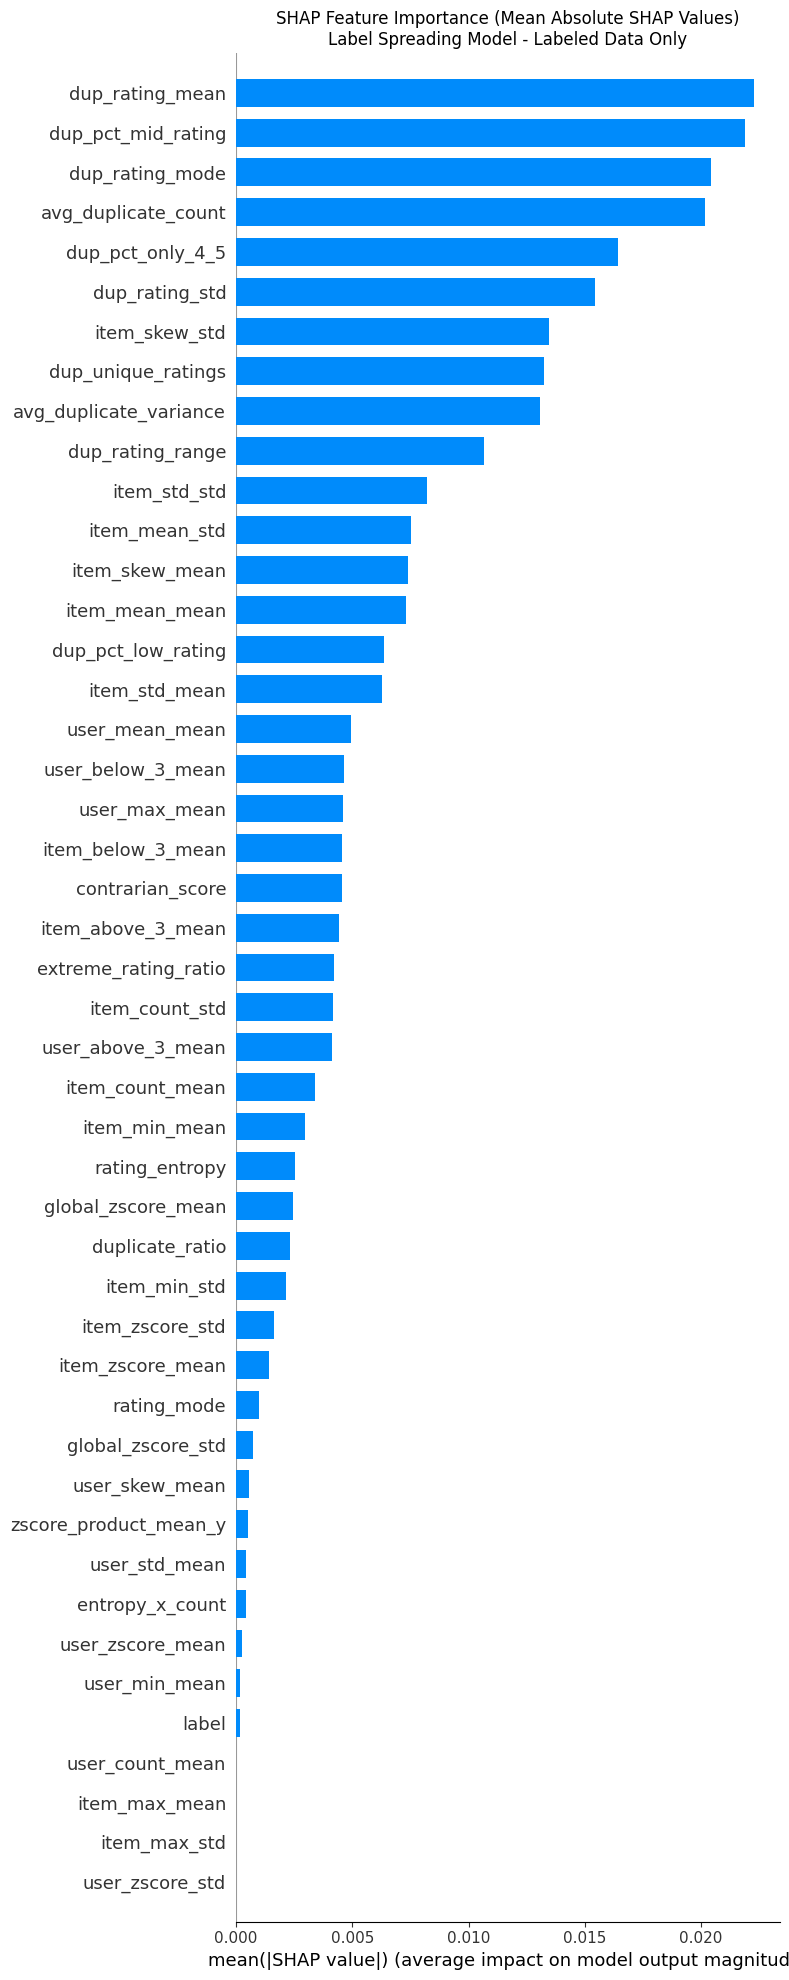

In [ ]:
# @title Label Spreading Feature Importance using SHAP
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading

# --- SHAP Analysis for Label Spreading ---
print("\n" + "="*70)
print("SHAP ANALYSIS FOR LABEL SPREADING")
print("(Using ALL LABELED data)")
print("="*70)

# ============================================
# STEP 1: Prepare the final trained model
# ============================================

print("\nPreparing final model with best parameters...")

# Combine all labeled and unlabeled data for training
X_full = pd.concat([X_semi_labeled, X_semi_unlabeled], ignore_index=True)
y_full = np.concatenate([y_semi_labeled.values, np.full(len(X_semi_unlabeled), -1)])

# Scale the full data
scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

# Create and train the best model
final_params = {
    'kernel': best_params['kernel'],
    'alpha': best_params['alpha'],
    'max_iter': 1000
}

if best_params['kernel'] == 'knn':
    final_params['n_neighbors'] = int(best_params['n_neighbors'])
else:
    final_params['gamma'] = best_params['gamma']

final_model = LabelSpreading(**final_params)
final_model.fit(X_full_scaled, y_full)

print(f"✓ Model trained with parameters: {final_params}")

# ============================================
# STEP 2: Prepare LABELED data only for SHAP
# ============================================

# Use ONLY LABELED data for SHAP analysis
X_labeled_scaled = X_full_scaled[:len(X_semi_labeled)]
y_labeled_values = y_semi_labeled.values

print(f"\nUsing ALL LABELED data for SHAP analysis:")
print(f"  Labeled samples: {len(X_labeled_scaled)}")
print(f"  Features: {X_semi_labeled.shape[1]}")
print(f"  Classes: {len(np.unique(y_labeled_values))}")

# Get feature names
feature_names = X_semi_labeled.columns.tolist()

# ============================================
# STEP 3: Use ALL LABELED data as background
# ============================================

print(f"\nUsing ALL LABELED data as background:")
print(f"  Background samples: {len(X_labeled_scaled)}")

X_background = X_labeled_scaled

# ============================================
# STEP 4: Create SHAP explainer
# ============================================

print("\nCreating SHAP KernelExplainer...")
print("⚠️  This may take some time (typically 10-30 minutes for ~45 samples)")

# Create a prediction function for SHAP
def model_predict(X):
    """Wrapper to get probability predictions"""
    return final_model.predict_proba(X)

# Create SHAP explainer
explainer = shap.KernelExplainer(model_predict, X_background)

# ============================================
# STEP 5: Calculate SHAP values for ALL LABELED data
# ============================================

print(f"\nCalculating SHAP values for ALL {len(X_labeled_scaled)} labeled samples...")

# Calculate SHAP values for ALL labeled samples
# nsamples='auto' will use 2*features+2048 samples for approximation
shap_values = explainer.shap_values(X_labeled_scaled, nsamples='auto')

print("✓ SHAP values calculated")

# ============================================
# STEP 6: Process SHAP values
# ============================================

print(f"\nSHAP values type: {type(shap_values)}")
print(f"SHAP values shape: {shap_values.shape}")

# Check if it's a 3D array (samples, features, classes)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    print(f"\nSHAP values shape (multi-class): {shap_values.shape}")
    print(f"  Samples: {shap_values.shape[0]}")
    print(f"  Features: {shap_values.shape[1]}")
    print(f"  Classes: {shap_values.shape[2]}")

    # Average across classes (axis=2): (60, 34, 3) -> (60, 34)
    shap_vals_avg = np.mean(np.abs(shap_values), axis=2)
    print(f"  Averaged across classes shape: {shap_vals_avg.shape}")

# Check if it's a list of arrays (older SHAP format)
elif isinstance(shap_values, list):
    print(f"\nSHAP values shape (multi-class list): {len(shap_values)} classes")
    print(f"  Each class shape: {shap_values[0].shape}")

    # Stack and average
    stacked = np.stack([np.abs(sv) for sv in shap_values], axis=-1)
    shap_vals_avg = np.mean(stacked, axis=-1)
    print(f"  Averaged shape: {shap_vals_avg.shape}")

# Single output case
else:
    shap_vals_avg = np.abs(shap_values)
    print(f"\nSHAP values shape: {shap_values.shape}")

# Calculate mean absolute SHAP values for each feature
# Average across samples (axis=0): (60, 34) -> (34,)
mean_abs_shap = shap_vals_avg.mean(axis=0)

print(f"\nMean absolute SHAP shape: {mean_abs_shap.shape}")
print(f"Number of features: {len(feature_names)}")

# ============================================
# STEP 7: Feature importance ranking
# ============================================

# Create a DataFrame with feature importance
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\n" + "="*70)
print("FEATURE IMPORTANCE (by mean absolute SHAP value)")
print("="*70)
print(shap_importance_df.to_string(index=False))

# ============================================
# STEP 8: Identify and Print Bottom 10 Features to Remove
# ============================================

# Get the bottom 10 features
bottom_10_features = shap_importance_df.tail(20)['Feature'].tolist()

print(f"\n" + "="*70)
print(f"FEATURES TO REMOVE (BOTTOM 10 BY SHAP IMPORTANCE)")
print("="*70)
print(f"\nFeatures ({len(bottom_10_features)}):")
for feat in bottom_10_features:
    shap_val = shap_importance_df[shap_importance_df['Feature'] == feat]['Mean_Abs_SHAP'].values[0]
    print(f" - {feat}: {shap_val:.6f}")

print("\nPython List Format for Removal:")
print(bottom_10_features)

# ============================================
# STEP 9: Visualizations
# ============================================

print("\n" + "="*70)
print("GENERATING SHAP VISUALIZATIONS")
print("="*70)

# 1. Summary plot (bar) - Feature importance
plt.figure(figsize=(10, 12))
# Use the averaged SHAP values for multi-class
shap.summary_plot(shap_vals_avg, X_labeled_scaled, feature_names=feature_names,
                 plot_type="bar", show=False, max_display=len(feature_names))
plt.title("SHAP Feature Importance (Mean Absolute SHAP Values)\nLabel Spreading Model - Labeled Data Only")
plt.tight_layout()
plt.show()




CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE
Label Spreading Model

Setup:
  Labeled samples: 60
  Unlabeled samples: 3540
  Total features: 46
  Classes: 3

Using best parameters from grid search:
  {'kernel': 'rbf', 'alpha': np.float64(0.8), 'max_iter': 1000, 'gamma': np.float64(0.1)}
  Best CV Accuracy: 0.9167

CALCULATING FEATURE IMPORTANCE
Testing each feature across 5 CV folds...
This will take approximately 30-60 minutes...


FOLD 1/5
  Train: 48 samples | Val: 12 samples

  [Baseline] Training with all features...
  [Baseline] Accuracy: 0.8333

  Testing 46 features...
    Progress: 5/46 features tested
    Progress: 10/46 features tested
    Progress: 15/46 features tested
    Progress: 20/46 features tested
    Progress: 25/46 features tested
    Progress: 30/46 features tested
    Progress: 35/46 features tested
    Progress: 40/46 features tested
    Progress: 45/46 features tested
  ✓ Fold 1 complete

FOLD 2/5
  Train: 48 samples | Val: 12 samples

  [Baseline] Training

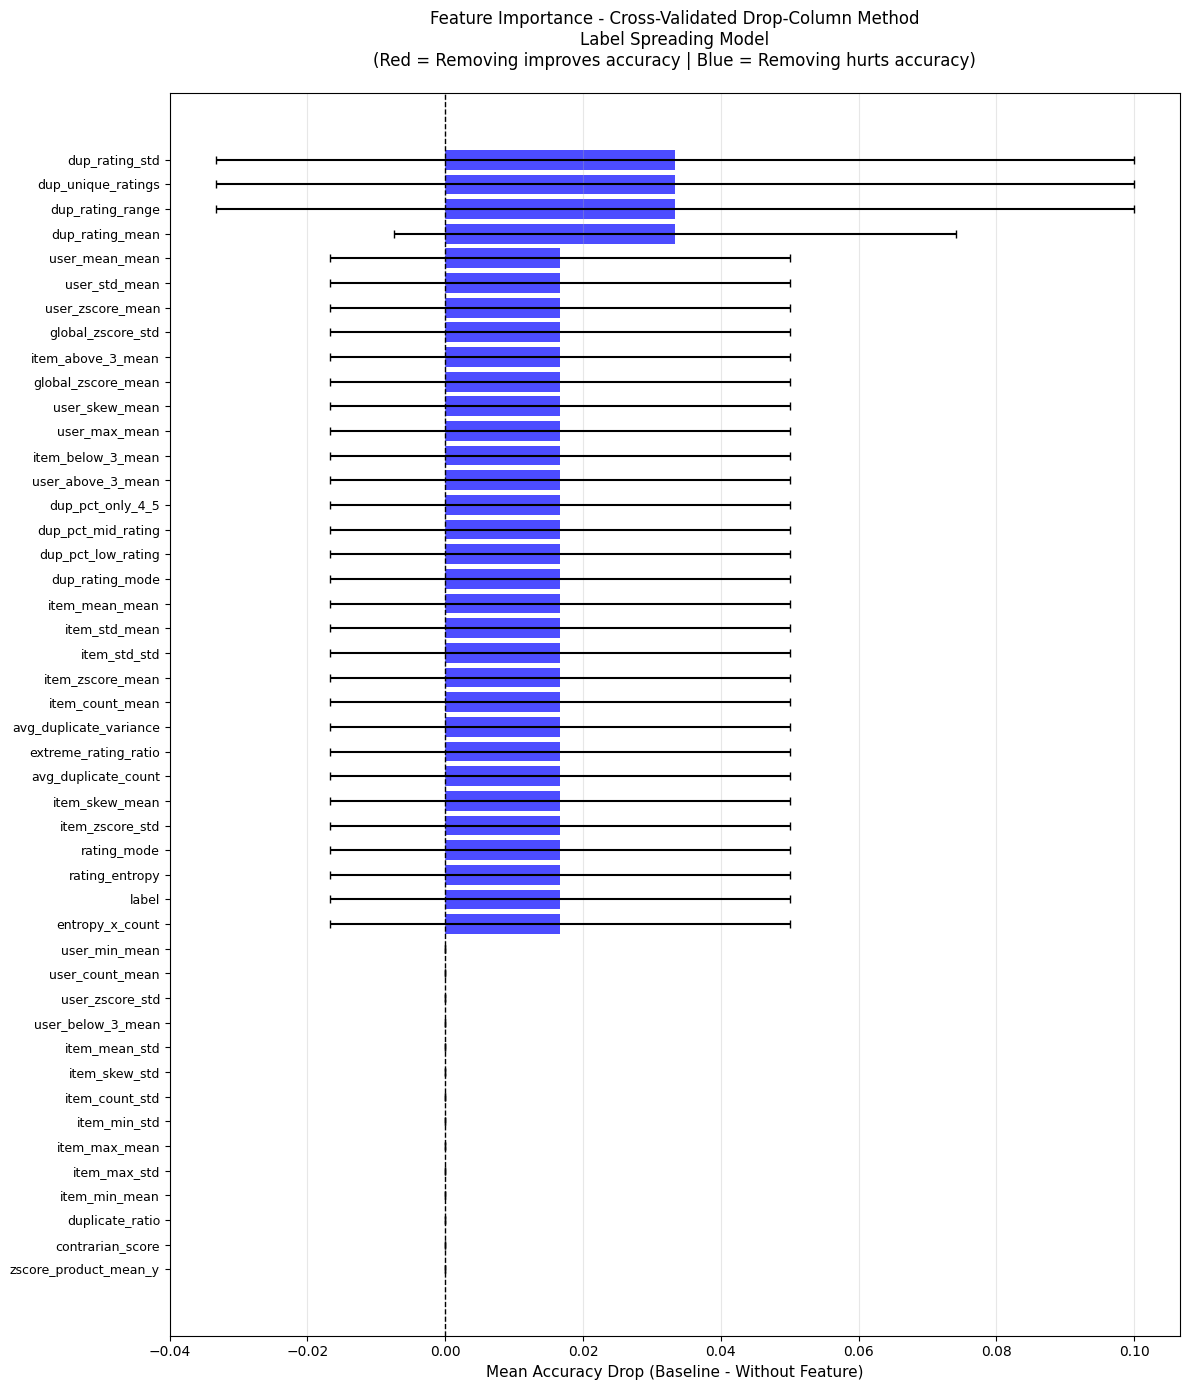

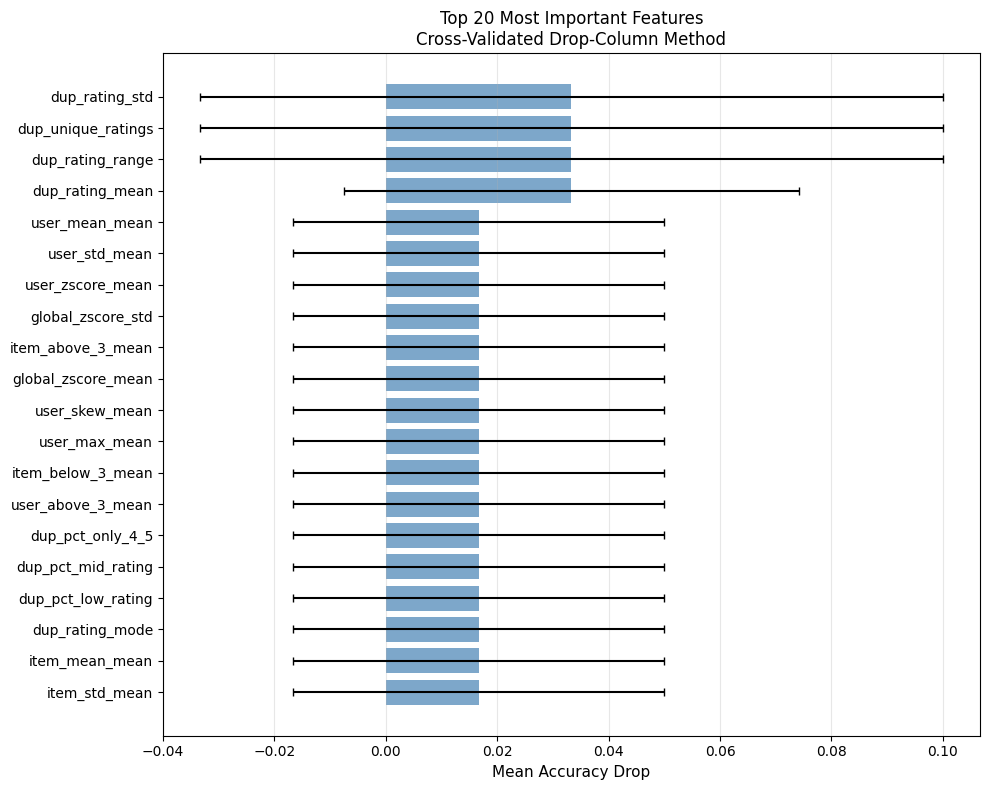

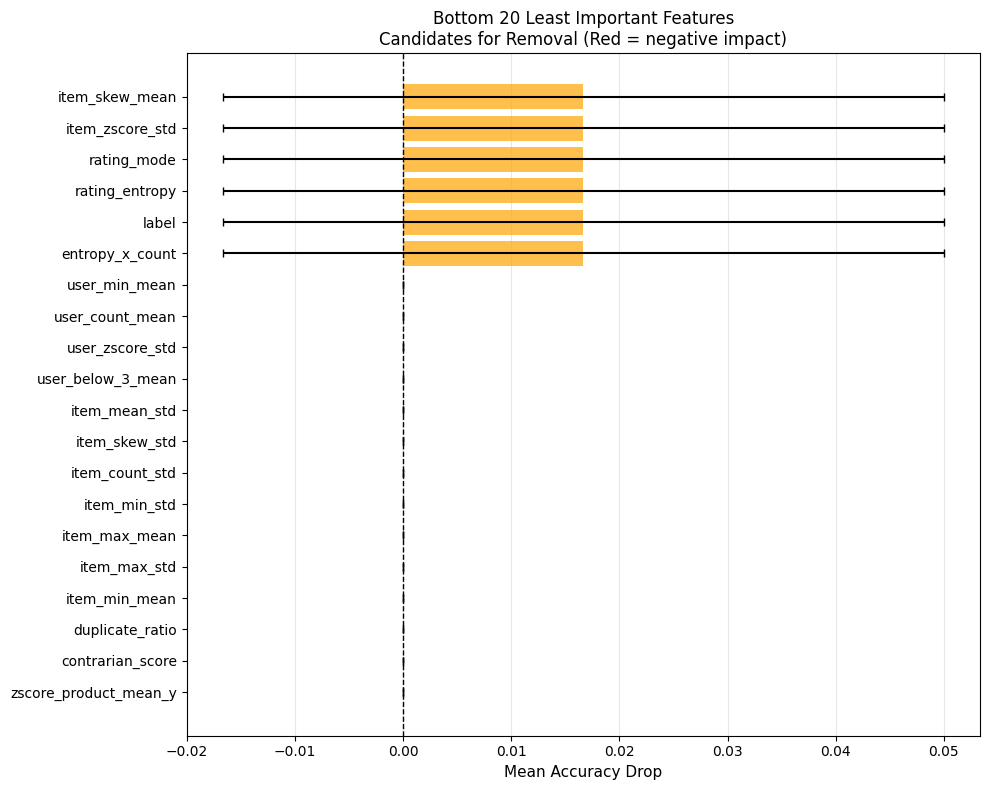

/tmp/ipython-input-836194568.py:259: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(top_20_data, labels=top_20_labels, vert=False)


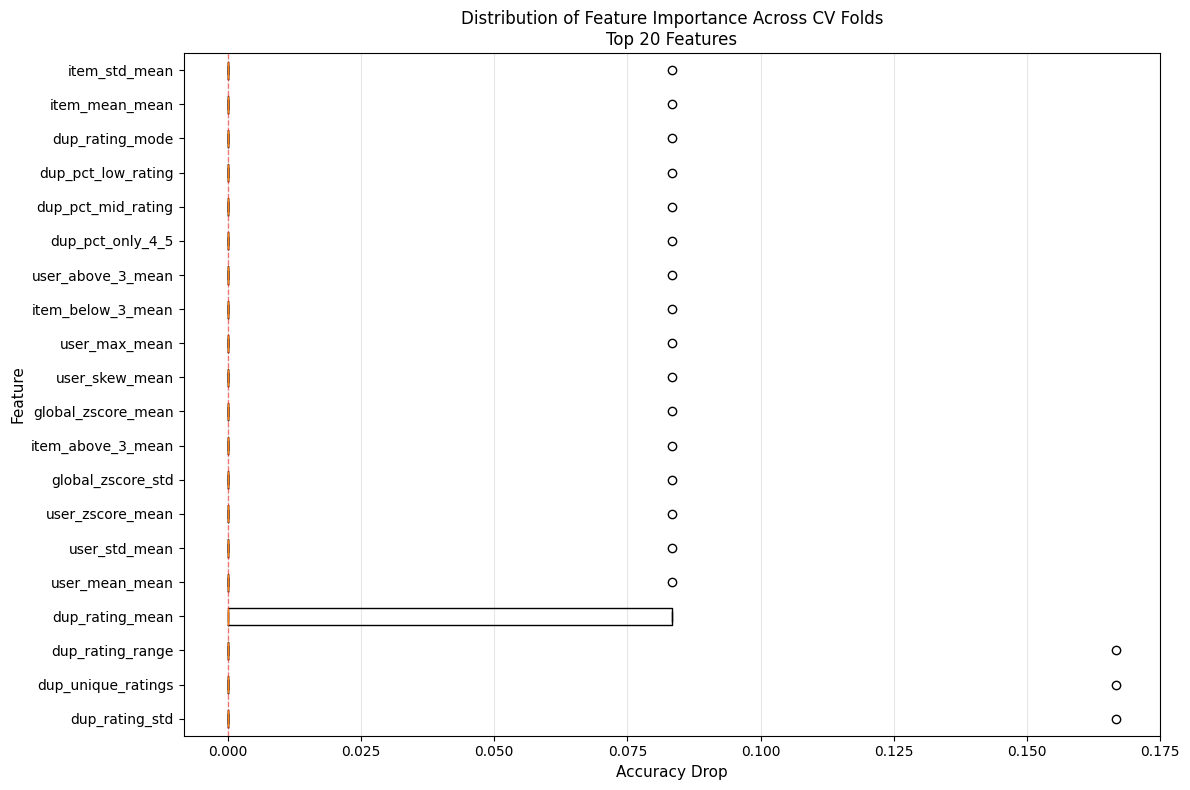


SUMMARY STATISTICS

Feature Importance Statistics:
  Mean importance: 0.013043
  Std importance: 0.009884
  Max importance: 0.033333
  Min importance: 0.000000

Feature Categories:
  High importance (> 0.01): 32
  Medium importance (0 to 0.01): 14
  Low/negative importance (< 0): 0

✓ CROSS-VALIDATED FEATURE IMPORTANCE COMPLETE

💡 NEXT STEPS:
  1. Review the bottom 20 features (candidates for removal)
  2. Consider removing features with negative mean importance
  3. Consider removing features in bottom 25% with high std (unstable)
  4. Retrain model without selected features and compare performance
  5. Use 'cv_importance_df' DataFrame for further analysis

DataFrame 'cv_importance_df' contains full results with 46 features

FINAL LIST OF RECOMMENDED FEATURES FOR REMOVAL
Total Features to Remove: 14
Python List Format:
['item_max_mean', 'contrarian_score', 'user_min_mean', 'user_zscore_std', 'item_mean_std', 'item_count_std', 'user_count_mean', 'item_min_mean', 'item_skew_std', 'item

In [ ]:
# @title Label Spreading Feature Importance using CV leave-one-out
# ============================================
# CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE
# For Label Spreading Model
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

print("\n" + "="*70)
print("CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE")
print("Label Spreading Model")
print("="*70)

# ============================================
# STEP 1: Setup
# ============================================

print("\nSetup:")
print(f"  Labeled samples: {len(X_semi_labeled)}")
print(f"  Unlabeled samples: {len(X_semi_unlabeled)}")
print(f"  Total features: {X_semi_labeled.shape[1]}")
print(f"  Classes: {len(y_semi_labeled.unique())}")

# Get feature names
feature_names = X_semi_labeled.columns.tolist()

# Get best parameters from grid search
final_params = {
    'kernel': best_params['kernel'],
    'alpha': best_params['alpha'],
    'max_iter': 1000
}

if best_params['kernel'] == 'knn':
    final_params['n_neighbors'] = int(best_params['n_neighbors'])
else:
    final_params['gamma'] = best_params['gamma']

print(f"\nUsing best parameters from grid search:")
print(f"  {final_params}")
print(f"  Best CV Accuracy: {best_params['mean_cv_accuracy']:.4f}")

# ============================================
# STEP 2: Cross-Validated Feature Importance
# ============================================

print("\n" + "="*70)
print("CALCULATING FEATURE IMPORTANCE")
print("="*70)
print("Testing each feature across 5 CV folds...")
print("This will take approximately 30-60 minutes...\n")

# Setup CV
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store importance for each feature across folds
cv_feature_importances = {feat: [] for feat in feature_names}
baseline_accuracies = []

# Loop through CV folds
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_semi_labeled, y_semi_labeled)):
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx + 1}/{n_folds}")
    print(f"{'='*70}")

    # Split labeled data
    X_train = X_semi_labeled.iloc[train_idx]
    y_train = y_semi_labeled.iloc[train_idx]
    X_val = X_semi_labeled.iloc[val_idx]
    y_val = y_semi_labeled.iloc[val_idx]

    print(f"  Train: {len(X_train)} samples | Val: {len(X_val)} samples")

    # Prepare semi-supervised data (combine train + unlabeled)
    X_train_unlabeled = pd.concat([X_train, X_semi_unlabeled], ignore_index=True)

    # Scale data
    scaler = StandardScaler()
    scaler.fit(X_train_unlabeled)
    X_train_scaled = scaler.transform(X_train)
    X_unlabeled_scaled = scaler.transform(X_semi_unlabeled)
    X_val_scaled = scaler.transform(X_val)

    # Combine scaled train + unlabeled for semi-supervised training
    X_semi_scaled = np.concatenate([X_train_scaled, X_unlabeled_scaled])
    y_semi = np.concatenate([y_train.values, np.full(len(X_semi_unlabeled), -1)])

    # Train baseline model (with ALL features)
    print("\n  [Baseline] Training with all features...")
    model_baseline = LabelSpreading(**final_params)
    model_baseline.fit(X_semi_scaled, y_semi)
    baseline_acc = accuracy_score(y_val, model_baseline.predict(X_val_scaled))
    baseline_accuracies.append(baseline_acc)
    print(f"  [Baseline] Accuracy: {baseline_acc:.4f}")

    # Test each feature by dropping it
    print(f"\n  Testing {len(feature_names)} features...")
    for i, feature in enumerate(feature_names):
        # Drop this feature from all datasets
        feature_mask = [j for j in range(len(feature_names)) if j != i]
        X_semi_dropped = X_semi_scaled[:, feature_mask]
        X_val_dropped = X_val_scaled[:, feature_mask]

        # Train model without this feature
        model_dropped = LabelSpreading(**final_params)
        model_dropped.fit(X_semi_dropped, y_semi)

        # Evaluate on validation
        dropped_acc = accuracy_score(y_val, model_dropped.predict(X_val_dropped))

        # Calculate importance (accuracy drop when feature is removed)
        importance = baseline_acc - dropped_acc
        cv_feature_importances[feature].append(importance)

        # Progress update every 5 features
        if (i + 1) % 5 == 0:
            print(f"    Progress: {i+1}/{len(feature_names)} features tested")

    print(f"  ✓ Fold {fold_idx + 1} complete")

# ============================================
# STEP 3: Aggregate Results
# ============================================

print("\n" + "="*70)
print("AGGREGATING RESULTS ACROSS FOLDS")
print("="*70)

# Calculate mean and std across folds
cv_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': [np.mean(cv_feature_importances[f]) for f in feature_names],
    'Importance_Std': [np.std(cv_feature_importances[f]) for f in feature_names],
    'Importance_Min': [np.min(cv_feature_importances[f]) for f in feature_names],
    'Importance_Max': [np.max(cv_feature_importances[f]) for f in feature_names]
}).sort_values('Importance_Mean', ascending=False)

# Add fold-by-fold importances as separate columns
for fold_idx in range(n_folds):
    cv_importance_df[f'Fold_{fold_idx+1}'] = [cv_feature_importances[f][fold_idx] for f in cv_importance_df['Feature']]

print(f"\nBaseline accuracies across folds:")
for fold_idx, acc in enumerate(baseline_accuracies):
    print(f"  Fold {fold_idx + 1}: {acc:.4f}")
print(f"  Mean: {np.mean(baseline_accuracies):.4f} (+/- {np.std(baseline_accuracies):.4f})")

# ============================================
# STEP 4: Display Results
# ============================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKING")
print("="*70)

print("\nTop 15 Most Important Features:")
print(cv_importance_df[['Feature', 'Importance_Mean', 'Importance_Std', 'Importance_Min', 'Importance_Max']].head(15).to_string(index=False))

print("\n" + "-"*70)

print("\nBottom 15 Least Important Features:")
print(cv_importance_df[['Feature', 'Importance_Mean', 'Importance_Std', 'Importance_Min', 'Importance_Max']].tail(15).to_string(index=False))

# ============================================
# STEP 5: Identify Features to Remove
# ============================================

print("\n" + "="*70)
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*70)

# Strategy 1: Features with negative mean importance
negative_importance = cv_importance_df[cv_importance_df['Importance_Mean'] < 0]
print(f"\nFeatures with NEGATIVE mean importance (removing them IMPROVES accuracy):")
print(f"Count: {len(negative_importance)}")
if len(negative_importance) > 0:
    print(negative_importance[['Feature', 'Importance_Mean', 'Importance_Std']].to_string(index=False))
else:
    print("  None found")

# Strategy 2: Features with near-zero importance (bottom 25%)
threshold_percentile = 25
importance_threshold = np.percentile(cv_importance_df['Importance_Mean'], threshold_percentile)
low_importance = cv_importance_df[cv_importance_df['Importance_Mean'] <= importance_threshold]

print(f"\nFeatures with LOW importance (bottom {threshold_percentile}%):")
print(f"Threshold: {importance_threshold:.6f}")
print(f"Count: {len(low_importance)}")
print(low_importance[['Feature', 'Importance_Mean', 'Importance_Std']].to_string(index=False))

# ============================================
# STEP 6: Visualizations
# ============================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Feature importance with error bars
plt.figure(figsize=(12, 14))
y_pos = range(len(feature_names))
colors = ['red' if x < 0 else 'blue' for x in cv_importance_df['Importance_Mean'][::-1]]
plt.barh(y_pos, cv_importance_df['Importance_Mean'][::-1],
         xerr=cv_importance_df['Importance_Std'][::-1],
         color=colors, alpha=0.7, capsize=3)
plt.yticks(y_pos, cv_importance_df['Feature'][::-1], fontsize=9)
plt.xlabel('Mean Accuracy Drop (Baseline - Without Feature)', fontsize=11)
plt.title('Feature Importance - Cross-Validated Drop-Column Method\nLabel Spreading Model\n(Red = Removing improves accuracy | Blue = Removing hurts accuracy)',
          fontsize=12, pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Top 20 features only (easier to read)
plt.figure(figsize=(10, 8))
top_20 = cv_importance_df.head(20)
y_pos_20 = range(len(top_20))
plt.barh(y_pos_20, top_20['Importance_Mean'][::-1],
         xerr=top_20['Importance_Std'][::-1],
         color='steelblue', alpha=0.7, capsize=3)
plt.yticks(y_pos_20, top_20['Feature'][::-1], fontsize=10)
plt.xlabel('Mean Accuracy Drop', fontsize=11)
plt.title('Top 20 Most Important Features\nCross-Validated Drop-Column Method', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Bottom 20 features (candidates for removal)
plt.figure(figsize=(10, 8))
bottom_20 = cv_importance_df.tail(20)
y_pos_bottom = range(len(bottom_20))
colors_bottom = ['red' if x < 0 else 'orange' for x in bottom_20['Importance_Mean'][::-1]]
plt.barh(y_pos_bottom, bottom_20['Importance_Mean'][::-1],
         xerr=bottom_20['Importance_Std'][::-1],
         color=colors_bottom, alpha=0.7, capsize=3)
plt.yticks(y_pos_bottom, bottom_20['Feature'][::-1], fontsize=10)
plt.xlabel('Mean Accuracy Drop', fontsize=11)
plt.title('Bottom 20 Least Important Features\nCandidates for Removal (Red = negative impact)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Distribution of importance across folds (box plot for top 20)
plt.figure(figsize=(12, 8))
top_20_data = []
top_20_labels = []
for feature in cv_importance_df.head(20)['Feature']:
    top_20_data.append(cv_feature_importances[feature])
    top_20_labels.append(feature)

plt.boxplot(top_20_data, labels=top_20_labels, vert=False)
plt.xlabel('Accuracy Drop', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Distribution of Feature Importance Across CV Folds\nTop 20 Features', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# STEP 7: Summary Statistics
# ============================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print(f"\nFeature Importance Statistics:")
print(f"  Mean importance: {cv_importance_df['Importance_Mean'].mean():.6f}")
print(f"  Std importance: {cv_importance_df['Importance_Mean'].std():.6f}")
print(f"  Max importance: {cv_importance_df['Importance_Mean'].max():.6f}")
print(f"  Min importance: {cv_importance_df['Importance_Mean'].min():.6f}")

print(f"\nFeature Categories:")
print(f"  High importance (> 0.01): {len(cv_importance_df[cv_importance_df['Importance_Mean'] > 0.01])}")
print(f"  Medium importance (0 to 0.01): {len(cv_importance_df[(cv_importance_df['Importance_Mean'] >= 0) & (cv_importance_df['Importance_Mean'] <= 0.01)])}")
print(f"  Low/negative importance (< 0): {len(cv_importance_df[cv_importance_df['Importance_Mean'] < 0])}")

print("\n" + "="*70)
print("✓ CROSS-VALIDATED FEATURE IMPORTANCE COMPLETE")
print("="*70)

print(f"\nDataFrame 'cv_importance_df' contains full results with {len(cv_importance_df)} features")
print("="*70)


# --- Feature Removal Strategy: Combine Negative and Near-Zero Mean Importance ---

# Features with NEGATIVE Mean Importance (removing them IMPROVES accuracy)
negative_importance_list = cv_importance_df[
    cv_importance_df['Importance_Mean'] < 0
]['Feature'].tolist()

low_importance_threshold = 0.005 # Placeholder value: Use actual importance_threshold
near_zero_importance_list = cv_importance_df[
    (cv_importance_df['Importance_Mean'] >= 0) &
    (cv_importance_df['Importance_Mean'] <= low_importance_threshold)
]['Feature'].tolist()

# Combine and Dedup the final list
features_to_remove = list(set(negative_importance_list + near_zero_importance_list))

print("\n" + "="*70)
print("FINAL LIST OF RECOMMENDED FEATURES FOR REMOVAL")
print("="*70)
print(f"Total Features to Remove: {len(features_to_remove)}")
print("Python List Format:")
print(features_to_remove)
print("="*70)


In [ ]:
# @title Self Training (Random Forest) Model + Grid Search Results
# ============================================
# GRID SEARCH WITH CV FOR SELF-TRAINING (RANDOM FOREST)
# ============================================

print("\n" + "="*70)
print("GRID SEARCH WITH CROSS-VALIDATION - SELF-TRAINING")
print("="*70)

from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# REMOVED: from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# ============================================
# STEP 1: Define hyperparameter grid
# ============================================

param_grid = {
    # Self-Training parameters
    'threshold': [0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
    'max_iter': [20],

    # Random Forest parameters
    'n_estimators': [300],
    'max_depth': [3, 6, 9, 15],
    'max_features': ['sqrt']
}

print(f"\nHyperparameter Grid:")
print(f"  Self-Training Parameters:")
print(f"    threshold: {param_grid['threshold']}")
print(f"    max_iter: {param_grid['max_iter']}")
print(f"  Random Forest Parameters:")
print(f"    n_estimators: {param_grid['n_estimators']}")
print(f"    max_depth: {param_grid['max_depth']}")
print(f"    max_features: {param_grid['max_features']}")

# Calculate total combinations
n_st = len(param_grid['threshold']) * len(param_grid['max_iter'])
n_rf = (len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['max_features']))
total_combinations = n_st * n_rf
print(f"\nTotal combinations: {total_combinations}")

# ============================================
# STEP 2: Setup CV (Assuming X_semi_labeled, y_semi_labeled, X_semi_unlabeled are defined)
# ============================================

n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Using a try-except block for demonstration/safety if data is not defined
try:
    X_labeled = X_semi_labeled.copy()
    y_labeled = y_semi_labeled.copy()
    X_unlabeled = X_semi_unlabeled.copy()
except NameError:
    print("WARNING: Data variables not found. Creating dummy data.")
    from sklearn.datasets import make_classification
    X_full, y_full = make_classification(n_samples=200, n_features=10, n_informative=5, n_redundant=0, n_classes=2, random_state=42)
    labeled_size = 100
    X_labeled = pd.DataFrame(X_full[:labeled_size])
    y_labeled = pd.Series(y_full[:labeled_size])
    X_unlabeled = pd.DataFrame(X_full[labeled_size:])


print(f"\nCV Setup:")
print(f"  Labeled samples: {len(X_labeled)}")
print(f"  Unlabeled samples: {len(X_unlabeled)}")
print(f"  CV folds: {n_folds}")

# ============================================
# STEP 3: Grid Search (SCALING REMOVED)
# ============================================

print(f"\n{'='*70}")
print(f"STARTING GRID SEARCH (Scaling Removed)")
print(f"{'='*70}")

# Store results for each parameter combination
grid_search_results = []
param_counter = 0

# Loop through Random Forest parameters
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for max_features in param_grid['max_features']:

            # Loop through Self-Training parameters
            for threshold in param_grid['threshold']:
                for max_iter in param_grid['max_iter']:

                    param_counter += 1

                    params = {
                        'threshold': threshold,
                        'max_iter': max_iter,
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'max_features': max_features
                    }

                    print(f"\n[{param_counter}/{total_combinations}] Testing:")
                    print(f"  ST: threshold={threshold}, max_iter={max_iter}")
                    print(f"  RF: n_est={n_estimators}, max_depth={max_depth}, max_feat={max_features}")

                    # Cross-validation for this parameter combination
                    fold_accuracies = []

                    for fold, (train_idx, val_idx) in enumerate(cv.split(X_labeled, y_labeled)):
                        # --- NO SCALING ---
                        # 1. Split labeled data
                        X_train = X_labeled.iloc[train_idx]
                        y_train = y_labeled.iloc[train_idx]
                        X_val = X_labeled.iloc[val_idx]
                        y_val = y_labeled.iloc[val_idx]

                        # 2. Combine train with unlabeled data for model fitting
                        # Data is USED AS IS (no scaling needed)
                        X_semi = pd.concat([X_train, X_unlabeled], ignore_index=True)

                        # The y labels remain the same (labeled data + -1 for unlabeled)
                        y_semi = np.concatenate([
                            y_train.values,
                            np.full(len(X_unlabeled), -1)
                        ])
                        # --- END NO SCALING ---

                        # Create base classifier
                        base_classifier = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            max_features=max_features,
                            random_state=42
                        )

                        # Create self-training classifier
                        model = SelfTrainingClassifier(
                            estimator=base_classifier,
                            threshold=threshold,
                            criterion='threshold',
                            max_iter=max_iter,
                            verbose=False
                        )

                        # Train model (using unscaled X_semi)
                        model.fit(X_semi, y_semi)

                        # Predict on validation (using unscaled X_val)
                        y_pred = model.predict(X_val)
                        accuracy = accuracy_score(y_val, y_pred)
                        fold_accuracies.append(accuracy)

                    # Calculate mean and std
                    mean_acc = np.mean(fold_accuracies)
                    std_acc = np.std(fold_accuracies)

                    print(f"  Mean CV Accuracy: {mean_acc:.4f} (+/- {std_acc:.4f})")

                    # Store results
                    grid_search_results.append({
                        'threshold': threshold,
                        'max_iter': max_iter,
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'max_features': max_features,
                        'mean_cv_accuracy': mean_acc,
                        'std_cv_accuracy': std_acc,
                        'fold_accuracies': fold_accuracies
                    })

# ============================================
# STEP 4: Find Best Parameters
# ============================================

print(f"\n{'='*70}")
print(f"GRID SEARCH RESULTS")
print(f"{'='*70}")

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(grid_search_results)

# Sort by mean CV accuracy (descending)
results_df = results_df.sort_values('mean_cv_accuracy', ascending=False).reset_index(drop=True)

print(f"\nTop 50 parameter combinations:")
print(results_df[['threshold', 'max_iter', 'n_estimators',
                  'max_depth', 'max_features',
                  'mean_cv_accuracy', 'std_cv_accuracy']].head(50))

# Best parameters
best_params = results_df.iloc[0]

print(f"\n{'='*70}")
print(f"BEST PARAMETERS")
print(f"{'='*70}")
print(f"  Self-Training Parameters:")
print(f"    threshold: {best_params['threshold']}")
print(f"    max_iter: {best_params['max_iter']}")
print(f"  Random Forest Parameters:")
print(f"    n_estimators: {best_params['n_estimators']}")
print(f"    max_depth: {best_params['max_depth']}")
print(f"    max_features: {best_params['max_features']}")
print(f"\n  Mean CV Accuracy: {best_params['mean_cv_accuracy']:.4f}")
print(f"  Std CV Accuracy:  {best_params['std_cv_accuracy']:.4f}")

# ============================================
# STEP 5: Save Results
# ============================================

print(f"\n💾 Storing results...")
print(f"  'results_df': DataFrame with all {len(results_df)} parameter combinations")
print(f"  'best_params': Dictionary with best hyperparameters")

print("\n" + "="*70)
print("✓ GRID SEARCH COMPLETE")
print("="*70)

# ============================================
# OPTIONAL: Visualize Results
# ============================================

print(f"\n📊 Results Summary:")
print(f"  Total combinations tested: {len(results_df)}")
print(f"  Best accuracy: {results_df['mean_cv_accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_df['mean_cv_accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_df['mean_cv_accuracy'].mean():.4f}")

# Show performance by criterion
print(f"\nPerformance by threshold:")
for threshold in sorted(results_df['threshold'].unique()):
    threshold_results = results_df[results_df['threshold'] == threshold]
    print(f"  {threshold}: {threshold_results['mean_cv_accuracy'].mean():.4f} (best: {threshold_results['mean_cv_accuracy'].max():.4f})")

# Show performance by number of estimators
print(f"\nPerformance by n_estimators:")
for n_est in sorted(results_df['n_estimators'].unique()):
    n_est_results = results_df[results_df['n_estimators'] == n_est]
    print(f"  {n_est}: {n_est_results['mean_cv_accuracy'].mean():.4f} (best: {n_est_results['mean_cv_accuracy'].max():.4f})")


GRID SEARCH WITH CROSS-VALIDATION - SELF-TRAINING

Hyperparameter Grid:
  Self-Training Parameters:
    threshold: [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    max_iter: [20]
  Random Forest Parameters:
    n_estimators: [300]
    max_depth: [3, 6, 9, 15]
    max_features: ['sqrt']

Total combinations: 24

CV Setup:
  Labeled samples: 60
  Unlabeled samples: 3540
  CV folds: 5

STARTING GRID SEARCH (Scaling Removed)

[1/24] Testing:
  ST: threshold=0.6, max_iter=20
  RF: n_est=300, max_depth=3, max_feat=sqrt
  Mean CV Accuracy: 0.9167 (+/- 0.0527)

[2/24] Testing:
  ST: threshold=0.7, max_iter=20
  RF: n_est=300, max_depth=3, max_feat=sqrt
  Mean CV Accuracy: 0.9167 (+/- 0.0527)

[3/24] Testing:
  ST: threshold=0.8, max_iter=20
  RF: n_est=300, max_depth=3, max_feat=sqrt
  Mean CV Accuracy: 0.9167 (+/- 0.0527)

[4/24] Testing:
  ST: threshold=0.9, max_iter=20
  RF: n_est=300, max_depth=3, max_feat=sqrt
  Mean CV Accuracy: 0.9167 (+/- 0.0527)

[5/24] Testing:
  ST: threshold=0.95, max_iter=20


In [ ]:
# @title Self Training (Random Forest) final training results
# ============================================
# STEP 6: Calculate Predicted Class Counts 🔢
# ============================================
print(f"\n{'='*70}")
print(f"PREDICTED CLASS DISTRIBUTION COUNTS")
print(f"{'='*70}")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of labeled samples
N_LABELED = len(X_labeled)
N_UNLABELED = len(X_unlabeled)

# 2. NO SCALING for Random Forest (works well with raw features)
# Random Forest is scale-invariant, so we use data as-is

# 3. Re-train the BEST Self-Training Model on ALL available data
print(f"Retraining best Self-Training + Random Forest model on full dataset...")
print(f"  Self-Training Parameters:")
print(f"    threshold: {best_params['threshold']}")
print(f"    max_iter: {best_params['max_iter']}")
print(f"  Random Forest Parameters:")
print(f"    n_estimators: {best_params['n_estimators']}")
print(f"    max_depth: {best_params['max_depth']}")
print(f"    max_features: {best_params['max_features']}")

# Create base classifier with best parameters
base_classifier = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    random_state=42
)

# Create self-training classifier with best parameters
final_model = SelfTrainingClassifier(
    estimator=base_classifier,
    threshold=best_params['threshold'],
    criterion='threshold',
    max_iter=int(best_params['max_iter']),
    verbose=True  # Show progress
)

# Fit model on full dataset
final_model.fit(X_full, y_full)

print("Final Self-Training model trained.")

# 4. Predict labels for the entire dataset
y_predicted_full = final_model.predict(X_full)

# 5. Get prediction confidence/probabilities
y_predicted_probs = final_model.predict_proba(X_full)
prediction_confidence = y_predicted_probs.max(axis=1)

# 6. Get information about labeled samples during training
# The transduction_ attribute shows which samples were labeled by self-training
transduction_labels = final_model.transduction_

# Check which unlabeled samples were actually labeled during self-training
labeled_mask = y_full != -1  # Originally labeled
newly_labeled = (y_full == -1) & (transduction_labels != -1)  # Labeled by self-training
still_unlabeled = (y_full == -1) & (transduction_labels == -1)  # Never labeled

print(f"\nSelf-Training Statistics:")
print(f"  Originally labeled: {labeled_mask.sum()}")
print(f"  Newly labeled by self-training: {newly_labeled.sum()}")
print(f"  Still unlabeled: {still_unlabeled.sum()}")

# 7. Split predictions for labeled data
y_labeled_true = y_labeled.values
y_labeled_pred = y_predicted_full[:N_LABELED]
y_unlabeled_pred = y_predicted_full[N_LABELED:]

# 8. Calculate Accuracy for Labeled Data
labeled_accuracy = accuracy_score(y_labeled_true, y_labeled_pred)
print(f"\n✓ Labeled Data Accuracy: {labeled_accuracy:.4f} ({int(labeled_accuracy * N_LABELED)}/{N_LABELED} correct)")

# 9. Generate Confusion Matrix for Labeled Data
print(f"\n{'='*70}")
print("CONFUSION MATRIX - LABELED DATA")
print(f"{'='*70}")

conf_matrix = confusion_matrix(y_labeled_true, y_labeled_pred)
class_labels = sorted(np.unique(y_labeled_true))

# Create a formatted confusion matrix DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f'True Class {i}' for i in class_labels],
    columns=[f'Pred Class {i}' for i in class_labels]
)

print("\nConfusion Matrix:")
print(conf_matrix_df)

# Calculate per-class accuracy
print("\nPer-Class Performance (Labeled Data):")
print("-" * 60)
for i, class_label in enumerate(class_labels):
    true_positives = conf_matrix[i, i]
    total_true = conf_matrix[i, :].sum()
    class_accuracy = true_positives / total_true if total_true > 0 else 0
    print(f"  Class {class_label}: {true_positives}/{total_true} correct ({class_accuracy:.2%})")

# 10. Generate Classification Report
print(f"\n{'='*70}")
print("CLASSIFICATION REPORT - LABELED DATA")
print(f"{'='*70}")
print(classification_report(y_labeled_true, y_labeled_pred,
                          target_names=[f'Class {i}' for i in class_labels],
                          digits=4))

# 11. Calculate and Display Counts
print(f"\n{'='*70}")
print("PREDICTED CLASS DISTRIBUTION")
print(f"{'='*70}")

# Convert to DataFrame for easy handling
distribution_df = pd.DataFrame({
    'Predicted_Label': y_predicted_full.astype(int),
    'Confidence': prediction_confidence,
    'Original_Label': y_full,
    'Transduction_Label': transduction_labels,
    'Is_Originally_Labeled': labeled_mask,
    'Was_Self_Labeled': newly_labeled
})

# Add true labels for labeled portion
distribution_df['True_Label'] = np.concatenate([y_labeled_true, np.full(N_UNLABELED, -1)])

# Calculate counts for labeled data (with correctness)
labeled_df = distribution_df[distribution_df['Is_Originally_Labeled'] == True].copy()
labeled_correct = labeled_df[labeled_df['Predicted_Label'] == labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_incorrect = labeled_df[labeled_df['Predicted_Label'] != labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_total = labeled_df.groupby('Predicted_Label').size()

# Calculate counts for unlabeled data
unlabeled_counts = distribution_df[distribution_df['Is_Originally_Labeled'] == False]['Predicted_Label'].value_counts().sort_index()
self_labeled_counts = distribution_df[distribution_df['Was_Self_Labeled'] == True]['Predicted_Label'].value_counts().sort_index()

# Combine and format the results table
all_labels = sorted(distribution_df['Predicted_Label'].unique())
all_counts = pd.DataFrame(index=all_labels)

all_counts['Labeled_Correct'] = labeled_correct
all_counts['Labeled_Incorrect'] = labeled_incorrect
all_counts['Labeled_Total'] = labeled_total
all_counts['Originally_Unlabeled'] = unlabeled_counts
all_counts['Self_Labeled_Subset'] = self_labeled_counts
all_counts = all_counts.fillna(0).astype(int)
all_counts['Total_Samples'] = all_counts['Labeled_Total'] + all_counts['Originally_Unlabeled']

# Add accuracy column
all_counts['Labeled_Accuracy'] = (all_counts['Labeled_Correct'] / all_counts['Labeled_Total']).fillna(0)
all_counts['Labeled_Accuracy'] = all_counts['Labeled_Accuracy'].apply(lambda x: f"{x:.2%}")

print("\nFinal Predicted Class Distribution:")
print("-" * 100)
print(all_counts)

# 12. Additional Statistics
print(f"\n{'='*70}")
print(f"PREDICTION CONFIDENCE STATISTICS")
print(f"{'='*70}")

# Confidence statistics for originally labeled data
labeled_confidence = distribution_df[distribution_df['Is_Originally_Labeled'] == True]['Confidence']
print(f"\nOriginally Labeled Data Predictions:")
print(f"  Mean Confidence: {labeled_confidence.mean():.4f}")
print(f"  Std Confidence:  {labeled_confidence.std():.4f}")
print(f"  Min Confidence:  {labeled_confidence.min():.4f}")
print(f"  Max Confidence:  {labeled_confidence.max():.4f}")

# Confidence statistics for self-labeled data
if newly_labeled.sum() > 0:
    self_labeled_confidence = distribution_df[distribution_df['Was_Self_Labeled'] == True]['Confidence']
    print(f"\nSelf-Labeled Data (during training):")
    print(f"  Mean Confidence: {self_labeled_confidence.mean():.4f}")
    print(f"  Std Confidence:  {self_labeled_confidence.std():.4f}")
    print(f"  Min Confidence:  {self_labeled_confidence.min():.4f}")
    print(f"  Max Confidence:  {self_labeled_confidence.max():.4f}")

# Confidence statistics for still unlabeled data
if still_unlabeled.sum() > 0:
    print(f"\nStill Unlabeled Data (final predictions):")
    print(f"  Count: {still_unlabeled.sum()}")
    print(f"  Mean Confidence: {distribution_df[still_unlabeled]['Confidence'].mean():.4f}")

# Show confidence distribution by class for unlabeled predictions
print(f"\nUnlabeled Prediction Confidence by Class:")
for label in all_labels:
    class_mask = (distribution_df['Predicted_Label'] == label) & (distribution_df['Is_Originally_Labeled'] == False)
    class_confidence = distribution_df[class_mask]['Confidence']
    if len(class_confidence) > 0:
        print(f"  Class {label}: {class_confidence.mean():.4f} (+/- {class_confidence.std():.4f}) "
              f"[n={len(class_confidence)}]")

# Show self-labeling iterations if available
print(f"\n{'='*70}")
print(f"SELF-TRAINING ITERATIONS")
print(f"{'='*70}")
print(f"Max iterations allowed: {best_params['max_iter']}")
print(f"Confidence threshold: {best_params['threshold']}")
print(f"Samples labeled during training: {newly_labeled.sum()}")
if newly_labeled.sum() > 0:
    print(f"Average confidence of self-labeled samples: {self_labeled_confidence.mean():.4f}")

print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Total Originally Labeled: {N_LABELED}")
print(f"  Correctly Predicted: {(y_labeled_true == y_labeled_pred).sum()} ({labeled_accuracy:.2%})")
print(f"  Incorrectly Predicted: {(y_labeled_true != y_labeled_pred).sum()} ({1-labeled_accuracy:.2%})")
print(f"\nTotal Originally Unlabeled: {N_UNLABELED}")
print(f"  └─ Self-Labeled: {newly_labeled.sum()} ({newly_labeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"  └─ Still Unlabeled: {still_unlabeled.sum()} ({still_unlabeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"Total Dataset: {len(X_full)}")
print(f"Number of Classes: {len(all_labels)}")
print(f"Best CV Accuracy: {best_params['mean_cv_accuracy']:.4f}")
print(f"{'='*70}")

In [ ]:
# @title Self Training (Random Forest) t-SNE visualisations
# ============================================
# STEP 7: Visualize Label Space (t-SNE) 📊
# ============================================
print(f"\n{'='*70}")
print(f"VISUALIZING LABEL SPACE (t-SNE)")
print(f"{'='*70}")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of labeled samples and classes
N_LABELED = len(X_labeled)
N_UNLABELED = len(X_unlabeled)
N_CLASSES_TRUE = len(np.unique(y_labeled))

# 2. NO SCALING for Random Forest (Random Forest doesn't require scaling)

# 3. Re-train the BEST Self-Training Model on ALL available data
print(f"Retraining best Self-Training + Random Forest model on full dataset...")
print(f"  Self-Training Parameters:")
print(f"    threshold: {best_params['threshold']}")
print(f"    max_iter: {best_params['max_iter']}")
print(f"  Random Forest Parameters:")
print(f"    n_estimators: {best_params['n_estimators']}")
print(f"    max_depth: {best_params['max_depth']}")
print(f"    max_features: {best_params['max_features']}")

# Create base classifier with best parameters
base_classifier = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    random_state=42
)

# Create self-training classifier with best parameters
final_model = SelfTrainingClassifier(
    estimator=base_classifier,
    threshold=best_params['threshold'],
    criterion='threshold',
    max_iter=int(best_params['max_iter']),
    verbose=False
)

# Fit model on full dataset
final_model.fit(X_full, y_full)
print("Final Self-Training model trained.")

# 4. Extract "Features" (The probability distributions from Random Forest)
# Use probability distributions as high-dimensional features for t-SNE
X_features = final_model.predict_proba(X_full)

print(f"Probability distribution shape: {X_features.shape}")
print(f"  (N_samples={X_features.shape[0]}, N_classes={X_features.shape[1]})")

# Get self-training information
transduction_labels = final_model.transduction_
labeled_mask = y_full != -1
newly_labeled = (y_full == -1) & (transduction_labels != -1)
still_unlabeled = (y_full == -1) & (transduction_labels == -1)

print(f"\nSelf-Training Statistics:")
print(f"  Originally labeled: {labeled_mask.sum()}")
print(f"  Newly labeled by self-training: {newly_labeled.sum()}")
print(f"  Still unlabeled: {still_unlabeled.sum()}")

# 5. Run t-SNE
print("Running t-SNE for dimensionality reduction on probability distributions...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    learning_rate='auto',
    init='pca',
    n_jobs=-1
)
X_tsne = tsne.fit_transform(X_features)
print("t-SNE complete.")

# 6. Prepare Plotting Data Structure
# Create label vector for plotting
y_true_all = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])
y_plot = y_true_all.astype(str)
y_plot[len(y_labeled):] = 'Unlabeled'

# Create DataFrame
plot_df = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'])
plot_df['Label'] = y_plot

# Map labeled classes
label_mapping = {str(i): f'Class {i}' for i in range(N_CLASSES_TRUE)}
label_mapping['Unlabeled'] = 'Unlabeled'
plot_df['Label'] = plot_df['Label'].map(label_mapping).fillna('Unlabeled')

# Add prediction and self-training info
plot_df['Prediction'] = final_model.predict(X_full).astype(str)
plot_df['Prediction'] = plot_df['Prediction'].apply(lambda x: f'Pred: Class {x}')
plot_df['Confidence'] = X_features.max(axis=1)
plot_df['Was_Self_Labeled'] = newly_labeled
plot_df['Is_Originally_Labeled'] = labeled_mask

# Sort to ensure smaller points are plotted first
categories = ['Unlabeled'] + [f'Class {i}' for i in range(N_CLASSES_TRUE)]
plot_df['Label'] = pd.Categorical(plot_df['Label'], categories=categories)
plot_df = plot_df.sort_values(by='Label')

# 7. Plotting - Comprehensive Visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Define colors and sizes
colors = plt.cm.get_cmap('Dark2', N_CLASSES_TRUE)
color_map = {f'Class {i}': colors(i) for i in range(N_CLASSES_TRUE)}
color_map['Unlabeled'] = '#cccccc'
size_map = {'Unlabeled': 5, **{f'Class {i}': 40 for i in range(N_CLASSES_TRUE)}}

# LEFT PLOT: Original True Labels
ax1 = axes[0]
for label, data in plot_df.groupby('Label'):
    ax1.scatter(
        data['TSNE_1'], data['TSNE_2'],
        c=[color_map[label]], s=size_map[label],
        label=label, alpha=0.7,
        marker='o' if label != 'Unlabeled' else '.',
        edgecolors='black' if label != 'Unlabeled' else 'none',
        linewidths=0.5
    )

ax1.set_title(f't-SNE: Original Labels\n(Best Self-Training Model, CV Acc: {best_params["mean_cv_accuracy"]:.4f})',
              fontsize=13, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax1.legend(title='Sample Type', loc='best', framealpha=0.9, fontsize=9)
ax1.grid(True, linestyle=':', alpha=0.4)

# MIDDLE PLOT: Self-Labeled vs. Not Self-Labeled
ax2 = axes[1]

# Originally labeled (show as larger points with true labels)
for label in [f'Class {i}' for i in range(N_CLASSES_TRUE)]:
    mask = (plot_df['Label'] == label) & (plot_df['Is_Originally_Labeled'])
    if mask.sum() > 0:
        ax2.scatter(
            plot_df.loc[mask, 'TSNE_1'],
            plot_df.loc[mask, 'TSNE_2'],
            c=[color_map[label]], s=40,
            label=f'{label} (Original)', alpha=0.8,
            marker='o',
            edgecolors='black',
            linewidths=0.8
        )

# Self-labeled during training (show as stars)
self_labeled_mask = plot_df['Was_Self_Labeled']
if self_labeled_mask.sum() > 0:
    scatter_self = ax2.scatter(
        plot_df.loc[self_labeled_mask, 'TSNE_1'],
        plot_df.loc[self_labeled_mask, 'TSNE_2'],
        c=plot_df.loc[self_labeled_mask, 'Confidence'],
        s=80,
        cmap='viridis',
        alpha=0.7,
        marker='*',
        edgecolors='red',
        linewidths=1,
        vmin=best_params['threshold'], vmax=1,
        label=f'Self-Labeled (n={self_labeled_mask.sum()})'
    )
    cbar1 = plt.colorbar(scatter_self, ax=ax2)
    cbar1.set_label('Self-Label Confidence', fontsize=10)

# Still unlabeled (show as small gray dots)
still_unlabeled_mask = ~plot_df['Is_Originally_Labeled'] & ~plot_df['Was_Self_Labeled']
if still_unlabeled_mask.sum() > 0:
    ax2.scatter(
        plot_df.loc[still_unlabeled_mask, 'TSNE_1'],
        plot_df.loc[still_unlabeled_mask, 'TSNE_2'],
        c='#cccccc',
        s=10,
        alpha=0.4,
        marker='.',
        label=f'Never Labeled (n={still_unlabeled_mask.sum()})'
    )

ax2.set_title(f't-SNE: Self-Training Progress\n(Threshold={best_params["threshold"]}, Self-Labeled: {self_labeled_mask.sum()})',
              fontsize=13, fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax2.legend(title='Sample Status', loc='best', framealpha=0.9, fontsize=8)
ax2.grid(True, linestyle=':', alpha=0.4)

# RIGHT PLOT: Final Predictions with Confidence
ax3 = axes[2]

# Originally labeled points
for label in [f'Class {i}' for i in range(N_CLASSES_TRUE)]:
    mask = (plot_df['Label'] == label) & (plot_df['Is_Originally_Labeled'])
    if mask.sum() > 0:
        ax3.scatter(
            plot_df.loc[mask, 'TSNE_1'],
            plot_df.loc[mask, 'TSNE_2'],
            c=[color_map[label]], s=40,
            label=f'{label} (Original)', alpha=0.8,
            marker='o',
            edgecolors='black',
            linewidths=0.8
        )

# All unlabeled predictions colored by confidence
unlabeled_mask = ~plot_df['Is_Originally_Labeled']
if unlabeled_mask.sum() > 0:
    scatter_pred = ax3.scatter(
        plot_df.loc[unlabeled_mask, 'TSNE_1'],
        plot_df.loc[unlabeled_mask, 'TSNE_2'],
        c=plot_df.loc[unlabeled_mask, 'Confidence'],
        s=25,
        cmap='plasma',
        alpha=0.6,
        marker='o',
        edgecolors='gray',
        linewidths=0.3,
        vmin=0, vmax=1
    )
    cbar2 = plt.colorbar(scatter_pred, ax=ax3)
    cbar2.set_label('Prediction Confidence', fontsize=10)

ax3.set_title(f't-SNE: Final Predictions\n(All unlabeled colored by confidence)',
              fontsize=13, fontweight='bold')
ax3.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax3.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax3.legend(title='Sample Type', loc='best', framealpha=0.9, fontsize=8)
ax3.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

# 8. Additional Statistics
print(f"\n{'='*70}")
print(f"VISUALIZATION STATISTICS")
print(f"{'='*70}")
print(f"Total samples visualized: {len(plot_df)}")
print(f"  Originally Labeled: {N_LABELED}")
print(f"  Originally Unlabeled: {N_UNLABELED}")
print(f"    └─ Self-Labeled: {newly_labeled.sum()} ({newly_labeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"    └─ Still Unlabeled: {still_unlabeled.sum()} ({still_unlabeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"Number of classes: {N_CLASSES_TRUE}")

# Class distribution in predictions
pred_counts = plot_df['Prediction'].value_counts().sort_index()
print(f"\nPredicted class distribution:")
for pred_class, count in pred_counts.items():
    percentage = (count / len(plot_df)) * 100
    print(f"  {pred_class}: {count} samples ({percentage:.1f}%)")

# Confidence statistics
if newly_labeled.sum() > 0:
    self_labeled_conf = plot_df[plot_df['Was_Self_Labeled']]['Confidence']
    print(f"\nSelf-labeled samples confidence:")
    print(f"  Mean: {self_labeled_conf.mean():.4f}")
    print(f"  Median: {self_labeled_conf.median():.4f}")
    print(f"  Min: {self_labeled_conf.min():.4f} (threshold was {best_params['threshold']:.4f})")
    print(f"  Max: {self_labeled_conf.max():.4f}")

unlabeled_conf = plot_df[~plot_df['Is_Originally_Labeled']]['Confidence']
print(f"\nAll originally unlabeled predictions confidence:")
print(f"  Mean: {unlabeled_conf.mean():.4f}")
print(f"  Median: {unlabeled_conf.median():.4f}")
print(f"  Std: {unlabeled_conf.std():.4f}")
print(f"  Min: {unlabeled_conf.min():.4f}")
print(f"  Max: {unlabeled_conf.max():.4f}")

# High/Low confidence counts
high_conf_count = (unlabeled_conf >= 0.8).sum()
low_conf_count = (unlabeled_conf < 0.5).sum()
print(f"\n  High confidence (≥0.8): {high_conf_count} ({high_conf_count/len(unlabeled_conf)*100:.1f}%)")
print(f"  Low confidence (<0.5): {low_conf_count} ({low_conf_count/len(unlabeled_conf)*100:.1f}%)")

print("\nVisualization shows:")
print("  LEFT: Original label distribution in t-SNE space")
print("  MIDDLE: Self-training progress - which samples were labeled during training (stars)")
print("  RIGHT: Final predictions with confidence for all unlabeled samples")
print(f"{'='*70}")


RANDOM FOREST SELF-TRAINING FEATURE IMPORTANCE ANALYSIS

Training final model with best parameters from grid search...
Using best parameters:
  Self-Training: threshold=0.95, max_iter=20
  Random Forest: n_est=300, max_depth=3, max_feat=sqrt

Full dataset for training:
  Labeled samples: 60
  Unlabeled samples: 3540
  Total samples: 3600
  Features: 46

Training self-training model...
End of iteration 1, added 1107 new labels.
End of iteration 2, added 755 new labels.
End of iteration 3, added 387 new labels.
End of iteration 4, added 177 new labels.
End of iteration 5, added 71 new labels.
End of iteration 6, added 26 new labels.
End of iteration 7, added 19 new labels.
End of iteration 8, added 9 new labels.
End of iteration 9, added 1 new labels.
✓ Model training complete

EXTRACTING FEATURE IMPORTANCE (Gini-based)
✓ Extracted importance for 46 features

Creating importance DataFrame...
✓ Created importance DataFrame

FEATURE IMPORTANCE RANKING

Top 15 Most Important Features:
    

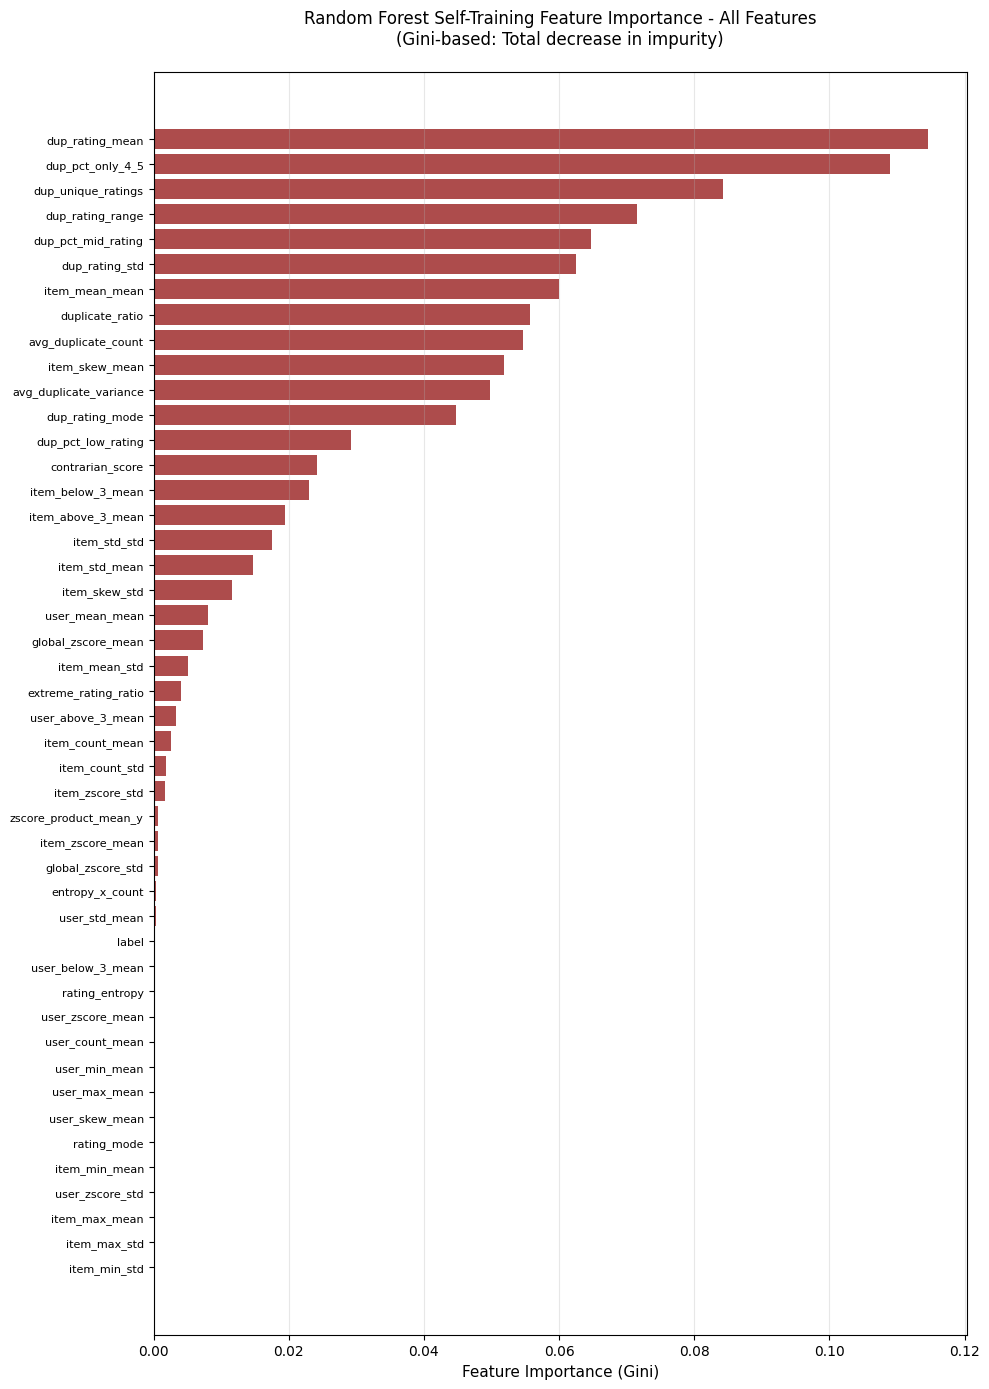

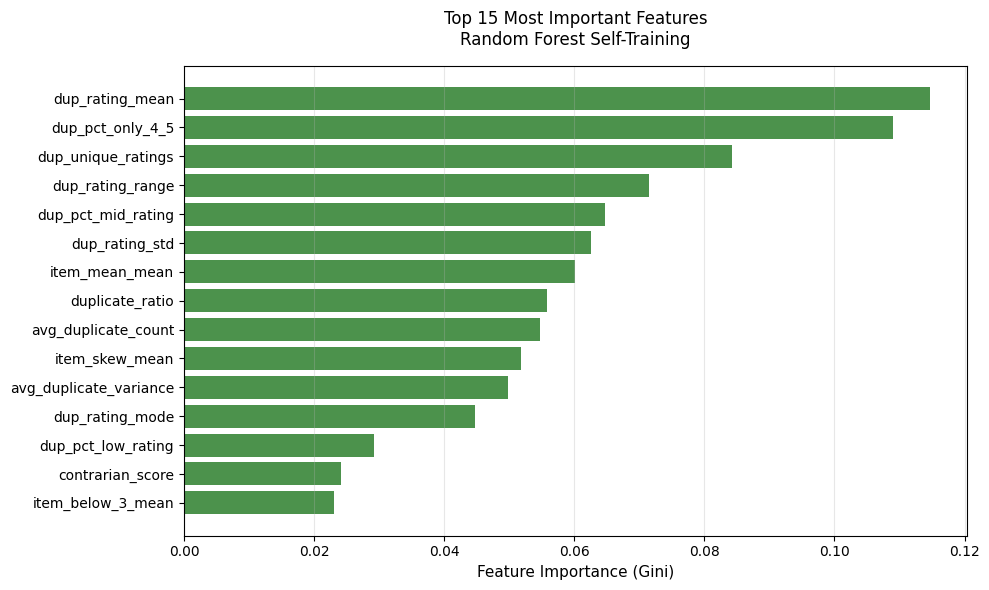

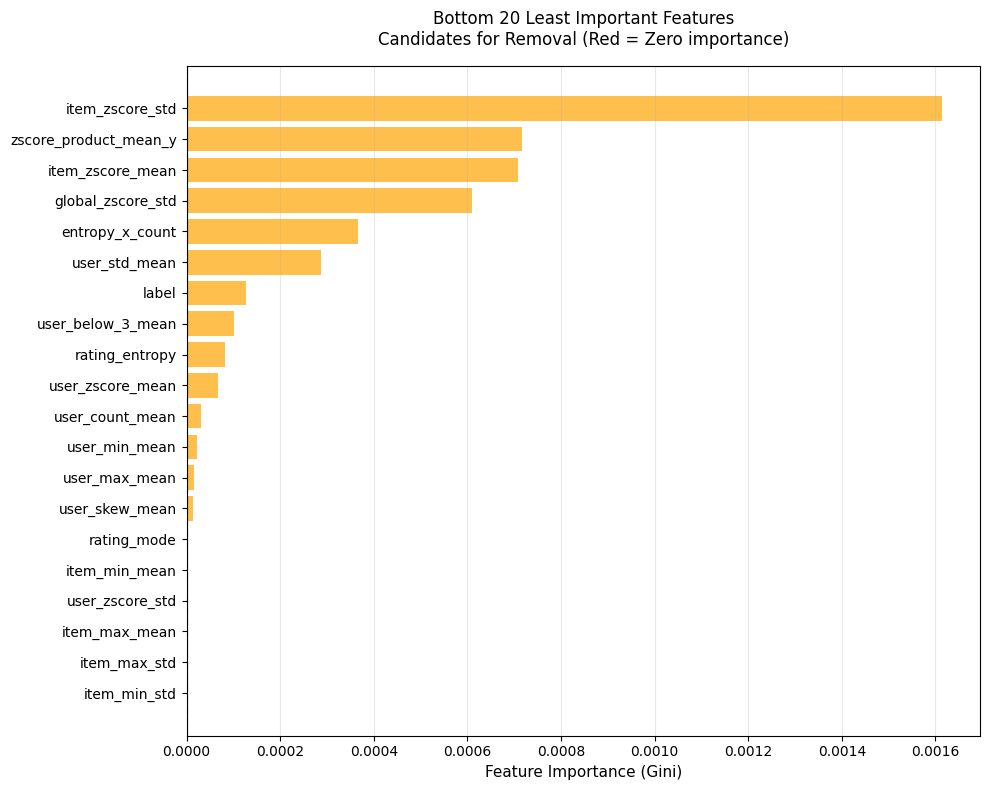

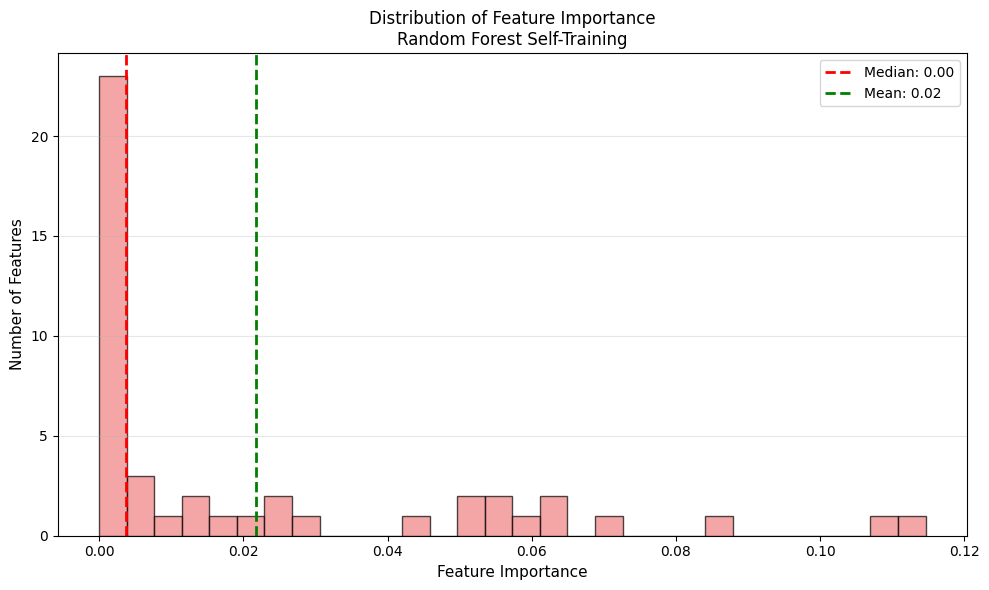

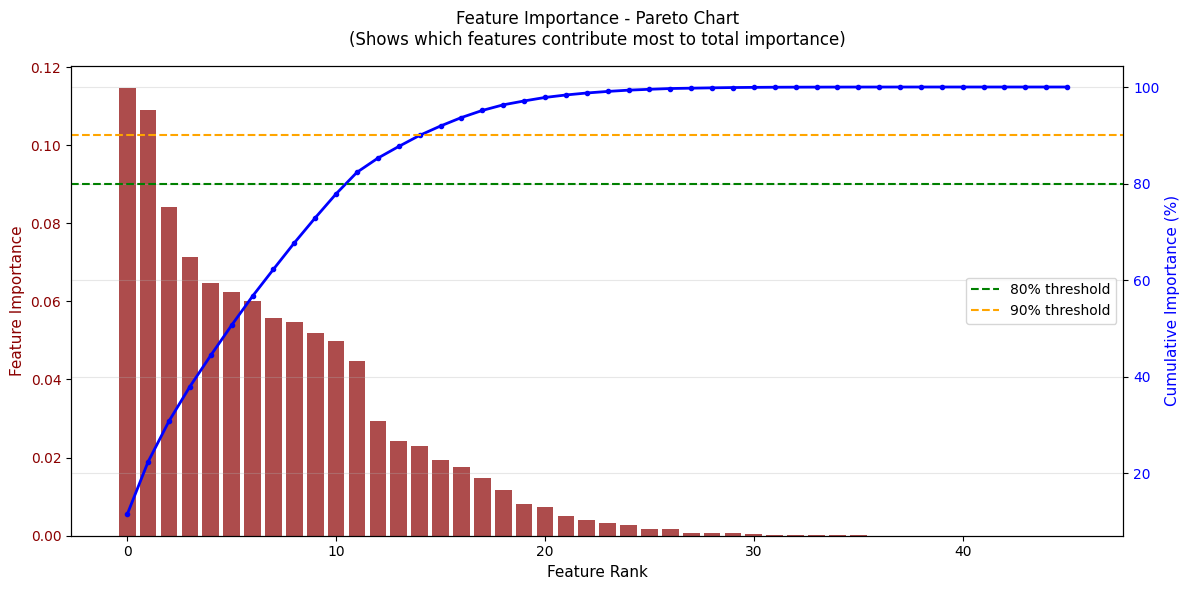


📊 Cumulative Importance Analysis:
  Top 12 features account for 80% of total importance
  Top 16 features account for 90% of total importance
  → Consider removing bottom 30 features

📋 Variables created:
  'final_model': Trained SelfTrainingClassifier with best params
  'rf_model': Underlying Random Forest model (for feature importance)
  'importance_df': DataFrame with 46 features and their importance
  'bottom_20_features': List of 20 least important features


In [ ]:
# @title Self Training (Random Forest) Feature Importance using inbuilt function
# ============================================
# RANDOM FOREST Self-Training Feature Importance Analysis
# (Run this AFTER the Random Forest Grid Search CV code)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier

print("\n" + "="*70)
print("RANDOM FOREST SELF-TRAINING FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# ============================================
# DATA AND PARAMETER CHECK/SETUP
# ============================================

# Use the best_params found in the previous step.
# Create dummy data/params if the Grid Search hasn't been run first.
try:
    # Check if best_params is defined
    _ = best_params
except NameError:
    print("⚠️ WARNING: 'best_params' not found (Grid Search not run). Using dummy parameters.")
    best_params = {
        'threshold': 0.8,
        'max_iter': 20,
        'n_estimators': 300,
        'max_depth': None,
        'max_features': 'sqrt'
    }

try:
    # Use the data variables from the Grid Search environment
    X_semi_labeled = X_labeled.copy()
    y_semi_labeled = y_labeled.copy()
    X_semi_unlabeled = X_unlabeled.copy()
except NameError:
    print("⚠️ WARNING: Data variables (X/y_labeled/unlabeled) not found. Creating dummy data.")
    from sklearn.datasets import make_classification
    X_full, y_full_dummy = make_classification(n_samples=200, n_features=10, n_informative=5, n_redundant=0, n_classes=2, random_state=42)
    labeled_size = 100
    X_semi_labeled = pd.DataFrame(X_full[:labeled_size], columns=[f'Feature_{i}' for i in range(10)])
    y_semi_labeled = pd.Series(y_full_dummy[:labeled_size])
    X_semi_unlabeled = pd.DataFrame(X_full[labeled_size:], columns=[f'Feature_{i}' for i in range(10)])


# ============================================
# STEP 1: Train Final Model with Best Parameters
# ============================================

print("\nTraining final model with best parameters from grid search...")
print(f"Using best parameters:")
print(f"  Self-Training: threshold={best_params['threshold']}, max_iter={best_params['max_iter']}")
print(f"  Random Forest: n_est={best_params['n_estimators']}, max_depth={best_params['max_depth']}, max_feat={best_params['max_features']}")

# Combine ALL labeled and unlabeled data for final training
X_full = pd.concat([X_semi_labeled, X_semi_unlabeled], ignore_index=True)
y_full = np.concatenate([
    y_semi_labeled.values,
    np.full(len(X_semi_unlabeled), -1)
])

print(f"\nFull dataset for training:")
print(f"  Labeled samples: {len(X_semi_labeled)}")
print(f"  Unlabeled samples: {len(X_semi_unlabeled)}")
print(f"  Total samples: {len(X_full)}")
print(f"  Features: {X_full.shape[1]}")

# Create base classifier with best parameters
base_classifier = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    random_state=42,
    # Random Forest default importance is Gini/impurity-based
)

# Create self-training classifier with best parameters
final_model = SelfTrainingClassifier(
    estimator=base_classifier,
    threshold=best_params['threshold'],
    criterion='threshold',
    max_iter=int(best_params['max_iter']),
    verbose=True  # Show progress
)

# Train the model
print("\nTraining self-training model...")
final_model.fit(X_full, y_full)
print("✓ Model training complete")

# Get the underlying trained Random Forest model
rf_model = final_model.estimator_

# ============================================
# STEP 2: Extract Feature Importance
# ============================================

print("\n" + "="*70)
print("EXTRACTING FEATURE IMPORTANCE (Gini-based)")
print("="*70)

# Random Forest uses feature_importances_ (Gini/impurity-based importance)
importance_weight = rf_model.feature_importances_

# Get feature names
feature_names = X_semi_labeled.columns.tolist()

print(f"✓ Extracted importance for {len(feature_names)} features")

# ============================================
# STEP 3: Create DataFrame with Importance
# ============================================

print("\nCreating importance DataFrame...")

# Only one main type of importance for scikit-learn's Random Forest
importance_data = {'Feature': feature_names, 'Importance_Gini': importance_weight}

# Create DataFrame
importance_df = pd.DataFrame(importance_data)

# Sort by Gini importance
importance_df = importance_df.sort_values('Importance_Gini', ascending=False).reset_index(drop=True)

print("✓ Created importance DataFrame")

# ============================================
# STEP 4: Display Results
# ============================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKING")
print("="*70)

# Ensure the DataFrame has enough rows
num_features = len(importance_df)
top_n = min(15, num_features)
bottom_n = min(20, num_features)

print(f"\nTop {top_n} Most Important Features:")
print(importance_df.head(top_n).to_string(index=False))

print("\n" + "-"*70)

print(f"\nBottom {bottom_n} Least Important Features:")
bottom_20 = importance_df.tail(bottom_n)
print(bottom_20.to_string(index=False))

# ============================================
# STEP 5: Identify Bottom Features to Remove
# ============================================

bottom_20_features = bottom_20['Feature'].tolist()

print("\n" + "="*70)
print(f"FEATURES TO CONSIDER REMOVING (BOTTOM {bottom_n})")
print("="*70)
print(f"\nFeatures ({len(bottom_20_features)}):")
for i, feat in enumerate(bottom_20_features, 1):
    imp_val = importance_df[importance_df['Feature'] == feat]['Importance_Gini'].values[0]
    print(f"  {i:2d}. {feat:30s} - Importance: {imp_val:.6f}")

print("\n" + "-"*70)
print("Python List Format for Removal:")
print(bottom_20_features)
print("="*70)

# ============================================
# STEP 6: Summary Statistics
# ============================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print(f"\nFeature Importance Statistics (Gini-based):")
print(f"  Mean importance: {importance_df['Importance_Gini'].mean():.6f}")
print(f"  Std importance:  {importance_df['Importance_Gini'].std():.6f}")
print(f"  Max importance:  {importance_df['Importance_Gini'].max():.6f}")
print(f"  Min importance:  {importance_df['Importance_Gini'].min():.6f}")
print(f"  Median:          {importance_df['Importance_Gini'].median():.6f}")

# Count zero-importance features
zero_importance = len(importance_df[importance_df['Importance_Gini'] == 0])
print(f"\nFeatures with ZERO importance: {zero_importance}")
if zero_importance > 0:
    print("  ⚠️ These features are NEVER used for splitting!")
    zero_imp_features = importance_df[importance_df['Importance_Gini'] == 0]['Feature'].tolist()
    print(f"  Zero-importance features: {zero_imp_features}")

# Categorize features
median_imp = importance_df['Importance_Gini'].median()
high_imp = len(importance_df[importance_df['Importance_Gini'] > median_imp])
low_imp = len(importance_df[importance_df['Importance_Gini'] <= median_imp])

print(f"\nFeature Categories:")
print(f"  Above median: {high_imp}")
print(f"  Below median: {low_imp}")

# Self-Training Statistics
n_labeled_initial = len(X_semi_labeled)
n_labeled_final = len(y_full[y_full != -1])
n_unlabeled_initial = len(X_semi_unlabeled)

print(f"\nSelf-Training Results:")
print(f"  Initial labeled: {n_labeled_initial}")
print(f"  Initial unlabeled: {n_unlabeled_initial}")
print(f"  Final labeled after self-training: {n_labeled_final}")
print(f"  Samples pseudo-labeled: {n_labeled_final - n_labeled_initial}")

# ============================================
# STEP 7: Visualizations
# ============================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: All Features (Horizontal Bar)
if num_features > 0:
    plt.figure(figsize=(10, min(14, num_features * 0.5)))
    y_pos = range(len(importance_df))
    plt.barh(y_pos, importance_df['Importance_Gini'][::-1],
             color='darkred', alpha=0.7)
    plt.yticks(y_pos, importance_df['Feature'][::-1], fontsize=8)
    plt.xlabel('Feature Importance (Gini)', fontsize=11)
    plt.title('Random Forest Self-Training Feature Importance - All Features\n(Gini-based: Total decrease in impurity)',
              fontsize=12, pad=20)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot 2: Top N Features Only
if top_n > 0:
    plt.figure(figsize=(10, min(8, top_n * 0.4)))
    top_20_plot = importance_df.head(top_n)
    y_pos_20 = range(len(top_20_plot))
    plt.barh(y_pos_20, top_20_plot['Importance_Gini'][::-1],
             color='darkgreen', alpha=0.7)
    plt.yticks(y_pos_20, top_20_plot['Feature'][::-1], fontsize=10)
    plt.xlabel('Feature Importance (Gini)', fontsize=11)
    plt.title(f'Top {top_n} Most Important Features\nRandom Forest Self-Training',
              fontsize=12, pad=15)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot 3: Bottom N Features (Candidates for Removal)
if bottom_n > 0:
    plt.figure(figsize=(10, min(8, bottom_n * 0.4)))
    y_pos_bottom = range(len(bottom_20))
    colors_bottom = ['red' if x == 0 else 'orange' for x in bottom_20['Importance_Gini'][::-1]]
    plt.barh(y_pos_bottom, bottom_20['Importance_Gini'][::-1],
             color=colors_bottom, alpha=0.7)
    plt.yticks(y_pos_bottom, bottom_20['Feature'][::-1], fontsize=10)
    plt.xlabel('Feature Importance (Gini)', fontsize=11)
    plt.title(f'Bottom {bottom_n} Least Important Features\nCandidates for Removal (Red = Zero importance)',
              fontsize=12, pad=15)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot 4: Distribution of Feature Importance
if num_features > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(importance_df['Importance_Gini'], bins=30,
             color='lightcoral', edgecolor='black', alpha=0.7)
    # FIX APPLIED HERE (and similar fix for mean line below)
    plt.axvline(median_imp,
                 color='red', linestyle='--', linewidth=2,
                 label=f'Median: {median_imp:.2f}')
    plt.axvline(importance_df['Importance_Gini'].mean(),
                 color='green', linestyle='--', linewidth=2,
                 label=f'Mean: {importance_df["Importance_Gini"].mean():.2f}')
    plt.xlabel('Feature Importance', fontsize=11)
    plt.ylabel('Number of Features', fontsize=11)
    plt.title('Distribution of Feature Importance\nRandom Forest Self-Training', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot 5: Cumulative Importance (Pareto Chart)
if num_features > 0:
    cumulative_importance = importance_df['Importance_Gini'].cumsum() / importance_df['Importance_Gini'].sum() * 100
    x_pos = range(len(importance_df))

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.bar(x_pos, importance_df['Importance_Gini'], color='darkred', alpha=0.7)
    ax1.set_xlabel('Feature Rank', fontsize=11)
    ax1.set_ylabel('Feature Importance', fontsize=11, color='darkred')
    ax1.tick_params(axis='y', labelcolor='darkred')

    ax2 = ax1.twinx()
    ax2.plot(x_pos, cumulative_importance, color='blue', marker='o', linewidth=2, markersize=3)
    ax2.axhline(y=80, color='green', linestyle='--', linewidth=1.5, label='80% threshold')
    ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, label='90% threshold')
    ax2.set_ylabel('Cumulative Importance (%)', fontsize=11, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='center right')

    plt.title('Feature Importance - Pareto Chart\n(Shows which features contribute most to total importance)',
              fontsize=12, pad=15)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Find how many features account for 80% and 90% of importance
    try:
        idx_80 = np.where(cumulative_importance >= 80)[0][0] + 1
        idx_90 = np.where(cumulative_importance >= 90)[0][0] + 1
        print(f"\n📊 Cumulative Importance Analysis:")
        print(f"  Top {idx_80} features account for 80% of total importance")
        print(f"  Top {idx_90} features account for 90% of total importance")
        print(f"  → Consider removing bottom {len(importance_df) - idx_90} features")
    except IndexError:
        print("\n📊 Cumulative Importance Analysis:")
        print("  Could not reach 80% or 90% cumulative importance threshold.")


print(f"\n📋 Variables created:")
print(f"  'final_model': Trained SelfTrainingClassifier with best params")
print(f"  'rf_model': Underlying Random Forest model (for feature importance)")
print(f"  'importance_df': DataFrame with {len(importance_df)} features and their importance")
print(f"  'bottom_20_features': List of {len(bottom_20_features)} least important features")
print("="*70)

In [ ]:
# @title Self Training (Extreme Gradient Boosting) Model + Grid Search Results
# ============================================
# GRID SEARCH WITH CV FOR SELF-TRAINING (XGBOOST)
# ============================================

print("\n" + "="*70)
print("GRID SEARCH WITH CROSS-VALIDATION - SELF-TRAINING (XGBOOST)")
print("="*70)

from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
# IMPORT XGBOOST
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# REMOVING StandardScaler as it's unnecessary for tree-based models like XGBoost
import numpy as np
import pandas as pd

# ============================================
# STEP 1: Define hyperparameter grid
# ============================================

param_grid = {
    # Self-Training parameters
    'threshold': [0.7, 0.8, 0.9, 0.99],
    'max_iter': [20],

    # XGBoost parameters (A common, reduced grid for XGBoost)
    'n_estimators': [100], # Keep a fixed n_estimators for the grid search scope
    'max_depth': [6, 9, 15], # Depth of trees
    'learning_rate': [0.01, 0.1, 0.5, 0.9], # Step size shrinkage
    'subsample': [1] # Fraction of samples to be used for fitting the trees
}

print(f"\nHyperparameter Grid:")
print(f"  Self-Training Parameters:")
print(f"    threshold: {param_grid['threshold']}")
print(f"    max_iter: {param_grid['max_iter']}")
print(f"  XGBoost Parameters:")
print(f"    n_estimators: {param_grid['n_estimators']}")
print(f"    max_depth: {param_grid['max_depth']}")
print(f"    learning_rate: {param_grid['learning_rate']}")
print(f"    subsample: {param_grid['subsample']}")

# Calculate total combinations
n_st = len(param_grid['threshold']) * len(param_grid['max_iter'])
n_xgb = (len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample']))
total_combinations = n_st * n_xgb
print(f"\nTotal combinations: {total_combinations}")

# ============================================
# STEP 2: Setup CV (Assuming X_semi_labeled, y_semi_labeled, X_semi_unlabeled are defined)
# ============================================

n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Placeholder variables (Ensure these are defined in your actual environment)
# For demonstration, let's create simple dummy data structure.
# You should replace this with your actual data loading.
try:
    # Check if data variables are already defined from the calling environment
    X_labeled = X_semi_labeled.copy()
    y_labeled = y_semi_labeled.copy()
    X_unlabeled = X_semi_unlabeled.copy()
except NameError:
    # Creating dummy data for execution if not defined
    print("WARNING: Data variables not found. Creating dummy data.")
    from sklearn.datasets import make_classification
    X_full, y_full = make_classification(n_samples=200, n_features=10, n_informative=5, n_redundant=0, n_classes=2, random_state=42)
    labeled_size = 100
    X_labeled = pd.DataFrame(X_full[:labeled_size])
    y_labeled = pd.Series(y_full[:labeled_size])
    X_unlabeled = pd.DataFrame(X_full[labeled_size:])

print(f"\nCV Setup:")
print(f"  Labeled samples: {len(X_labeled)}")
print(f"  Unlabeled samples: {len(X_unlabeled)}")
print(f"  CV folds: {n_folds}")

# ============================================
# STEP 3: Grid Search (SCALING REMOVED)
# ============================================

print(f"\n{'='*70}")
print(f"STARTING GRID SEARCH (XGBoost - Scaling Removed)")
print(f"{'='*70}")

# Store results for each parameter combination
grid_search_results = []
param_counter = 0

# Loop through XGBoost parameters
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:

                # Loop through Self-Training parameters
                for threshold in param_grid['threshold']:
                    for max_iter in param_grid['max_iter']:

                        param_counter += 1

                        params = {
                            'threshold': threshold,
                            'max_iter': max_iter,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample
                        }

                        print(f"\n[{param_counter}/{total_combinations}] Testing:")
                        print(f"  ST: threshold={threshold}, max_iter={max_iter}")
                        print(f"  XGB: n_est={n_estimators}, max_depth={max_depth}, lr={learning_rate}, sub={subsample}")

                        # Cross-validation for this parameter combination
                        fold_accuracies = []

                        for fold, (train_idx, val_idx) in enumerate(cv.split(X_labeled, y_labeled)):
                            # 1. Split labeled data
                            X_train = X_labeled.iloc[train_idx]
                            y_train = y_labeled.iloc[train_idx]
                            X_val = X_labeled.iloc[val_idx]
                            y_val = y_labeled.iloc[val_idx]

                            # --- SCALING REMOVED ---

                            # 2. Combine train with unlabeled data for model fitting
                            X_semi = pd.concat([X_train, X_unlabeled], ignore_index=True)

                            # The y labels remain the same (labeled data + -1 for unlabeled)
                            y_semi = np.concatenate([
                                y_train.values,
                                np.full(len(X_unlabeled), -1)
                            ])

                            # Create base classifier (XGBoost)
                            base_classifier = XGBClassifier(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                subsample=subsample,
                                eval_metric='logloss', # Suppress warning
                                random_state=42
                            )

                            # Create self-training classifier
                            model = SelfTrainingClassifier(
                                estimator=base_classifier,
                                threshold=threshold,
                                criterion='threshold',
                                max_iter=max_iter,
                                verbose=False
                            )

                            # Train model
                            model.fit(X_semi, y_semi)

                            # Predict on validation (No scaling needed for X_val)
                            y_pred = model.predict(X_val)
                            accuracy = accuracy_score(y_val, y_pred)
                            fold_accuracies.append(accuracy)

                        # Calculate mean and std
                        mean_acc = np.mean(fold_accuracies)
                        std_acc = np.std(fold_accuracies)

                        print(f"  Mean CV Accuracy: {mean_acc:.4f} (+/- {std_acc:.4f})")

                        # Store results
                        grid_search_results.append({
                            'threshold': threshold,
                            'max_iter': max_iter,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'mean_cv_accuracy': mean_acc,
                            'std_cv_accuracy': std_acc,
                            'fold_accuracies': fold_accuracies
                        })

# ============================================
# STEP 4: Find Best Parameters
# ============================================

print(f"\n{'='*70}")
print(f"GRID SEARCH RESULTS")
print(f"{'='*70}")

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(grid_search_results)

# Sort by mean CV accuracy (descending)
results_df = results_df.sort_values('mean_cv_accuracy', ascending=False).reset_index(drop=True)

print(f"\nTop 50 parameter combinations:")
print(results_df[['threshold', 'max_iter', 'n_estimators',
                  'max_depth', 'learning_rate', 'subsample',
                  'mean_cv_accuracy', 'std_cv_accuracy']].head(50))

# Best parameters
best_params = results_df.iloc[0]

print(f"\n{'='*70}")
print(f"BEST PARAMETERS")
print(f"{'='*70}")
print(f"  Self-Training Parameters:")
print(f"    threshold: {best_params['threshold']}")
print(f"    max_iter: {best_params['max_iter']}")
print(f"  XGBoost Parameters:")
print(f"    n_estimators: {best_params['n_estimators']}")
print(f"    max_depth: {best_params['max_depth']}")
print(f"    learning_rate: {best_params['learning_rate']}")
print(f"    subsample: {best_params['subsample']}")
print(f"\n  Mean CV Accuracy: {best_params['mean_cv_accuracy']:.4f}")
print(f"  Std CV Accuracy:  {best_params['std_cv_accuracy']:.4f}")

# ============================================
# STEP 5: Save Results
# ============================================

print(f"\n💾 Storing results...")
print(f"  'results_df': DataFrame with all {len(results_df)} parameter combinations")
print(f"  'best_params': Dictionary with best hyperparameters")

print("\n" + "="*70)
print("✓ GRID SEARCH COMPLETE")
print("="*70)

# ============================================
# OPTIONAL: Visualize Results
# ============================================

print(f"\n📊 Results Summary:")
print(f"  Total combinations tested: {len(results_df)}")
print(f"  Best accuracy: {results_df['mean_cv_accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_df['mean_cv_accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_df['mean_cv_accuracy'].mean():.4f}")

# Show performance by criterion
print(f"\nPerformance by threshold:")
for threshold in sorted(results_df['threshold'].unique()):
    threshold_results = results_df[results_df['threshold'] == threshold]
    print(f"  {threshold}: {threshold_results['mean_cv_accuracy'].mean():.4f} (best: {threshold_results['mean_cv_accuracy'].max():.4f})")

# Show performance by learning_rate
print(f"\nPerformance by learning_rate:")
for lr in sorted(results_df['learning_rate'].unique()):
    lr_results = results_df[results_df['learning_rate'] == lr]
    print(f"  {lr}: {lr_results['mean_cv_accuracy'].mean():.4f} (best: {lr_results['mean_cv_accuracy'].max():.4f})")


GRID SEARCH WITH CROSS-VALIDATION - SELF-TRAINING (XGBOOST)

Hyperparameter Grid:
  Self-Training Parameters:
    threshold: [0.7, 0.8, 0.9, 0.99]
    max_iter: [20]
  XGBoost Parameters:
    n_estimators: [100]
    max_depth: [6, 9, 15]
    learning_rate: [0.01, 0.1, 0.5, 0.9]
    subsample: [1]

Total combinations: 48

CV Setup:
  Labeled samples: 60
  Unlabeled samples: 3540
  CV folds: 5

STARTING GRID SEARCH (XGBoost - Scaling Removed)

[1/48] Testing:
  ST: threshold=0.7, max_iter=20
  XGB: n_est=100, max_depth=6, lr=0.01, sub=1
  Mean CV Accuracy: 0.8667 (+/- 0.0850)

[2/48] Testing:
  ST: threshold=0.8, max_iter=20
  XGB: n_est=100, max_depth=6, lr=0.01, sub=1
  Mean CV Accuracy: 0.8667 (+/- 0.0850)

[3/48] Testing:
  ST: threshold=0.9, max_iter=20
  XGB: n_est=100, max_depth=6, lr=0.01, sub=1
  Mean CV Accuracy: 0.8667 (+/- 0.0850)

[4/48] Testing:
  ST: threshold=0.99, max_iter=20
  XGB: n_est=100, max_depth=6, lr=0.01, sub=1
  Mean CV Accuracy: 0.8667 (+/- 0.0850)

[5/48] T

In [ ]:
# @title Self Training (Extreme Gradient Boosting) final training results
# ============================================
# STEP 6: Calculate Predicted Class Counts 🔢
# ============================================
print(f"\n{'='*70}")
print(f"PREDICTED CLASS DISTRIBUTION COUNTS")
print(f"{'='*70}")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of labeled samples
N_LABELED = len(X_labeled)
N_UNLABELED = len(X_unlabeled)

# 2. NO SCALING for XGBoost (tree-based models don't require scaling)

# 3. Re-train the BEST Self-Training Model on ALL available data
print(f"Retraining best Self-Training + XGBoost model on full dataset...")
print(f"  Self-Training Parameters:")
print(f"    threshold: {best_params['threshold']}")
print(f"    max_iter: {best_params['max_iter']}")
print(f"  XGBoost Parameters:")
print(f"    n_estimators: {best_params['n_estimators']}")
print(f"    max_depth: {best_params['max_depth']}")
print(f"    learning_rate: {best_params['learning_rate']}")
print(f"    subsample: {best_params['subsample']}")

# Create base classifier with best parameters
base_classifier = XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    eval_metric='logloss',
    random_state=42
)

# Create self-training classifier with best parameters
final_model = SelfTrainingClassifier(
    estimator=base_classifier,
    threshold=best_params['threshold'],
    criterion='threshold',
    max_iter=int(best_params['max_iter']),
    verbose=True  # Show progress
)

# Fit model on full dataset
final_model.fit(X_full, y_full)

print("Final Self-Training model trained.")

# 4. Predict labels for the entire dataset
y_predicted_full = final_model.predict(X_full)

# 5. Get prediction confidence/probabilities
y_predicted_probs = final_model.predict_proba(X_full)
prediction_confidence = y_predicted_probs.max(axis=1)

# 6. Get information about labeled samples during training
# The transduction_ attribute shows which samples were labeled by self-training
transduction_labels = final_model.transduction_

# Check which unlabeled samples were actually labeled during self-training
labeled_mask = y_full != -1  # Originally labeled
newly_labeled = (y_full == -1) & (transduction_labels != -1)  # Labeled by self-training
still_unlabeled = (y_full == -1) & (transduction_labels == -1)  # Never labeled

print(f"\nSelf-Training Statistics:")
print(f"  Originally labeled: {labeled_mask.sum()}")
print(f"  Newly labeled by self-training: {newly_labeled.sum()}")
print(f"  Still unlabeled: {still_unlabeled.sum()}")

# 7. Split predictions for labeled data
y_labeled_true = y_labeled.values
y_labeled_pred = y_predicted_full[:N_LABELED]
y_unlabeled_pred = y_predicted_full[N_LABELED:]

# 8. Calculate Accuracy for Labeled Data
labeled_accuracy = accuracy_score(y_labeled_true, y_labeled_pred)
print(f"\n✓ Labeled Data Accuracy: {labeled_accuracy:.4f} ({int(labeled_accuracy * N_LABELED)}/{N_LABELED} correct)")

# 9. Generate Confusion Matrix for Labeled Data
print(f"\n{'='*70}")
print("CONFUSION MATRIX - LABELED DATA")
print(f"{'='*70}")

conf_matrix = confusion_matrix(y_labeled_true, y_labeled_pred)
class_labels = sorted(np.unique(y_labeled_true))

# Create a formatted confusion matrix DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f'True Class {i}' for i in class_labels],
    columns=[f'Pred Class {i}' for i in class_labels]
)

print("\nConfusion Matrix:")
print(conf_matrix_df)

# Calculate per-class accuracy
print("\nPer-Class Performance (Labeled Data):")
print("-" * 60)
for i, class_label in enumerate(class_labels):
    true_positives = conf_matrix[i, i]
    total_true = conf_matrix[i, :].sum()
    class_accuracy = true_positives / total_true if total_true > 0 else 0
    print(f"  Class {class_label}: {true_positives}/{total_true} correct ({class_accuracy:.2%})")

# 10. Generate Classification Report
print(f"\n{'='*70}")
print("CLASSIFICATION REPORT - LABELED DATA")
print(f"{'='*70}")
print(classification_report(y_labeled_true, y_labeled_pred,
                          target_names=[f'Class {i}' for i in class_labels],
                          digits=4))

# 11. Calculate and Display Counts
print(f"\n{'='*70}")
print("PREDICTED CLASS DISTRIBUTION")
print(f"{'='*70}")

# Convert to DataFrame for easy handling
distribution_df = pd.DataFrame({
    'Predicted_Label': y_predicted_full.astype(int),
    'Confidence': prediction_confidence,
    'Original_Label': y_full,
    'Transduction_Label': transduction_labels,
    'Is_Originally_Labeled': labeled_mask,
    'Was_Self_Labeled': newly_labeled
})

# Add true labels for labeled portion
distribution_df['True_Label'] = np.concatenate([y_labeled_true, np.full(N_UNLABELED, -1)])

# Calculate counts for labeled data (with correctness)
labeled_df = distribution_df[distribution_df['Is_Originally_Labeled'] == True].copy()
labeled_correct = labeled_df[labeled_df['Predicted_Label'] == labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_incorrect = labeled_df[labeled_df['Predicted_Label'] != labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_total = labeled_df.groupby('Predicted_Label').size()

# Calculate counts for unlabeled data
unlabeled_counts = distribution_df[distribution_df['Is_Originally_Labeled'] == False]['Predicted_Label'].value_counts().sort_index()
self_labeled_counts = distribution_df[distribution_df['Was_Self_Labeled'] == True]['Predicted_Label'].value_counts().sort_index()

# Combine and format the results table
all_labels = sorted(distribution_df['Predicted_Label'].unique())
all_counts = pd.DataFrame(index=all_labels)

all_counts['Labeled_Correct'] = labeled_correct
all_counts['Labeled_Incorrect'] = labeled_incorrect
all_counts['Labeled_Total'] = labeled_total
all_counts['Originally_Unlabeled'] = unlabeled_counts
all_counts['Self_Labeled_Subset'] = self_labeled_counts
all_counts = all_counts.fillna(0).astype(int)
all_counts['Total_Samples'] = all_counts['Labeled_Total'] + all_counts['Originally_Unlabeled']

# Add accuracy column
all_counts['Labeled_Accuracy'] = (all_counts['Labeled_Correct'] / all_counts['Labeled_Total']).fillna(0)
all_counts['Labeled_Accuracy'] = all_counts['Labeled_Accuracy'].apply(lambda x: f"{x:.2%}")

print("\nFinal Predicted Class Distribution:")
print("-" * 100)
print(all_counts)

# 12. Additional Statistics
print(f"\n{'='*70}")
print(f"PREDICTION CONFIDENCE STATISTICS")
print(f"{'='*70}")

# Confidence statistics for originally labeled data
labeled_confidence = distribution_df[distribution_df['Is_Originally_Labeled'] == True]['Confidence']
print(f"\nOriginally Labeled Data Predictions:")
print(f"  Mean Confidence: {labeled_confidence.mean():.4f}")
print(f"  Std Confidence:  {labeled_confidence.std():.4f}")
print(f"  Min Confidence:  {labeled_confidence.min():.4f}")
print(f"  Max Confidence:  {labeled_confidence.max():.4f}")

# Confidence statistics for self-labeled data
if newly_labeled.sum() > 0:
    self_labeled_confidence = distribution_df[distribution_df['Was_Self_Labeled'] == True]['Confidence']
    print(f"\nSelf-Labeled Data (during training):")
    print(f"  Mean Confidence: {self_labeled_confidence.mean():.4f}")
    print(f"  Std Confidence:  {self_labeled_confidence.std():.4f}")
    print(f"  Min Confidence:  {self_labeled_confidence.min():.4f}")
    print(f"  Max Confidence:  {self_labeled_confidence.max():.4f}")

# Confidence statistics for still unlabeled data
if still_unlabeled.sum() > 0:
    print(f"\nStill Unlabeled Data (final predictions):")
    print(f"  Count: {still_unlabeled.sum()}")
    print(f"  Mean Confidence: {distribution_df[still_unlabeled]['Confidence'].mean():.4f}")

# Show confidence distribution by class for unlabeled predictions
print(f"\nUnlabeled Prediction Confidence by Class:")
for label in all_labels:
    class_mask = (distribution_df['Predicted_Label'] == label) & (distribution_df['Is_Originally_Labeled'] == False)
    class_confidence = distribution_df[class_mask]['Confidence']
    if len(class_confidence) > 0:
        print(f"  Class {label}: {class_confidence.mean():.4f} (+/- {class_confidence.std():.4f}) "
              f"[n={len(class_confidence)}]")

# Show self-labeling iterations if available
print(f"\n{'='*70}")
print(f"SELF-TRAINING ITERATIONS")
print(f"{'='*70}")
print(f"Max iterations allowed: {best_params['max_iter']}")
print(f"Confidence threshold: {best_params['threshold']}")
print(f"Samples labeled during training: {newly_labeled.sum()}")
if newly_labeled.sum() > 0:
    print(f"Average confidence of self-labeled samples: {self_labeled_confidence.mean():.4f}")

print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Total Originally Labeled: {N_LABELED}")
print(f"  Correctly Predicted: {(y_labeled_true == y_labeled_pred).sum()} ({labeled_accuracy:.2%})")
print(f"  Incorrectly Predicted: {(y_labeled_true != y_labeled_pred).sum()} ({1-labeled_accuracy:.2%})")
print(f"\nTotal Originally Unlabeled: {N_UNLABELED}")
print(f"  └─ Self-Labeled: {newly_labeled.sum()} ({newly_labeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"  └─ Still Unlabeled: {still_unlabeled.sum()} ({still_unlabeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"Total Dataset: {len(X_full)}")
print(f"Number of Classes: {len(all_labels)}")
print(f"Best CV Accuracy: {best_params['mean_cv_accuracy']:.4f}")
print(f"{'='*70}")


PREDICTED CLASS DISTRIBUTION COUNTS
Retraining best Self-Training + XGBoost model on full dataset...
  Self-Training Parameters:
    threshold: 0.9
    max_iter: 20
  XGBoost Parameters:
    n_estimators: 100
    max_depth: 6
    learning_rate: 0.1
    subsample: 1
End of iteration 1, added 2917 new labels.
End of iteration 2, added 560 new labels.
End of iteration 3, added 54 new labels.
End of iteration 4, added 8 new labels.
Final Self-Training model trained.

Self-Training Statistics:
  Originally labeled: 60
  Newly labeled by self-training: 3539
  Still unlabeled: 1

✓ Labeled Data Accuracy: 1.0000 (60/60 correct)

CONFUSION MATRIX - LABELED DATA

Confusion Matrix:
              Pred Class 0  Pred Class 1  Pred Class 2
True Class 0            20             0             0
True Class 1             0            20             0
True Class 2             0             0            20

Per-Class Performance (Labeled Data):
------------------------------------------------------------


VISUALIZING LABEL SPACE (t-SNE)
Retraining best Self-Training + XGBoost model on full dataset...
  Self-Training Parameters:
    threshold: 0.9
    max_iter: 20
  XGBoost Parameters:
    n_estimators: 100
    max_depth: 6
    learning_rate: 0.1
    subsample: 1
Final Self-Training model trained.
Probability distribution shape: (3600, 3)
  (N_samples=3600, N_classes=3)

Self-Training Statistics:
  Originally labeled: 60
  Newly labeled by self-training: 3539
  Still unlabeled: 1
Running t-SNE for dimensionality reduction on probability distributions...
t-SNE complete.


/tmp/ipython-input-2136198492.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2', N_CLASSES_TRUE)


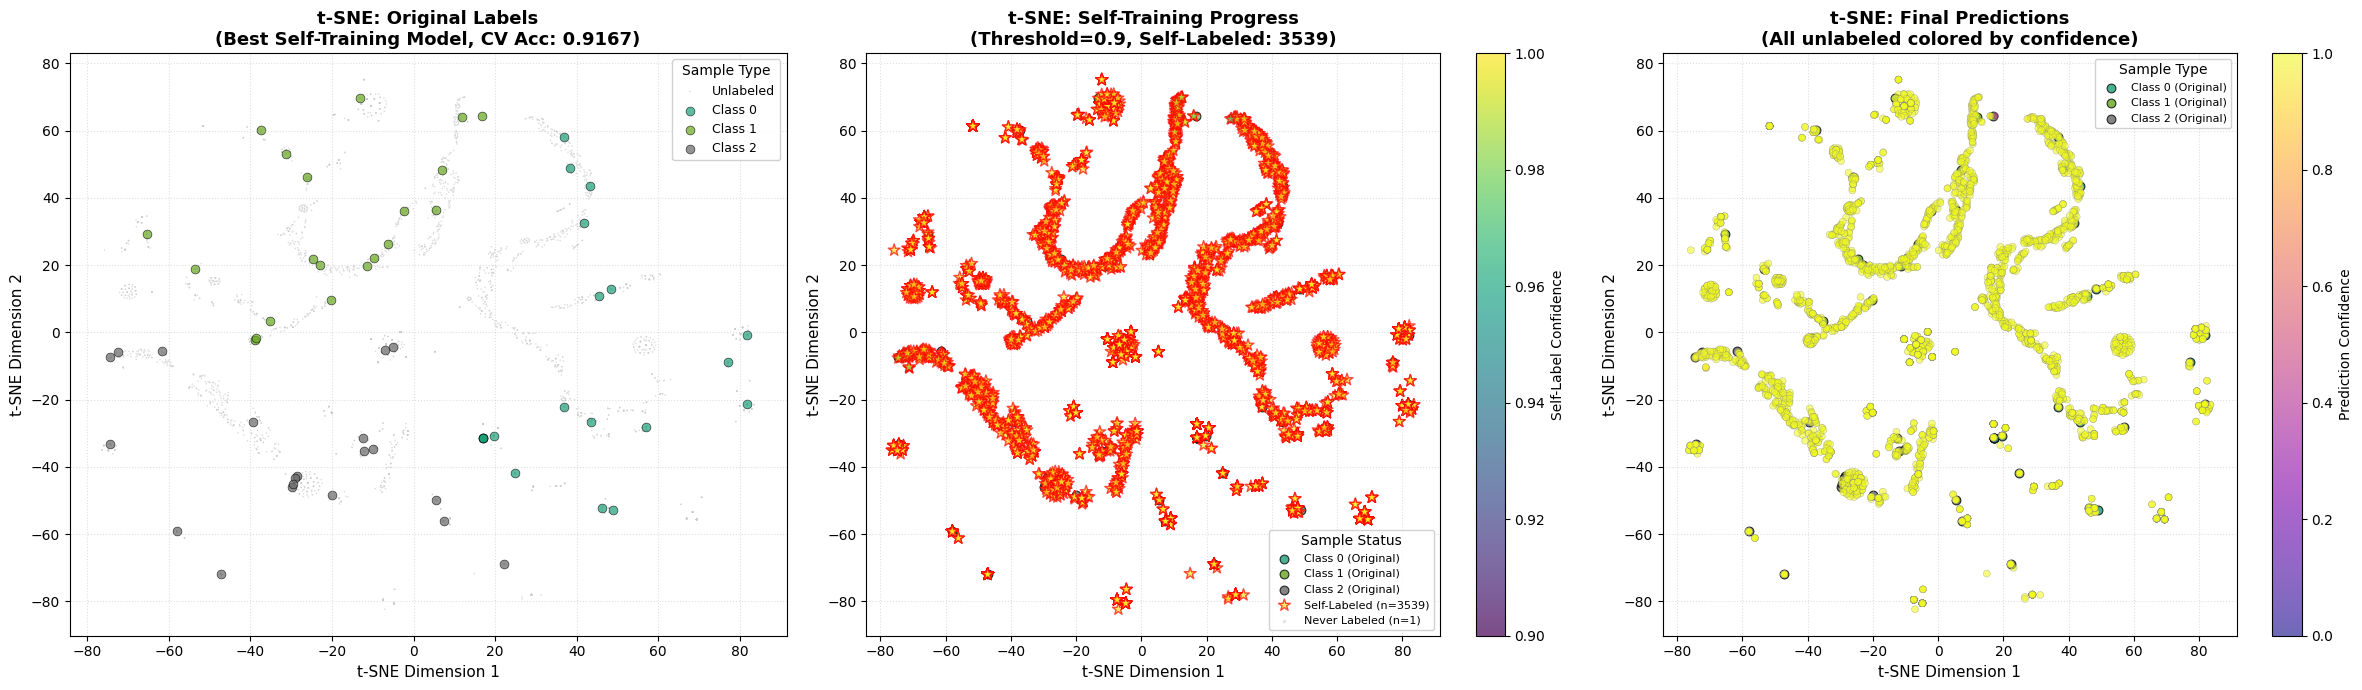


VISUALIZATION STATISTICS
Total samples visualized: 3600
  Originally Labeled: 60
  Originally Unlabeled: 3540
    └─ Self-Labeled: 3539 (100.0%)
    └─ Still Unlabeled: 1 (0.0%)
Number of classes: 3

Predicted class distribution:
  Pred: Class 0: 1372 samples (38.1%)
  Pred: Class 1: 1109 samples (30.8%)
  Pred: Class 2: 1119 samples (31.1%)

Self-labeled samples confidence:
  Mean: 0.9994
  Median: 0.9997
  Min: 0.8808 (threshold was 0.9000)
  Max: 0.9998

All originally unlabeled predictions confidence:
  Mean: 0.9992
  Median: 0.9997
  Std: 0.0106
  Min: 0.3850
  Max: 0.9998

  High confidence (≥0.8): 3539 (100.0%)
  Low confidence (<0.5): 1 (0.0%)

Visualization shows:
  LEFT: Original label distribution in t-SNE space
  MIDDLE: Self-training progress - which samples were labeled during training (stars)
  RIGHT: Final predictions with confidence for all unlabeled samples


In [ ]:
# @title Self Training (Extreme Gradient Boosting) t-SNE visualisations
# ============================================
# STEP 7: Visualize Label Space (t-SNE) 📊
# ============================================
print(f"\n{'='*70}")
print(f"VISUALIZING LABEL SPACE (t-SNE)")
print(f"{'='*70}")

from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of labeled samples and classes
N_LABELED = len(X_labeled)
N_UNLABELED = len(X_unlabeled)
N_CLASSES_TRUE = len(np.unique(y_labeled))

# 2. NO SCALING for XGBoost (tree-based models don't require scaling)

# 3. Re-train the BEST Self-Training Model on ALL available data
print(f"Retraining best Self-Training + XGBoost model on full dataset...")
print(f"  Self-Training Parameters:")
print(f"    threshold: {best_params['threshold']}")
print(f"    max_iter: {best_params['max_iter']}")
print(f"  XGBoost Parameters:")
print(f"    n_estimators: {best_params['n_estimators']}")
print(f"    max_depth: {best_params['max_depth']}")
print(f"    learning_rate: {best_params['learning_rate']}")
print(f"    subsample: {best_params['subsample']}")

# Create base classifier with best parameters
base_classifier = XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    eval_metric='logloss',
    random_state=42
)

# Create self-training classifier with best parameters
final_model = SelfTrainingClassifier(
    estimator=base_classifier,
    threshold=best_params['threshold'],
    criterion='threshold',
    max_iter=int(best_params['max_iter']),
    verbose=False
)

# Fit model on full dataset
final_model.fit(X_full, y_full)
print("Final Self-Training model trained.")

# 4. Extract "Features" (The probability distributions from XGBoost)
# Use probability distributions as high-dimensional features for t-SNE
X_features = final_model.predict_proba(X_full)

print(f"Probability distribution shape: {X_features.shape}")
print(f"  (N_samples={X_features.shape[0]}, N_classes={X_features.shape[1]})")

# Get self-training information
transduction_labels = final_model.transduction_
labeled_mask = y_full != -1
newly_labeled = (y_full == -1) & (transduction_labels != -1)
still_unlabeled = (y_full == -1) & (transduction_labels == -1)

print(f"\nSelf-Training Statistics:")
print(f"  Originally labeled: {labeled_mask.sum()}")
print(f"  Newly labeled by self-training: {newly_labeled.sum()}")
print(f"  Still unlabeled: {still_unlabeled.sum()}")

# 5. Run t-SNE
print("Running t-SNE for dimensionality reduction on probability distributions...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    learning_rate='auto',
    init='pca',
    n_jobs=-1
)
X_tsne = tsne.fit_transform(X_features)
print("t-SNE complete.")

# 6. Prepare Plotting Data Structure
# Create label vector for plotting
y_true_all = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])
y_plot = y_true_all.astype(str)
y_plot[len(y_labeled):] = 'Unlabeled'

# Create DataFrame
plot_df = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'])
plot_df['Label'] = y_plot

# Map labeled classes
label_mapping = {str(i): f'Class {i}' for i in range(N_CLASSES_TRUE)}
label_mapping['Unlabeled'] = 'Unlabeled'
plot_df['Label'] = plot_df['Label'].map(label_mapping).fillna('Unlabeled')

# Add prediction and self-training info
plot_df['Prediction'] = final_model.predict(X_full).astype(str)
plot_df['Prediction'] = plot_df['Prediction'].apply(lambda x: f'Pred: Class {x}')
plot_df['Confidence'] = X_features.max(axis=1)
plot_df['Was_Self_Labeled'] = newly_labeled
plot_df['Is_Originally_Labeled'] = labeled_mask

# Sort to ensure smaller points are plotted first
categories = ['Unlabeled'] + [f'Class {i}' for i in range(N_CLASSES_TRUE)]
plot_df['Label'] = pd.Categorical(plot_df['Label'], categories=categories)
plot_df = plot_df.sort_values(by='Label')

# 7. Plotting - Comprehensive Visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Define colors and sizes
colors = plt.cm.get_cmap('Dark2', N_CLASSES_TRUE)
color_map = {f'Class {i}': colors(i) for i in range(N_CLASSES_TRUE)}
color_map['Unlabeled'] = '#cccccc'
size_map = {'Unlabeled': 5, **{f'Class {i}': 40 for i in range(N_CLASSES_TRUE)}}

# LEFT PLOT: Original True Labels
ax1 = axes[0]
for label, data in plot_df.groupby('Label'):
    ax1.scatter(
        data['TSNE_1'], data['TSNE_2'],
        c=[color_map[label]], s=size_map[label],
        label=label, alpha=0.7,
        marker='o' if label != 'Unlabeled' else '.',
        edgecolors='black' if label != 'Unlabeled' else 'none',
        linewidths=0.5
    )

ax1.set_title(f't-SNE: Original Labels\n(Best Self-Training Model, CV Acc: {best_params["mean_cv_accuracy"]:.4f})',
              fontsize=13, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax1.legend(title='Sample Type', loc='best', framealpha=0.9, fontsize=9)
ax1.grid(True, linestyle=':', alpha=0.4)

# MIDDLE PLOT: Self-Labeled vs. Not Self-Labeled
ax2 = axes[1]

# Originally labeled (show as larger points with true labels)
for label in [f'Class {i}' for i in range(N_CLASSES_TRUE)]:
    mask = (plot_df['Label'] == label) & (plot_df['Is_Originally_Labeled'])
    if mask.sum() > 0:
        ax2.scatter(
            plot_df.loc[mask, 'TSNE_1'],
            plot_df.loc[mask, 'TSNE_2'],
            c=[color_map[label]], s=40,
            label=f'{label} (Original)', alpha=0.8,
            marker='o',
            edgecolors='black',
            linewidths=0.8
        )

# Self-labeled during training (show as stars)
self_labeled_mask = plot_df['Was_Self_Labeled']
if self_labeled_mask.sum() > 0:
    scatter_self = ax2.scatter(
        plot_df.loc[self_labeled_mask, 'TSNE_1'],
        plot_df.loc[self_labeled_mask, 'TSNE_2'],
        c=plot_df.loc[self_labeled_mask, 'Confidence'],
        s=80,
        cmap='viridis',
        alpha=0.7,
        marker='*',
        edgecolors='red',
        linewidths=1,
        vmin=best_params['threshold'], vmax=1,
        label=f'Self-Labeled (n={self_labeled_mask.sum()})'
    )
    cbar1 = plt.colorbar(scatter_self, ax=ax2)
    cbar1.set_label('Self-Label Confidence', fontsize=10)

# Still unlabeled (show as small gray dots)
still_unlabeled_mask = ~plot_df['Is_Originally_Labeled'] & ~plot_df['Was_Self_Labeled']
if still_unlabeled_mask.sum() > 0:
    ax2.scatter(
        plot_df.loc[still_unlabeled_mask, 'TSNE_1'],
        plot_df.loc[still_unlabeled_mask, 'TSNE_2'],
        c='#cccccc',
        s=10,
        alpha=0.4,
        marker='.',
        label=f'Never Labeled (n={still_unlabeled_mask.sum()})'
    )

ax2.set_title(f't-SNE: Self-Training Progress\n(Threshold={best_params["threshold"]}, Self-Labeled: {self_labeled_mask.sum()})',
              fontsize=13, fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax2.legend(title='Sample Status', loc='best', framealpha=0.9, fontsize=8)
ax2.grid(True, linestyle=':', alpha=0.4)

# RIGHT PLOT: Final Predictions with Confidence
ax3 = axes[2]

# Originally labeled points
for label in [f'Class {i}' for i in range(N_CLASSES_TRUE)]:
    mask = (plot_df['Label'] == label) & (plot_df['Is_Originally_Labeled'])
    if mask.sum() > 0:
        ax3.scatter(
            plot_df.loc[mask, 'TSNE_1'],
            plot_df.loc[mask, 'TSNE_2'],
            c=[color_map[label]], s=40,
            label=f'{label} (Original)', alpha=0.8,
            marker='o',
            edgecolors='black',
            linewidths=0.8
        )

# All unlabeled predictions colored by confidence
unlabeled_mask = ~plot_df['Is_Originally_Labeled']
if unlabeled_mask.sum() > 0:
    scatter_pred = ax3.scatter(
        plot_df.loc[unlabeled_mask, 'TSNE_1'],
        plot_df.loc[unlabeled_mask, 'TSNE_2'],
        c=plot_df.loc[unlabeled_mask, 'Confidence'],
        s=25,
        cmap='plasma',
        alpha=0.6,
        marker='o',
        edgecolors='gray',
        linewidths=0.3,
        vmin=0, vmax=1
    )
    cbar2 = plt.colorbar(scatter_pred, ax=ax3)
    cbar2.set_label('Prediction Confidence', fontsize=10)

ax3.set_title(f't-SNE: Final Predictions\n(All unlabeled colored by confidence)',
              fontsize=13, fontweight='bold')
ax3.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax3.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax3.legend(title='Sample Type', loc='best', framealpha=0.9, fontsize=8)
ax3.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

# 8. Additional Statistics
print(f"\n{'='*70}")
print(f"VISUALIZATION STATISTICS")
print(f"{'='*70}")
print(f"Total samples visualized: {len(plot_df)}")
print(f"  Originally Labeled: {N_LABELED}")
print(f"  Originally Unlabeled: {N_UNLABELED}")
print(f"    └─ Self-Labeled: {newly_labeled.sum()} ({newly_labeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"    └─ Still Unlabeled: {still_unlabeled.sum()} ({still_unlabeled.sum()/N_UNLABELED*100:.1f}%)")
print(f"Number of classes: {N_CLASSES_TRUE}")

# Class distribution in predictions
pred_counts = plot_df['Prediction'].value_counts().sort_index()
print(f"\nPredicted class distribution:")
for pred_class, count in pred_counts.items():
    percentage = (count / len(plot_df)) * 100
    print(f"  {pred_class}: {count} samples ({percentage:.1f}%)")

# Confidence statistics
if newly_labeled.sum() > 0:
    self_labeled_conf = plot_df[plot_df['Was_Self_Labeled']]['Confidence']
    print(f"\nSelf-labeled samples confidence:")
    print(f"  Mean: {self_labeled_conf.mean():.4f}")
    print(f"  Median: {self_labeled_conf.median():.4f}")
    print(f"  Min: {self_labeled_conf.min():.4f} (threshold was {best_params['threshold']:.4f})")
    print(f"  Max: {self_labeled_conf.max():.4f}")

unlabeled_conf = plot_df[~plot_df['Is_Originally_Labeled']]['Confidence']
print(f"\nAll originally unlabeled predictions confidence:")
print(f"  Mean: {unlabeled_conf.mean():.4f}")
print(f"  Median: {unlabeled_conf.median():.4f}")
print(f"  Std: {unlabeled_conf.std():.4f}")
print(f"  Min: {unlabeled_conf.min():.4f}")
print(f"  Max: {unlabeled_conf.max():.4f}")

# High/Low confidence counts
high_conf_count = (unlabeled_conf >= 0.8).sum()
low_conf_count = (unlabeled_conf < 0.5).sum()
print(f"\n  High confidence (≥0.8): {high_conf_count} ({high_conf_count/len(unlabeled_conf)*100:.1f}%)")
print(f"  Low confidence (<0.5): {low_conf_count} ({low_conf_count/len(unlabeled_conf)*100:.1f}%)")

print("\nVisualization shows:")
print("  LEFT: Original label distribution in t-SNE space")
print("  MIDDLE: Self-training progress - which samples were labeled during training (stars)")
print("  RIGHT: Final predictions with confidence for all unlabeled samples")
print(f"{'='*70}")


XGBOOST SELF-TRAINING FEATURE IMPORTANCE ANALYSIS

Training final model with best parameters from grid search...
Using best parameters:
  Self-Training: threshold=0.99, max_iter=20
  XGBoost: n_est=100, max_depth=6, lr=0.5, sub=1

Full dataset for training:
  Labeled samples: 60
  Unlabeled samples: 3540
  Total samples: 3600
  Features: 46

Training self-training model...
✓ Model training complete

EXTRACTING FEATURE IMPORTANCE
✓ Extracted importance for 46 features

Calculating multiple importance metrics...
✓ Calculated importance metrics

FEATURE IMPORTANCE RANKING

Top 15 Most Important Features (Ranked by Weight):
              Feature  Importance_Weight  Importance_Gain  Importance_Cover
   dup_pct_mid_rating               31.0        20.119579        146.638397
      item_zscore_std               24.0         0.603434        138.189651
       dup_rating_std               21.0       118.011650        303.241882
      dup_rating_mean               21.0       146.187057        25

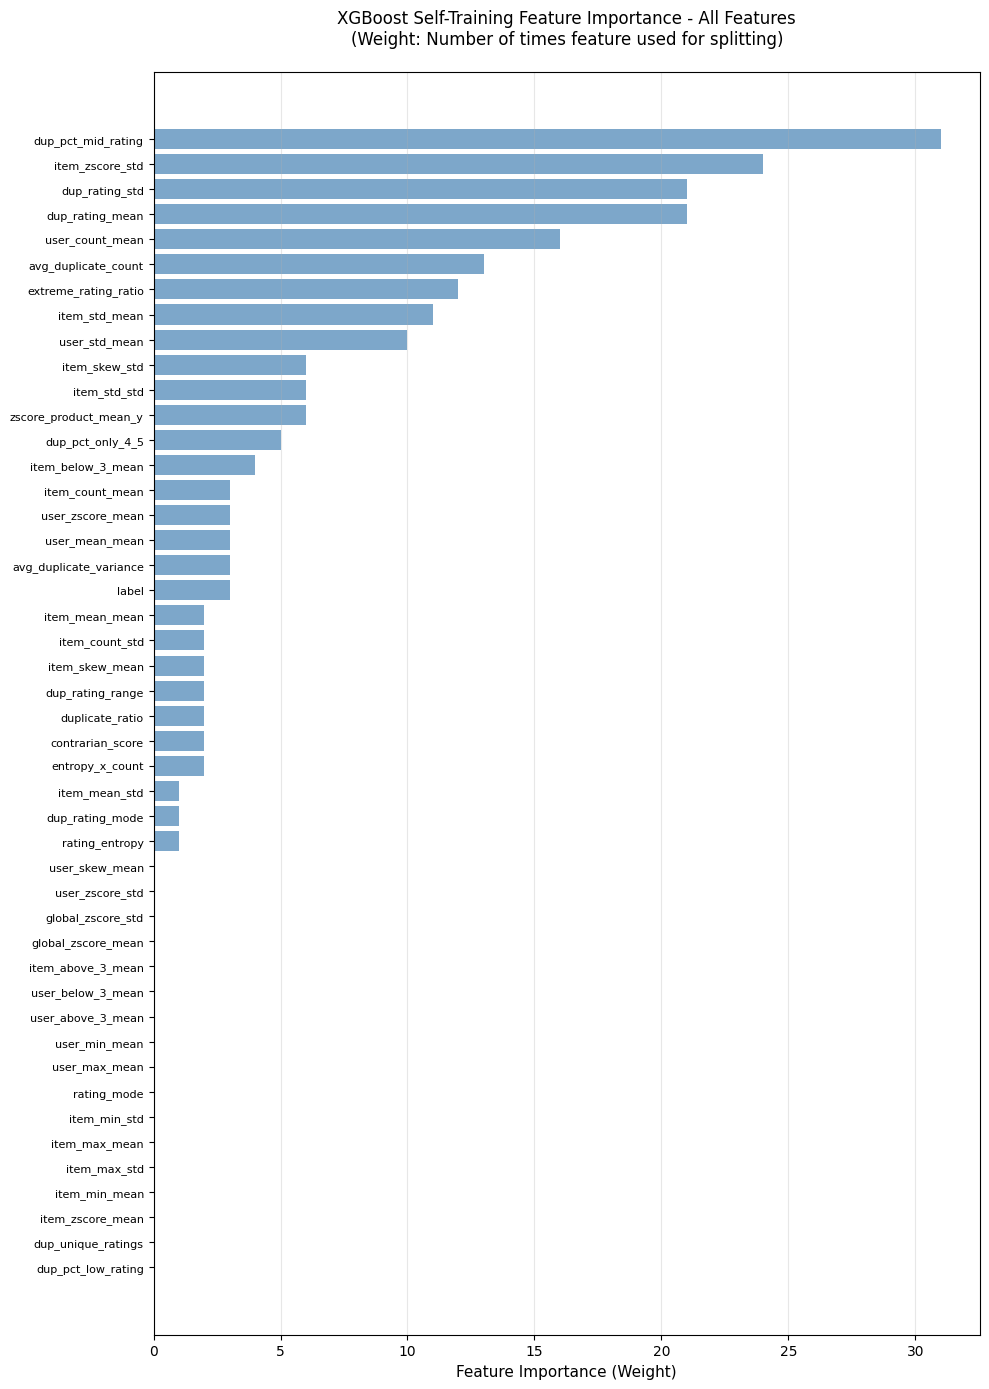

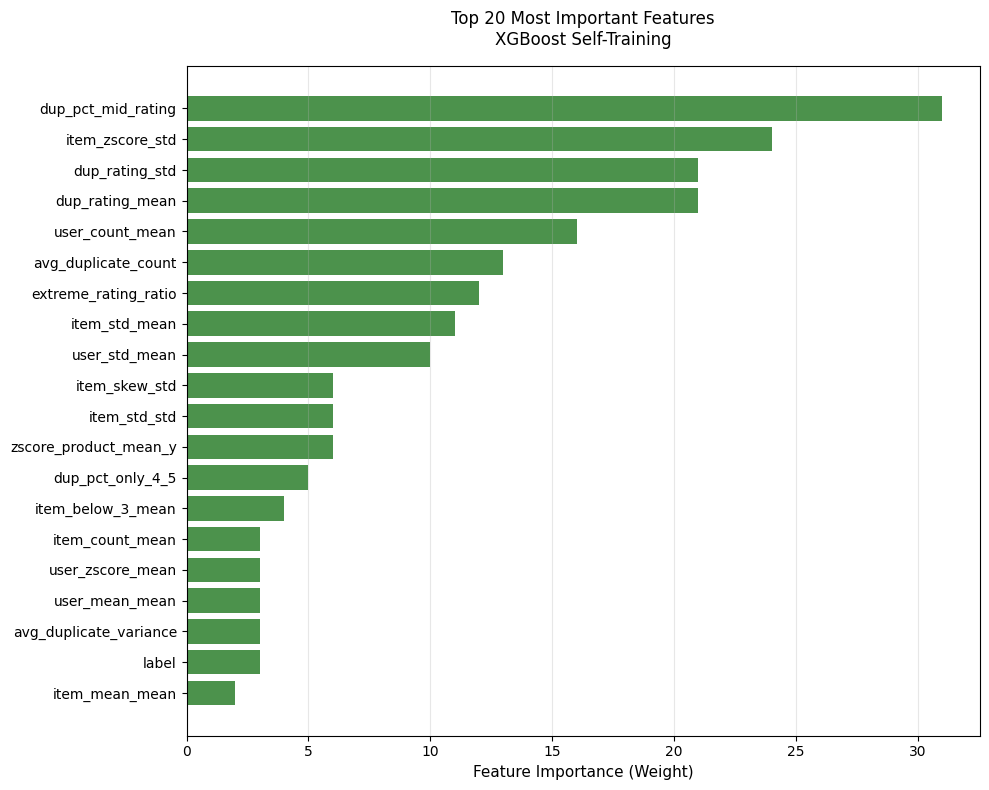

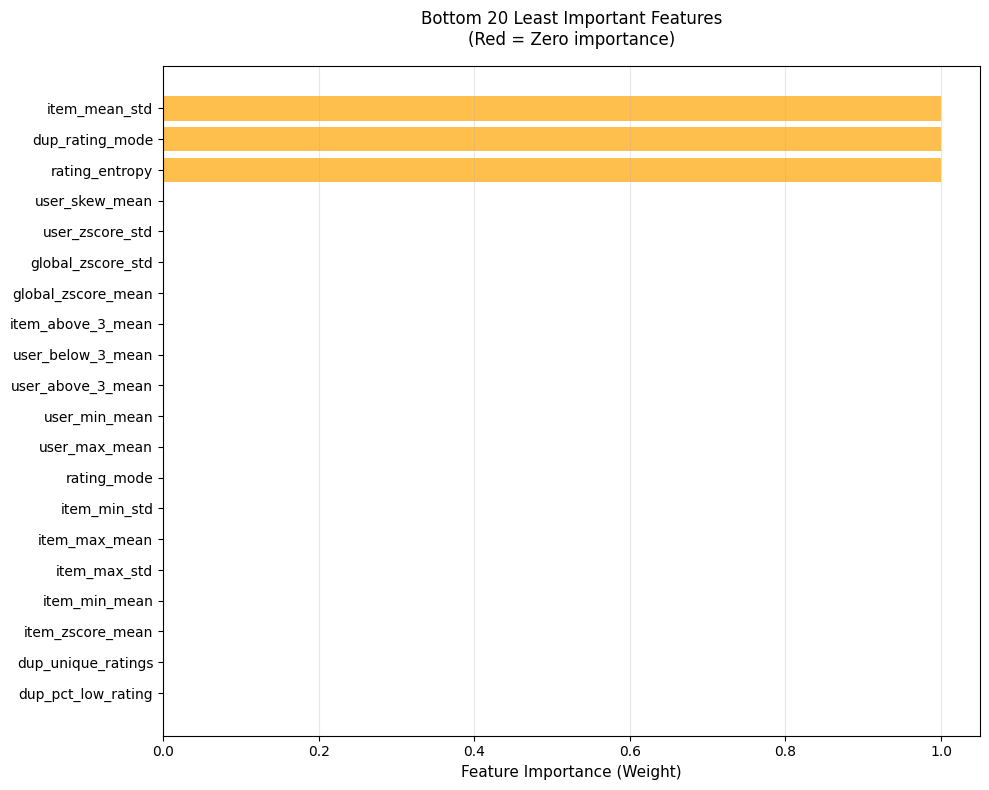

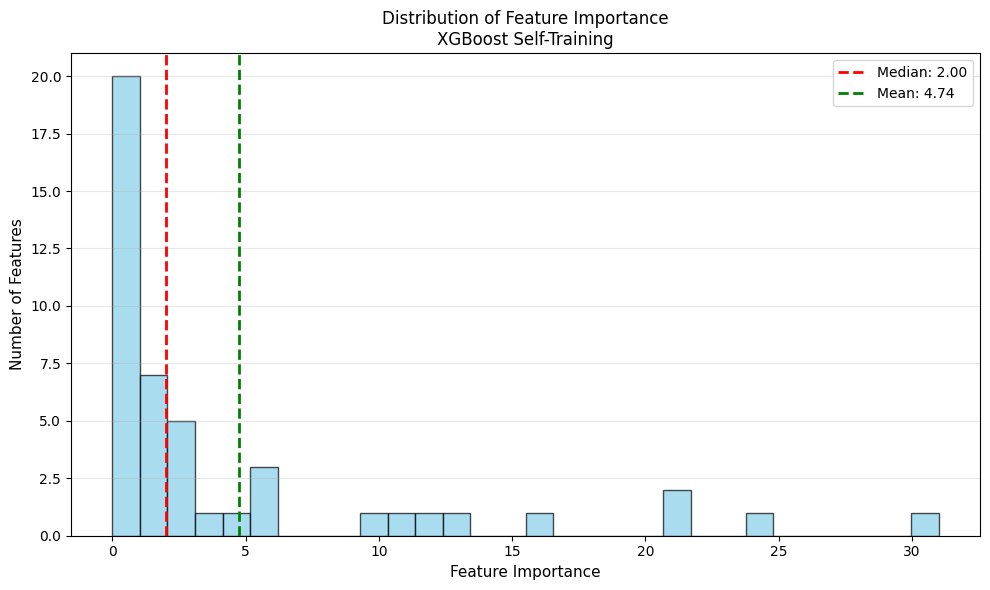

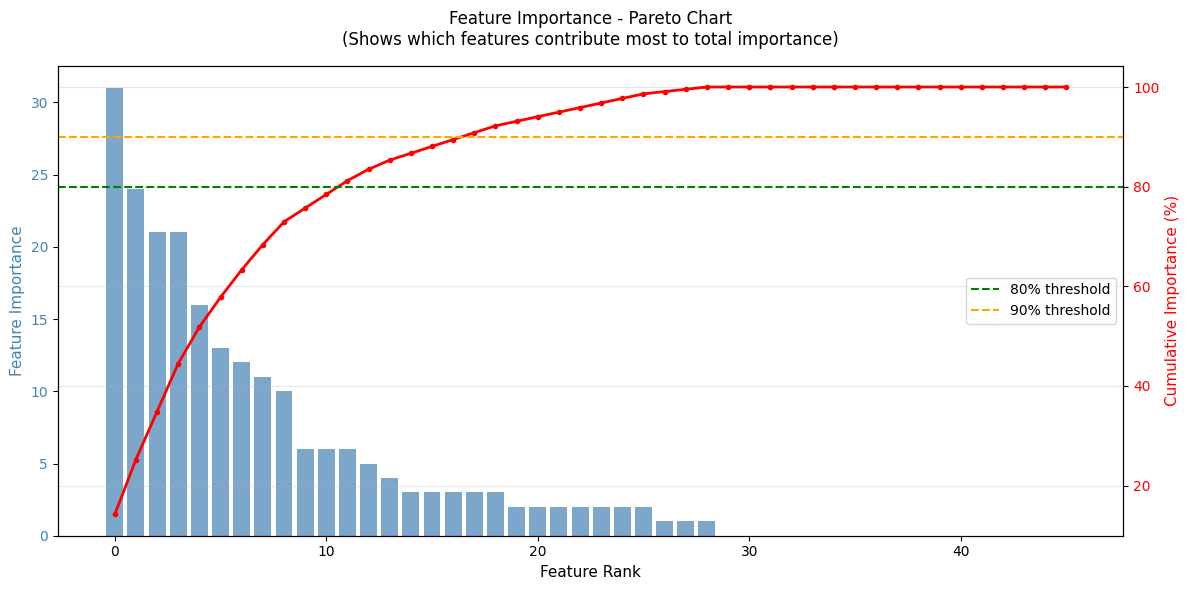


📊 Cumulative Importance Analysis:
  Top 12 features account for 80% of total importance
  Top 18 features account for 90% of total importance
  → The remaining 28 features contribute less than 10% combined.

📋 Variables created:
  'final_model': Trained SelfTrainingClassifier with best params
  'xgb_model': Underlying XGBoost model (for feature importance)
  'importance_df': DataFrame with 46 features and their importance
  'zero_importance_features': List of 17 features with zero weight (candidates for removal)


In [ ]:
# @title Self Training (Extreme Gradient Boosting) Feature Importance using inbuilt function
# ============================================
# XGBoost Self-Training Feature Importance Analysis
# (Run this AFTER the Grid Search CV code)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("\n" + "="*70)
print("XGBOOST SELF-TRAINING FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# ============================================
# STEP 1: Train Final Model with Best Parameters
# ============================================

print("\nTraining final model with best parameters from grid search...")
# Assuming 'best_params' is a dictionary or Series available in the environment.
# Ensure best_params is a dictionary for reliable key access
if isinstance(best_params, pd.Series):
    best_params = best_params.to_dict()

print(f"Using best parameters:")
print(f"  Self-Training: threshold={best_params['threshold']}, max_iter={best_params['max_iter']}")
print(f"  XGBoost: n_est={best_params['n_estimators']}, max_depth={best_params['max_depth']}, lr={best_params['learning_rate']}, sub={best_params['subsample']}")

# Combine ALL labeled and unlabeled data for final training
# Assuming X_semi_labeled, y_semi_labeled, and X_semi_unlabeled are available.
X_full = pd.concat([X_semi_labeled, X_semi_unlabeled], ignore_index=True)
y_full = np.concatenate([
    y_semi_labeled.values,
    np.full(len(X_semi_unlabeled), -1)
])

print(f"\nFull dataset for training:")
print(f"  Labeled samples: {len(X_semi_labeled)}")
print(f"  Unlabeled samples: {len(X_semi_unlabeled)}")
print(f"  Total samples: {len(X_full)}")
print(f"  Features: {X_full.shape[1]}")

# Create base classifier with best parameters
base_classifier = XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    eval_metric='logloss',
    use_label_encoder=False, # Suppress warning
    random_state=42
)

# Create self-training classifier with best parameters
final_model = SelfTrainingClassifier(
    estimator=base_classifier,
    threshold=best_params['threshold'],
    criterion='threshold',
    max_iter=int(best_params['max_iter']),
    verbose=False
)

# Train the model
print("\nTraining self-training model...")
final_model.fit(X_full, y_full)
print("✓ Model training complete")

# Get the underlying trained XGBoost model
if hasattr(final_model, 'estimator_'):
    xgb_model = final_model.estimator_
else:
    xgb_model = final_model.base_estimator_

# ============================================
# STEP 2: Extract Feature Importance
# ============================================

print("\n" + "="*70)
print("EXTRACTING FEATURE IMPORTANCE")
print("="*70)

# Get feature names
feature_names = X_semi_labeled.columns.tolist()

print(f"✓ Extracted importance for {len(feature_names)} features")

# ============================================
# STEP 3: Create DataFrame with All Importance Types
# ============================================

print("\nCalculating multiple importance metrics...")

# Get all importance types
importance_types = ['weight', 'gain', 'cover']
importance_data = {'Feature': feature_names}
feature_mapping = {f'f{i}': feat for i, feat in enumerate(feature_names)}

for imp_type in importance_types:
    try:
        imp_scores = xgb_model.get_booster().get_score(importance_type=imp_type)

        # Map back to feature names (XGBoost uses 'f0', 'f1', etc.)
        imp_values = []
        for feat_name in feature_names:
            key = [k for k, v in feature_mapping.items() if v == feat_name][0]
            imp_values.append(imp_scores.get(key, 0))

        importance_data[f'Importance_{imp_type.capitalize()}'] = imp_values
    except Exception as e:
        print(f"Skipping importance type '{imp_type}' due to error: {e}")

# Fallback/Default: Ensure there's an 'Importance_Weight' column for sorting
if 'Importance_Weight' not in importance_data:
    if len(xgb_model.feature_importances_) == len(feature_names):
        print("⚠️ WARNING: Using xgb_model.feature_importances_ as Importance_Weight for sorting.")
        importance_data['Importance_Weight'] = xgb_model.feature_importances_
    else:
         print("⚠️ CRITICAL ERROR: Cannot retrieve importance scores for sorting.")
         importance_data['Importance_Weight'] = np.zeros(len(feature_names))


# Create DataFrame
importance_df = pd.DataFrame(importance_data)

# Sort by weight (default importance)
importance_df = importance_df.sort_values('Importance_Weight', ascending=False).reset_index(drop=True)

print("✓ Calculated importance metrics")

# ============================================
# STEP 4: Display Results
# ============================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKING")
print("="*70)

top_n = min(15, len(importance_df))
bottom_n = min(20, len(importance_df))

print(f"\nTop {top_n} Most Important Features (Ranked by Weight):")
print(importance_df.head(top_n).to_string(index=False))

print("\n" + "-"*70)

print(f"\nBottom {bottom_n} Least Important Features (Ranked by Weight):")
bottom_20 = importance_df.tail(bottom_n)
print(bottom_20.to_string(index=False))

# ============================================
# STEP 5: Identify Features with ZERO Importance
# ============================================

# Filter for features with exactly 0 weight
zero_importance_df = importance_df[importance_df['Importance_Weight'] == 0]
zero_importance_features = zero_importance_df['Feature'].tolist()
num_zero_features = len(zero_importance_features)

print("\n" + "="*70)
print(f"FEATURES TO REMOVE (ZERO IMPORTANCE - WEIGHT=0)")
print("="*70)
if num_zero_features > 0:
    print(f"\nFound {num_zero_features} feature(s) that were NEVER used for splitting in any tree:")
    for i, feat in enumerate(zero_importance_features, 1):
        # Retrieve the full row for display
        row = zero_importance_df[zero_importance_df['Feature'] == feat].iloc[0]
        imp_weight = row['Importance_Weight']
        imp_gain = row.get('Importance_Gain', 0)
        print(f"  {i:2d}. {feat:30s} - Weight: {imp_weight:.2f}, Gain: {imp_gain:.2f}")

    print("\n" + "-"*70)
    print("Python List Format for Removal:")
    print(zero_importance_features)
else:
    print("\n✅ No features found with an Importance Weight of zero. All features are contributing.")

print("="*70)

# ============================================
# STEP 6: Summary Statistics
# ============================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print(f"\nFeature Importance Statistics:")
print(f"  Mean importance: {importance_df['Importance_Weight'].mean():.6f}")
print(f"  Std importance:  {importance_df['Importance_Weight'].std():.6f}")
print(f"  Max importance:  {importance_df['Importance_Weight'].max():.6f}")
print(f"  Min importance:  {importance_df['Importance_Weight'].min():.6f}")
print(f"  Median:          {importance_df['Importance_Weight'].median():.6f}")

# Re-use zero_importance calculation from the new logic
print(f"\nFeatures with ZERO importance (Candidates for removal): {num_zero_features}")
if num_zero_features > 0:
    print("  ⚠️  These features are NEVER used in any tree split!")

# Categorize features
median_weight = importance_df['Importance_Weight'].median()
high_imp = len(importance_df[importance_df['Importance_Weight'] > median_weight])
low_imp = len(importance_df[importance_df['Importance_Weight'] <= median_weight])

print(f"\nFeature Categories:")
print(f"  Above median: {high_imp}")
print(f"  Below median: {low_imp}")

# Self-Training Statistics
n_labeled_final = len(y_full[y_full != -1])
n_labeled_initial = len(X_semi_labeled)
n_unlabeled_initial = len(X_semi_unlabeled)

print(f"\nSelf-Training Results:")
print(f"  Initial labeled: {n_labeled_initial}")
print(f"  Initial unlabeled: {n_unlabeled_initial}")
print(f"  Final labeled after self-training: {n_labeled_final}")
print(f"  Samples pseudo-labeled: {n_labeled_final - n_labeled_initial}")

# ============================================
# STEP 7: Visualizations
# ============================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: All Features (Horizontal Bar)
plt.figure(figsize=(10, min(14, len(importance_df) * 0.5)))
y_pos = range(len(importance_df))
plt.barh(y_pos, importance_df['Importance_Weight'][::-1],
         color='steelblue', alpha=0.7)
plt.yticks(y_pos, importance_df['Feature'][::-1], fontsize=8)
plt.xlabel('Feature Importance (Weight)', fontsize=11)
plt.title('XGBoost Self-Training Feature Importance - All Features\n(Weight: Number of times feature used for splitting)',
          fontsize=12, pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Top 20 Features Only (unchanged as this is useful context)
plt.figure(figsize=(10, 8))
top_20 = importance_df.head(20)
y_pos_20 = range(len(top_20))
plt.barh(y_pos_20, top_20['Importance_Weight'][::-1],
         color='darkgreen', alpha=0.7)
plt.yticks(y_pos_20, top_20['Feature'][::-1], fontsize=10)
plt.xlabel('Feature Importance (Weight)', fontsize=11)
plt.title('Top 20 Most Important Features\nXGBoost Self-Training',
          fontsize=12, pad=15)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Bottom N Features (now includes zero-importance features, but shows the lowest 20 ranked)
plt.figure(figsize=(10, 8))
y_pos_bottom = range(len(bottom_20))
# Colors specifically highlight zero-importance features in red
colors_bottom = ['red' if x == 0 else 'orange' for x in bottom_20['Importance_Weight'][::-1]]
plt.barh(y_pos_bottom, bottom_20['Importance_Weight'][::-1],
         color=colors_bottom, alpha=0.7)
plt.yticks(y_pos_bottom, bottom_20['Feature'][::-1], fontsize=10)
plt.xlabel('Feature Importance (Weight)', fontsize=11)
plt.title('Bottom 20 Least Important Features\n(Red = Zero importance)',
          fontsize=12, pad=15)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Distribution of Feature Importance
plt.figure(figsize=(10, 6))
plt.hist(importance_df['Importance_Weight'], bins=30,
         color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(median_weight,
             color='red', linestyle='--', linewidth=2,
             label=f'Median: {median_weight:.2f}')
plt.axvline(importance_df['Importance_Weight'].mean(),
             color='green', linestyle='--', linewidth=2,
             label=f'Mean: {importance_df["Importance_Weight"].mean():.2f}')
plt.xlabel('Feature Importance', fontsize=11)
plt.ylabel('Number of Features', fontsize=11)
plt.title('Distribution of Feature Importance\nXGBoost Self-Training', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 5: Cumulative Importance (Pareto Chart)
cumulative_importance = importance_df['Importance_Weight'].cumsum() / importance_df['Importance_Weight'].sum() * 100
x_pos = range(len(importance_df))

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(x_pos, importance_df['Importance_Weight'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Feature Rank', fontsize=11)
ax1.set_ylabel('Feature Importance', fontsize=11, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(x_pos, cumulative_importance, color='red', marker='o', linewidth=2, markersize=3)
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1.5, label='80% threshold')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, label='90% threshold')
ax2.set_ylabel('Cumulative Importance (%)', fontsize=11, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='center right')

plt.title('Feature Importance - Pareto Chart\n(Shows which features contribute most to total importance)',
          fontsize=12, pad=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features account for 80% and 90% of importance
try:
    idx_80 = np.where(cumulative_importance >= 80)[0][0] + 1
    idx_90 = np.where(cumulative_importance >= 90)[0][0] + 1

    print(f"\n📊 Cumulative Importance Analysis:")
    print(f"  Top {idx_80} features account for 80% of total importance")
    print(f"  Top {idx_90} features account for 90% of total importance")
    print(f"  → The remaining {len(importance_df) - idx_90} features contribute less than 10% combined.")
except IndexError:
    print("\n📊 Cumulative Importance Analysis:")
    print("  Could not reach 80% or 90% cumulative importance threshold.")

print(f"\n📋 Variables created:")
print(f"  'final_model': Trained SelfTrainingClassifier with best params")
print(f"  'xgb_model': Underlying XGBoost model (for feature importance)")
print(f"  'importance_df': DataFrame with {len(importance_df)} features and their importance")
print(f"  'zero_importance_features': List of {num_zero_features} features with zero weight (candidates for removal)")
print("="*70)

In [ ]:
# @title Expectation Maximization Naive Bayes Model + Grid Search Results
# ============================================
# GRID SEARCH WITH CV FOR EM + NAIVE BAYES (MODIFIED)
# ============================================

print("\n" + "="*70)
print("GRID SEARCH WITH CROSS-VALIDATION - EM + NAIVE BAYES (CONFIDENCE TUNING)")
print("="*70)

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assume X_semi_labeled, y_semi_labeled, X_semi_unlabeled are defined

# ============================================
# STEP 1: Define hyperparameter grid (MODIFIED)
# ============================================

param_grid = {
    'var_smoothing': np.logspace(-12, -7, 50),  # Smoothing parameter for stability
    'max_iter': [50],  # EM iterations
    'use_weights': [True, False],  # Weight samples by confidence
    'convergence_tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],  # Convergence threshold
    # --- NEW PARAMETER ---
    'confidence_threshold': [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99] # Minimum confidence to use unlabeled sample
    # ---------------------
}

print(f"\nHyperparameter Grid:")
print(f"  var_smoothing: {len(param_grid['var_smoothing'])} values (log scale)")
print(f"  max_iter: {param_grid['max_iter']}")
print(f"  use_weights: {param_grid['use_weights']}")
print(f"  convergence_tol: {param_grid['convergence_tol']}")
print(f"  confidence_threshold: {param_grid['confidence_threshold']} (NEW)")

# Calculate total combinations (UPDATED)
total_combinations = (len(param_grid['var_smoothing']) *
                      len(param_grid['max_iter']) *
                      len(param_grid['use_weights']) *
                      len(param_grid['convergence_tol']) *
                      len(param_grid['confidence_threshold']))
print(f"\nTotal combinations: {total_combinations}")

# ============================================
# STEP 2: Setup CV (UNCHANGED)
# ============================================

n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

X_labeled = X_semi_labeled.copy()
y_labeled = y_semi_labeled.copy()
X_unlabeled = X_semi_unlabeled.copy()

print(f"\nCV Setup:")
# print(f"  Labeled samples: {len(X_labeled)}") # Uncomment if these vars are defined
# print(f"  Unlabeled samples: {len(X_unlabeled)}") # Uncomment if these vars are defined
print(f"  CV folds: {n_folds}")


# ============================================
# STEP 3: Grid Search (SCALING + EM IMPLEMENTED HERE) (MODIFIED)
# ============================================

print(f"\n{'='*70}")
print(f"STARTING GRID SEARCH (with StandardScaler + EM)")
print(f"{'='*70}")

# Store results for each parameter combination
grid_search_results = []
param_counter = 0

# Loop through all parameter combinations (NEW NESTED LOOP)
for var_smooth in param_grid['var_smoothing']:
    for max_iter in param_grid['max_iter']:
        for use_weights in param_grid['use_weights']:
            for conv_tol in param_grid['convergence_tol']:
                for conf_thresh in param_grid['confidence_threshold']: # NEW LOOP
                    param_counter += 1
                    params = {
                        'var_smoothing': var_smooth,
                        'max_iter': max_iter,
                        'use_weights': use_weights,
                        'convergence_tol': conv_tol,
                        'confidence_threshold': conf_thresh # NEW
                    }

                    print(f"\n[{param_counter}/{total_combinations}] Testing:")
                    print(f"  var_smoothing={var_smooth:.2e}, max_iter={max_iter}, "
                          f"weights={use_weights}, tol={conv_tol}, **thresh={conf_thresh}**") # UPDATED PRINT

                    # Cross-validation for this parameter combination
                    fold_accuracies = []
                    fold_em_iters = []  # Track EM iterations

                    for fold, (train_idx, val_idx) in enumerate(cv.split(X_labeled, y_labeled)):
                        # --- SCALING: FIT and TRANSFORM --- (UNCHANGED)
                        # ... (Scaling logic remains here)
                        X_train = X_labeled.iloc[train_idx]
                        y_train = y_labeled.iloc[train_idx]
                        X_val = X_labeled.iloc[val_idx]
                        y_val = y_labeled.iloc[val_idx]
                        X_train_unlabeled = pd.concat([X_train, X_unlabeled], ignore_index=True)
                        scaler = StandardScaler()
                        scaler.fit(X_train_unlabeled)
                        X_train_scaled = scaler.transform(X_train)
                        X_unlabeled_scaled = scaler.transform(X_unlabeled)
                        X_val_scaled = scaler.transform(X_val)
                        # --- END SCALING ---

                        # --- EM ALGORITHM --- (MODIFIED)
                        nb = GaussianNB(var_smoothing=var_smooth)
                        nb.fit(X_train_scaled, y_train)

                        prev_probs = None
                        actual_iters = 0

                        # EM iterations
                        for iteration in range(max_iter):
                            actual_iters += 1

                            # E-step: Get probability distributions for unlabeled
                            probs_unlabeled = nb.predict_proba(X_unlabeled_scaled)

                            # Check convergence
                            if prev_probs is not None:
                                change = np.abs(probs_unlabeled - prev_probs).mean()
                                if change < conv_tol:
                                    break
                            prev_probs = probs_unlabeled.copy()

                            # M-step: Retrain with soft/weighted labels (CORE LOGIC MODIFIED)

                            # 1. Identify high-confidence samples
                            max_probs = probs_unlabeled.max(axis=1)
                            # Create a mask for samples above the threshold
                            high_conf_mask = max_probs >= conf_thresh

                            # Filter unlabeled data to include only high-confidence samples
                            X_unlabeled_conf = X_unlabeled_scaled[high_conf_mask]
                            probs_unlabeled_conf = probs_unlabeled[high_conf_mask]

                            # Get the number of high-confidence samples
                            n_unlabeled_conf = len(X_unlabeled_conf)

                            if n_unlabeled_conf == 0:
                                # If no unlabeled samples meet the threshold, just retrain on the labeled data
                                X_combined = X_train_scaled
                                y_combined = y_train.values
                                weights = np.ones(len(X_train_scaled))
                                # Continue to the next EM iteration
                                # (or consider breaking/logging that no new information was added)
                                # For now, we continue the iteration with the existing model
                                # to allow for convergence check in the next loop.
                                pass
                            else:
                                # 2. Combine labeled and high-confidence unlabeled data
                                X_combined = np.vstack([X_train_scaled, X_unlabeled_conf])

                                # Get hard labels for high-confidence unlabeled
                                y_unlabeled_pred = probs_unlabeled_conf.argmax(axis=1)
                                y_combined = np.hstack([y_train.values, y_unlabeled_pred])

                                # 3. Create sample weights
                                if use_weights:
                                    # Labeled data: weight = 1.0
                                    weights_labeled = np.ones(len(X_train))
                                    # High-confidence unlabeled data: weight = confidence (max probability)
                                    weights_unlabeled = max_probs[high_conf_mask] # Use the filtered max_probs
                                    weights = np.hstack([weights_labeled, weights_unlabeled])
                                else:
                                    # Equal weights for all (labeled and high-confidence unlabeled)
                                    weights = np.ones(len(X_combined))

                                # 4. Retrain Naive Bayes with weighted samples
                                nb.fit(X_combined, y_combined, sample_weight=weights)

                        # --- END EM ---

                        # Predict on validation (UNCHANGED)
                        y_pred = nb.predict(X_val_scaled)
                        accuracy = accuracy_score(y_val, y_pred)
                        fold_accuracies.append(accuracy)
                        fold_em_iters.append(actual_iters)

                    # Calculate mean and std (UNCHANGED)
                    mean_acc = np.mean(fold_accuracies)
                    std_acc = np.std(fold_accuracies)
                    mean_iters = np.mean(fold_em_iters)

                    print(f"  Mean CV Accuracy: {mean_acc:.4f} (+/- {std_acc:.4f})")
                    print(f"  Avg EM iterations: {mean_iters:.1f}")

                    # Store results (UPDATED to include 'confidence_threshold')
                    grid_search_results.append({
                        'var_smoothing': var_smooth,
                        'max_iter': max_iter,
                        'use_weights': use_weights,
                        'convergence_tol': conv_tol,
                        'confidence_threshold': conf_thresh,
                        'mean_cv_accuracy': mean_acc,
                        'std_cv_accuracy': std_acc,
                        'mean_em_iterations': mean_iters,
                        'fold_accuracies': fold_accuracies
                    })

# ============================================
# STEP 4: Find Best Parameters (UPDATED)
# ============================================

print(f"\n{'='*70}")
print(f"GRID SEARCH RESULTS")
print(f"{'='*70}")

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(grid_search_results)

# Sort by mean CV accuracy (descending)
results_df = results_df.sort_values('mean_cv_accuracy', ascending=False).reset_index(drop=True)

print(f"\nTop 50 parameter combinations:")
print(results_df[['var_smoothing', 'max_iter', 'use_weights', 'convergence_tol',
                  'confidence_threshold', 'mean_cv_accuracy', 'std_cv_accuracy',
                  'mean_em_iterations']].head(50)) # UPDATED COLUMNS

# Best parameters
best_params = results_df.iloc[0]

print(f"\n{'='*70}")
print(f"BEST PARAMETERS")
print(f"{'='*70}")
print(f"  var_smoothing: {best_params['var_smoothing']:.2e}")
print(f"  max_iter: {best_params['max_iter']}")
print(f"  use_weights: {best_params['use_weights']}")
print(f"  convergence_tol: {best_params['convergence_tol']}")
print(f"  confidence_threshold: {best_params['confidence_threshold']} (NEW)")
print(f"\n  Mean CV Accuracy: {best_params['mean_cv_accuracy']:.4f}")
print(f"  Std CV Accuracy:  {best_params['std_cv_accuracy']:.4f}")
print(f"  Avg EM Iterations: {best_params['mean_em_iterations']:.1f}")

# ... (Rest of Step 5: Saving and Visualization)

Streaming output truncated to the last 5000 lines.
  Avg EM iterations: 7.8

[3936/4900] Testing:
  var_smoothing=1.21e-08, max_iter=50, weights=True, tol=1e-05, **thresh=0.6**
  Mean CV Accuracy: 0.9500 (+/- 0.0408)
  Avg EM iterations: 9.2

[3937/4900] Testing:
  var_smoothing=1.21e-08, max_iter=50, weights=True, tol=1e-05, **thresh=0.7**
  Mean CV Accuracy: 0.9500 (+/- 0.0408)
  Avg EM iterations: 8.0

[3938/4900] Testing:
  var_smoothing=1.21e-08, max_iter=50, weights=True, tol=1e-05, **thresh=0.8**
  Mean CV Accuracy: 0.9500 (+/- 0.0408)
  Avg EM iterations: 8.4

[3939/4900] Testing:
  var_smoothing=1.21e-08, max_iter=50, weights=True, tol=1e-05, **thresh=0.9**
  Mean CV Accuracy: 0.9500 (+/- 0.0408)
  Avg EM iterations: 8.0

[3940/4900] Testing:
  var_smoothing=1.21e-08, max_iter=50, weights=True, tol=1e-05, **thresh=0.95**
  Mean CV Accuracy: 0.9500 (+/- 0.0408)
  Avg EM iterations: 7.4

[3941/4900] Testing:
  var_smoothing=1.21e-08, max_iter=50, weights=True, tol=1e-05, **thres

In [ ]:
# @title Expectation Maximization Naive Bayes final training results
# ============================================
# STEP 6: Calculate Predicted Class Counts 🔢
# ============================================
print(f"\n{'='*70}")
print(f"PREDICTED CLASS DISTRIBUTION COUNTS")
print(f"{'='*70}")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd

# Assume X_labeled, X_unlabeled, y_labeled, and best_params are defined from previous steps.

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of labeled samples
N_LABELED = len(X_labeled)
N_UNLABELED = len(X_unlabeled)

# 2. Scale Full Data (Fit on all data)
scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

# 3. Re-train the BEST Model on ALL available data with EM
print(f"Retraining best EM+NB model on full dataset...")
print(f"  var_smoothing: {best_params['var_smoothing']:.2e}")
print(f"  max_iter: {best_params['max_iter']}")
print(f"  use_weights: {best_params['use_weights']}")
print(f"  convergence_tol: {best_params['convergence_tol']}")

# Split scaled data into labeled and unlabeled portions
X_labeled_scaled = X_full_scaled[:N_LABELED]
X_unlabeled_scaled = X_full_scaled[N_LABELED:]
y_labeled_only = y_labeled.values

# Initialize Naive Bayes with best parameters
final_nb = GaussianNB(var_smoothing=best_params['var_smoothing'])
final_nb.fit(X_labeled_scaled, y_labeled_only)

# Run EM algorithm with best parameters
prev_probs = None
final_em_iters = 0

print(f"\nRunning EM iterations...")
for iteration in range(int(best_params['max_iter'])):
    final_em_iters += 1

    # E-step: Get probability distributions for unlabeled data
    probs_unlabeled = final_nb.predict_proba(X_unlabeled_scaled)

    # Check convergence
    if prev_probs is not None:
        change = np.abs(probs_unlabeled - prev_probs).mean()
        if change < best_params['convergence_tol']:
            print(f"  Converged after {final_em_iters} iterations (change: {change:.6f})")
            break

    prev_probs = probs_unlabeled.copy()

    # M-step: Retrain with soft/weighted labels
    # Combine labeled and unlabeled data
    X_combined = np.vstack([X_labeled_scaled, X_unlabeled_scaled])

    # Get hard labels for unlabeled (most likely class)
    y_unlabeled_pred = probs_unlabeled.argmax(axis=1)
    y_combined = np.hstack([y_labeled_only, y_unlabeled_pred])

    # Create sample weights
    if best_params['use_weights']:
        # Labeled data: weight = 1.0
        weights_labeled = np.ones(N_LABELED)
        # Unlabeled data: weight = confidence (max probability)
        weights_unlabeled = probs_unlabeled.max(axis=1)
        weights = np.hstack([weights_labeled, weights_unlabeled])
    else:
        # Equal weights for all
        weights = np.ones(len(X_combined))

    # Retrain Naive Bayes with weighted samples
    final_nb.fit(X_combined, y_combined, sample_weight=weights)

if final_em_iters == int(best_params['max_iter']):
    print(f"  Reached maximum iterations ({final_em_iters})")

print("Final EM+NB model trained.")

# 4. Predict labels for the entire dataset
# Renamed variable to y_predicted_full_em as requested
y_predicted_full_em = final_nb.predict(X_full_scaled)

# 5. Get prediction confidence/probabilities
y_predicted_probs = final_nb.predict_proba(X_full_scaled)
prediction_confidence = y_predicted_probs.max(axis=1)

# 6. Split predictions into labeled and unlabeled portions
y_labeled_true = y_labeled.values
# Updated to use the new variable name
y_labeled_pred = y_predicted_full_em[:N_LABELED]
y_unlabeled_pred = y_predicted_full_em[N_LABELED:]

# 7. Calculate Accuracy for Labeled Data
labeled_accuracy = accuracy_score(y_labeled_true, y_labeled_pred)
print(f"\n✓ Labeled Data Accuracy: {labeled_accuracy:.4f} ({int(labeled_accuracy * N_LABELED)}/{N_LABELED} correct)")

# 8. Generate Confusion Matrix for Labeled Data
print(f"\n{'='*70}")
print("CONFUSION MATRIX - LABELED DATA")
print(f"{'='*70}")

conf_matrix = confusion_matrix(y_labeled_true, y_labeled_pred)
class_labels = sorted(np.unique(y_labeled_true))

# Create a formatted confusion matrix DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f'True Class {i}' for i in class_labels],
    columns=[f'Pred Class {i}' for i in class_labels]
)

print("\nConfusion Matrix:")
print(conf_matrix_df)

# Calculate per-class accuracy
print("\nPer-Class Performance (Labeled Data):")
print("-" * 60)
for i, class_label in enumerate(class_labels):
    true_positives = conf_matrix[i, i]
    total_true = conf_matrix[i, :].sum()
    class_accuracy = true_positives / total_true if total_true > 0 else 0
    print(f"  Class {class_label}: {true_positives}/{total_true} correct ({class_accuracy:.2%})")

# 9. Generate Classification Report
print(f"\n{'='*70}")
print("CLASSIFICATION REPORT - LABELED DATA")
print(f"{'='*70}")
print(classification_report(y_labeled_true, y_labeled_pred,
                            target_names=[f'Class {i}' for i in class_labels],
                            digits=4))

# 10. Calculate and Display Counts
print(f"\n{'='*70}")
print("PREDICTED CLASS DISTRIBUTION")
print(f"{'='*70}")

# Convert to DataFrame for easy handling
distribution_df = pd.DataFrame({
    # Updated to use the new variable name
    'Predicted_Label': y_predicted_full_em.astype(int),
    'Confidence': prediction_confidence,
    'Is_Labeled': [True] * N_LABELED + [False] * N_UNLABELED
})

# Add true labels for labeled portion
distribution_df['True_Label'] = np.concatenate([y_labeled_true, np.full(N_UNLABELED, -1)])

# Calculate counts for labeled data (with correctness)
labeled_df = distribution_df[distribution_df['Is_Labeled'] == True].copy()
labeled_correct = labeled_df[labeled_df['Predicted_Label'] == labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_incorrect = labeled_df[labeled_df['Predicted_Label'] != labeled_df['True_Label']].groupby('Predicted_Label').size()
labeled_total = labeled_df.groupby('Predicted_Label').size()

# Calculate counts for unlabeled data
unlabeled_counts = distribution_df[distribution_df['Is_Labeled'] == False]['Predicted_Label'].value_counts().sort_index()

# Combine and format the results table
all_labels = sorted(distribution_df['Predicted_Label'].unique())
all_counts = pd.DataFrame(index=all_labels)

all_counts['Labeled_Correct'] = labeled_correct
all_counts['Labeled_Incorrect'] = labeled_incorrect
all_counts['Labeled_Total'] = labeled_total
all_counts['Unlabeled'] = unlabeled_counts
all_counts = all_counts.fillna(0).astype(int)
all_counts['Total_Samples'] = all_counts['Labeled_Total'] + all_counts['Unlabeled']

# Add accuracy column
all_counts['Labeled_Accuracy'] = (all_counts['Labeled_Correct'] / all_counts['Labeled_Total']).fillna(0)
all_counts['Labeled_Accuracy'] = all_counts['Labeled_Accuracy'].apply(lambda x: f"{x:.2%}")

print("\nFinal Predicted Class Distribution:")
print("-" * 100)
print(all_counts)

# 11. Additional Statistics for EM+NB
print(f"\n{'='*70}")
print(f"PREDICTION CONFIDENCE STATISTICS")
print(f"{'='*70}")

# Confidence statistics for labeled data
labeled_confidence = distribution_df[distribution_df['Is_Labeled'] == True]['Confidence']
print(f"\nLabeled Data Predictions:")
print(f"  Mean Confidence: {labeled_confidence.mean():.4f}")
print(f"  Std Confidence:  {labeled_confidence.std():.4f}")
print(f"  Min Confidence:  {labeled_confidence.min():.4f}")
print(f"  Max Confidence:  {labeled_confidence.max():.4f}")

# Confidence statistics for unlabeled data
unlabeled_confidence = distribution_df[distribution_df['Is_Labeled'] == False]['Confidence']
print(f"\nUnlabeled Data Pseudo-labels:")
print(f"  Mean Confidence: {unlabeled_confidence.mean():.4f}")
print(f"  Std Confidence:  {unlabeled_confidence.std():.4f}")
print(f"  Min Confidence:  {unlabeled_confidence.min():.4f}")
print(f"  Max Confidence:  {unlabeled_confidence.max():.4f}")

# Show confidence distribution by class for unlabeled data
print(f"\nUnlabeled Pseudo-label Confidence by Class:")
for label in all_labels:
    class_mask = (distribution_df['Predicted_Label'] == label) & (distribution_df['Is_Labeled'] == False)
    class_confidence = distribution_df[class_mask]['Confidence']
    if len(class_confidence) > 0:
        print(f"  Class {label}: {class_confidence.mean():.4f} (+/- {class_confidence.std():.4f}) "
              f"[n={len(class_confidence)}]")

print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Total Labeled Samples: {N_LABELED}")
print(f"  Correctly Predicted: {(y_labeled_true == y_labeled_pred).sum()} ({labeled_accuracy:.2%})")
print(f"  Incorrectly Predicted: {(y_labeled_true != y_labeled_pred).sum()} ({1-labeled_accuracy:.2%})")
print(f"\nTotal Unlabeled Samples: {N_UNLABELED}")
print(f"Total Dataset Samples: {len(X_full)}")
print(f"EM Iterations Used: {final_em_iters}")
print(f"Number of Classes: {len(all_labels)}")
print(f"{'='*70}")


PREDICTED CLASS DISTRIBUTION COUNTS
Retraining best EM+NB model on full dataset...
  var_smoothing: 1.00e-07
  max_iter: 50
  use_weights: False
  convergence_tol: 0.1

Running EM iterations...
  Converged after 2 iterations (change: 0.010615)
Final EM+NB model trained.

✓ Labeled Data Accuracy: 0.9333 (56/60 correct)

CONFUSION MATRIX - LABELED DATA

Confusion Matrix:
              Pred Class 0  Pred Class 1  Pred Class 2
True Class 0            20             0             0
True Class 1             1            18             1
True Class 2             2             0            18

Per-Class Performance (Labeled Data):
------------------------------------------------------------
  Class 0: 20/20 correct (100.00%)
  Class 1: 18/20 correct (90.00%)
  Class 2: 18/20 correct (90.00%)

CLASSIFICATION REPORT - LABELED DATA
              precision    recall  f1-score   support

     Class 0     0.8696    1.0000    0.9302        20
     Class 1     1.0000    0.9000    0.9474        20
   


VISUALIZING LABEL SPACE (t-SNE)
Retraining best EM+NB model on full dataset...
  var_smoothing: 6.55e-12
  max_iter: 50
  use_weights: False
  convergence_tol: 0.1
Running EM iterations...
  Converged after 2 iterations (change: 0.012006)
Final EM+NB model trained.
Probability distribution shape: (3600, 3)
  (N_samples=3600, N_classes=3)
Running t-SNE for dimensionality reduction on probability distributions...
t-SNE complete.


/tmp/ipython-input-407997276.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', N_CLASSES_TRUE)
/tmp/ipython-input-407997276.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, data in plot_df.groupby('Label'):
/tmp/ipython-input-407997276.py:147: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


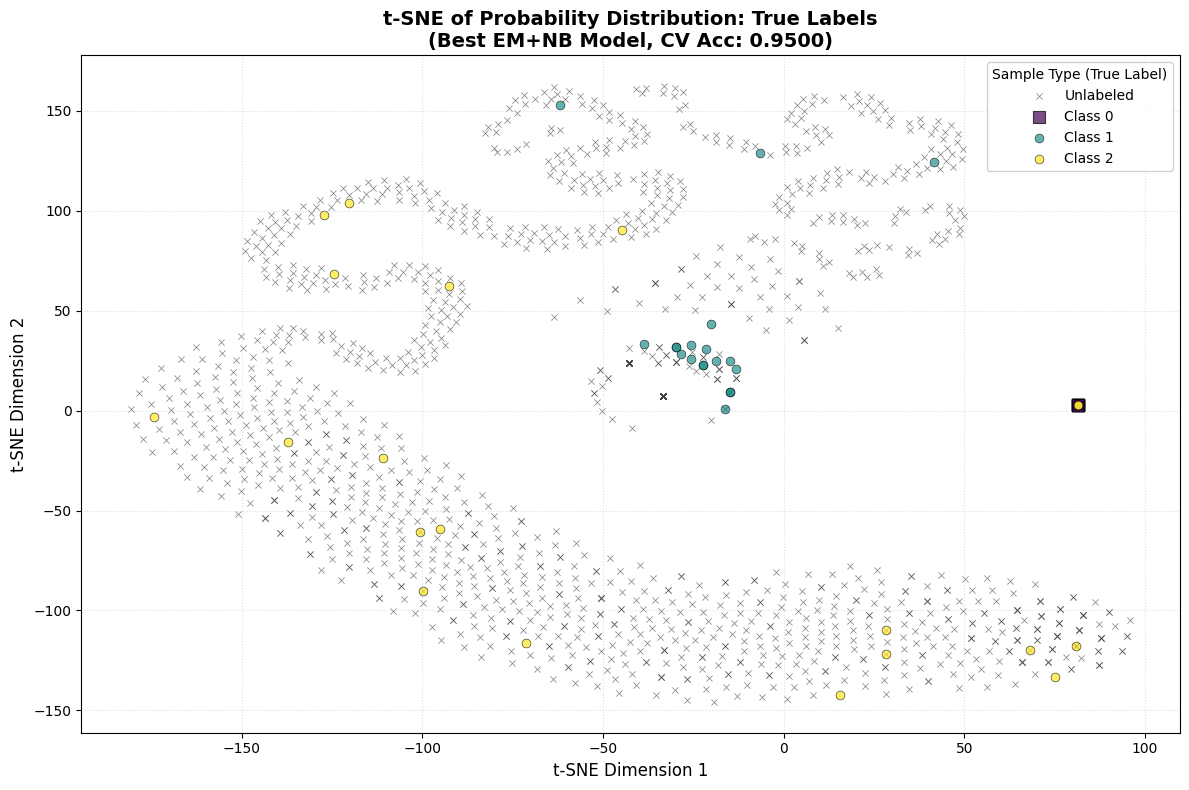


VISUALIZATION STATISTICS
Total samples visualized: 3600
  Labeled: 60
  Unlabeled: 3540
Number of classes: 3
EM iterations used: 2

Visualization successful. The plot shows:
  How samples cluster based on their probability distributions (true labels)
  Class 0 is displayed with SQUARE markers and larger size for distinction


In [ ]:
# @title Expectation Maximization t-SNE visualisation
# ============================================
# STEP 7: Visualize Label Space (t-SNE) 📊
# ============================================
print(f"\n{'='*70}")
print(f"VISUALIZING LABEL SPACE (t-SNE)")
print(f"{'='*70}")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Prepare Full Dataset for Final Training
# Combine all labeled and unlabeled data
X_full = pd.concat([X_labeled, X_unlabeled], ignore_index=True)
y_full = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])

# Determine the number of labeled samples and classes
N_LABELED = len(X_labeled)
N_UNLABELED = len(X_unlabeled)
N_CLASSES_TRUE = len(np.unique(y_labeled))

# 2. Scale Full Data (Fit on all data)
scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

# 3. Re-train the BEST EM+NB Model on ALL available data
print(f"Retraining best EM+NB model on full dataset...")
print(f"  var_smoothing: {best_params['var_smoothing']:.2e}")
print(f"  max_iter: {best_params['max_iter']}")
print(f"  use_weights: {best_params['use_weights']}")
print(f"  convergence_tol: {best_params['convergence_tol']}")

# Split scaled data into labeled and unlabeled portions
X_labeled_scaled = X_full_scaled[:N_LABELED]
X_unlabeled_scaled = X_full_scaled[N_LABELED:]
y_labeled_only = y_labeled.values

# Initialize Naive Bayes with best parameters
final_nb = GaussianNB(var_smoothing=best_params['var_smoothing'])
final_nb.fit(X_labeled_scaled, y_labeled_only)

# Run EM algorithm with best parameters
prev_probs = None
final_em_iters = 0

print(f"Running EM iterations...")
for iteration in range(int(best_params['max_iter'])):
    final_em_iters += 1

    # E-step: Get probability distributions for unlabeled data
    probs_unlabeled = final_nb.predict_proba(X_unlabeled_scaled)

    # Check convergence
    if prev_probs is not None:
        change = np.abs(probs_unlabeled - prev_probs).mean()
        if change < best_params['convergence_tol']:
            print(f"  Converged after {final_em_iters} iterations (change: {change:.6f})")
            break

    prev_probs = probs_unlabeled.copy()

    # M-step: Retrain with soft/weighted labels
    X_combined = np.vstack([X_labeled_scaled, X_unlabeled_scaled])
    y_unlabeled_pred = probs_unlabeled.argmax(axis=1)
    y_combined = np.hstack([y_labeled_only, y_unlabeled_pred])

    # Create sample weights
    if best_params['use_weights']:
        weights_labeled = np.ones(N_LABELED)
        weights_unlabeled = probs_unlabeled.max(axis=1)
        weights = np.hstack([weights_labeled, weights_unlabeled])
    else:
        weights = np.ones(len(X_combined))

    # Retrain Naive Bayes
    final_nb.fit(X_combined, y_combined, sample_weight=weights)

if final_em_iters == int(best_params['max_iter']):
    print(f"  Reached maximum iterations ({final_em_iters})")

print("Final EM+NB model trained.")

# 4. Extract "Features" (The probability distributions from Naive Bayes)
X_features = final_nb.predict_proba(X_full_scaled)

print(f"Probability distribution shape: {X_features.shape}")
print(f"  (N_samples={X_features.shape[0]}, N_classes={X_features.shape[1]})")

# 5. Run t-SNE
print("Running t-SNE for dimensionality reduction on probability distributions...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    random_state=42,
    learning_rate='auto',
    init='pca',
    n_jobs=-1
)
X_tsne = tsne.fit_transform(X_features)
print("t-SNE complete.")

# 6. Prepare Plotting Data
y_true_all = np.concatenate([y_labeled.values, np.full(len(X_unlabeled), -1)])
y_plot = y_true_all.astype(str)
y_plot[len(y_labeled):] = 'Unlabeled'

# Create DataFrame
plot_df = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'])
plot_df['Label'] = y_plot

# Map labeled classes
label_mapping = {str(i): f'Class {i}' for i in range(N_CLASSES_TRUE)}
label_mapping['Unlabeled'] = 'Unlabeled'
plot_df['Label'] = plot_df['Label'].map(label_mapping).fillna('Unlabeled')

# Sort to ensure unlabeled points are plotted first (as background)
categories = ['Unlabeled'] + [f'Class {i}' for i in range(N_CLASSES_TRUE)]
plot_df['Label'] = pd.Categorical(plot_df['Label'], categories=categories)
plot_df = plot_df.sort_values(by='Label')

# 7. Plot - True Labels Visualization with Distinct Class 0
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors, markers, and sizes
colors = plt.cm.get_cmap('viridis', N_CLASSES_TRUE)
color_map = {f'Class {i}': colors(i) for i in range(N_CLASSES_TRUE)}
color_map['Unlabeled'] = '#444444'  # Light gray for background

# Make Class 0 distinctive with different marker and size
marker_map = {
    'Unlabeled': 'x',
    'Class 0': 's',  # Square marker for Class 0
    'Class 1': 'o',  # Circle for Class 1
    'Class 2': 'o'   # Circle for Class 2
}

size_map = {
    'Unlabeled': 20,
    'Class 0': 80,   # Larger size for Class 0
    'Class 1': 40,   # Standard size for Class 1
    'Class 2': 40    # Standard size for Class 2
}

# Plot each label group
for label, data in plot_df.groupby('Label'):
    ax.scatter(
        data['TSNE_1'], data['TSNE_2'],
        c=[color_map[label]],
        s=size_map.get(label, 40),
        label=label,
        alpha=0.7,
        marker=marker_map.get(label, 'o'),
        edgecolors='black' if label != 'Unlabeled' else 'none',
        linewidths=0.8 if label == 'Class 0' else 0.5
    )

ax.set_title(f't-SNE of Probability Distribution: True Labels\n(Best EM+NB Model, CV Acc: {best_params["mean_cv_accuracy"]:.4f})',
             fontsize=14, fontweight='bold')
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.legend(title='Sample Type (True Label)', loc='best', framealpha=0.9)
ax.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

# 8. Statistics
print(f"\n{'='*70}")
print(f"VISUALIZATION STATISTICS")
print(f"{'='*70}")
print(f"Total samples visualized: {len(plot_df)}")
print(f"  Labeled: {N_LABELED}")
print(f"  Unlabeled: {N_UNLABELED}")
print(f"Number of classes: {N_CLASSES_TRUE}")
print(f"EM iterations used: {final_em_iters}")

print("\nVisualization successful. The plot shows:")
print("  How samples cluster based on their probability distributions (true labels)")
print("  Class 0 is displayed with SQUARE markers and larger size for distinction")
print(f"{'='*70}")


SHAP ANALYSIS FOR EM + NAIVE BAYES
(Uses final trained GaussianNB model)

Training final EM model with best parameters...
✓ Model trained (EM converged in 14 iterations).

Creating SHAP Explainer (Model-Agnostic KernelExplainer)...

Calculating SHAP values for ALL 60 labeled samples...


  0%|          | 0/60 [00:00<?, ?it/s]

✓ SHAP values calculated

FEATURE IMPORTANCE (by mean absolute SHAP value)
               Feature  Mean_Abs_SHAP
      dup_rating_range       0.065511
    dup_unique_ratings       0.056502
        dup_rating_std       0.052328
      dup_pct_only_4_5       0.049156
       dup_rating_mean       0.039977
    dup_pct_low_rating       0.033823
   avg_duplicate_count       0.029762
avg_duplicate_variance       0.029417
       dup_rating_mode       0.028247
    dup_pct_mid_rating       0.028212
       duplicate_ratio       0.027857
         user_max_mean       0.004603
     user_below_3_mean       0.000975
  extreme_rating_ratio       0.000914
     user_above_3_mean       0.000893
    global_zscore_mean       0.000874
        item_skew_mean       0.000856
     item_above_3_mean       0.000816
      item_zscore_mean       0.000756
        user_mean_mean       0.000751
         item_min_mean       0.000748
        item_mean_mean       0.000709
      contrarian_score       0.000681
        user_

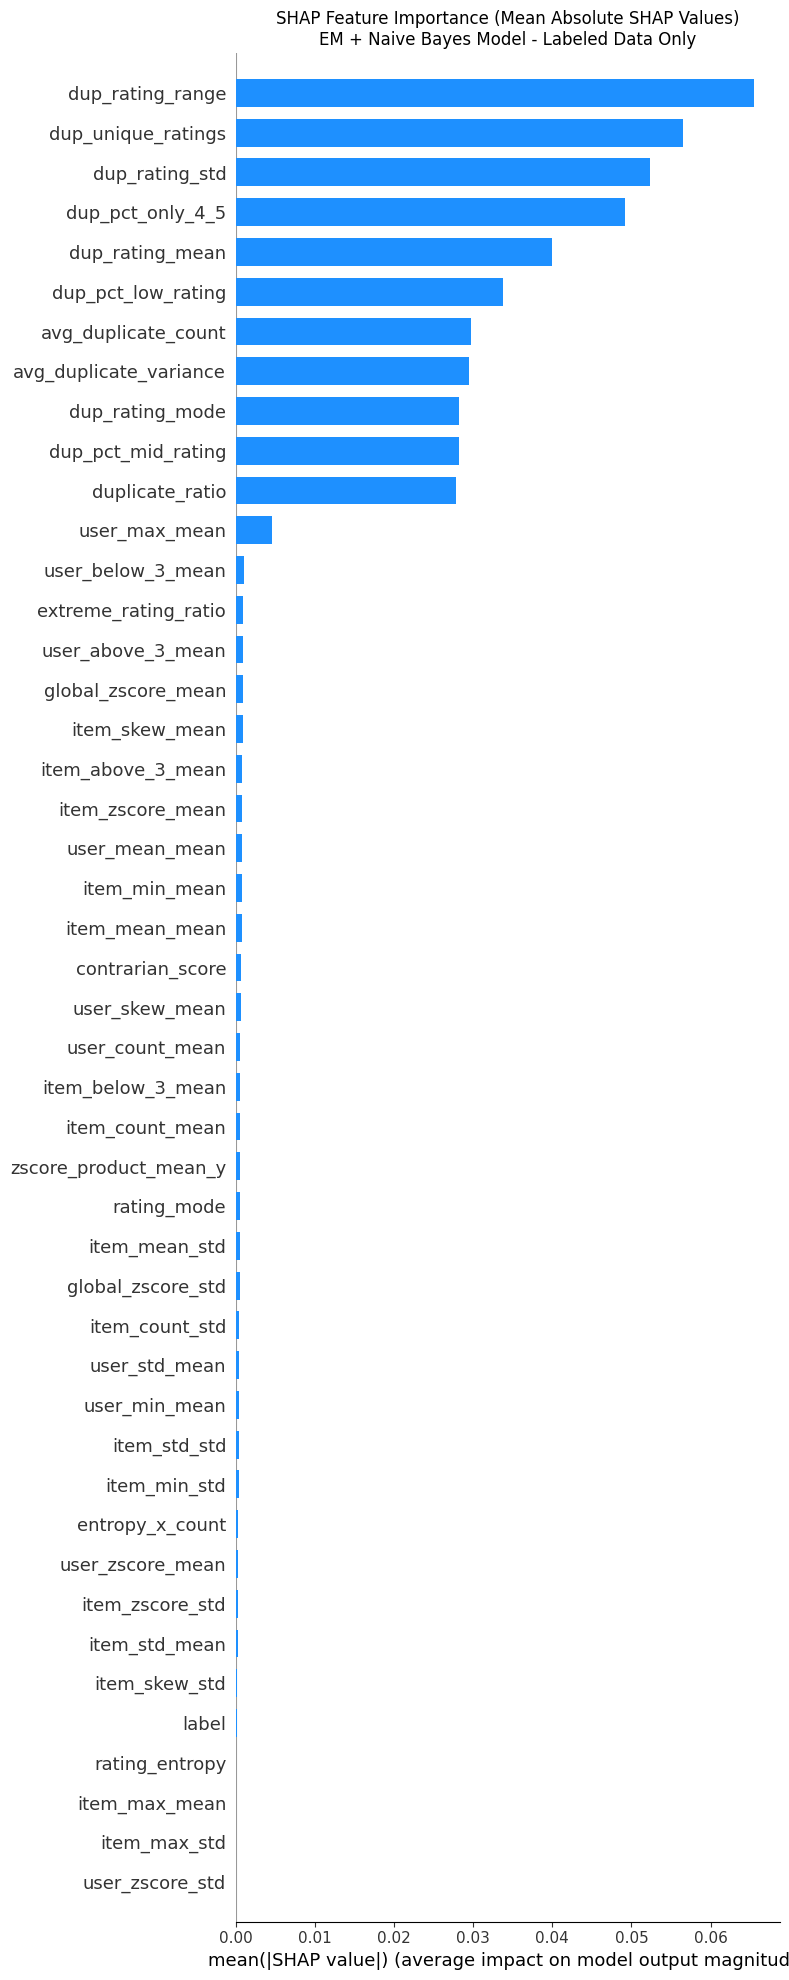

In [ ]:
# @title Expectation Maximization Naive Bayes Feature Importance using SHAP
# ============================================
# SHAP ANALYSIS FOR EM + NAIVE BAYES
# (Assumes best_params and data variables are defined)
# ============================================

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- SHAP Analysis for EM + Naive Bayes ---
print("\n" + "="*70)
print("SHAP ANALYSIS FOR EM + NAIVE BAYES")
print("(Uses final trained GaussianNB model)")
print("="*70)

# ============================================
# STEP 1: Data and Parameter Synchronization
# ============================================

# Variables X_labeled, y_labeled, X_unlabeled, and best_params are expected
X_semi_labeled = X_labeled.copy()
y_semi_labeled = y_labeled.copy()
X_semi_unlabeled = X_unlabeled.copy()

# Ensure best_params is a dictionary for reliable key access
if isinstance(best_params, pd.Series):
    best_params = best_params.to_dict()

# ============================================
# STEP 2: Train Final Model with Best Parameters (Replicating EM Loop)
# ============================================

print("\nTraining final EM model with best parameters...")

# 1. Combine all data for initial scaling fit
X_full = pd.concat([X_semi_labeled, X_semi_unlabeled], ignore_index=True)

# 2. Fit and transform the data
scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

X_labeled_scaled = X_full_scaled[:len(X_semi_labeled)]
X_unlabeled_scaled = X_full_scaled[len(X_semi_labeled):]
y_labeled_values = y_semi_labeled.values

# Initialize Naive Bayes model with best var_smoothing
nb_model = GaussianNB(var_smoothing=best_params['var_smoothing'])
nb_model.fit(X_labeled_scaled, y_labeled_values) # Initial fit on labeled data

prev_probs = None
actual_iters = 0

# EM loop replication
for iteration in range(best_params['max_iter']):
    actual_iters += 1

    # E-step: Get probability distributions for unlabeled
    probs_unlabeled = nb_model.predict_proba(X_unlabeled_scaled)

    # Check convergence
    if prev_probs is not None:
        change = np.abs(probs_unlabeled - prev_probs).mean()
        if change < best_params['convergence_tol']:
            break

    prev_probs = probs_unlabeled.copy()

    # M-step: Retrain with soft/weighted labels
    X_combined = np.vstack([X_labeled_scaled, X_unlabeled_scaled])
    y_unlabeled_pred = probs_unlabeled.argmax(axis=1)
    y_combined = np.hstack([y_labeled_values, y_unlabeled_pred])

    # Create sample weights based on best_params
    if best_params['use_weights']:
        weights_labeled = np.ones(len(X_semi_labeled))
        # Weight = confidence (max probability)
        weights_unlabeled = probs_unlabeled.max(axis=1)
        weights = np.hstack([weights_labeled, weights_unlabeled])
    else:
        # Equal weights for all
        weights = np.ones(len(X_combined))

    # Retrain Naive Bayes with weighted samples
    nb_model.fit(X_combined, y_combined, sample_weight=weights)

final_nb_model = nb_model
print(f"✓ Model trained (EM converged in {actual_iters} iterations).")

# ============================================
# STEP 3: Prepare Data for SHAP
# ============================================

# Use ONLY LABELED data for SHAP analysis and background
X_background = X_labeled_scaled
feature_names = X_semi_labeled.columns.tolist()

# ============================================
# STEP 4: Create SHAP explainer
# ============================================

print("\nCreating SHAP Explainer (Model-Agnostic KernelExplainer)...")

explainer = shap.KernelExplainer(final_nb_model.predict_proba, X_background)

# ============================================
# STEP 5: Calculate SHAP values for ALL LABELED data
# ============================================

print(f"\nCalculating SHAP values for ALL {len(X_labeled_scaled)} labeled samples...")

shap_values = explainer.shap_values(X_labeled_scaled, nsamples='auto')

print("✓ SHAP values calculated")

# ============================================
# STEP 6: Process SHAP values
# ============================================

# Average absolute SHAP values across all classes
if isinstance(shap_values, list):
    stacked = np.stack([np.abs(sv) for sv in shap_values], axis=-1)
    shap_vals_avg = np.mean(stacked, axis=-1)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_vals_avg = np.mean(np.abs(shap_values), axis=2)
else:
    shap_vals_avg = np.abs(shap_values)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = shap_vals_avg.mean(axis=0)

# ============================================
# STEP 7: Feature importance ranking
# ============================================

shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\n" + "="*70)
print("FEATURE IMPORTANCE (by mean absolute SHAP value)")
print("="*70)
print(shap_importance_df.to_string(index=False))

# ============================================
# STEP 8: Identify and Print Bottom 20 Features to Remove
# ============================================

bottom_n = 20
bottom_20_features = shap_importance_df.tail(bottom_n)['Feature'].tolist()

print(f"\n" + "="*70)
print(f"FEATURES TO REMOVE (BOTTOM {bottom_n} BY SHAP IMPORTANCE)")
print("="*70)
print("\nPython List Format for Removal:")
print(bottom_20_features)

# ============================================
# STEP 9: Visualizations
# ============================================

print("\n" + "="*70)
print("GENERATING SHAP VISUALIZATIONS")
print("="*70)

num_features = len(feature_names)
if num_features > 0:
    # 1. Summary plot (bar) - Feature importance
    plt.figure(figsize=(10, min(12, num_features * 0.3)))
    shap.summary_plot(shap_vals_avg, X_labeled_scaled, feature_names=feature_names,
                      plot_type="bar", show=False, max_display=num_features, color='dodgerblue')
    plt.title("SHAP Feature Importance (Mean Absolute SHAP Values)\nEM + Naive Bayes Model - Labeled Data Only")
    plt.tight_layout()
    plt.show()



print("="*70)


CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE
EM + NAIVE BAYES Model

Setup:
  Labeled samples: 60
  Unlabeled samples: 3540
  Total features: 46
  Classes: 3

Using best parameters from grid search (EM + NB):
  {'var_smoothing': 1e-07, 'max_iter': 50, 'use_weights': True, 'convergence_tol': 1e-05}
  Best CV Accuracy: 0.9167

CALCULATING FEATURE IMPORTANCE
Testing each feature across 5 CV folds...
This will take significant time...


FOLD 1/5
  Train: 48 samples | Val: 12 samples

  [Baseline] Training with all features...
  [Baseline] Accuracy: 0.9167

  Testing 46 features...
    Progress: 5/46 features tested
    Progress: 10/46 features tested
    Progress: 15/46 features tested
    Progress: 20/46 features tested
    Progress: 25/46 features tested
    Progress: 30/46 features tested
    Progress: 35/46 features tested
    Progress: 40/46 features tested
    Progress: 45/46 features tested
  ✓ Fold 1 complete

FOLD 2/5
  Train: 48 samples | Val: 12 samples

  [Baseline] Training

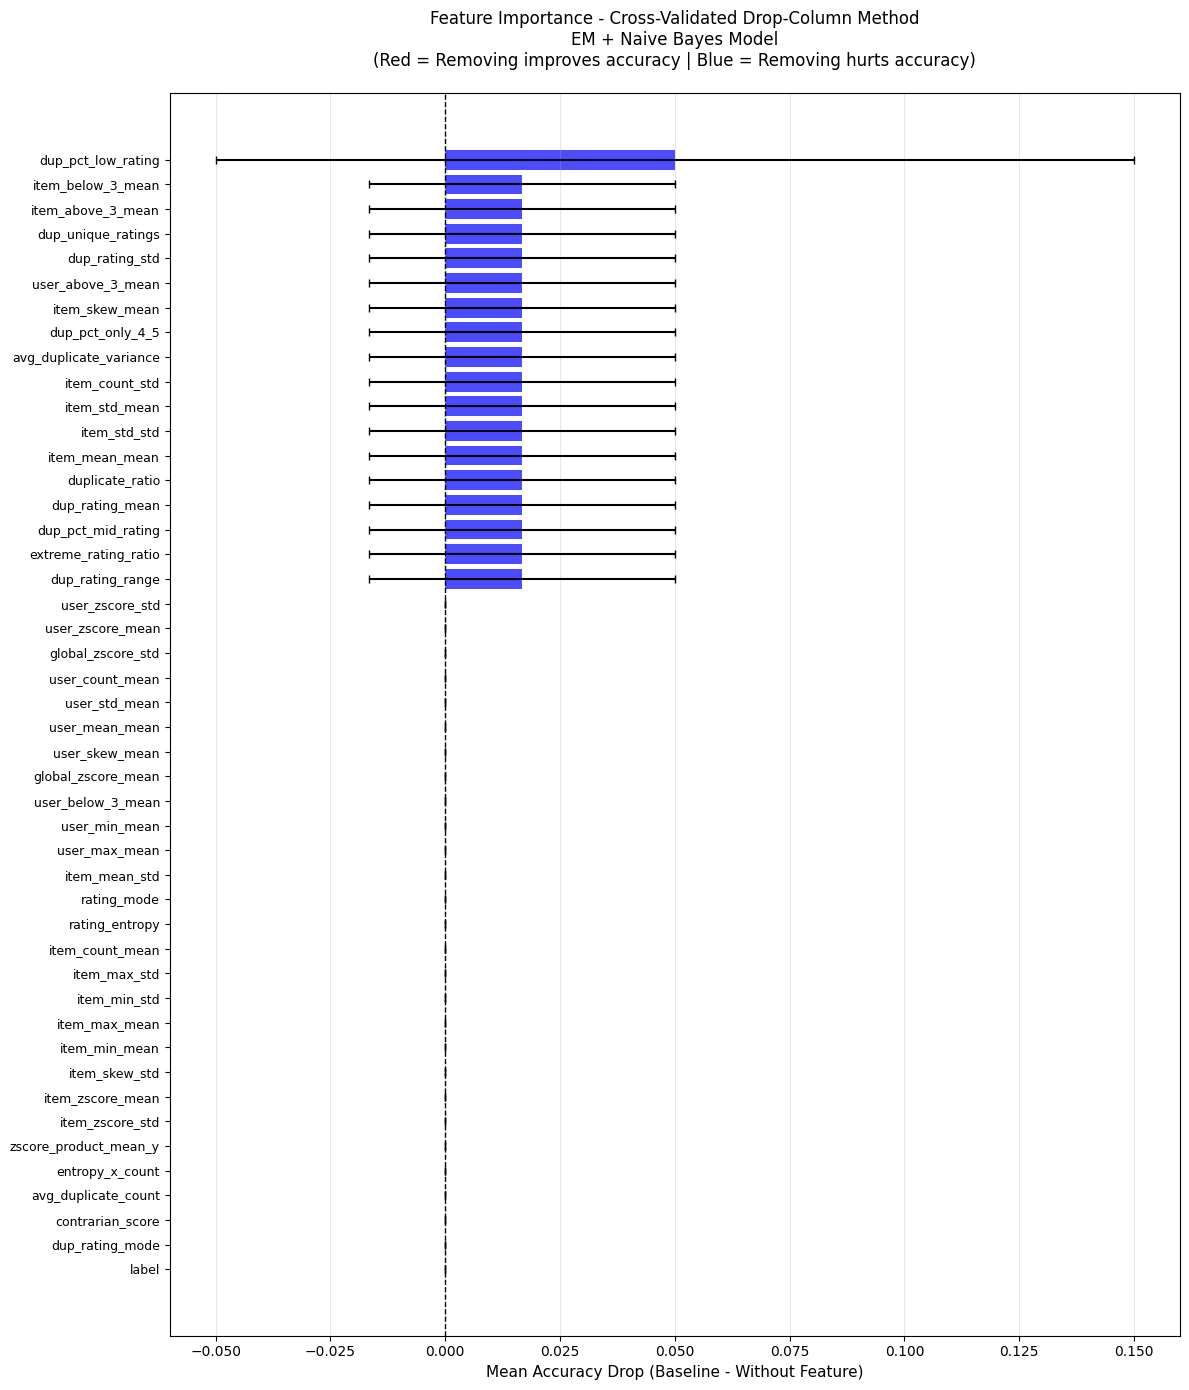

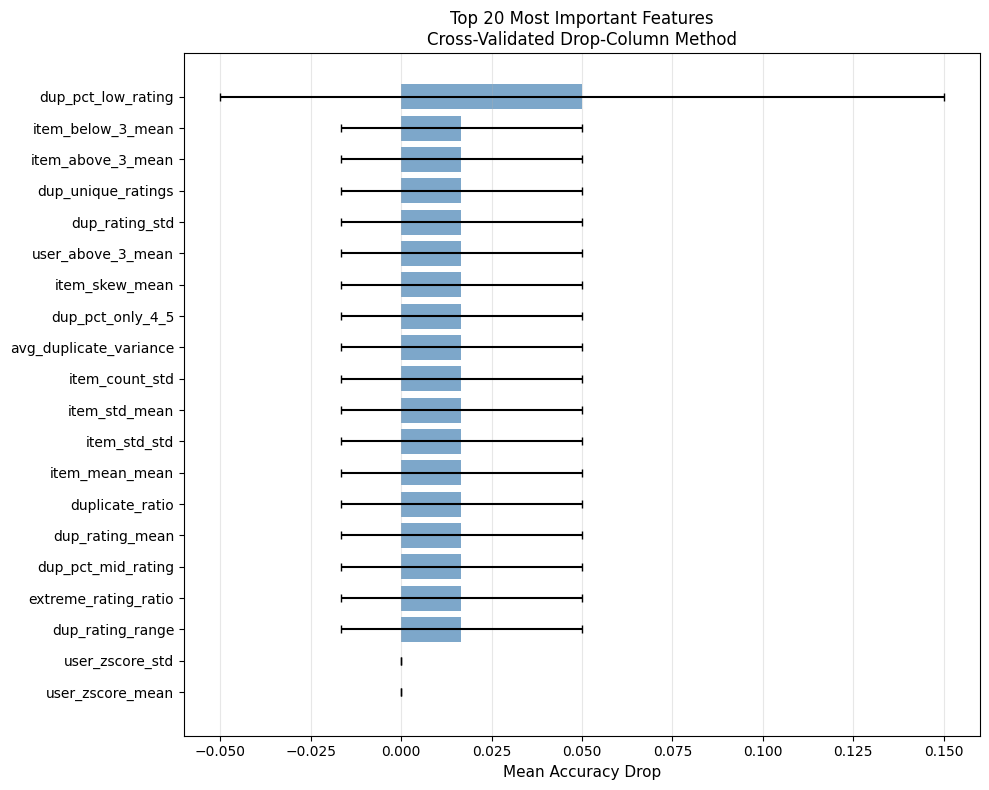

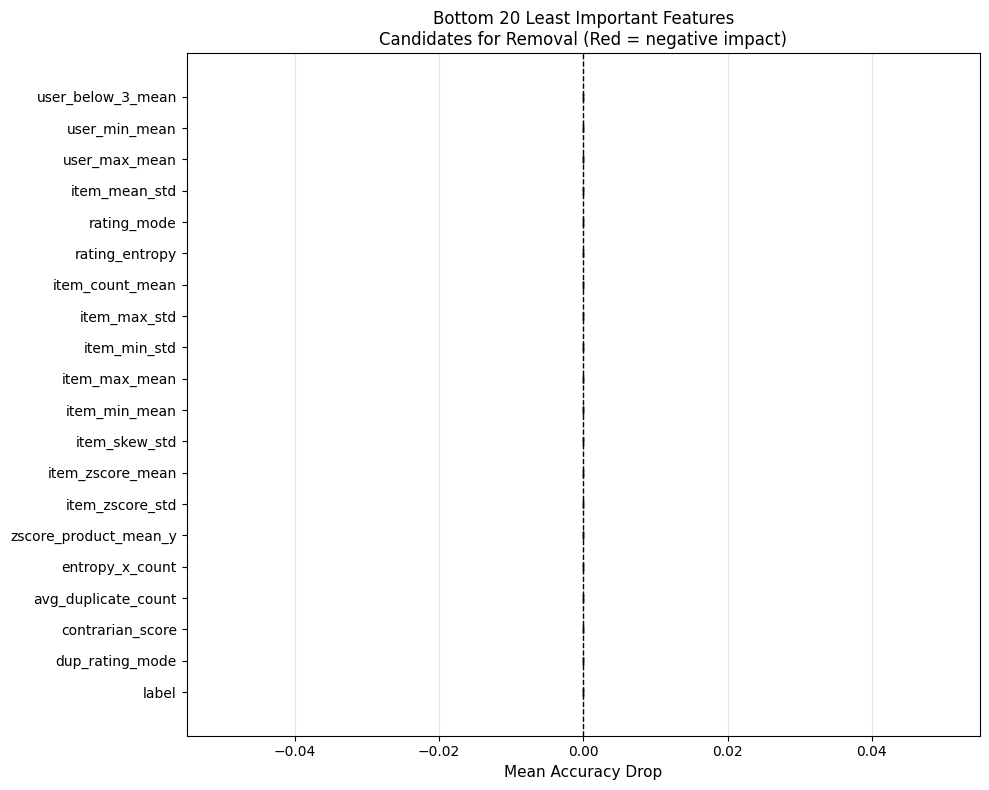

/tmp/ipython-input-114194797.py:306: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(top_20_data, labels=top_20_labels, vert=False)


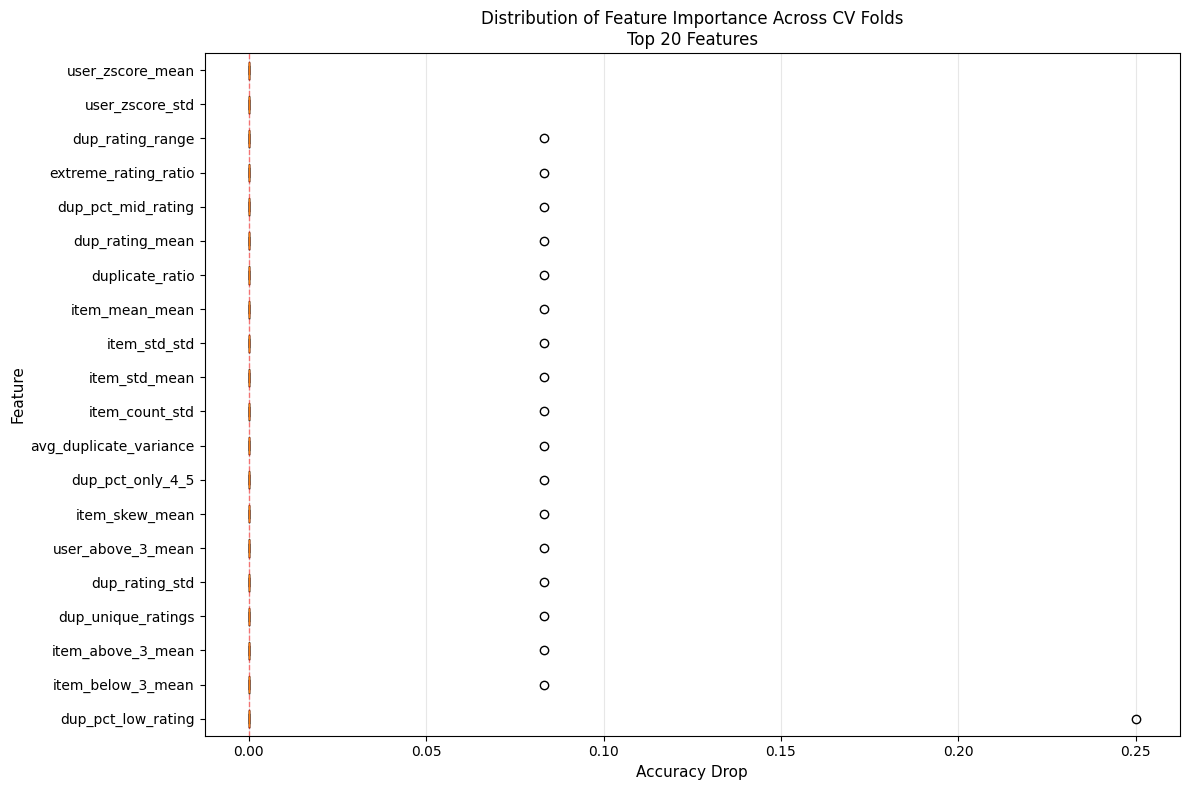


SUMMARY STATISTICS

Feature Importance Statistics:
  Mean importance: 0.007246
  Std importance: 0.010335
  Max importance: 0.050000
  Min importance: 0.000000

Feature Categories:
  High importance (> 0.01): 18
  Medium importance (0 to 0.01): 28
  Low/negative importance (< 0): 0

✓ CROSS-VALIDATED FEATURE IMPORTANCE COMPLETE

DataFrame 'cv_importance_df' contains full results with 46 features

FINAL LIST OF RECOMMENDED FEATURES FOR REMOVAL
Total Features to Remove: 28
Python List Format:
['item_max_mean', 'user_min_mean', 'rating_mode', 'user_skew_mean', 'label', 'item_skew_std', 'zscore_product_mean_y', 'user_below_3_mean', 'rating_entropy', 'user_max_mean', 'entropy_x_count', 'item_zscore_mean', 'contrarian_score', 'user_zscore_std', 'item_mean_std', 'user_count_mean', 'avg_duplicate_count', 'item_max_std', 'item_min_std', 'item_count_mean', 'global_zscore_mean', 'dup_rating_mode', 'item_min_mean', 'user_mean_mean', 'user_zscore_mean', 'item_zscore_std', 'user_std_mean', 'global_

In [ ]:
# @title Expectation Maximization Naive Bayes Feature Importance using CV leave-one-out
# ============================================
# CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE
# For EM + NAIVE BAYES Model (Full Script)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB # Import the base model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("\n" + "="*70)
print("CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE")
print("EM + NAIVE BAYES Model")
print("="*70)

# ============================================
# STEP 1: Setup & Data Synchronization
# ============================================

# Assuming X_labeled, y_labeled, X_unlabeled, and best_params are defined.
X_semi_labeled = X_labeled.copy()
y_semi_labeled = y_labeled.copy()
X_semi_unlabeled = X_unlabeled.copy()

# Ensure best_params is a dictionary for reliable key access
if isinstance(best_params, pd.Series):
    best_params = best_params.to_dict()

print("\nSetup:")
print(f"  Labeled samples: {len(X_semi_labeled)}")
print(f"  Unlabeled samples: {len(X_semi_unlabeled)}")
print(f"  Total features: {X_semi_labeled.shape[1]}")
print(f"  Classes: {len(y_semi_labeled.unique())}")

# Get feature names
feature_names = X_semi_labeled.columns.tolist()

# Extract best parameters for the EM loop
em_nb_params = {
    'var_smoothing': best_params['var_smoothing'],
    'max_iter': best_params['max_iter'],
    'use_weights': best_params['use_weights'],
    'convergence_tol': best_params['convergence_tol']
}

print(f"\nUsing best parameters from grid search (EM + NB):")
print(f"  {em_nb_params}")
print(f"  Best CV Accuracy: {best_params.get('mean_cv_accuracy', 'N/A'):.4f}")


# --- Nested EM Training Function ---
def train_em_nb(X_train_data, y_train_data, X_unlabeled_data, X_val_data, y_val_data):
    """Replicates the EM training loop for one fold/dropped-feature scenario."""
    nb = GaussianNB(var_smoothing=em_nb_params['var_smoothing'])
    nb.fit(X_train_data, y_train_data)

    prev_probs = None
    for _ in range(em_nb_params['max_iter']):
        # E-step
        probs_unlabeled = nb.predict_proba(X_unlabeled_data)

        # Check convergence
        if prev_probs is not None:
            change = np.abs(probs_unlabeled - prev_probs).mean()
            if change < em_nb_params['convergence_tol']:
                break
        prev_probs = probs_unlabeled.copy()

        # M-step
        X_combined = np.vstack([X_train_data, X_unlabeled_data])
        y_unlabeled_pred = probs_unlabeled.argmax(axis=1)
        y_combined = np.hstack([y_train_data.values, y_unlabeled_pred])

        if em_nb_params['use_weights']:
            weights_labeled = np.ones(len(X_train_data))
            weights_unlabeled = probs_unlabeled.max(axis=1)
            weights = np.hstack([weights_labeled, weights_unlabeled])
        else:
            weights = np.ones(len(X_combined))

        nb.fit(X_combined, y_combined, sample_weight=weights)

    # Predict and calculate accuracy on validation set
    y_pred = nb.predict(X_val_data)
    return accuracy_score(y_val_data, y_pred)
# --- End EM Training Function ---


# ============================================
# STEP 2: Cross-Validated Feature Importance
# ============================================

print("\n" + "="*70)
print("CALCULATING FEATURE IMPORTANCE")
print("="*70)
n_folds = 5
print(f"Testing each feature across {n_folds} CV folds...")
print("This will take significant time...\n")

# Setup CV
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store importance for each feature across folds
cv_feature_importances = {feat: [] for feat in feature_names}
baseline_accuracies = []

# Loop through CV folds
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_semi_labeled, y_semi_labeled)):
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx + 1}/{n_folds}")
    print(f"{'='*70}")

    # Split labeled data
    X_train = X_semi_labeled.iloc[train_idx]
    y_train = y_semi_labeled.iloc[train_idx]
    X_val = X_semi_labeled.iloc[val_idx]
    y_val = y_semi_labeled.iloc[val_idx]
    X_unlabeled = X_semi_unlabeled.copy()

    print(f"  Train: {len(X_train)} samples | Val: {len(X_val)} samples")

    # Prepare semi-supervised data for Scaler fit
    X_train_unlabeled = pd.concat([X_train, X_unlabeled], ignore_index=True)

    # Scale data (Fit on semi-supervised train set)
    scaler = StandardScaler()
    scaler.fit(X_train_unlabeled)
    X_train_scaled_full = scaler.transform(X_train)
    X_unlabeled_scaled_full = scaler.transform(X_unlabeled)
    X_val_scaled_full = scaler.transform(X_val)

    # Train baseline model (with ALL features)
    print("\n  [Baseline] Training with all features...")
    baseline_acc = train_em_nb(X_train_scaled_full, y_train, X_unlabeled_scaled_full, X_val_scaled_full, y_val)
    baseline_accuracies.append(baseline_acc)
    print(f"  [Baseline] Accuracy: {baseline_acc:.4f}")

    # Test each feature by dropping it
    print(f"\n  Testing {len(feature_names)} features...")
    for i, feature in enumerate(feature_names):
        # Drop this feature from all scaled datasets
        feature_mask = [j for j in range(len(feature_names)) if j != i]

        X_train_dropped = X_train_scaled_full[:, feature_mask]
        X_unlabeled_dropped = X_unlabeled_scaled_full[:, feature_mask]
        X_val_dropped = X_val_scaled_full[:, feature_mask]

        # Train model without this feature
        dropped_acc = train_em_nb(X_train_dropped, y_train, X_unlabeled_dropped, X_val_dropped, y_val)

        # Calculate importance (accuracy drop when feature is removed)
        importance = baseline_acc - dropped_acc
        cv_feature_importances[feature].append(importance)

        # Progress update every 5 features
        if (i + 1) % 5 == 0:
            print(f"    Progress: {i+1}/{len(feature_names)} features tested")

    print(f"  ✓ Fold {fold_idx + 1} complete")

# ============================================
# STEP 3: Aggregate Results
# ============================================

print("\n" + "="*70)
print("AGGREGATING RESULTS ACROSS FOLDS")
print("="*70)

# Calculate mean and std across folds
cv_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': [np.mean(cv_feature_importances[f]) for f in feature_names],
    'Importance_Std': [np.std(cv_feature_importances[f]) for f in feature_names],
    'Importance_Min': [np.min(cv_feature_importances[f]) for f in feature_names],
    'Importance_Max': [np.max(cv_feature_importances[f]) for f in feature_names]
}).sort_values('Importance_Mean', ascending=False)

# Add fold-by-fold importances as separate columns
for fold_idx in range(n_folds):
    cv_importance_df[f'Fold_{fold_idx+1}'] = [cv_feature_importances[f][fold_idx] for f in cv_importance_df['Feature']]

print(f"\nBaseline accuracies across folds:")
for fold_idx, acc in enumerate(baseline_accuracies):
    print(f"  Fold {fold_idx + 1}: {acc:.4f}")
print(f"  Mean: {np.mean(baseline_accuracies):.4f} (+/- {np.std(baseline_accuracies):.4f})")

# ============================================
# STEP 4: Display Results
# ============================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKING")
print("="*70)

print("\nTop 15 Most Important Features:")
print(cv_importance_df[['Feature', 'Importance_Mean', 'Importance_Std', 'Importance_Min', 'Importance_Max']].head(15).to_string(index=False))

print("\n" + "-"*70)

print("\nBottom 15 Least Important Features:")
print(cv_importance_df[['Feature', 'Importance_Mean', 'Importance_Std', 'Importance_Min', 'Importance_Max']].tail(15).to_string(index=False))

# ============================================
# STEP 5: Identify Features to Remove
# ============================================

print("\n" + "="*70)
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*70)

# Strategy 1: Features with negative mean importance
negative_importance = cv_importance_df[cv_importance_df['Importance_Mean'] < 0]
print(f"\nFeatures with NEGATIVE mean importance (removing them IMPROVES accuracy):")
print(f"Count: {len(negative_importance)}")
if len(negative_importance) > 0:
    print(negative_importance[['Feature', 'Importance_Mean', 'Importance_Std']].to_string(index=False))
else:
    print("  None found")

# Strategy 2: Features with near-zero importance (bottom 25%)
threshold_percentile = 25
if len(cv_importance_df) > 0:
    importance_threshold = np.percentile(cv_importance_df['Importance_Mean'], threshold_percentile)
else:
    importance_threshold = 0

low_importance = cv_importance_df[cv_importance_df['Importance_Mean'] <= importance_threshold]

print(f"\nFeatures with LOW importance (bottom {threshold_percentile}%):")
print(f"Threshold: {importance_threshold:.6f}")
print(f"Count: {len(low_importance)}")
print(low_importance[['Feature', 'Importance_Mean', 'Importance_Std']].to_string(index=False))

# ============================================
# STEP 6: Visualizations
# ============================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Feature importance with error bars
plt.figure(figsize=(12, 14))
y_pos = range(len(feature_names))
colors = ['red' if x < 0 else 'blue' for x in cv_importance_df['Importance_Mean'][::-1]]
plt.barh(y_pos, cv_importance_df['Importance_Mean'][::-1],
         xerr=cv_importance_df['Importance_Std'][::-1],
         color=colors, alpha=0.7, capsize=3)
plt.yticks(y_pos, cv_importance_df['Feature'][::-1], fontsize=9)
plt.xlabel('Mean Accuracy Drop (Baseline - Without Feature)', fontsize=11)
plt.title('Feature Importance - Cross-Validated Drop-Column Method\nEM + Naive Bayes Model\n(Red = Removing improves accuracy | Blue = Removing hurts accuracy)',
          fontsize=12, pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Top 20 features only (easier to read)
plt.figure(figsize=(10, 8))
top_20 = cv_importance_df.head(20)
y_pos_20 = range(len(top_20))
plt.barh(y_pos_20, top_20['Importance_Mean'][::-1],
         xerr=top_20['Importance_Std'][::-1],
         color='steelblue', alpha=0.7, capsize=3)
plt.yticks(y_pos_20, top_20['Feature'][::-1], fontsize=10)
plt.xlabel('Mean Accuracy Drop', fontsize=11)
plt.title('Top 20 Most Important Features\nCross-Validated Drop-Column Method', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Bottom 20 features (candidates for removal)
plt.figure(figsize=(10, 8))
bottom_20 = cv_importance_df.tail(20)
y_pos_bottom = range(len(bottom_20))
colors_bottom = ['red' if x < 0 else 'orange' for x in bottom_20['Importance_Mean'][::-1]]
plt.barh(y_pos_bottom, bottom_20['Importance_Mean'][::-1],
         xerr=bottom_20['Importance_Std'][::-1],
         color=colors_bottom, alpha=0.7, capsize=3)
plt.yticks(y_pos_bottom, bottom_20['Feature'][::-1], fontsize=10)
plt.xlabel('Mean Accuracy Drop', fontsize=11)
plt.title('Bottom 20 Least Important Features\nCandidates for Removal (Red = negative impact)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Distribution of importance across folds (box plot for top 20)
plt.figure(figsize=(12, 8))
top_20_data = []
top_20_labels = []
for feature in cv_importance_df.head(20)['Feature']:
    top_20_data.append(cv_feature_importances[feature])
    top_20_labels.append(feature)

plt.boxplot(top_20_data, labels=top_20_labels, vert=False)
plt.xlabel('Accuracy Drop', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Distribution of Feature Importance Across CV Folds\nTop 20 Features', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# STEP 7: Summary Statistics
# ============================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print(f"\nFeature Importance Statistics:")
print(f"  Mean importance: {cv_importance_df['Importance_Mean'].mean():.6f}")
print(f"  Std importance: {cv_importance_df['Importance_Mean'].std():.6f}")
print(f"  Max importance: {cv_importance_df['Importance_Mean'].max():.6f}")
print(f"  Min importance: {cv_importance_df['Importance_Mean'].min():.6f}")

print(f"\nFeature Categories:")
print(f"  High importance (> 0.01): {len(cv_importance_df[cv_importance_df['Importance_Mean'] > 0.01])}")
print(f"  Medium importance (0 to 0.01): {len(cv_importance_df[(cv_importance_df['Importance_Mean'] >= 0) & (cv_importance_df['Importance_Mean'] <= 0.01)])}")
print(f"  Low/negative importance (< 0): {len(cv_importance_df[cv_importance_df['Importance_Mean'] < 0])}")

print("\n" + "="*70)
print("✓ CROSS-VALIDATED FEATURE IMPORTANCE COMPLETE")
print("="*70)

print(f"\nDataFrame 'cv_importance_df' contains full results with {len(cv_importance_df)} features")
print("="*70)


# --- Feature Removal Strategy: Combine Negative and Near-Zero Mean Importance ---

# Features with NEGATIVE Mean Importance (removing them IMPROVES accuracy)
negative_importance_list = cv_importance_df[
    cv_importance_df['Importance_Mean'] < 0
]['Feature'].tolist()

# Use the calculated 25th percentile threshold
low_importance_threshold = importance_threshold

near_zero_importance_list = cv_importance_df[
    (cv_importance_df['Importance_Mean'] >= 0) &
    (cv_importance_df['Importance_Mean'] <= low_importance_threshold)
]['Feature'].tolist()

# Combine and Dedup the final list
features_to_remove = list(set(negative_importance_list + near_zero_importance_list))

print("\n" + "="*70)
print("FINAL LIST OF RECOMMENDED FEATURES FOR REMOVAL")
print("="*70)
print(f"Total Features to Remove: {len(features_to_remove)}")
print("Python List Format:")
print(features_to_remove)
print("="*70)

In [ ]:
# @title retraining on X users and predicting for XX users + combining with Part 1 for final predictions
# ============================================
# PART 2: ANOMTYPE PREDICTION (EM + NAIVE BAYES)
# ============================================

print("\n" + "="*70)
print("PART 2: ANOMTYPE PREDICTION (EM + NAIVE BAYES)")
print("="*70)
print("Training on ALL data and predicting on XX_transformed")
print("="*70)

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import numpy as np

# ============================================
# STEP 1: MANUALLY SET BEST PARAMETERS
# ============================================

print(f"\n{'='*70}")
print(f"SETTING HYPERPARAMETERS (MANUAL)")
print(f"{'='*70}")

# --- MANUALLY SET YOUR BEST PARAMETERS HERE ---
best_var_smoothing = 1e-7          # Smoothing parameter
best_max_iter = 50                 # EM iterations
best_use_weights = False           # Weight samples by confidence
best_convergence_tol = 1e-1        # Convergence threshold
best_confidence_threshold = 0.99    # Minimum confidence to use unlabeled sample

print(f"\nManually selected parameters:")
print(f"  var_smoothing: {best_var_smoothing:.2e}")
print(f"  max_iter: {best_max_iter}")
print(f"  use_weights: {best_use_weights}")
print(f"  convergence_tol: {best_convergence_tol}")
print(f"  confidence_threshold: {best_confidence_threshold}")

# ============================================
# STEP 2: Prepare training data (NO label feature)
# ============================================

print(f"\n{'='*70}")
print(f"PREPARING TRAINING DATA (WITHOUT LABEL FEATURE)")
print(f"{'='*70}")

# Labeled data
X_train_labeled = X_semi_labeled.copy()
y_train_labeled = y_semi_labeled.copy()

# Unlabeled data
X_train_unlabeled = X_semi_unlabeled.copy()

print(f"\nTraining data summary:")
print(f"  Labeled samples: {len(X_train_labeled)}")
print(f"  Unlabeled samples: {len(X_train_unlabeled)}")
print(f"  Features: {X_train_labeled.shape[1]}")

# ============================================
# STEP 3: Prepare test data (NO label feature)
# ============================================

print(f"\n{'='*70}")
print(f"PREPARING TEST DATA (WITHOUT LABEL FEATURE)")
print(f"{'='*70}")

# Use XX_transformed directly (should NOT contain 'label' column)
XX_transformed_final = XX_transformed.copy()

print(f"\nTest data summary:")
print(f"  Test samples: {len(XX_transformed_final)}")
print(f"  Features: {XX_transformed_final.shape[1]}")
print(f"  User IDs: {len(XX_user_ids)}")

# Verify feature alignment
print(f"\nFeature alignment check:")
train_features = set(X_train_labeled.columns)
test_features = set(XX_transformed_final.columns)

if train_features == test_features:
    print(f"  ✓ Training and test have SAME features ({len(train_features)} features)")
else:
    missing_in_test = train_features - test_features
    extra_in_test = test_features - train_features
    if missing_in_test:
        print(f"  ⚠️ Missing in test: {missing_in_test}")
    if extra_in_test:
        print(f"  ⚠️ Extra in test: {extra_in_test}")

# ============================================
# STEP 4: Scale ALL data
# ============================================

print(f"\n{'='*70}")
print(f"SCALING DATA")
print(f"{'='*70}")

# Combine labeled and unlabeled for fitting scaler
X_train_combined = pd.concat([X_train_labeled, X_train_unlabeled], ignore_index=True)

# Fit scaler on ALL training data (labeled + unlabeled)
scaler_final = StandardScaler()
scaler_final.fit(X_train_combined)

# Transform all datasets
X_train_labeled_scaled = scaler_final.transform(X_train_labeled)
X_train_unlabeled_scaled = scaler_final.transform(X_train_unlabeled)
XX_transformed_scaled = scaler_final.transform(XX_transformed_final)

print(f"✓ Scaling complete")
print(f"  Labeled data scaled: {X_train_labeled_scaled.shape}")
print(f"  Unlabeled data scaled: {X_train_unlabeled_scaled.shape}")
print(f"  Test data scaled: {XX_transformed_scaled.shape}")

# ============================================
# STEP 5: Train EM + Naive Bayes model
# ============================================

print(f"\n{'='*70}")
print(f"TRAINING EM + NAIVE BAYES MODEL")
print(f"{'='*70}")

print(f"\nModel parameters:")
print(f"  var_smoothing: {best_var_smoothing:.2e}")
print(f"  max_iter: {best_max_iter}")
print(f"  use_weights: {best_use_weights}")
print(f"  convergence_tol: {best_convergence_tol}")
print(f"  confidence_threshold: {best_confidence_threshold}")

# Initialize Naive Bayes with best parameters
nb_model = GaussianNB(var_smoothing=best_var_smoothing)

# Initial training on labeled data only
print(f"\nInitial training on {len(X_train_labeled_scaled)} labeled samples...")
nb_model.fit(X_train_labeled_scaled, y_train_labeled)
print(f"✓ Initial model trained")

# EM Algorithm
print(f"\nStarting EM iterations (max_iter={best_max_iter})...")
prev_probs = None
actual_iters = 0

for iteration in range(best_max_iter):
    actual_iters += 1

    # E-step: Get probability distributions for unlabeled data
    probs_unlabeled = nb_model.predict_proba(X_train_unlabeled_scaled)

    # Check convergence
    if prev_probs is not None:
        change = np.abs(probs_unlabeled - prev_probs).mean()
        if change < best_convergence_tol:
            print(f"  Converged at iteration {actual_iters} (change={change:.6f} < {best_convergence_tol})")
            break
    prev_probs = probs_unlabeled.copy()

    # M-step: Retrain with high-confidence unlabeled samples

    # 1. Identify high-confidence samples
    max_probs = probs_unlabeled.max(axis=1)
    high_conf_mask = max_probs >= best_confidence_threshold

    # Filter unlabeled data to include only high-confidence samples
    X_unlabeled_conf = X_train_unlabeled_scaled[high_conf_mask]
    probs_unlabeled_conf = probs_unlabeled[high_conf_mask]

    n_unlabeled_conf = len(X_unlabeled_conf)

    if iteration % 10 == 0 or iteration == best_max_iter - 1:
        print(f"  Iteration {actual_iters}: {n_unlabeled_conf}/{len(X_train_unlabeled_scaled)} "
              f"high-conf samples (threshold={best_confidence_threshold}), change={change if prev_probs is not None and iteration > 0 else 'N/A'}")

    if n_unlabeled_conf == 0:
        # No samples meet threshold, continue with existing model
        continue

    # 2. Combine labeled and high-confidence unlabeled data
    X_combined = np.vstack([X_train_labeled_scaled, X_unlabeled_conf])

    # Get hard labels for high-confidence unlabeled
    y_unlabeled_pred = probs_unlabeled_conf.argmax(axis=1)
    y_combined = np.hstack([y_train_labeled.values, y_unlabeled_pred])

    # 3. Create sample weights
    if best_use_weights:
        # Labeled data: weight = 1.0
        weights_labeled = np.ones(len(X_train_labeled_scaled))
        # High-confidence unlabeled data: weight = confidence (max probability)
        weights_unlabeled = max_probs[high_conf_mask]
        weights = np.hstack([weights_labeled, weights_unlabeled])
    else:
        # Equal weights for all
        weights = np.ones(len(X_combined))

    # 4. Retrain Naive Bayes with weighted samples
    nb_model.fit(X_combined, y_combined, sample_weight=weights)

print(f"\n✓ EM training completed!")
print(f"  Total EM iterations: {actual_iters}")

# ============================================
# STEP 6: Make predictions on XX_transformed
# ============================================

print(f"\n{'='*70}")
print(f"MAKING PREDICTIONS ON XX_transformed")
print(f"{'='*70}")

# Predict anomtype for test data
anomtype_predictions = nb_model.predict(XX_transformed_scaled)

# Get prediction probabilities for confidence
anomtype_probs = nb_model.predict_proba(XX_transformed_scaled)
anomtype_confidence = anomtype_probs.max(axis=1)

print(f"✓ Predictions completed!")
print(f"  Total predictions: {len(anomtype_predictions)}")

# Show anomtype distribution
print(f"\nAnomtype distribution:")
anomtype_dist = pd.Series(anomtype_predictions).value_counts().sort_index()
for anomtype, count in anomtype_dist.items():
    percentage = (count / len(anomtype_predictions)) * 100
    print(f"  Class {anomtype}: {count} samples ({percentage:.2f}%)")

# Show confidence statistics
print(f"\nPrediction confidence statistics:")
print(f"  Mean confidence: {anomtype_confidence.mean():.4f}")
print(f"  Min confidence: {anomtype_confidence.min():.4f}")
print(f"  Max confidence: {anomtype_confidence.max():.4f}")

# ============================================
# STEP 7: Combine with Part 1 predictions
# ============================================

print(f"\n{'='*70}")
print(f"COMBINING WITH PART 1 PREDICTIONS")
print(f"{'='*70}")

# Verify predictions_df exists and has correct structure
print(f"Checking predictions_df from Part 1...")
print(f"  predictions_df shape: {predictions_df.shape}")
print(f"  predictions_df columns: {list(predictions_df.columns)}")

# Verify alignment
assert len(predictions_df) == len(XX_transformed_final), \
    f"Mismatch! predictions_df: {len(predictions_df)}, XX_transformed: {len(XX_transformed_final)}"
assert all(predictions_df['user'] == XX_user_ids), "User IDs don't match!"

print(f"  ✓ Alignment verified")

# Add Part 2 predictions to predictions_df
predictions_df['anomtype'] = anomtype_predictions

print(f"\n✓ Predictions combined successfully")
print(f"  Final columns: {list(predictions_df.columns)}")

# ============================================
# STEP 8: Final DataFrame Summary
# ============================================

print(f"\n{'='*70}")
print(f"FINAL PREDICTIONS SUMMARY")
print(f"{'='*70}")

print(f"\nFinal DataFrame structure:")
print(f"  Total rows: {len(predictions_df)}")
print(f"  Columns: {list(predictions_df.columns)}")

print(f"\nFirst 10 predictions:")
print(predictions_df.head(10))

print(f"\nLast 10 predictions:")
print(predictions_df.tail(10))

print(f"\n--- Part 1 (Label - Neural Network Regression) ---")
print(predictions_df['label'].describe())

print(f"\n--- Part 2 (Anomtype - EM + Naive Bayes Classification) ---")
print(f"Distribution:")
print(predictions_df['anomtype'].value_counts().sort_index())

# ============================================
# STEP 9: Save to CSV
# ============================================

print(f"\n{'='*70}")
print(f"SAVING FINAL PREDICTIONS")
print(f"{'='*70}")

# Output has all three columns
output_df = predictions_df[['user', 'label', 'anomtype']].copy()
output_filename = 'final_predictions.csv'

# Save to CSV
output_df.to_csv(output_filename, index=False)

print(f"✓ Predictions saved to: {output_filename}")
print(f"  Rows saved: {len(output_df)}")
print(f"  Columns saved: {list(output_df.columns)}")

# ============================================
# STEP 10: Verify saved file
# ============================================

print(f"\n{'='*70}")
print(f"VERIFYING SAVED FILE")
print(f"{'='*70}")

verification_df = pd.read_csv(output_filename)
print(f"✓ File loaded successfully")
print(f"  Shape: {verification_df.shape}")

print(f"\nFirst 5 rows of saved file:")
print(verification_df.head())

print(f"\nLast 5 rows of saved file:")
print(verification_df.tail())

print(f"\nData types:")
print(verification_df.dtypes)

# Check for any missing values
missing_check = verification_df.isnull().sum()
if missing_check.sum() == 0:
    print(f"\n✓ No missing values in saved file")
else:
    print(f"\n⚠ Missing values found:")
    print(missing_check[missing_check > 0])

# ============================================
# FINAL SUCCESS MESSAGE
# ============================================

print(f"\n{'='*70}")
print(f"✓✓✓ FINAL PREDICTIONS COMPLETE ✓✓✓")
print(f"{'='*70}")
print(f"File: {output_filename}")
print(f"Total predictions: {len(verification_df)}")
print(f"Columns: {list(verification_df.columns)}")
print(f"\nData Flow:")
print(f"  1. Part 1: Neural Network → predicts 'label' (0-1 range)")
print(f"  2. Part 2: EM + Naive Bayes → predicts 'anomtype' (WITHOUT using 'label' as feature)")
print(f"  3. Final output: user, label, anomtype")
print(f"\nModel Parameters:")
print(f"  var_smoothing: {best_var_smoothing:.2e}")
print(f"  max_iter: {best_max_iter}")
print(f"  use_weights: {best_use_weights}")
print(f"  convergence_tol: {best_convergence_tol}")
print(f"  confidence_threshold: {best_confidence_threshold}")
print(f"  Actual EM iterations: {actual_iters}")
print(f"{'='*70}")


PART 2: ANOMTYPE PREDICTION (EM + NAIVE BAYES)
Training on ALL data and predicting on XX_transformed

SETTING HYPERPARAMETERS (MANUAL)

Manually selected parameters:
  var_smoothing: 1.00e-07
  max_iter: 50
  use_weights: False
  convergence_tol: 0.1
  confidence_threshold: 0.99

PREPARING TRAINING DATA (WITHOUT LABEL FEATURE)

Training data summary:
  Labeled samples: 60
  Unlabeled samples: 3540
  Features: 18

PREPARING TEST DATA (WITHOUT LABEL FEATURE)

Test data summary:
  Test samples: 900
  Features: 18
  User IDs: 900

Feature alignment check:
  ✓ Training and test have SAME features (18 features)

SCALING DATA
✓ Scaling complete
  Labeled data scaled: (60, 18)
  Unlabeled data scaled: (3540, 18)
  Test data scaled: (900, 18)

TRAINING EM + NAIVE BAYES MODEL

Model parameters:
  var_smoothing: 1.00e-07
  max_iter: 50
  use_weights: False
  convergence_tol: 0.1
  confidence_threshold: 0.99

Initial training on 60 labeled samples...
✓ Initial model trained

Starting EM iteration

# Predicted Data Analysis (Unseen Batch - Users 3600-4499)

In [ ]:
# @title Load Predictions as Labels

import numpy as np
import pandas as pd
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import requests, io

def load_csv_from_github(filename):
    base_url = "https://raw.githubusercontent.com/matthew-ngzc/cs421-project/main/"
    url = base_url + filename
    response = requests.get(url)
    response.raise_for_status()  # ensures you catch 404 errors
    return pd.read_csv(io.BytesIO(response.content))

# Load predictions - treat these as our labels for analysis
data = load_csv_from_github("week12_final_predictions.csv")
y_pred = pd.DataFrame(data, columns=["user", "label", "anomtype"])
y_pred = y_pred.astype({'user': int, 'label': float, 'anomtype': int})

print(f"Total predicted users: {len(y_pred)}")
print(f"User range: {y_pred['user'].min()} - {y_pred['user'].max()}")
print(f"\nAnomaly type distribution:")
display(y_pred['anomtype'].value_counts().sort_index())

Total predicted users: 900
User range: 3600 - 4499

Anomaly type distribution:


anomtype
0    361
1    271
2    268
Name: count, dtype: int64

In [ ]:
# @title Extract Ratings for Predicted Users
# Filter X4 to only include the predicted users
X_pred = XX[XX['user'].isin(y_pred['user'])].copy()

print(f"Total ratings for predicted users: {len(X_pred)}")
print(f"Number of unique users: {X_pred['user'].nunique()}")

Total ratings for predicted users: 284954
Number of unique users: 900



Analysis for Predicted Labels (Fourth Batch)

Data shape: 900 users

Feature summary (first 20 rows):



Feature Means by Anomaly Type:


n_ratings    mean     std    skew  n_unique_items  dup_rate  label_y
anomtype                                                                      
0          313.0499  2.9839  1.0852 -0.3302        313.0499    0.0000   0.4481
1          313.7269  3.3344  0.9653 -0.4495        288.6716    0.0713   0.5356
2          324.3396  3.9509  0.9015 -0.7802        264.3769    0.1708   0.5497


Rating Distribution by Anomaly Type:


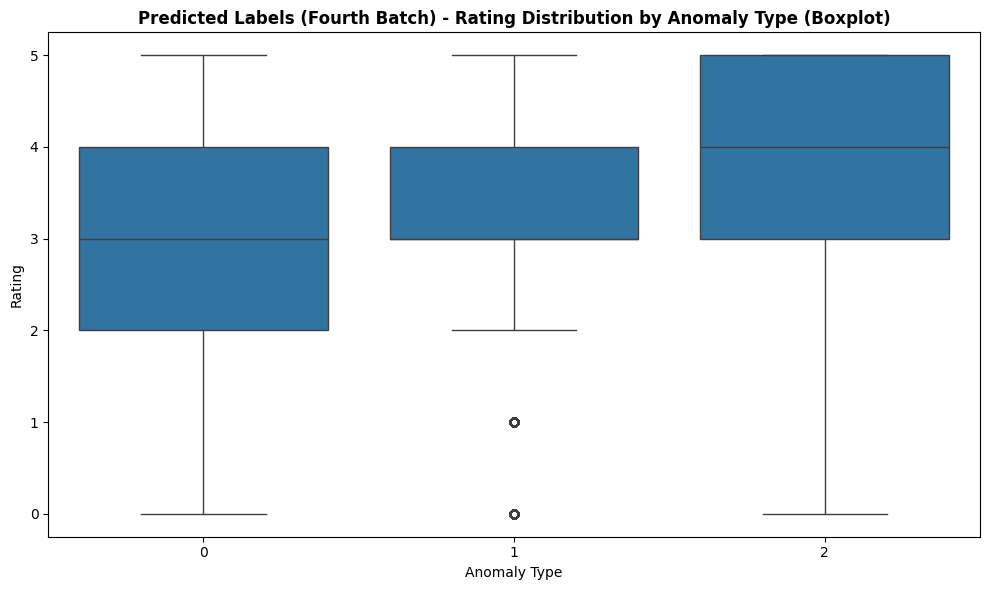

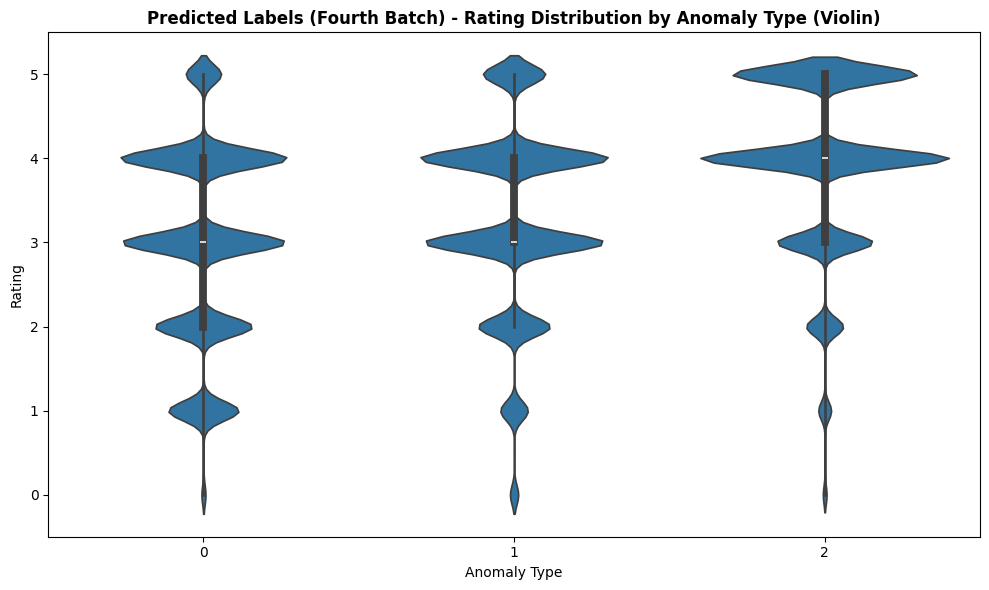

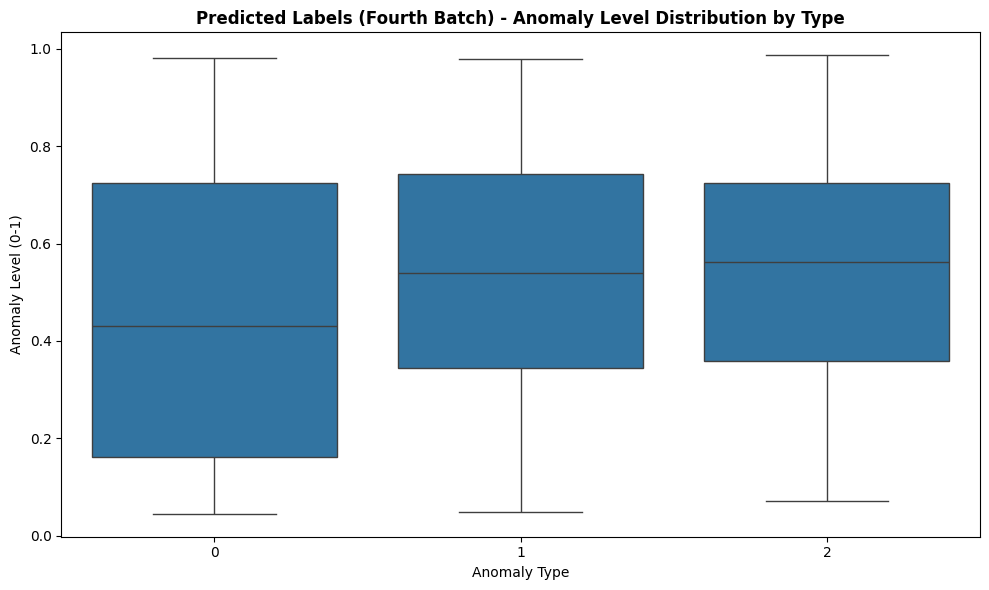

In [ ]:
# @title Predicted Data Analysis
# Use the same analysis function on the predicted data
merged_pred, X_pred_with_type = analyze_batch(X_pred, y_pred[['user', 'label']], y_pred, "Predicted Labels (Fourth Batch)")

## Duplicate Analysis for Predicted Data

In [ ]:
# @title Extract Duplicate Ratings from Predicted Users
# Find duplicates in predicted data: same user rating same item multiple times
X_pred_with_type['is_duplicate'] = X_pred_with_type.duplicated(subset=['user', 'item'], keep=False)

# Extract only the duplicate ratings
duplicates_pred = X_pred_with_type[X_pred_with_type['is_duplicate']].copy()

print(f"Total ratings (predicted users): {len(X_pred_with_type)}")
print(f"Duplicate ratings: {len(duplicates_pred)} ({len(duplicates_pred)/len(X_pred_with_type)*100:.2f}%)")
print(f"\nDuplicate ratings by predicted anomaly type:")
display(duplicates_pred.groupby('anomtype').size().to_frame('count'))

print(f"\nSample of duplicate ratings:")
display(duplicates_pred.sort_values(['user', 'item']).head(10))

Total ratings (predicted users): 284954
Duplicate ratings: 39692 (13.93%)

Duplicate ratings by predicted anomaly type:


count
anomtype       
1         12595
2         27097


Sample of duplicate ratings:


user  item  rating  anomtype  is_duplicate
64   3600     7       4         2          True
144  3600     7       5         2          True
110  3600    16       4         2          True
223  3600    16       5         2          True
56   3600    20       4         2          True
124  3600    20       4         2          True
366  3600    20       5         2          True
49   3600    95       5         2          True
193  3600    95       5         2          True
388  3600    95       4         2          True

In [ ]:
# @title Rating Distribution of Duplicates by Predicted Anomaly Type
# Compare duplicate rating distributions across predicted anomaly types
print("Mean rating of duplicates by predicted anomaly type:")
dup_mean_pred = duplicates_pred.groupby('anomtype')['rating'].mean()
display(dup_mean_pred.to_frame('mean_duplicate_rating').round(4))

print("\nRating value counts for duplicates by predicted anomaly type:")
for anom_type in sorted(duplicates_pred['anomtype'].unique()):
    print(f"\nPredicted Anomaly Type {anom_type}:")
    type_dups = duplicates_pred[duplicates_pred['anomtype'] == anom_type]
    rating_counts = type_dups['rating'].value_counts().sort_index()
    rating_pct = (rating_counts / len(type_dups) * 100).round(2)
    result = pd.DataFrame({'count': rating_counts, 'percentage': rating_pct})
    display(result)

Mean rating of duplicates by predicted anomaly type:


mean_duplicate_rating
anomtype                       
1                        3.1994
2                        4.4995


Rating value counts for duplicates by predicted anomaly type:

Predicted Anomaly Type 1:


count  percentage
rating                   
0         236        1.87
1         746        5.92
2        1924       15.28
3        4333       34.40
4        4077       32.37
5        1279       10.15


Predicted Anomaly Type 2:


count  percentage
rating                   
4       13563       50.05
5       13534       49.95

/tmp/ipython-input-1009686658.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=duplicates_pred, x='anomtype', y='rating', ax=axes[1], palette=['#3498db', '#e67e22', '#2ecc71'])
/tmp/ipython-input-1009686658.py:39: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=duplicates_pred, x='anomtype', y='rating', ax=axes[1], palette=['#3498db', '#e67e22', '#2ecc71'])


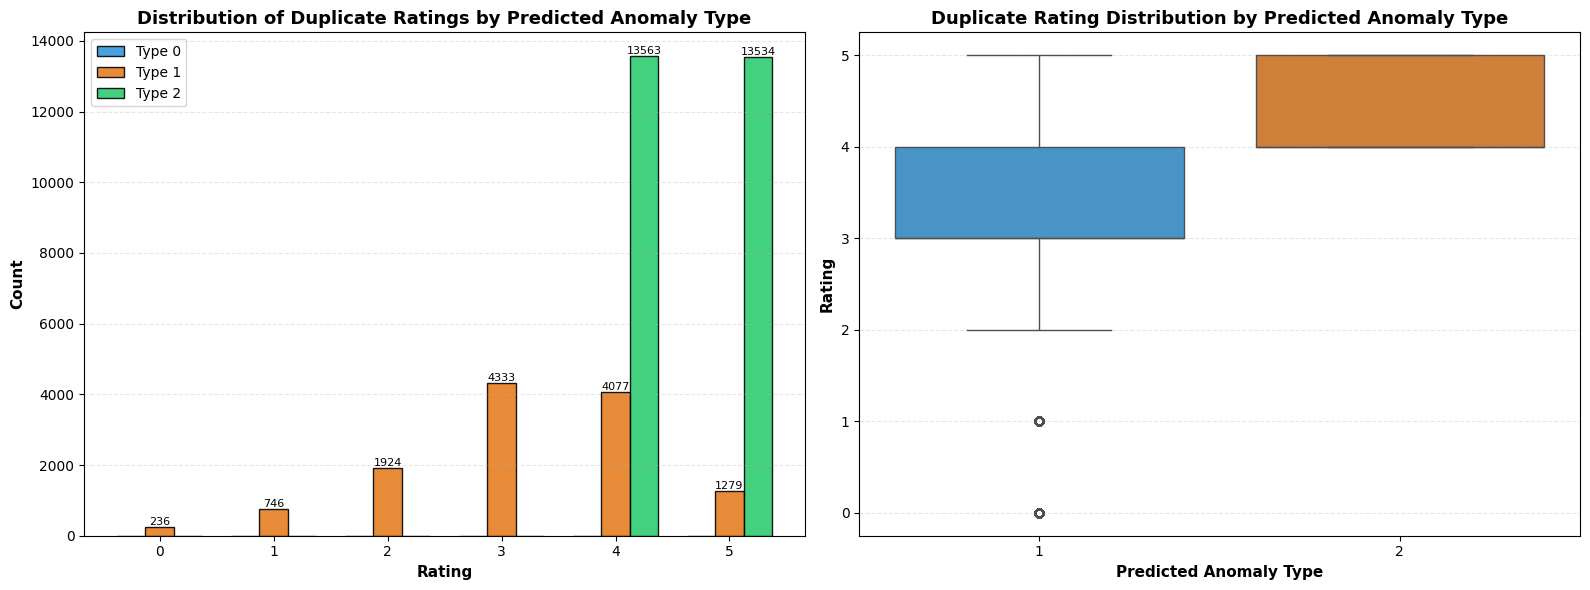

In [ ]:
# @title Visualize Duplicate Rating Distributions (Predicted Data)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Improved grouped bar chart instead of overlapping histograms for better readability
rating_bins = [0, 1, 2, 3, 4, 5, 6]
rating_labels = ['0', '1', '2', '3', '4', '5']

# Prepare data for each anomaly type
type_0_counts, _ = np.histogram(duplicates_pred[duplicates_pred['anomtype'] == 0]['rating'], bins=rating_bins)
type_1_counts, _ = np.histogram(duplicates_pred[duplicates_pred['anomtype'] == 1]['rating'], bins=rating_bins)
type_2_counts, _ = np.histogram(duplicates_pred[duplicates_pred['anomtype'] == 2]['rating'], bins=rating_bins)

# Set up grouped bar chart
x = np.arange(len(rating_labels))
width = 0.25

axes[0].bar(x - width, type_0_counts, width, label='Type 0', alpha=0.9, edgecolor='black', color='#3498db')
axes[0].bar(x, type_1_counts, width, label='Type 1', alpha=0.9, edgecolor='black', color='#e67e22')
axes[0].bar(x + width, type_2_counts, width, label='Type 2', alpha=0.9, edgecolor='black', color='#2ecc71')

axes[0].set_title('Distribution of Duplicate Ratings by Predicted Anomaly Type', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Rating', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(rating_labels)
axes[0].legend(fontsize=10, loc='upper left')
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels on bars for better readability
for i, (t0, t1, t2) in enumerate(zip(type_0_counts, type_1_counts, type_2_counts)):
    if t0 > 0:
        axes[0].text(i - width, t0, str(int(t0)), ha='center', va='bottom', fontsize=8)
    if t1 > 0:
        axes[0].text(i, t1, str(int(t1)), ha='center', va='bottom', fontsize=8)
    if t2 > 0:
        axes[0].text(i + width, t2, str(int(t2)), ha='center', va='bottom', fontsize=8)

# Boxplot with matching colors
sns.boxplot(data=duplicates_pred, x='anomtype', y='rating', ax=axes[1], palette=['#3498db', '#e67e22', '#2ecc71'])
axes[1].set_title('Duplicate Rating Distribution by Predicted Anomaly Type', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted Anomaly Type', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Rating', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

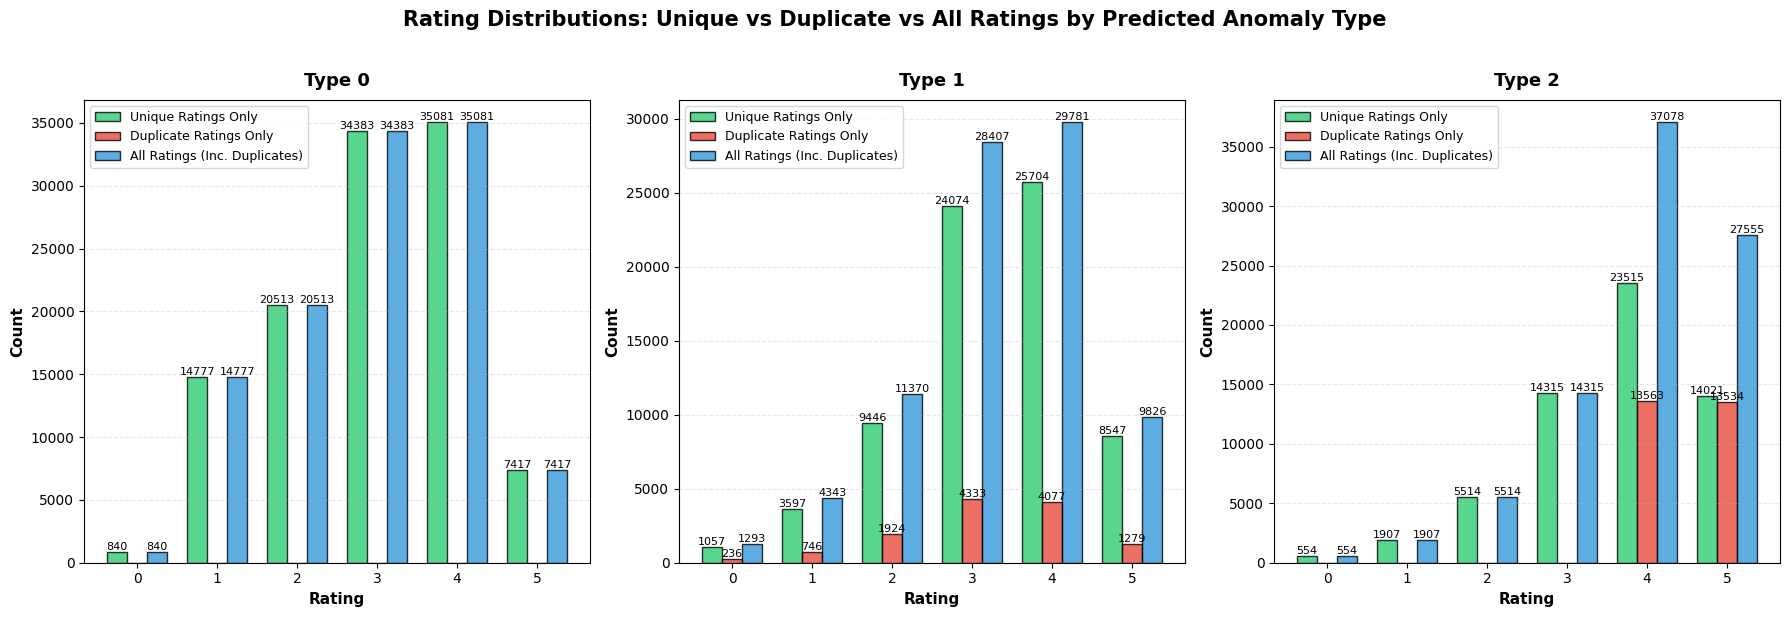


Summary:
Type 0: 113,011 unique ratings, 0 duplicate ratings, 113,011 total ratings
Type 1: 72,425 unique ratings, 12,595 duplicate ratings, 85,020 total ratings
Type 2: 59,826 unique ratings, 27,097 duplicate ratings, 86,923 total ratings


In [ ]:
# @title Compare All Ratings vs Duplicate Ratings (Predicted Data)
# For each predicted anomaly type, compare ratings in 3 ways:
# 1. All ratings EXCLUDING duplicates (unique ratings only)
# 2. Duplicate ratings only
# 3. All ratings INCLUDING duplicates

# First, identify which ratings are duplicates
# A rating is a duplicate if the same (user, item) pair appears more than once
X_pred_with_type['is_duplicate'] = X_pred_with_type.duplicated(subset=['user', 'item'], keep=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Rating Distributions: Unique vs Duplicate vs All Ratings by Predicted Anomaly Type',
             fontsize=15, fontweight='bold', y=1.02)

for idx, anom_type in enumerate(sorted(X_pred_with_type['anomtype'].unique())):
    type_data = X_pred_with_type[X_pred_with_type['anomtype'] == anom_type]

    # Three sets of ratings
    unique_ratings = type_data[~type_data['is_duplicate']]['rating']  # Unique only (exclude duplicates)
    dup_ratings = type_data[type_data['is_duplicate']]['rating']      # Duplicates only
    all_ratings = type_data['rating']                                  # All ratings (includes duplicates)

    # Create grouped bar chart for better readability
    bins = [0, 1, 2, 3, 4, 5, 6]
    bin_labels = ['0', '1', '2', '3', '4', '5']

    # Count ratings in each bin for all three groups
    unique_counts, _ = np.histogram(unique_ratings, bins=bins)
    dup_counts, _ = np.histogram(dup_ratings, bins=bins)
    all_counts, _ = np.histogram(all_ratings, bins=bins)

    # Set up bar positions
    x = np.arange(len(bin_labels))
    width = 0.25

    # Create bars
    axes[idx].bar(x - width, unique_counts, width, label='Unique Ratings Only',
                  alpha=0.8, edgecolor='black', color='#2ecc71')
    axes[idx].bar(x, dup_counts, width, label='Duplicate Ratings Only',
                  alpha=0.8, edgecolor='black', color='#e74c3c')
    axes[idx].bar(x + width, all_counts, width, label='All Ratings (Inc. Duplicates)',
                  alpha=0.8, edgecolor='black', color='#3498db')

    axes[idx].set_title(f'Type {anom_type}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Rating', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Count', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(bin_labels)
    axes[idx].legend(loc='upper left', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y', linestyle='--')

    # Add value labels on bars for better readability
    for i, (u, d, a) in enumerate(zip(unique_counts, dup_counts, all_counts)):
        if u > 0:
            axes[idx].text(i - width, u, str(int(u)), ha='center', va='bottom', fontsize=8)
        if d > 0:
            axes[idx].text(i, d, str(int(d)), ha='center', va='bottom', fontsize=8)
        if a > 0:
            axes[idx].text(i + width, a, str(int(a)), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics for clarity
print("\nSummary:")
for anom_type in sorted(X_pred_with_type['anomtype'].unique()):
    type_data = X_pred_with_type[X_pred_with_type['anomtype'] == anom_type]
    n_unique = (~type_data['is_duplicate']).sum()
    n_dup = type_data['is_duplicate'].sum()
    n_total = len(type_data)
    print(f"Type {anom_type}: {n_unique:,} unique ratings, {n_dup:,} duplicate ratings, {n_total:,} total ratings")


CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE
EM + NAIVE BAYES Model

Setup:
  Labeled samples: 60
  Unlabeled samples: 3540
  Total features: 46
  Classes: 3

Using best parameters from grid search (EM + NB):
  {'var_smoothing': 1e-07, 'max_iter': 50, 'use_weights': True, 'convergence_tol': 1e-05}
  Best CV Accuracy: 0.9167

CALCULATING FEATURE IMPORTANCE
Testing each feature across 5 CV folds...
This will take significant time...


FOLD 1/5
  Train: 48 samples | Val: 12 samples

  [Baseline] Training with all features...
  [Baseline] Accuracy: 0.9167

  Testing 46 features...
    Progress: 5/46 features tested
    Progress: 10/46 features tested
    Progress: 15/46 features tested
    Progress: 20/46 features tested
    Progress: 25/46 features tested
    Progress: 30/46 features tested
    Progress: 35/46 features tested
    Progress: 40/46 features tested
    Progress: 45/46 features tested
  ✓ Fold 1 complete

FOLD 2/5
  Train: 48 samples | Val: 12 samples

  [Baseline] Training

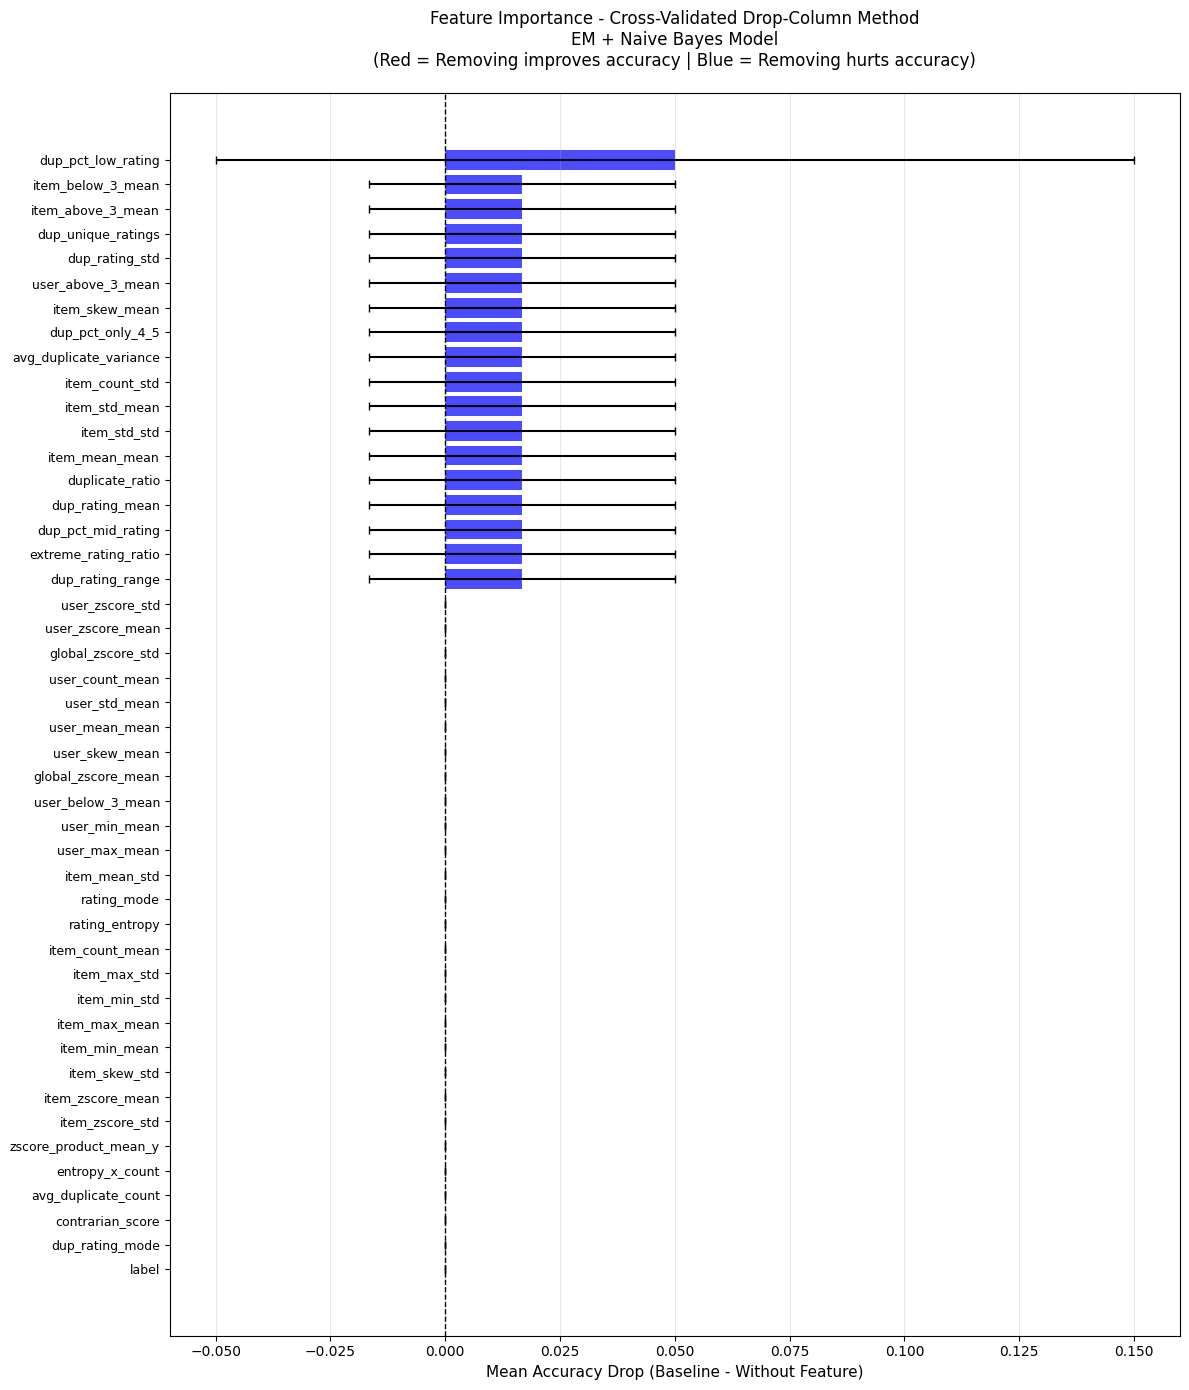

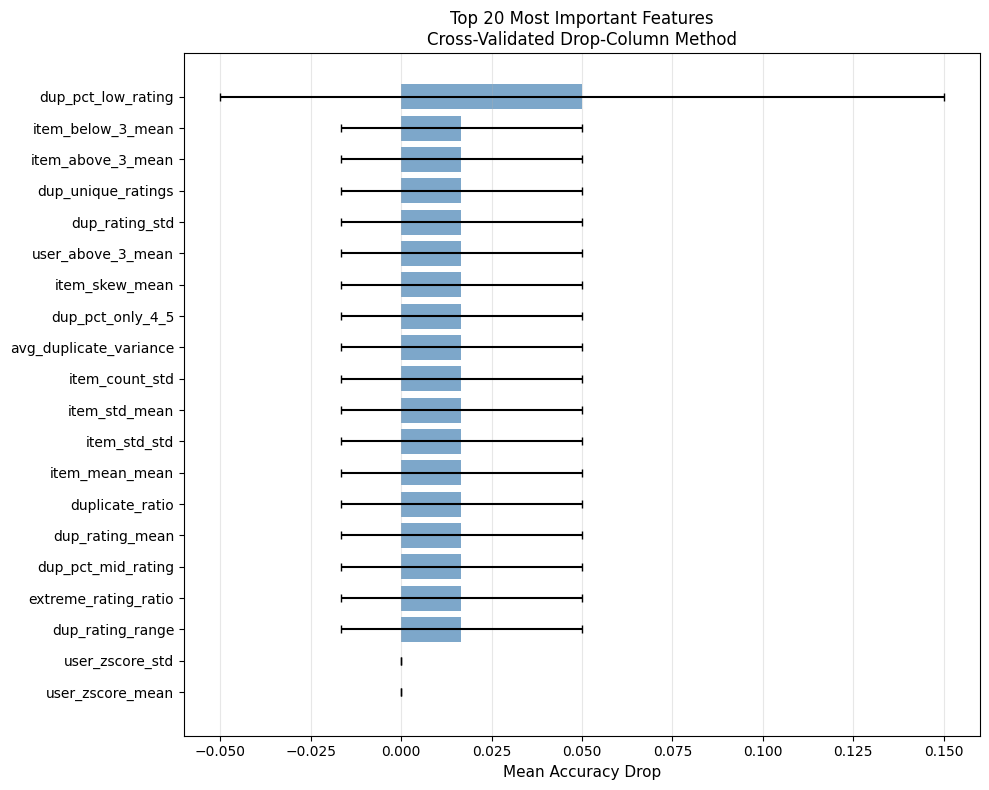

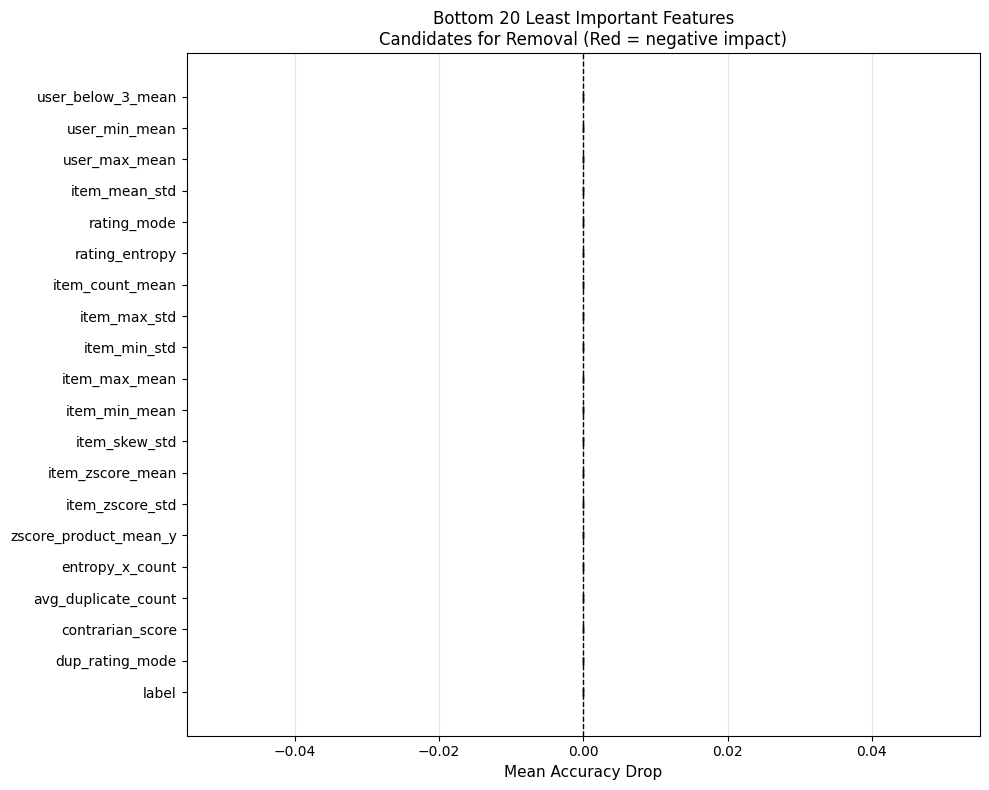

/tmp/ipython-input-114194797.py:306: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(top_20_data, labels=top_20_labels, vert=False)


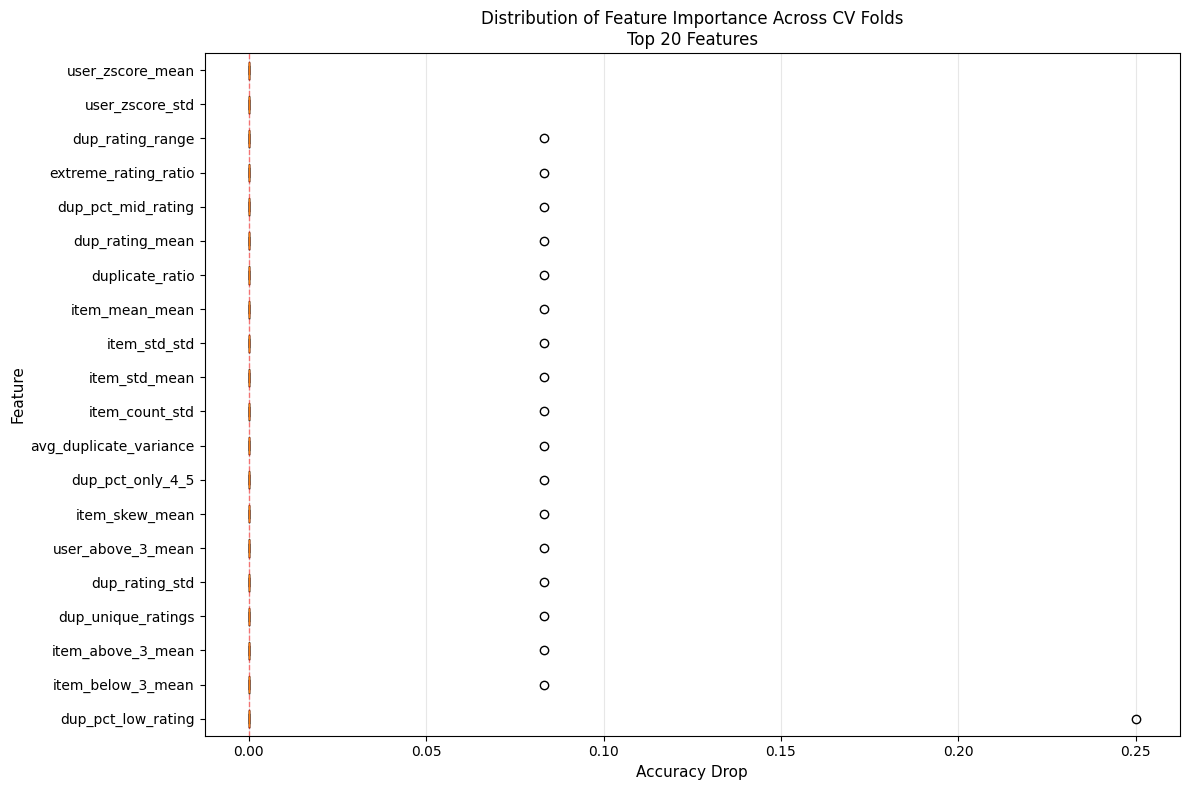


SUMMARY STATISTICS

Feature Importance Statistics:
  Mean importance: 0.007246
  Std importance: 0.010335
  Max importance: 0.050000
  Min importance: 0.000000

Feature Categories:
  High importance (> 0.01): 18
  Medium importance (0 to 0.01): 28
  Low/negative importance (< 0): 0

✓ CROSS-VALIDATED FEATURE IMPORTANCE COMPLETE

DataFrame 'cv_importance_df' contains full results with 46 features

FINAL LIST OF RECOMMENDED FEATURES FOR REMOVAL
Total Features to Remove: 28
Python List Format:
['item_max_mean', 'user_min_mean', 'rating_mode', 'user_skew_mean', 'label', 'item_skew_std', 'zscore_product_mean_y', 'user_below_3_mean', 'rating_entropy', 'user_max_mean', 'entropy_x_count', 'item_zscore_mean', 'contrarian_score', 'user_zscore_std', 'item_mean_std', 'user_count_mean', 'avg_duplicate_count', 'item_max_std', 'item_min_std', 'item_count_mean', 'global_zscore_mean', 'dup_rating_mode', 'item_min_mean', 'user_mean_mean', 'user_zscore_mean', 'item_zscore_std', 'user_std_mean', 'global_

In [ ]:
# @title Expectation Maximization Naive Bayes Feature Importance using CV leave-one-out
# ============================================
# CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE
# For EM + NAIVE BAYES Model (Full Script)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB # Import the base model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("\n" + "="*70)
print("CROSS-VALIDATED DROP-COLUMN FEATURE IMPORTANCE")
print("EM + NAIVE BAYES Model")
print("="*70)

# ============================================
# STEP 1: Setup & Data Synchronization
# ============================================

# Assuming X_labeled, y_labeled, X_unlabeled, and best_params are defined.
X_semi_labeled = X_labeled.copy()
y_semi_labeled = y_labeled.copy()
X_semi_unlabeled = X_unlabeled.copy()

# Ensure best_params is a dictionary for reliable key access
if isinstance(best_params, pd.Series):
    best_params = best_params.to_dict()

print("\nSetup:")
print(f"  Labeled samples: {len(X_semi_labeled)}")
print(f"  Unlabeled samples: {len(X_semi_unlabeled)}")
print(f"  Total features: {X_semi_labeled.shape[1]}")
print(f"  Classes: {len(y_semi_labeled.unique())}")

# Get feature names
feature_names = X_semi_labeled.columns.tolist()

# Extract best parameters for the EM loop
em_nb_params = {
    'var_smoothing': best_params['var_smoothing'],
    'max_iter': best_params['max_iter'],
    'use_weights': best_params['use_weights'],
    'convergence_tol': best_params['convergence_tol']
}

print(f"\nUsing best parameters from grid search (EM + NB):")
print(f"  {em_nb_params}")
print(f"  Best CV Accuracy: {best_params.get('mean_cv_accuracy', 'N/A'):.4f}")


# --- Nested EM Training Function ---
def train_em_nb(X_train_data, y_train_data, X_unlabeled_data, X_val_data, y_val_data):
    """Replicates the EM training loop for one fold/dropped-feature scenario."""
    nb = GaussianNB(var_smoothing=em_nb_params['var_smoothing'])
    nb.fit(X_train_data, y_train_data)

    prev_probs = None
    for _ in range(em_nb_params['max_iter']):
        # E-step
        probs_unlabeled = nb.predict_proba(X_unlabeled_data)

        # Check convergence
        if prev_probs is not None:
            change = np.abs(probs_unlabeled - prev_probs).mean()
            if change < em_nb_params['convergence_tol']:
                break
        prev_probs = probs_unlabeled.copy()

        # M-step
        X_combined = np.vstack([X_train_data, X_unlabeled_data])
        y_unlabeled_pred = probs_unlabeled.argmax(axis=1)
        y_combined = np.hstack([y_train_data.values, y_unlabeled_pred])

        if em_nb_params['use_weights']:
            weights_labeled = np.ones(len(X_train_data))
            weights_unlabeled = probs_unlabeled.max(axis=1)
            weights = np.hstack([weights_labeled, weights_unlabeled])
        else:
            weights = np.ones(len(X_combined))

        nb.fit(X_combined, y_combined, sample_weight=weights)

    # Predict and calculate accuracy on validation set
    y_pred = nb.predict(X_val_data)
    return accuracy_score(y_val_data, y_pred)
# --- End EM Training Function ---


# ============================================
# STEP 2: Cross-Validated Feature Importance
# ============================================

print("\n" + "="*70)
print("CALCULATING FEATURE IMPORTANCE")
print("="*70)
n_folds = 5
print(f"Testing each feature across {n_folds} CV folds...")
print("This will take significant time...\n")

# Setup CV
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store importance for each feature across folds
cv_feature_importances = {feat: [] for feat in feature_names}
baseline_accuracies = []

# Loop through CV folds
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_semi_labeled, y_semi_labeled)):
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx + 1}/{n_folds}")
    print(f"{'='*70}")

    # Split labeled data
    X_train = X_semi_labeled.iloc[train_idx]
    y_train = y_semi_labeled.iloc[train_idx]
    X_val = X_semi_labeled.iloc[val_idx]
    y_val = y_semi_labeled.iloc[val_idx]
    X_unlabeled = X_semi_unlabeled.copy()

    print(f"  Train: {len(X_train)} samples | Val: {len(X_val)} samples")

    # Prepare semi-supervised data for Scaler fit
    X_train_unlabeled = pd.concat([X_train, X_unlabeled], ignore_index=True)

    # Scale data (Fit on semi-supervised train set)
    scaler = StandardScaler()
    scaler.fit(X_train_unlabeled)
    X_train_scaled_full = scaler.transform(X_train)
    X_unlabeled_scaled_full = scaler.transform(X_unlabeled)
    X_val_scaled_full = scaler.transform(X_val)

    # Train baseline model (with ALL features)
    print("\n  [Baseline] Training with all features...")
    baseline_acc = train_em_nb(X_train_scaled_full, y_train, X_unlabeled_scaled_full, X_val_scaled_full, y_val)
    baseline_accuracies.append(baseline_acc)
    print(f"  [Baseline] Accuracy: {baseline_acc:.4f}")

    # Test each feature by dropping it
    print(f"\n  Testing {len(feature_names)} features...")
    for i, feature in enumerate(feature_names):
        # Drop this feature from all scaled datasets
        feature_mask = [j for j in range(len(feature_names)) if j != i]

        X_train_dropped = X_train_scaled_full[:, feature_mask]
        X_unlabeled_dropped = X_unlabeled_scaled_full[:, feature_mask]
        X_val_dropped = X_val_scaled_full[:, feature_mask]

        # Train model without this feature
        dropped_acc = train_em_nb(X_train_dropped, y_train, X_unlabeled_dropped, X_val_dropped, y_val)

        # Calculate importance (accuracy drop when feature is removed)
        importance = baseline_acc - dropped_acc
        cv_feature_importances[feature].append(importance)

        # Progress update every 5 features
        if (i + 1) % 5 == 0:
            print(f"    Progress: {i+1}/{len(feature_names)} features tested")

    print(f"  ✓ Fold {fold_idx + 1} complete")

# ============================================
# STEP 3: Aggregate Results
# ============================================

print("\n" + "="*70)
print("AGGREGATING RESULTS ACROSS FOLDS")
print("="*70)

# Calculate mean and std across folds
cv_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': [np.mean(cv_feature_importances[f]) for f in feature_names],
    'Importance_Std': [np.std(cv_feature_importances[f]) for f in feature_names],
    'Importance_Min': [np.min(cv_feature_importances[f]) for f in feature_names],
    'Importance_Max': [np.max(cv_feature_importances[f]) for f in feature_names]
}).sort_values('Importance_Mean', ascending=False)

# Add fold-by-fold importances as separate columns
for fold_idx in range(n_folds):
    cv_importance_df[f'Fold_{fold_idx+1}'] = [cv_feature_importances[f][fold_idx] for f in cv_importance_df['Feature']]

print(f"\nBaseline accuracies across folds:")
for fold_idx, acc in enumerate(baseline_accuracies):
    print(f"  Fold {fold_idx + 1}: {acc:.4f}")
print(f"  Mean: {np.mean(baseline_accuracies):.4f} (+/- {np.std(baseline_accuracies):.4f})")

# ============================================
# STEP 4: Display Results
# ============================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKING")
print("="*70)

print("\nTop 15 Most Important Features:")
print(cv_importance_df[['Feature', 'Importance_Mean', 'Importance_Std', 'Importance_Min', 'Importance_Max']].head(15).to_string(index=False))

print("\n" + "-"*70)

print("\nBottom 15 Least Important Features:")
print(cv_importance_df[['Feature', 'Importance_Mean', 'Importance_Std', 'Importance_Min', 'Importance_Max']].tail(15).to_string(index=False))

# ============================================
# STEP 5: Identify Features to Remove
# ============================================

print("\n" + "="*70)
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*70)

# Strategy 1: Features with negative mean importance
negative_importance = cv_importance_df[cv_importance_df['Importance_Mean'] < 0]
print(f"\nFeatures with NEGATIVE mean importance (removing them IMPROVES accuracy):")
print(f"Count: {len(negative_importance)}")
if len(negative_importance) > 0:
    print(negative_importance[['Feature', 'Importance_Mean', 'Importance_Std']].to_string(index=False))
else:
    print("  None found")

# Strategy 2: Features with near-zero importance (bottom 25%)
threshold_percentile = 25
if len(cv_importance_df) > 0:
    importance_threshold = np.percentile(cv_importance_df['Importance_Mean'], threshold_percentile)
else:
    importance_threshold = 0

low_importance = cv_importance_df[cv_importance_df['Importance_Mean'] <= importance_threshold]

print(f"\nFeatures with LOW importance (bottom {threshold_percentile}%):")
print(f"Threshold: {importance_threshold:.6f}")
print(f"Count: {len(low_importance)}")
print(low_importance[['Feature', 'Importance_Mean', 'Importance_Std']].to_string(index=False))

# ============================================
# STEP 6: Visualizations
# ============================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Feature importance with error bars
plt.figure(figsize=(12, 14))
y_pos = range(len(feature_names))
colors = ['red' if x < 0 else 'blue' for x in cv_importance_df['Importance_Mean'][::-1]]
plt.barh(y_pos, cv_importance_df['Importance_Mean'][::-1],
         xerr=cv_importance_df['Importance_Std'][::-1],
         color=colors, alpha=0.7, capsize=3)
plt.yticks(y_pos, cv_importance_df['Feature'][::-1], fontsize=9)
plt.xlabel('Mean Accuracy Drop (Baseline - Without Feature)', fontsize=11)
plt.title('Feature Importance - Cross-Validated Drop-Column Method\nEM + Naive Bayes Model\n(Red = Removing improves accuracy | Blue = Removing hurts accuracy)',
          fontsize=12, pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Top 20 features only (easier to read)
plt.figure(figsize=(10, 8))
top_20 = cv_importance_df.head(20)
y_pos_20 = range(len(top_20))
plt.barh(y_pos_20, top_20['Importance_Mean'][::-1],
         xerr=top_20['Importance_Std'][::-1],
         color='steelblue', alpha=0.7, capsize=3)
plt.yticks(y_pos_20, top_20['Feature'][::-1], fontsize=10)
plt.xlabel('Mean Accuracy Drop', fontsize=11)
plt.title('Top 20 Most Important Features\nCross-Validated Drop-Column Method', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Bottom 20 features (candidates for removal)
plt.figure(figsize=(10, 8))
bottom_20 = cv_importance_df.tail(20)
y_pos_bottom = range(len(bottom_20))
colors_bottom = ['red' if x < 0 else 'orange' for x in bottom_20['Importance_Mean'][::-1]]
plt.barh(y_pos_bottom, bottom_20['Importance_Mean'][::-1],
         xerr=bottom_20['Importance_Std'][::-1],
         color=colors_bottom, alpha=0.7, capsize=3)
plt.yticks(y_pos_bottom, bottom_20['Feature'][::-1], fontsize=10)
plt.xlabel('Mean Accuracy Drop', fontsize=11)
plt.title('Bottom 20 Least Important Features\nCandidates for Removal (Red = negative impact)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Distribution of importance across folds (box plot for top 20)
plt.figure(figsize=(12, 8))
top_20_data = []
top_20_labels = []
for feature in cv_importance_df.head(20)['Feature']:
    top_20_data.append(cv_feature_importances[feature])
    top_20_labels.append(feature)

plt.boxplot(top_20_data, labels=top_20_labels, vert=False)
plt.xlabel('Accuracy Drop', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Distribution of Feature Importance Across CV Folds\nTop 20 Features', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# STEP 7: Summary Statistics
# ============================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print(f"\nFeature Importance Statistics:")
print(f"  Mean importance: {cv_importance_df['Importance_Mean'].mean():.6f}")
print(f"  Std importance: {cv_importance_df['Importance_Mean'].std():.6f}")
print(f"  Max importance: {cv_importance_df['Importance_Mean'].max():.6f}")
print(f"  Min importance: {cv_importance_df['Importance_Mean'].min():.6f}")

print(f"\nFeature Categories:")
print(f"  High importance (> 0.01): {len(cv_importance_df[cv_importance_df['Importance_Mean'] > 0.01])}")
print(f"  Medium importance (0 to 0.01): {len(cv_importance_df[(cv_importance_df['Importance_Mean'] >= 0) & (cv_importance_df['Importance_Mean'] <= 0.01)])}")
print(f"  Low/negative importance (< 0): {len(cv_importance_df[cv_importance_df['Importance_Mean'] < 0])}")

print("\n" + "="*70)
print("✓ CROSS-VALIDATED FEATURE IMPORTANCE COMPLETE")
print("="*70)

print(f"\nDataFrame 'cv_importance_df' contains full results with {len(cv_importance_df)} features")
print("="*70)


# --- Feature Removal Strategy: Combine Negative and Near-Zero Mean Importance ---

# Features with NEGATIVE Mean Importance (removing them IMPROVES accuracy)
negative_importance_list = cv_importance_df[
    cv_importance_df['Importance_Mean'] < 0
]['Feature'].tolist()

# Use the calculated 25th percentile threshold
low_importance_threshold = importance_threshold

near_zero_importance_list = cv_importance_df[
    (cv_importance_df['Importance_Mean'] >= 0) &
    (cv_importance_df['Importance_Mean'] <= low_importance_threshold)
]['Feature'].tolist()

# Combine and Dedup the final list
features_to_remove = list(set(negative_importance_list + near_zero_importance_list))

print("\n" + "="*70)
print("FINAL LIST OF RECOMMENDED FEATURES FOR REMOVAL")
print("="*70)
print(f"Total Features to Remove: {len(features_to_remove)}")
print("Python List Format:")
print(features_to_remove)
print("="*70)